Here we'll first be loading the FC matrices and explore their structure

In [1]:
#using read_dataset from Datasets/FC/create_dataset.py to read the dataset
from Datasets.FC.create_dataset import read_dataset

In [2]:
dataset = read_dataset()

In [3]:
#ok, let's explore the data a bit more
#dataset is a list object of torch_geometric.data objects

#let's see the first element
print(dataset[0])

#it's a dictionary object, let's see the keys
print(dataset[0].keys())

#ok, let's see the values
print(dataset[0].values())

#it has 4 keys, 'x', 'edge_index', 'edge_attr' and 'y' where y=0 menas the patient is healthy and y=1 means the patient has Autism Spectrum Disorder (ASD)
"""graph = Data(x=ROI.reshape(-1,116).float(),
                     edge_index=G.indices().reshape(2,-1).long(),
                     edge_attr=G.values().reshape(-1,1).float(),
                     y=y.long())"""

#how much data do we have?
len(dataset)


Data(x=[116, 116], edge_index=[2, 1016], edge_attr=[1016, 1], y=[1])
['edge_index', 'y', 'edge_attr', 'x']
ValuesView({'x': tensor([[ 0.0000,  0.4543,  0.2477,  ...,  0.1753,  0.2247, -0.1751],
        [ 0.4543,  0.0000, -0.2204,  ..., -0.1947, -0.2258, -0.1434],
        [ 0.2477, -0.2204,  0.0000,  ..., -0.0521, -0.0804, -0.2025],
        ...,
        [ 0.1753, -0.1947, -0.0521,  ...,  0.0000,  0.6875, -0.1364],
        [ 0.2247, -0.2258, -0.0804,  ...,  0.6875,  0.0000,  0.0929],
        [-0.1751, -0.1434, -0.2025,  ..., -0.1364,  0.0929,  0.0000]]), 'edge_index': tensor([[  0,   0,   0,  ..., 114, 115, 115],
        [  1,  10,  12,  ..., 113,  94, 109]]), 'edge_attr': tensor([[0.4543],
        [0.5913],
        [0.4224],
        ...,
        [0.6875],
        [0.4846],
        [0.5437]]), 'y': tensor([0])})


1099

In [4]:
#set the seed
import torch
torch.manual_seed(0)

MODEL = "GAT"
DATASET = "FC"

from models.models_FC import GAT_framework as framework # import the model

gnn = framework(dataset)

print(gnn.model)
print(gnn.train_idx)

Net(
  (conv_layers): ModuleList(
    (0): GATConv(116, 128, heads=4)
    (1): GATConv(512, 128, heads=4)
    (2): GATConv(512, 128, heads=4)
    (3): GATConv(512, 128, heads=4)
    (4): GATConv(512, 128, heads=4)
  )
  (batch_norms): ModuleList(
    (0): BatchNorm(512)
    (1): BatchNorm(512)
    (2): BatchNorm(512)
    (3): BatchNorm(512)
    (4): BatchNorm(512)
  )
  (lin1): Linear(512, 128, bias=True)
  (lin2): Linear(128, 2, bias=True)
  (bn1): BatchNorm(128)
  (bn2): BatchNorm(2)
)
tensor([217, 137, 426,  ..., 643, 205, 434])


/home/tpelletreaudur/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [5]:
# gnn.iterate()

In [6]:
#gnn.train()

In [7]:
#save the model 
# gnn.save_model(path="models/"+DATASET+"_"+MODEL+"server2.pt")

In [8]:
#load the model
gnn.load_model(path="models/"+DATASET+"_"+MODEL+"server2.pt")

In [9]:
gnn.evaluate()

Test Loss: 0.898, Train Acc: 1.000 Test Acc: 0.618


In [10]:
train_features, test_features = gnn.evaluate_with_features2()

In [11]:
print(len(train_features[0]))
len(train_features), len(test_features)

8


(1044, 55)

In [12]:
import pickle as pkl
import networkx as nx

def calculate_avg_path_length(G):
    if nx.is_connected(G):
        return nx.average_shortest_path_length(G)
    else:
        # Alternative metrics for disconnected graphs
        # Option 1: Use the average path length of the largest connected component
        components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
        largest_component = max(components, key=len)
        return nx.average_shortest_path_length(largest_component)
    
def calculate_small_world(G):
    if nx.is_connected(G):
        return nx.algorithms.smallworld.sigma(G)
    else:
        # Alternative metrics for disconnected graphs
        # Option 1: Use the small world coefficient of the largest connected component
        components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
        largest_component = max(components, key=len)
        return nx.algorithms.smallworld.sigma(largest_component)
    
def compute_swi(graph):
    # Calculate clustering coefficient and average path length for the given graph
    clustering_coeff = nx.average_clustering(graph)
    avg_path_len = calculate_avg_path_length(graph)
    
    # Generate a random graph with the same number of nodes and edges
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    random_graph = nx.gnm_random_graph(num_nodes, num_edges)
    
    # Generate a lattice graph with the same number of nodes and edges
    lattice_graph = nx.watts_strogatz_graph(num_nodes, k=4, p=0)  # Adjust k as needed
    
    # Calculate clustering coefficient and average path length for the random graph
    random_clustering_coeff = nx.average_clustering(random_graph)
    random_avg_path_len = calculate_avg_path_length(random_graph)
    
    # Calculate clustering coefficient and average path length for the lattice graph
    lattice_clustering_coeff = nx.average_clustering(lattice_graph)
    lattice_avg_path_len = calculate_avg_path_length(lattice_graph)
    
    # Compute the Small-World Index (SWI)
    swi = ((avg_path_len - lattice_avg_path_len) / (random_avg_path_len - lattice_avg_path_len)) * \
          ((clustering_coeff - random_clustering_coeff) / (lattice_clustering_coeff - random_clustering_coeff))
    
    return swi
    

def compute_graph_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        num_nodes = G.number_of_nodes()
        num_edges = G.number_of_edges()
        density = nx.density(G)
        avg_path_len = calculate_avg_path_length(G)
        num_cliques = len(list(nx.find_cliques(G)))
        num_triangles = sum(nx.triangles(G).values()) / 3
        num_squares = sum(nx.square_clustering(G).values()) / 4
        number_of_node_in_the_largest_fully_connected_component = len(max(nx.connected_components(G), key=len))
        assortativity = nx.degree_assortativity_coefficient(G)
        small_world = compute_swi(G)
            
        properties.append((num_nodes, num_edges, density, avg_path_len, num_cliques, num_triangles, num_squares, number_of_node_in_the_largest_fully_connected_component, assortativity, small_world))
    return properties

train_idx_list = gnn.train_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in train_idx_list]
train_properties = compute_graph_properties(selected_dataset)
test_idx_list = gnn.test_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in test_idx_list]
test_properties = compute_graph_properties(selected_dataset)

# Save the properties to files
with open("results/"+DATASET+"_"+MODEL+"_train_properties_with_sm.pkl", "wb") as f:
    pkl.dump(train_properties, f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_with_sm.pkl", "wb") as f:
    pkl.dump(test_properties, f)

In [13]:
print(len(train_properties))
train_properties[0:5]



1044


[(116,
  717,
  0.10749625187406296,
  2.6724137931034484,
  263,
  1735.0,
  6.64946643069199,
  116,
  0.3963636188813396,
  1.0022234578952185),
 (116,
  473,
  0.07091454272863568,
  3.4743628185907047,
  158,
  708.0,
  7.095858020333574,
  116,
  0.28679287295765565,
  0.9387259210196166),
 (116,
  997,
  0.1494752623688156,
  2.469265367316342,
  343,
  3591.0,
  7.864813698203321,
  116,
  0.45675805097082345,
  1.0741548558164544),
 (116,
  892,
  0.13373313343328336,
  2.874662668665667,
  144,
  3409.0,
  10.613595627764592,
  116,
  0.5039099001590127,
  1.327509199110338),
 (116,
  504,
  0.07556221889055473,
  3.1734202763546033,
  155,
  861.0,
  6.351955841015705,
  114,
  0.3455129203218888,
  0.9281429013394039)]

In [14]:
import pickle as pkl
# save the properties in a file
# with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "wb") as f:
#     pkl.dump(train_properties, f)

# with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "wb") as f:
#     pkl.dump(test_properties, f)

#load the properties
with open("results/"+DATASET+"_"+MODEL+"_train_properties_with_sm.pkl", "rb") as f:
    train_properties = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_with_sm.pkl", "rb") as f:
    test_properties = pkl.load(f)

In [17]:
"""
The embeddings of GCN are like this:
return F.log_softmax(x7, dim=-1), (x1, x2, x3, x4, x5, x_global, x6, x7)
"""


import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
output_size = 1  # Predicting one property at a time
# Define the linear model
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Assume we have already evaluated to get features
# train_features, test_features = gnn.evaluate_with_features2()

# Extract x embeddings
train_x = np.array([feat[0] for feat in train_features])
test_x = np.array([feat[0] for feat in test_features])

# Extract 2, 3, 4, global, 5, 6, 7 embeddings
train_x2 = np.array([feat[1] for feat in train_features])
test_x2 = np.array([feat[1] for feat in test_features])

train_x3 = np.array([feat[2] for feat in train_features])
test_x3 = np.array([feat[2] for feat in test_features])

train_x4 = np.array([feat[3] for feat in train_features])
test_x4 = np.array([feat[3] for feat in test_features])

train_x5 = np.array([feat[4] for feat in train_features])
test_x5 = np.array([feat[4] for feat in test_features])

train_x_global = np.array([feat[5] for feat in train_features])
test_x_global = np.array([feat[5] for feat in test_features])

train_x6 = np.array([feat[6] for feat in train_features])
test_x6 = np.array([feat[6] for feat in test_features])

train_x7 = np.array([feat[7] for feat in train_features])
test_x7 = np.array([feat[7] for feat in test_features])

# Compute graph properties
# train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
# test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

# Convert to PyTorch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_x2 = torch.tensor(train_x2, dtype=torch.float32)
train_x3 = torch.tensor(train_x3, dtype=torch.float32)
train_x4 = torch.tensor(train_x4, dtype=torch.float32)
train_x5 = torch.tensor(train_x5, dtype=torch.float32)
train_x_global = torch.tensor(train_x_global, dtype=torch.float32)
train_x6 = torch.tensor(train_x6, dtype=torch.float32)
train_x7 = torch.tensor(train_x7, dtype=torch.float32)

test_x = torch.tensor(test_x, dtype=torch.float32)
test_x2 = torch.tensor(test_x2, dtype=torch.float32)
test_x3 = torch.tensor(test_x3, dtype=torch.float32)
test_x4 = torch.tensor(test_x4, dtype=torch.float32)
test_x5 = torch.tensor(test_x5, dtype=torch.float32)
test_x_global = torch.tensor(test_x_global, dtype=torch.float32)
test_x6 = torch.tensor(test_x6, dtype=torch.float32)
test_x7 = torch.tensor(test_x7, dtype=torch.float32)

train_y = torch.tensor(train_properties, dtype=torch.float32)
test_y = torch.tensor(test_properties, dtype=torch.float32)

# Train and evaluate a model for each graph property and each embedding
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component','assortativity', 'small_world']
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4), (train_x5, test_x5), (train_x_global, test_x_global), (train_x6, test_x6), (train_x7, test_x7)]
embeddings_names = ['x', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score

#create a dictionary where we will store the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    input_size = train_embedding.shape[1]

    for i, property_name in enumerate(property_names):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 800000  # Maximum number of epochs
        min_epochs = 1000  # Minimum number of epochs
        patience = 3000  # Number of epochs to wait for improvement
        tolerance = 1e-6  # Tolerance for considering the loss as stable

        best_loss = float('inf')
        no_improve_count = 0
        
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Print every 1000 epochs
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

            # Check for early stopping, but only after minimum epochs
            if epoch >= min_epochs:
                if loss.item() < best_loss - tolerance:
                    best_loss = loss.item()
                    no_improve_count = 0
                else:
                    no_improve_count += 1

                if no_improve_count >= patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y[:, i].cpu().numpy()
            test_target = test_y[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embedding = embeddings_names[ii]
            results[(name_of_embedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1

#save results
with open("results/"+DATASET+"_"+MODEL+"_results.pkl", "wb") as f:
    pkl.dump(results, f)

Epoch [1000/800000], Property: num_nodes, Loss: 7578.7510
Epoch [2000/800000], Property: num_nodes, Loss: 4445.9385
Epoch [3000/800000], Property: num_nodes, Loss: 2594.7905
Epoch [4000/800000], Property: num_nodes, Loss: 1528.0917
Epoch [5000/800000], Property: num_nodes, Loss: 940.7114
Epoch [6000/800000], Property: num_nodes, Loss: 631.6064
Epoch [7000/800000], Property: num_nodes, Loss: 462.0226
Epoch [8000/800000], Property: num_nodes, Loss: 355.7938
Epoch [9000/800000], Property: num_nodes, Loss: 281.5190
Epoch [10000/800000], Property: num_nodes, Loss: 226.5269
Epoch [11000/800000], Property: num_nodes, Loss: 185.0963
Epoch [12000/800000], Property: num_nodes, Loss: 153.9568
Epoch [13000/800000], Property: num_nodes, Loss: 130.5042
Epoch [14000/800000], Property: num_nodes, Loss: 112.5433
Epoch [15000/800000], Property: num_nodes, Loss: 98.5571
Epoch [16000/800000], Property: num_nodes, Loss: 87.6102
Epoch [17000/800000], Property: num_nodes, Loss: 79.0914
Epoch [18000/800000], 

Epoch [7000/800000], Property: num_edges, Loss: 129342.3750
Epoch [8000/800000], Property: num_edges, Loss: 115228.8906
Epoch [9000/800000], Property: num_edges, Loss: 102640.7969
Epoch [10000/800000], Property: num_edges, Loss: 91442.9453
Epoch [11000/800000], Property: num_edges, Loss: 81516.1328
Epoch [12000/800000], Property: num_edges, Loss: 72739.0703
Epoch [13000/800000], Property: num_edges, Loss: 65002.9023
Epoch [14000/800000], Property: num_edges, Loss: 58230.2383
Epoch [15000/800000], Property: num_edges, Loss: 52354.1641
Epoch [16000/800000], Property: num_edges, Loss: 47300.7773
Epoch [17000/800000], Property: num_edges, Loss: 42991.0586
Epoch [18000/800000], Property: num_edges, Loss: 39349.7617
Epoch [19000/800000], Property: num_edges, Loss: 36296.7812
Epoch [20000/800000], Property: num_edges, Loss: 33749.8789
Epoch [21000/800000], Property: num_edges, Loss: 31628.3418
Epoch [22000/800000], Property: num_edges, Loss: 29859.1152
Epoch [23000/800000], Property: num_edge

Epoch [143000/800000], Property: num_edges, Loss: 12176.1680
Epoch [144000/800000], Property: num_edges, Loss: 12165.7871
Epoch [145000/800000], Property: num_edges, Loss: 12155.6260
Epoch [146000/800000], Property: num_edges, Loss: 12145.6826
Epoch [147000/800000], Property: num_edges, Loss: 12135.9414
Epoch [148000/800000], Property: num_edges, Loss: 12126.3945
Epoch [149000/800000], Property: num_edges, Loss: 12117.0400
Epoch [150000/800000], Property: num_edges, Loss: 12107.8682
Epoch [151000/800000], Property: num_edges, Loss: 12098.8740
Epoch [152000/800000], Property: num_edges, Loss: 12090.0449
Epoch [153000/800000], Property: num_edges, Loss: 12081.3779
Epoch [154000/800000], Property: num_edges, Loss: 12072.8662
Epoch [155000/800000], Property: num_edges, Loss: 12064.5029
Epoch [156000/800000], Property: num_edges, Loss: 12056.2822
Epoch [157000/800000], Property: num_edges, Loss: 12048.1943
Epoch [158000/800000], Property: num_edges, Loss: 12040.2451
Epoch [159000/800000], P

Epoch [278000/800000], Property: num_edges, Loss: 11501.1309
Epoch [279000/800000], Property: num_edges, Loss: 11498.0137
Epoch [280000/800000], Property: num_edges, Loss: 11494.9082
Epoch [281000/800000], Property: num_edges, Loss: 11491.8154
Epoch [282000/800000], Property: num_edges, Loss: 11488.7314
Epoch [283000/800000], Property: num_edges, Loss: 11485.6592
Epoch [284000/800000], Property: num_edges, Loss: 11482.5996
Epoch [285000/800000], Property: num_edges, Loss: 11479.5488
Epoch [286000/800000], Property: num_edges, Loss: 11476.5098
Epoch [287000/800000], Property: num_edges, Loss: 11473.4834
Epoch [288000/800000], Property: num_edges, Loss: 11470.4678
Epoch [289000/800000], Property: num_edges, Loss: 11467.4619
Epoch [290000/800000], Property: num_edges, Loss: 11464.4668
Epoch [291000/800000], Property: num_edges, Loss: 11461.4844
Epoch [292000/800000], Property: num_edges, Loss: 11458.5127
Epoch [293000/800000], Property: num_edges, Loss: 11455.5527
Epoch [294000/800000], P

Epoch [413000/800000], Property: num_edges, Loss: 11181.2021
Epoch [414000/800000], Property: num_edges, Loss: 11179.5898
Epoch [415000/800000], Property: num_edges, Loss: 11177.9902
Epoch [416000/800000], Property: num_edges, Loss: 11176.4004
Epoch [417000/800000], Property: num_edges, Loss: 11174.8213
Epoch [418000/800000], Property: num_edges, Loss: 11173.2539
Epoch [419000/800000], Property: num_edges, Loss: 11171.6973
Epoch [420000/800000], Property: num_edges, Loss: 11170.1514
Epoch [421000/800000], Property: num_edges, Loss: 11168.6201
Epoch [422000/800000], Property: num_edges, Loss: 11167.0957
Epoch [423000/800000], Property: num_edges, Loss: 11165.5840
Epoch [424000/800000], Property: num_edges, Loss: 11164.0840
Epoch [425000/800000], Property: num_edges, Loss: 11162.5938
Epoch [426000/800000], Property: num_edges, Loss: 11161.1152
Epoch [427000/800000], Property: num_edges, Loss: 11159.6484
Epoch [428000/800000], Property: num_edges, Loss: 11158.1934
Epoch [429000/800000], P

Epoch [548000/800000], Property: num_edges, Loss: 11064.8740
Epoch [549000/800000], Property: num_edges, Loss: 11064.7393
Epoch [550000/800000], Property: num_edges, Loss: 11064.6152
Epoch [551000/800000], Property: num_edges, Loss: 11064.4961
Epoch [552000/800000], Property: num_edges, Loss: 11064.3926
Epoch [553000/800000], Property: num_edges, Loss: 11064.2949
Epoch [554000/800000], Property: num_edges, Loss: 11064.2070
Epoch [555000/800000], Property: num_edges, Loss: 11064.1299
Epoch [556000/800000], Property: num_edges, Loss: 11064.0654
Epoch [557000/800000], Property: num_edges, Loss: 11064.0068
Epoch [558000/800000], Property: num_edges, Loss: 11063.9561
Epoch [559000/800000], Property: num_edges, Loss: 11063.9160
Epoch [560000/800000], Property: num_edges, Loss: 11063.8857
Epoch [561000/800000], Property: num_edges, Loss: 11063.8613
Epoch [562000/800000], Property: num_edges, Loss: 11063.8447
Epoch [563000/800000], Property: num_edges, Loss: 11063.8350
Epoch [564000/800000], P

Epoch [81000/800000], Property: num_cliques, Loss: 556.3966
Epoch [82000/800000], Property: num_cliques, Loss: 555.4655
Epoch [83000/800000], Property: num_cliques, Loss: 554.5453
Epoch [84000/800000], Property: num_cliques, Loss: 553.6356
Epoch [85000/800000], Property: num_cliques, Loss: 552.7377
Epoch [86000/800000], Property: num_cliques, Loss: 551.8546
Epoch [87000/800000], Property: num_cliques, Loss: 550.9841
Epoch [88000/800000], Property: num_cliques, Loss: 550.1243
Epoch [89000/800000], Property: num_cliques, Loss: 549.2752
Epoch [90000/800000], Property: num_cliques, Loss: 548.4366
Epoch [91000/800000], Property: num_cliques, Loss: 547.6088
Epoch [92000/800000], Property: num_cliques, Loss: 546.7917
Epoch [93000/800000], Property: num_cliques, Loss: 545.9850
Epoch [94000/800000], Property: num_cliques, Loss: 545.1891
Epoch [95000/800000], Property: num_cliques, Loss: 544.4037
Epoch [96000/800000], Property: num_cliques, Loss: 543.6292
Epoch [97000/800000], Property: num_cliq

Epoch [32000/800000], Property: num_triangles, Loss: 639019.0000
Epoch [33000/800000], Property: num_triangles, Loss: 628538.3750
Epoch [34000/800000], Property: num_triangles, Loss: 618757.2500
Epoch [35000/800000], Property: num_triangles, Loss: 609635.5625
Epoch [36000/800000], Property: num_triangles, Loss: 601128.3125
Epoch [37000/800000], Property: num_triangles, Loss: 593191.3750
Epoch [38000/800000], Property: num_triangles, Loss: 585782.3125
Epoch [39000/800000], Property: num_triangles, Loss: 578863.5000
Epoch [40000/800000], Property: num_triangles, Loss: 572396.6250
Epoch [41000/800000], Property: num_triangles, Loss: 566342.0625
Epoch [42000/800000], Property: num_triangles, Loss: 560665.6875
Epoch [43000/800000], Property: num_triangles, Loss: 555337.3750
Epoch [44000/800000], Property: num_triangles, Loss: 550326.7500
Epoch [45000/800000], Property: num_triangles, Loss: 545598.5000
Epoch [46000/800000], Property: num_triangles, Loss: 541126.1875
Epoch [47000/800000], Pro

Epoch [158000/800000], Property: num_triangles, Loss: 378506.4688
Epoch [159000/800000], Property: num_triangles, Loss: 377874.4375
Epoch [160000/800000], Property: num_triangles, Loss: 377248.0625
Epoch [161000/800000], Property: num_triangles, Loss: 376627.2812
Epoch [162000/800000], Property: num_triangles, Loss: 376011.7812
Epoch [163000/800000], Property: num_triangles, Loss: 375401.7812
Epoch [164000/800000], Property: num_triangles, Loss: 374797.0312
Epoch [165000/800000], Property: num_triangles, Loss: 374197.3750
Epoch [166000/800000], Property: num_triangles, Loss: 373602.6562
Epoch [167000/800000], Property: num_triangles, Loss: 373013.0312
Epoch [168000/800000], Property: num_triangles, Loss: 372428.3438
Epoch [169000/800000], Property: num_triangles, Loss: 371848.7188
Epoch [170000/800000], Property: num_triangles, Loss: 371274.0000
Epoch [171000/800000], Property: num_triangles, Loss: 370704.2188
Epoch [172000/800000], Property: num_triangles, Loss: 370139.4062
Epoch [173

Epoch [283000/800000], Property: num_triangles, Loss: 327748.2500
Epoch [284000/800000], Property: num_triangles, Loss: 327495.4062
Epoch [285000/800000], Property: num_triangles, Loss: 327244.0625
Epoch [286000/800000], Property: num_triangles, Loss: 326994.4062
Epoch [287000/800000], Property: num_triangles, Loss: 326746.2812
Epoch [288000/800000], Property: num_triangles, Loss: 326499.6562
Epoch [289000/800000], Property: num_triangles, Loss: 326254.5938
Epoch [290000/800000], Property: num_triangles, Loss: 326011.0312
Epoch [291000/800000], Property: num_triangles, Loss: 325769.0312
Epoch [292000/800000], Property: num_triangles, Loss: 325528.6562
Epoch [293000/800000], Property: num_triangles, Loss: 325289.5625
Epoch [294000/800000], Property: num_triangles, Loss: 325051.9688
Epoch [295000/800000], Property: num_triangles, Loss: 324815.8125
Epoch [296000/800000], Property: num_triangles, Loss: 324581.0938
Epoch [297000/800000], Property: num_triangles, Loss: 324347.8125
Epoch [298

Epoch [408000/800000], Property: num_triangles, Loss: 305289.7188
Epoch [409000/800000], Property: num_triangles, Loss: 305167.3125
Epoch [410000/800000], Property: num_triangles, Loss: 305045.5938
Epoch [411000/800000], Property: num_triangles, Loss: 304924.5312
Epoch [412000/800000], Property: num_triangles, Loss: 304804.1562
Epoch [413000/800000], Property: num_triangles, Loss: 304684.5000
Epoch [414000/800000], Property: num_triangles, Loss: 304565.5625
Epoch [415000/800000], Property: num_triangles, Loss: 304447.2500
Epoch [416000/800000], Property: num_triangles, Loss: 304329.7500
Epoch [417000/800000], Property: num_triangles, Loss: 304212.9062
Epoch [418000/800000], Property: num_triangles, Loss: 304096.7812
Epoch [419000/800000], Property: num_triangles, Loss: 303981.3125
Epoch [420000/800000], Property: num_triangles, Loss: 303866.6250
Epoch [421000/800000], Property: num_triangles, Loss: 303752.5625
Epoch [422000/800000], Property: num_triangles, Loss: 303639.1875
Epoch [423

Epoch [533000/800000], Property: num_triangles, Loss: 294727.7812
Epoch [534000/800000], Property: num_triangles, Loss: 294674.5625
Epoch [535000/800000], Property: num_triangles, Loss: 294621.5938
Epoch [536000/800000], Property: num_triangles, Loss: 294569.0312
Epoch [537000/800000], Property: num_triangles, Loss: 294516.8750
Epoch [538000/800000], Property: num_triangles, Loss: 294464.9688
Epoch [539000/800000], Property: num_triangles, Loss: 294413.4062
Epoch [540000/800000], Property: num_triangles, Loss: 294362.1875
Epoch [541000/800000], Property: num_triangles, Loss: 294311.2812
Epoch [542000/800000], Property: num_triangles, Loss: 294260.7188
Epoch [543000/800000], Property: num_triangles, Loss: 294210.4688
Epoch [544000/800000], Property: num_triangles, Loss: 294160.5625
Epoch [545000/800000], Property: num_triangles, Loss: 294111.0000
Epoch [546000/800000], Property: num_triangles, Loss: 294061.6562
Epoch [547000/800000], Property: num_triangles, Loss: 294012.7812
Epoch [548

Epoch [658000/800000], Property: num_triangles, Loss: 290235.0312
Epoch [659000/800000], Property: num_triangles, Loss: 290211.2812
Epoch [660000/800000], Property: num_triangles, Loss: 290187.6875
Epoch [661000/800000], Property: num_triangles, Loss: 290164.1250
Epoch [662000/800000], Property: num_triangles, Loss: 290140.7812
Epoch [663000/800000], Property: num_triangles, Loss: 290117.4688
Epoch [664000/800000], Property: num_triangles, Loss: 290094.2188
Epoch [665000/800000], Property: num_triangles, Loss: 290071.1875
Epoch [666000/800000], Property: num_triangles, Loss: 290048.2500
Epoch [667000/800000], Property: num_triangles, Loss: 290025.4062
Epoch [668000/800000], Property: num_triangles, Loss: 290002.6875
Epoch [669000/800000], Property: num_triangles, Loss: 289980.0625
Epoch [670000/800000], Property: num_triangles, Loss: 289957.5625
Epoch [671000/800000], Property: num_triangles, Loss: 289935.1562
Epoch [672000/800000], Property: num_triangles, Loss: 289912.8438
Epoch [673

Epoch [783000/800000], Property: num_triangles, Loss: 288095.4375
Epoch [784000/800000], Property: num_triangles, Loss: 288084.1875
Epoch [785000/800000], Property: num_triangles, Loss: 288073.0625
Epoch [786000/800000], Property: num_triangles, Loss: 288061.9375
Epoch [787000/800000], Property: num_triangles, Loss: 288050.8438
Epoch [788000/800000], Property: num_triangles, Loss: 288039.9062
Epoch [789000/800000], Property: num_triangles, Loss: 288029.0000
Epoch [790000/800000], Property: num_triangles, Loss: 288018.1562
Epoch [791000/800000], Property: num_triangles, Loss: 288007.2812
Epoch [792000/800000], Property: num_triangles, Loss: 287996.6250
Epoch [793000/800000], Property: num_triangles, Loss: 287986.0312
Epoch [794000/800000], Property: num_triangles, Loss: 287975.4375
Epoch [795000/800000], Property: num_triangles, Loss: 287964.8750
Epoch [796000/800000], Property: num_triangles, Loss: 287954.4375
Epoch [797000/800000], Property: num_triangles, Loss: 287944.0312
Epoch [798

Epoch [52000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 28.8805
Epoch [53000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 28.1513
Epoch [54000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 27.4328
Epoch [55000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 26.7250
Epoch [56000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 26.0278
Epoch [57000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 25.3412
Epoch [58000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 24.6653
Epoch [59000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 24.0001
Epoch [60000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 23.3454
Epoch [61000/800000], Property: number_of_nodes_in_the_largest_f

Epoch [131000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.5409
Epoch [132000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.5411
Epoch [133000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.5410
Early stopping at epoch 133987
Embedding: torch.Size([1044, 512])
Property: number_of_nodes_in_the_largest_fully_connected_component
  Train MSE: 3.5409, Test MSE: 142.8662
  Train R²: 0.4937, Test R²: -46.4183
Epoch [1000/800000], Property: assortativity, Loss: 0.0082
Epoch [2000/800000], Property: assortativity, Loss: 0.0071
Epoch [3000/800000], Property: assortativity, Loss: 0.0066
Epoch [4000/800000], Property: assortativity, Loss: 0.0065
Epoch [5000/800000], Property: assortativity, Loss: 0.0067
Epoch [6000/800000], Property: assortativity, Loss: 0.0066
Epoch [7000/800000], Property: assortativity, Loss: 0.0064
Epoch [8000/800000], Property: assortativity, Loss: 0.0064
Epoch

Epoch [106000/800000], Property: num_nodes, Loss: 2.4117
Epoch [107000/800000], Property: num_nodes, Loss: 2.2620
Epoch [108000/800000], Property: num_nodes, Loss: 2.1216
Epoch [109000/800000], Property: num_nodes, Loss: 1.9896
Epoch [110000/800000], Property: num_nodes, Loss: 1.8665
Epoch [111000/800000], Property: num_nodes, Loss: 1.7519
Epoch [112000/800000], Property: num_nodes, Loss: 1.6462
Epoch [113000/800000], Property: num_nodes, Loss: 1.5489
Epoch [114000/800000], Property: num_nodes, Loss: 1.4602
Epoch [115000/800000], Property: num_nodes, Loss: 1.3799
Epoch [116000/800000], Property: num_nodes, Loss: 1.3079
Epoch [117000/800000], Property: num_nodes, Loss: 1.2441
Epoch [118000/800000], Property: num_nodes, Loss: 1.1885
Epoch [119000/800000], Property: num_nodes, Loss: 1.1407
Epoch [120000/800000], Property: num_nodes, Loss: 1.1008
Epoch [121000/800000], Property: num_nodes, Loss: 1.0682
Epoch [122000/800000], Property: num_nodes, Loss: 1.0428
Epoch [123000/800000], Property

Epoch [107000/800000], Property: num_edges, Loss: 12130.4102
Epoch [108000/800000], Property: num_edges, Loss: 12110.2314
Epoch [109000/800000], Property: num_edges, Loss: 12090.5918
Epoch [110000/800000], Property: num_edges, Loss: 12071.4795
Epoch [111000/800000], Property: num_edges, Loss: 12052.8789
Epoch [112000/800000], Property: num_edges, Loss: 12034.7812
Epoch [113000/800000], Property: num_edges, Loss: 12017.1689
Epoch [114000/800000], Property: num_edges, Loss: 12000.0098
Epoch [115000/800000], Property: num_edges, Loss: 11983.2852
Epoch [116000/800000], Property: num_edges, Loss: 11966.9785
Epoch [117000/800000], Property: num_edges, Loss: 11951.0625
Epoch [118000/800000], Property: num_edges, Loss: 11935.5254
Epoch [119000/800000], Property: num_edges, Loss: 11920.3613
Epoch [120000/800000], Property: num_edges, Loss: 11905.5557
Epoch [121000/800000], Property: num_edges, Loss: 11891.1074
Epoch [122000/800000], Property: num_edges, Loss: 11877.0098
Epoch [123000/800000], P

Epoch [242000/800000], Property: num_edges, Loss: 11232.2246
Epoch [243000/800000], Property: num_edges, Loss: 11229.5596
Epoch [244000/800000], Property: num_edges, Loss: 11226.9111
Epoch [245000/800000], Property: num_edges, Loss: 11224.2803
Epoch [246000/800000], Property: num_edges, Loss: 11221.6748
Epoch [247000/800000], Property: num_edges, Loss: 11219.0820
Epoch [248000/800000], Property: num_edges, Loss: 11216.5078
Epoch [249000/800000], Property: num_edges, Loss: 11213.9531
Epoch [250000/800000], Property: num_edges, Loss: 11211.4180
Epoch [251000/800000], Property: num_edges, Loss: 11208.9023
Epoch [252000/800000], Property: num_edges, Loss: 11206.4043
Epoch [253000/800000], Property: num_edges, Loss: 11203.9229
Epoch [254000/800000], Property: num_edges, Loss: 11201.4609
Epoch [255000/800000], Property: num_edges, Loss: 11199.0195
Epoch [256000/800000], Property: num_edges, Loss: 11196.5957
Epoch [257000/800000], Property: num_edges, Loss: 11194.1895
Epoch [258000/800000], P

Epoch [377000/800000], Property: num_edges, Loss: 11005.2148
Epoch [378000/800000], Property: num_edges, Loss: 11004.2783
Epoch [379000/800000], Property: num_edges, Loss: 11003.3525
Epoch [380000/800000], Property: num_edges, Loss: 11002.4346
Epoch [381000/800000], Property: num_edges, Loss: 11001.5254
Epoch [382000/800000], Property: num_edges, Loss: 11000.6260
Epoch [383000/800000], Property: num_edges, Loss: 10999.7354
Epoch [384000/800000], Property: num_edges, Loss: 10998.8516
Epoch [385000/800000], Property: num_edges, Loss: 10997.9785
Epoch [386000/800000], Property: num_edges, Loss: 10997.1162
Epoch [387000/800000], Property: num_edges, Loss: 10996.2588
Epoch [388000/800000], Property: num_edges, Loss: 10995.4131
Epoch [389000/800000], Property: num_edges, Loss: 10994.5752
Epoch [390000/800000], Property: num_edges, Loss: 10993.7471
Epoch [391000/800000], Property: num_edges, Loss: 10992.9277
Epoch [392000/800000], Property: num_edges, Loss: 10992.1162
Epoch [393000/800000], P

Epoch [13000/800000], Property: avg_path_len, Loss: 0.1451
Epoch [14000/800000], Property: avg_path_len, Loss: 0.1450
Epoch [15000/800000], Property: avg_path_len, Loss: 0.1449
Epoch [16000/800000], Property: avg_path_len, Loss: 0.1450
Epoch [17000/800000], Property: avg_path_len, Loss: 0.1449
Epoch [18000/800000], Property: avg_path_len, Loss: 0.1451
Epoch [19000/800000], Property: avg_path_len, Loss: 0.1449
Early stopping at epoch 19833
Embedding: torch.Size([1044, 512])
Property: avg_path_len
  Train MSE: 0.1449, Test MSE: 3.5541
  Train R²: 0.4621, Test R²: -11.0056
Epoch [1000/800000], Property: num_cliques, Loss: 15046.6289
Epoch [2000/800000], Property: num_cliques, Loss: 9638.8145
Epoch [3000/800000], Property: num_cliques, Loss: 6340.6055
Epoch [4000/800000], Property: num_cliques, Loss: 4332.3237
Epoch [5000/800000], Property: num_cliques, Loss: 3135.0574
Epoch [6000/800000], Property: num_cliques, Loss: 2423.9153
Epoch [7000/800000], Property: num_cliques, Loss: 1987.9305
Ep

Epoch [128000/800000], Property: num_cliques, Loss: 557.3157
Epoch [129000/800000], Property: num_cliques, Loss: 557.1327
Epoch [130000/800000], Property: num_cliques, Loss: 556.9580
Epoch [131000/800000], Property: num_cliques, Loss: 556.7927
Epoch [132000/800000], Property: num_cliques, Loss: 556.6362
Epoch [133000/800000], Property: num_cliques, Loss: 556.4883
Epoch [134000/800000], Property: num_cliques, Loss: 556.3495
Epoch [135000/800000], Property: num_cliques, Loss: 556.2192
Epoch [136000/800000], Property: num_cliques, Loss: 556.0978
Epoch [137000/800000], Property: num_cliques, Loss: 555.9847
Epoch [138000/800000], Property: num_cliques, Loss: 555.8803
Epoch [139000/800000], Property: num_cliques, Loss: 555.7850
Epoch [140000/800000], Property: num_cliques, Loss: 555.6975
Epoch [141000/800000], Property: num_cliques, Loss: 555.6190
Epoch [142000/800000], Property: num_cliques, Loss: 555.5485
Epoch [143000/800000], Property: num_cliques, Loss: 555.4862
Epoch [144000/800000], P

Epoch [94000/800000], Property: num_triangles, Loss: 420446.4375
Epoch [95000/800000], Property: num_triangles, Loss: 419304.1562
Epoch [96000/800000], Property: num_triangles, Loss: 418177.4688
Epoch [97000/800000], Property: num_triangles, Loss: 417066.3125
Epoch [98000/800000], Property: num_triangles, Loss: 415970.1250
Epoch [99000/800000], Property: num_triangles, Loss: 414888.4062
Epoch [100000/800000], Property: num_triangles, Loss: 413821.0000
Epoch [101000/800000], Property: num_triangles, Loss: 412767.3750
Epoch [102000/800000], Property: num_triangles, Loss: 411727.1562
Epoch [103000/800000], Property: num_triangles, Loss: 410700.0625
Epoch [104000/800000], Property: num_triangles, Loss: 409686.0312
Epoch [105000/800000], Property: num_triangles, Loss: 408684.7500
Epoch [106000/800000], Property: num_triangles, Loss: 407696.1250
Epoch [107000/800000], Property: num_triangles, Loss: 406719.8125
Epoch [108000/800000], Property: num_triangles, Loss: 405755.4688
Epoch [109000/80

Epoch [219000/800000], Property: num_triangles, Loss: 342251.7500
Epoch [220000/800000], Property: num_triangles, Loss: 341926.3125
Epoch [221000/800000], Property: num_triangles, Loss: 341603.6875
Epoch [222000/800000], Property: num_triangles, Loss: 341283.6875
Epoch [223000/800000], Property: num_triangles, Loss: 340966.3125
Epoch [224000/800000], Property: num_triangles, Loss: 340651.4375
Epoch [225000/800000], Property: num_triangles, Loss: 340339.2812
Epoch [226000/800000], Property: num_triangles, Loss: 340029.6562
Epoch [227000/800000], Property: num_triangles, Loss: 339722.6562
Epoch [228000/800000], Property: num_triangles, Loss: 339418.3438
Epoch [229000/800000], Property: num_triangles, Loss: 339116.5938
Epoch [230000/800000], Property: num_triangles, Loss: 338817.4688
Epoch [231000/800000], Property: num_triangles, Loss: 338520.9062
Epoch [232000/800000], Property: num_triangles, Loss: 338226.9375
Epoch [233000/800000], Property: num_triangles, Loss: 337935.6250
Epoch [234

Epoch [344000/800000], Property: num_triangles, Loss: 316030.0312
Epoch [345000/800000], Property: num_triangles, Loss: 315894.5312
Epoch [346000/800000], Property: num_triangles, Loss: 315759.7500
Epoch [347000/800000], Property: num_triangles, Loss: 315625.7500
Epoch [348000/800000], Property: num_triangles, Loss: 315492.4688
Epoch [349000/800000], Property: num_triangles, Loss: 315359.9375
Epoch [350000/800000], Property: num_triangles, Loss: 315228.1250
Epoch [351000/800000], Property: num_triangles, Loss: 315097.2500
Epoch [352000/800000], Property: num_triangles, Loss: 314967.0000
Epoch [353000/800000], Property: num_triangles, Loss: 314837.5625
Epoch [354000/800000], Property: num_triangles, Loss: 314708.8438
Epoch [355000/800000], Property: num_triangles, Loss: 314580.8750
Epoch [356000/800000], Property: num_triangles, Loss: 314453.6562
Epoch [357000/800000], Property: num_triangles, Loss: 314327.1562
Epoch [358000/800000], Property: num_triangles, Loss: 314201.3750
Epoch [359

Epoch [469000/800000], Property: num_triangles, Loss: 303956.6875
Epoch [470000/800000], Property: num_triangles, Loss: 303891.0625
Epoch [471000/800000], Property: num_triangles, Loss: 303825.8125
Epoch [472000/800000], Property: num_triangles, Loss: 303760.8438
Epoch [473000/800000], Property: num_triangles, Loss: 303696.4062
Epoch [474000/800000], Property: num_triangles, Loss: 303632.2500
Epoch [475000/800000], Property: num_triangles, Loss: 303568.4375
Epoch [476000/800000], Property: num_triangles, Loss: 303504.9688
Epoch [477000/800000], Property: num_triangles, Loss: 303441.8750
Epoch [478000/800000], Property: num_triangles, Loss: 303379.1875
Epoch [479000/800000], Property: num_triangles, Loss: 303316.8750
Epoch [480000/800000], Property: num_triangles, Loss: 303254.8750
Epoch [481000/800000], Property: num_triangles, Loss: 303193.2188
Epoch [482000/800000], Property: num_triangles, Loss: 303131.9688
Epoch [483000/800000], Property: num_triangles, Loss: 303070.9688
Epoch [484

Epoch [594000/800000], Property: num_triangles, Loss: 298137.5000
Epoch [595000/800000], Property: num_triangles, Loss: 298107.2188
Epoch [596000/800000], Property: num_triangles, Loss: 298077.0625
Epoch [597000/800000], Property: num_triangles, Loss: 298047.0938
Epoch [598000/800000], Property: num_triangles, Loss: 298017.3438
Epoch [599000/800000], Property: num_triangles, Loss: 297987.7500
Epoch [600000/800000], Property: num_triangles, Loss: 297958.3125
Epoch [601000/800000], Property: num_triangles, Loss: 297929.0000
Epoch [602000/800000], Property: num_triangles, Loss: 297900.0312
Epoch [603000/800000], Property: num_triangles, Loss: 297871.1875
Epoch [604000/800000], Property: num_triangles, Loss: 297842.5000
Epoch [605000/800000], Property: num_triangles, Loss: 297814.0625
Epoch [606000/800000], Property: num_triangles, Loss: 297785.7188
Epoch [607000/800000], Property: num_triangles, Loss: 297757.5312
Epoch [608000/800000], Property: num_triangles, Loss: 297729.5312
Epoch [609

Epoch [719000/800000], Property: num_triangles, Loss: 295425.3438
Epoch [720000/800000], Property: num_triangles, Loss: 295410.5312
Epoch [721000/800000], Property: num_triangles, Loss: 295395.8750
Epoch [722000/800000], Property: num_triangles, Loss: 295381.3125
Epoch [723000/800000], Property: num_triangles, Loss: 295366.8125
Epoch [724000/800000], Property: num_triangles, Loss: 295352.4688
Epoch [725000/800000], Property: num_triangles, Loss: 295338.0938
Epoch [726000/800000], Property: num_triangles, Loss: 295323.9375
Epoch [727000/800000], Property: num_triangles, Loss: 295309.8750
Epoch [728000/800000], Property: num_triangles, Loss: 295295.9062
Epoch [729000/800000], Property: num_triangles, Loss: 295281.9688
Epoch [730000/800000], Property: num_triangles, Loss: 295268.2188
Epoch [731000/800000], Property: num_triangles, Loss: 295254.5625
Epoch [732000/800000], Property: num_triangles, Loss: 295240.9062
Epoch [733000/800000], Property: num_triangles, Loss: 295227.4688
Epoch [734

Epoch [12000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 124.7611
Epoch [13000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 107.5850
Epoch [14000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 93.9647
Epoch [15000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 83.1579
Epoch [16000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 74.6348
Epoch [17000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 67.9451
Epoch [18000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 62.7107
Epoch [19000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 58.6308
Epoch [20000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 55.4596
Epoch [21000/800000], Property: number_of_nodes_in_the_largest

Epoch [91000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 8.0700
Epoch [92000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 7.7939
Epoch [93000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 7.5266
Epoch [94000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 7.2681
Epoch [95000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 7.0191
Epoch [96000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.7799
Epoch [97000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.5494
Epoch [98000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.3276
Epoch [99000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [100000/800000], Property: number_of_nodes_in_the_largest_fully_con

Epoch [34000/800000], Property: num_nodes, Loss: 22.6002
Epoch [35000/800000], Property: num_nodes, Loss: 22.1169
Epoch [36000/800000], Property: num_nodes, Loss: 21.6389
Epoch [37000/800000], Property: num_nodes, Loss: 21.1665
Epoch [38000/800000], Property: num_nodes, Loss: 20.6995
Epoch [39000/800000], Property: num_nodes, Loss: 20.2380
Epoch [40000/800000], Property: num_nodes, Loss: 19.7819
Epoch [41000/800000], Property: num_nodes, Loss: 19.3314
Epoch [42000/800000], Property: num_nodes, Loss: 18.8863
Epoch [43000/800000], Property: num_nodes, Loss: 18.4466
Epoch [44000/800000], Property: num_nodes, Loss: 18.0124
Epoch [45000/800000], Property: num_nodes, Loss: 17.5839
Epoch [46000/800000], Property: num_nodes, Loss: 17.1606
Epoch [47000/800000], Property: num_nodes, Loss: 16.7427
Epoch [48000/800000], Property: num_nodes, Loss: 16.3304
Epoch [49000/800000], Property: num_nodes, Loss: 15.9236
Epoch [50000/800000], Property: num_nodes, Loss: 15.5223
Epoch [51000/800000], Property:

Epoch [37000/800000], Property: num_edges, Loss: 16532.7344
Epoch [38000/800000], Property: num_edges, Loss: 16324.0215
Epoch [39000/800000], Property: num_edges, Loss: 16128.6035
Epoch [40000/800000], Property: num_edges, Loss: 15945.2490
Epoch [41000/800000], Property: num_edges, Loss: 15772.7705
Epoch [42000/800000], Property: num_edges, Loss: 15609.9893
Epoch [43000/800000], Property: num_edges, Loss: 15455.9990
Epoch [44000/800000], Property: num_edges, Loss: 15310.1250
Epoch [45000/800000], Property: num_edges, Loss: 15171.8193
Epoch [46000/800000], Property: num_edges, Loss: 15040.5342
Epoch [47000/800000], Property: num_edges, Loss: 14915.6748
Epoch [48000/800000], Property: num_edges, Loss: 14796.6494
Epoch [49000/800000], Property: num_edges, Loss: 14683.0254
Epoch [50000/800000], Property: num_edges, Loss: 14574.4541
Epoch [51000/800000], Property: num_edges, Loss: 14470.6475
Epoch [52000/800000], Property: num_edges, Loss: 14371.3008
Epoch [53000/800000], Property: num_edge

Epoch [173000/800000], Property: num_edges, Loss: 11529.0029
Epoch [174000/800000], Property: num_edges, Loss: 11526.5117
Epoch [175000/800000], Property: num_edges, Loss: 11524.0820
Epoch [176000/800000], Property: num_edges, Loss: 11521.7061
Epoch [177000/800000], Property: num_edges, Loss: 11519.3799
Epoch [178000/800000], Property: num_edges, Loss: 11517.1006
Epoch [179000/800000], Property: num_edges, Loss: 11514.8662
Epoch [180000/800000], Property: num_edges, Loss: 11512.6748
Epoch [181000/800000], Property: num_edges, Loss: 11510.5234
Epoch [182000/800000], Property: num_edges, Loss: 11508.4121
Epoch [183000/800000], Property: num_edges, Loss: 11506.3389
Epoch [184000/800000], Property: num_edges, Loss: 11504.3096
Epoch [185000/800000], Property: num_edges, Loss: 11502.3164
Epoch [186000/800000], Property: num_edges, Loss: 11500.3604
Epoch [187000/800000], Property: num_edges, Loss: 11498.4453
Epoch [188000/800000], Property: num_edges, Loss: 11496.5674
Epoch [189000/800000], P

Epoch [308000/800000], Property: num_edges, Loss: 11342.7988
Epoch [309000/800000], Property: num_edges, Loss: 11341.8545
Epoch [310000/800000], Property: num_edges, Loss: 11340.9180
Epoch [311000/800000], Property: num_edges, Loss: 11339.9873
Epoch [312000/800000], Property: num_edges, Loss: 11339.0635
Epoch [313000/800000], Property: num_edges, Loss: 11338.1416
Epoch [314000/800000], Property: num_edges, Loss: 11337.2305
Epoch [315000/800000], Property: num_edges, Loss: 11336.3193
Epoch [316000/800000], Property: num_edges, Loss: 11335.4180
Epoch [317000/800000], Property: num_edges, Loss: 11334.5215
Epoch [318000/800000], Property: num_edges, Loss: 11333.6318
Epoch [319000/800000], Property: num_edges, Loss: 11332.7432
Epoch [320000/800000], Property: num_edges, Loss: 11331.8643
Epoch [321000/800000], Property: num_edges, Loss: 11330.9893
Epoch [322000/800000], Property: num_edges, Loss: 11330.1211
Epoch [323000/800000], Property: num_edges, Loss: 11329.2588
Epoch [324000/800000], P

Epoch [443000/800000], Property: num_edges, Loss: 11267.4678
Epoch [444000/800000], Property: num_edges, Loss: 11267.2822
Epoch [445000/800000], Property: num_edges, Loss: 11267.1035
Epoch [446000/800000], Property: num_edges, Loss: 11266.9297
Epoch [447000/800000], Property: num_edges, Loss: 11266.7598
Epoch [448000/800000], Property: num_edges, Loss: 11266.5977
Epoch [449000/800000], Property: num_edges, Loss: 11266.4385
Epoch [450000/800000], Property: num_edges, Loss: 11266.2852
Epoch [451000/800000], Property: num_edges, Loss: 11266.1396
Epoch [452000/800000], Property: num_edges, Loss: 11265.9980
Epoch [453000/800000], Property: num_edges, Loss: 11265.8643
Epoch [454000/800000], Property: num_edges, Loss: 11265.7354
Epoch [455000/800000], Property: num_edges, Loss: 11265.6133
Epoch [456000/800000], Property: num_edges, Loss: 11265.4941
Epoch [457000/800000], Property: num_edges, Loss: 11265.3818
Epoch [458000/800000], Property: num_edges, Loss: 11265.2754
Epoch [459000/800000], P

Epoch [55000/800000], Property: num_cliques, Loss: 611.1550
Epoch [56000/800000], Property: num_cliques, Loss: 610.4901
Epoch [57000/800000], Property: num_cliques, Loss: 609.8323
Epoch [58000/800000], Property: num_cliques, Loss: 609.1807
Epoch [59000/800000], Property: num_cliques, Loss: 608.5350
Epoch [60000/800000], Property: num_cliques, Loss: 607.8946
Epoch [61000/800000], Property: num_cliques, Loss: 607.2598
Epoch [62000/800000], Property: num_cliques, Loss: 606.6305
Epoch [63000/800000], Property: num_cliques, Loss: 606.0068
Epoch [64000/800000], Property: num_cliques, Loss: 605.3886
Epoch [65000/800000], Property: num_cliques, Loss: 604.7759
Epoch [66000/800000], Property: num_cliques, Loss: 604.1687
Epoch [67000/800000], Property: num_cliques, Loss: 603.5671
Epoch [68000/800000], Property: num_cliques, Loss: 602.9709
Epoch [69000/800000], Property: num_cliques, Loss: 602.3801
Epoch [70000/800000], Property: num_cliques, Loss: 601.7950
Epoch [71000/800000], Property: num_cliq

Epoch [1000/800000], Property: num_triangles, Loss: 1586745.8750
Epoch [2000/800000], Property: num_triangles, Loss: 1495080.6250
Epoch [3000/800000], Property: num_triangles, Loss: 1413075.0000
Epoch [4000/800000], Property: num_triangles, Loss: 1338224.0000
Epoch [5000/800000], Property: num_triangles, Loss: 1269447.1250
Epoch [6000/800000], Property: num_triangles, Loss: 1205970.0000
Epoch [7000/800000], Property: num_triangles, Loss: 1147248.8750
Epoch [8000/800000], Property: num_triangles, Loss: 1092889.5000
Epoch [9000/800000], Property: num_triangles, Loss: 1042672.3125
Epoch [10000/800000], Property: num_triangles, Loss: 996420.8125
Epoch [11000/800000], Property: num_triangles, Loss: 953903.5625
Epoch [12000/800000], Property: num_triangles, Loss: 914865.6250
Epoch [13000/800000], Property: num_triangles, Loss: 879066.1250
Epoch [14000/800000], Property: num_triangles, Loss: 846253.7500
Epoch [15000/800000], Property: num_triangles, Loss: 816181.5625
Epoch [16000/800000], Pro

Epoch [127000/800000], Property: num_triangles, Loss: 385050.2188
Epoch [128000/800000], Property: num_triangles, Loss: 384339.1875
Epoch [129000/800000], Property: num_triangles, Loss: 383636.3125
Epoch [130000/800000], Property: num_triangles, Loss: 382941.4688
Epoch [131000/800000], Property: num_triangles, Loss: 382254.5625
Epoch [132000/800000], Property: num_triangles, Loss: 381575.5312
Epoch [133000/800000], Property: num_triangles, Loss: 380904.0312
Epoch [134000/800000], Property: num_triangles, Loss: 380239.6875
Epoch [135000/800000], Property: num_triangles, Loss: 379582.5625
Epoch [136000/800000], Property: num_triangles, Loss: 378932.6562
Epoch [137000/800000], Property: num_triangles, Loss: 378289.6562
Epoch [138000/800000], Property: num_triangles, Loss: 377653.3438
Epoch [139000/800000], Property: num_triangles, Loss: 377023.6250
Epoch [140000/800000], Property: num_triangles, Loss: 376400.4062
Epoch [141000/800000], Property: num_triangles, Loss: 375783.3125
Epoch [142

Epoch [252000/800000], Property: num_triangles, Loss: 331518.3125
Epoch [253000/800000], Property: num_triangles, Loss: 331266.8750
Epoch [254000/800000], Property: num_triangles, Loss: 331017.2500
Epoch [255000/800000], Property: num_triangles, Loss: 330769.3125
Epoch [256000/800000], Property: num_triangles, Loss: 330523.3125
Epoch [257000/800000], Property: num_triangles, Loss: 330278.9375
Epoch [258000/800000], Property: num_triangles, Loss: 330036.2500
Epoch [259000/800000], Property: num_triangles, Loss: 329795.2188
Epoch [260000/800000], Property: num_triangles, Loss: 329555.6250
Epoch [261000/800000], Property: num_triangles, Loss: 329317.4062
Epoch [262000/800000], Property: num_triangles, Loss: 329080.7500
Epoch [263000/800000], Property: num_triangles, Loss: 328845.6875
Epoch [264000/800000], Property: num_triangles, Loss: 328612.2500
Epoch [265000/800000], Property: num_triangles, Loss: 328380.3750
Epoch [266000/800000], Property: num_triangles, Loss: 328150.0000
Epoch [267

Epoch [377000/800000], Property: num_triangles, Loss: 309598.0312
Epoch [378000/800000], Property: num_triangles, Loss: 309478.7188
Epoch [379000/800000], Property: num_triangles, Loss: 309359.9062
Epoch [380000/800000], Property: num_triangles, Loss: 309241.7500
Epoch [381000/800000], Property: num_triangles, Loss: 309124.2812
Epoch [382000/800000], Property: num_triangles, Loss: 309007.4375
Epoch [383000/800000], Property: num_triangles, Loss: 308891.1562
Epoch [384000/800000], Property: num_triangles, Loss: 308775.5312
Epoch [385000/800000], Property: num_triangles, Loss: 308660.4688
Epoch [386000/800000], Property: num_triangles, Loss: 308546.0312
Epoch [387000/800000], Property: num_triangles, Loss: 308432.1875
Epoch [388000/800000], Property: num_triangles, Loss: 308318.9375
Epoch [389000/800000], Property: num_triangles, Loss: 308206.2812
Epoch [390000/800000], Property: num_triangles, Loss: 308094.2188
Epoch [391000/800000], Property: num_triangles, Loss: 307982.7812
Epoch [392

Epoch [502000/800000], Property: num_triangles, Loss: 298686.7812
Epoch [503000/800000], Property: num_triangles, Loss: 298625.8125
Epoch [504000/800000], Property: num_triangles, Loss: 298565.1875
Epoch [505000/800000], Property: num_triangles, Loss: 298504.9375
Epoch [506000/800000], Property: num_triangles, Loss: 298444.9375
Epoch [507000/800000], Property: num_triangles, Loss: 298385.3750
Epoch [508000/800000], Property: num_triangles, Loss: 298326.0312
Epoch [509000/800000], Property: num_triangles, Loss: 298267.0625
Epoch [510000/800000], Property: num_triangles, Loss: 298208.3750
Epoch [511000/800000], Property: num_triangles, Loss: 298150.0000
Epoch [512000/800000], Property: num_triangles, Loss: 298092.0000
Epoch [513000/800000], Property: num_triangles, Loss: 298034.2812
Epoch [514000/800000], Property: num_triangles, Loss: 297976.9375
Epoch [515000/800000], Property: num_triangles, Loss: 297920.2812
Epoch [516000/800000], Property: num_triangles, Loss: 297863.9688
Epoch [517

Epoch [627000/800000], Property: num_triangles, Loss: 293331.6562
Epoch [628000/800000], Property: num_triangles, Loss: 293304.1250
Epoch [629000/800000], Property: num_triangles, Loss: 293276.8438
Epoch [630000/800000], Property: num_triangles, Loss: 293249.7188
Epoch [631000/800000], Property: num_triangles, Loss: 293222.8438
Epoch [632000/800000], Property: num_triangles, Loss: 293196.0625
Epoch [633000/800000], Property: num_triangles, Loss: 293169.6250
Epoch [634000/800000], Property: num_triangles, Loss: 293143.3438
Epoch [635000/800000], Property: num_triangles, Loss: 293117.2812
Epoch [636000/800000], Property: num_triangles, Loss: 293091.3750
Epoch [637000/800000], Property: num_triangles, Loss: 293065.6875
Epoch [638000/800000], Property: num_triangles, Loss: 293040.2500
Epoch [639000/800000], Property: num_triangles, Loss: 293014.9688
Epoch [640000/800000], Property: num_triangles, Loss: 292989.8438
Epoch [641000/800000], Property: num_triangles, Loss: 292965.0000
Epoch [642

Epoch [752000/800000], Property: num_triangles, Loss: 291207.8125
Epoch [753000/800000], Property: num_triangles, Loss: 291198.9062
Epoch [754000/800000], Property: num_triangles, Loss: 291190.0625
Epoch [755000/800000], Property: num_triangles, Loss: 291181.2812
Epoch [756000/800000], Property: num_triangles, Loss: 291172.5312
Epoch [757000/800000], Property: num_triangles, Loss: 291163.9688
Epoch [758000/800000], Property: num_triangles, Loss: 291155.4062
Epoch [759000/800000], Property: num_triangles, Loss: 291146.8438
Epoch [760000/800000], Property: num_triangles, Loss: 291138.3750
Epoch [761000/800000], Property: num_triangles, Loss: 291130.0938
Epoch [762000/800000], Property: num_triangles, Loss: 291121.7500
Epoch [763000/800000], Property: num_triangles, Loss: 291113.5000
Epoch [764000/800000], Property: num_triangles, Loss: 291105.3125
Epoch [765000/800000], Property: num_triangles, Loss: 291097.1562
Epoch [766000/800000], Property: num_triangles, Loss: 291089.0938
Epoch [767

Epoch [32000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 26.0315
Epoch [33000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 25.5407
Epoch [34000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 25.0553
Epoch [35000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 24.5754
Epoch [36000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 24.1010
Epoch [37000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 23.6320
Epoch [38000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 23.1685
Epoch [39000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 22.7105
Epoch [40000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 22.2580
Epoch [41000/800000], Property: number_of_nodes_in_the_largest_f

Epoch [112000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 4.1111
Epoch [113000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 4.0557
Epoch [114000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 4.0055
Epoch [115000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.9602
Epoch [116000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.9200
Epoch [117000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.8845
Epoch [118000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.8539
Epoch [119000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.8280
Epoch [120000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.8065
Epoch [121000/800000], Property: number_of_nodes_in_the_largest_

Epoch [63000/800000], Property: num_nodes, Loss: 8.1057
Epoch [64000/800000], Property: num_nodes, Loss: 7.8767
Epoch [65000/800000], Property: num_nodes, Loss: 7.6513
Epoch [66000/800000], Property: num_nodes, Loss: 7.4298
Epoch [67000/800000], Property: num_nodes, Loss: 7.2120
Epoch [68000/800000], Property: num_nodes, Loss: 6.9981
Epoch [69000/800000], Property: num_nodes, Loss: 6.7884
Epoch [70000/800000], Property: num_nodes, Loss: 6.5824
Epoch [71000/800000], Property: num_nodes, Loss: 6.3803
Epoch [72000/800000], Property: num_nodes, Loss: 6.1818
Epoch [73000/800000], Property: num_nodes, Loss: 5.9866
Epoch [74000/800000], Property: num_nodes, Loss: 5.7956
Epoch [75000/800000], Property: num_nodes, Loss: 5.6088
Epoch [76000/800000], Property: num_nodes, Loss: 5.4258
Epoch [77000/800000], Property: num_nodes, Loss: 5.2466
Epoch [78000/800000], Property: num_nodes, Loss: 5.0710
Epoch [79000/800000], Property: num_nodes, Loss: 4.8994
Epoch [80000/800000], Property: num_nodes, Loss:

Epoch [59000/800000], Property: num_edges, Loss: 13876.3984
Epoch [60000/800000], Property: num_edges, Loss: 13806.4160
Epoch [61000/800000], Property: num_edges, Loss: 13738.9336
Epoch [62000/800000], Property: num_edges, Loss: 13673.8789
Epoch [63000/800000], Property: num_edges, Loss: 13611.1465
Epoch [64000/800000], Property: num_edges, Loss: 13550.6348
Epoch [65000/800000], Property: num_edges, Loss: 13492.2139
Epoch [66000/800000], Property: num_edges, Loss: 13435.7764
Epoch [67000/800000], Property: num_edges, Loss: 13381.1816
Epoch [68000/800000], Property: num_edges, Loss: 13328.3125
Epoch [69000/800000], Property: num_edges, Loss: 13277.0938
Epoch [70000/800000], Property: num_edges, Loss: 13227.4365
Epoch [71000/800000], Property: num_edges, Loss: 13179.2881
Epoch [72000/800000], Property: num_edges, Loss: 13132.5908
Epoch [73000/800000], Property: num_edges, Loss: 13087.3096
Epoch [74000/800000], Property: num_edges, Loss: 13043.4043
Epoch [75000/800000], Property: num_edge

Epoch [194000/800000], Property: num_edges, Loss: 11509.8779
Epoch [195000/800000], Property: num_edges, Loss: 11507.2656
Epoch [196000/800000], Property: num_edges, Loss: 11504.6904
Epoch [197000/800000], Property: num_edges, Loss: 11502.1602
Epoch [198000/800000], Property: num_edges, Loss: 11499.6689
Epoch [199000/800000], Property: num_edges, Loss: 11497.2158
Epoch [200000/800000], Property: num_edges, Loss: 11494.8027
Epoch [201000/800000], Property: num_edges, Loss: 11492.4248
Epoch [202000/800000], Property: num_edges, Loss: 11490.0879
Epoch [203000/800000], Property: num_edges, Loss: 11487.7891
Epoch [204000/800000], Property: num_edges, Loss: 11485.5273
Epoch [205000/800000], Property: num_edges, Loss: 11483.3008
Epoch [206000/800000], Property: num_edges, Loss: 11481.1094
Epoch [207000/800000], Property: num_edges, Loss: 11478.9512
Epoch [208000/800000], Property: num_edges, Loss: 11476.8262
Epoch [209000/800000], Property: num_edges, Loss: 11474.7354
Epoch [210000/800000], P

Epoch [329000/800000], Property: num_edges, Loss: 11313.3916
Epoch [330000/800000], Property: num_edges, Loss: 11312.3252
Epoch [331000/800000], Property: num_edges, Loss: 11311.2607
Epoch [332000/800000], Property: num_edges, Loss: 11310.2021
Epoch [333000/800000], Property: num_edges, Loss: 11309.1475
Epoch [334000/800000], Property: num_edges, Loss: 11308.0947
Epoch [335000/800000], Property: num_edges, Loss: 11307.0459
Epoch [336000/800000], Property: num_edges, Loss: 11306.0029
Epoch [337000/800000], Property: num_edges, Loss: 11304.9619
Epoch [338000/800000], Property: num_edges, Loss: 11303.9268
Epoch [339000/800000], Property: num_edges, Loss: 11302.8945
Epoch [340000/800000], Property: num_edges, Loss: 11301.8682
Epoch [341000/800000], Property: num_edges, Loss: 11300.8428
Epoch [342000/800000], Property: num_edges, Loss: 11299.8223
Epoch [343000/800000], Property: num_edges, Loss: 11298.8076
Epoch [344000/800000], Property: num_edges, Loss: 11297.7930
Epoch [345000/800000], P

Epoch [464000/800000], Property: num_edges, Loss: 11204.7158
Epoch [465000/800000], Property: num_edges, Loss: 11204.1748
Epoch [466000/800000], Property: num_edges, Loss: 11203.6396
Epoch [467000/800000], Property: num_edges, Loss: 11203.1104
Epoch [468000/800000], Property: num_edges, Loss: 11202.5830
Epoch [469000/800000], Property: num_edges, Loss: 11202.0596
Epoch [470000/800000], Property: num_edges, Loss: 11201.5420
Epoch [471000/800000], Property: num_edges, Loss: 11201.0254
Epoch [472000/800000], Property: num_edges, Loss: 11200.5127
Epoch [473000/800000], Property: num_edges, Loss: 11200.0039
Epoch [474000/800000], Property: num_edges, Loss: 11199.5020
Epoch [475000/800000], Property: num_edges, Loss: 11199.0020
Epoch [476000/800000], Property: num_edges, Loss: 11198.5078
Epoch [477000/800000], Property: num_edges, Loss: 11198.0166
Epoch [478000/800000], Property: num_edges, Loss: 11197.5312
Epoch [479000/800000], Property: num_edges, Loss: 11197.0498
Epoch [480000/800000], P

Epoch [599000/800000], Property: num_edges, Loss: 11167.4736
Epoch [600000/800000], Property: num_edges, Loss: 11167.4473
Epoch [601000/800000], Property: num_edges, Loss: 11167.4277
Epoch [602000/800000], Property: num_edges, Loss: 11167.4111
Epoch [603000/800000], Property: num_edges, Loss: 11167.3975
Epoch [604000/800000], Property: num_edges, Loss: 11167.3867
Epoch [605000/800000], Property: num_edges, Loss: 11167.3789
Epoch [606000/800000], Property: num_edges, Loss: 11167.3750
Epoch [607000/800000], Property: num_edges, Loss: 11167.3691
Epoch [608000/800000], Property: num_edges, Loss: 11167.3662
Epoch [609000/800000], Property: num_edges, Loss: 11167.3643
Epoch [610000/800000], Property: num_edges, Loss: 11167.3652
Epoch [611000/800000], Property: num_edges, Loss: 11167.3652
Epoch [612000/800000], Property: num_edges, Loss: 11167.3633
Early stopping at epoch 612613
Embedding: torch.Size([1044, 512])
Property: num_edges
  Train MSE: 11167.3623, Test MSE: 553723.0625
  Train R²: 0

Epoch [81000/800000], Property: num_cliques, Loss: 560.9420
Epoch [82000/800000], Property: num_cliques, Loss: 560.6285
Epoch [83000/800000], Property: num_cliques, Loss: 560.3194
Epoch [84000/800000], Property: num_cliques, Loss: 560.0144
Epoch [85000/800000], Property: num_cliques, Loss: 559.7131
Epoch [86000/800000], Property: num_cliques, Loss: 559.4156
Epoch [87000/800000], Property: num_cliques, Loss: 559.1219
Epoch [88000/800000], Property: num_cliques, Loss: 558.8321
Epoch [89000/800000], Property: num_cliques, Loss: 558.5459
Epoch [90000/800000], Property: num_cliques, Loss: 558.2635
Epoch [91000/800000], Property: num_cliques, Loss: 557.9847
Epoch [92000/800000], Property: num_cliques, Loss: 557.7100
Epoch [93000/800000], Property: num_cliques, Loss: 557.4387
Epoch [94000/800000], Property: num_cliques, Loss: 557.1712
Epoch [95000/800000], Property: num_cliques, Loss: 556.9075
Epoch [96000/800000], Property: num_cliques, Loss: 556.6475
Epoch [97000/800000], Property: num_cliq

Epoch [32000/800000], Property: num_triangles, Loss: 564296.5000
Epoch [33000/800000], Property: num_triangles, Loss: 558056.0000
Epoch [34000/800000], Property: num_triangles, Loss: 552278.1875
Epoch [35000/800000], Property: num_triangles, Loss: 546912.8750
Epoch [36000/800000], Property: num_triangles, Loss: 541913.7500
Epoch [37000/800000], Property: num_triangles, Loss: 537238.0000
Epoch [38000/800000], Property: num_triangles, Loss: 532843.2500
Epoch [39000/800000], Property: num_triangles, Loss: 528691.1875
Epoch [40000/800000], Property: num_triangles, Loss: 524754.5000
Epoch [41000/800000], Property: num_triangles, Loss: 521011.6250
Epoch [42000/800000], Property: num_triangles, Loss: 517441.2812
Epoch [43000/800000], Property: num_triangles, Loss: 514019.2500
Epoch [44000/800000], Property: num_triangles, Loss: 510726.3438
Epoch [45000/800000], Property: num_triangles, Loss: 507552.7188
Epoch [46000/800000], Property: num_triangles, Loss: 504492.3750
Epoch [47000/800000], Pro

Epoch [158000/800000], Property: num_triangles, Loss: 370241.9688
Epoch [159000/800000], Property: num_triangles, Loss: 369697.5625
Epoch [160000/800000], Property: num_triangles, Loss: 369158.1562
Epoch [161000/800000], Property: num_triangles, Loss: 368623.5000
Epoch [162000/800000], Property: num_triangles, Loss: 368093.5625
Epoch [163000/800000], Property: num_triangles, Loss: 367568.3438
Epoch [164000/800000], Property: num_triangles, Loss: 367047.8438
Epoch [165000/800000], Property: num_triangles, Loss: 366531.8125
Epoch [166000/800000], Property: num_triangles, Loss: 366020.3125
Epoch [167000/800000], Property: num_triangles, Loss: 365513.1562
Epoch [168000/800000], Property: num_triangles, Loss: 365010.4062
Epoch [169000/800000], Property: num_triangles, Loss: 364511.9375
Epoch [170000/800000], Property: num_triangles, Loss: 364017.7500
Epoch [171000/800000], Property: num_triangles, Loss: 363527.8750
Epoch [172000/800000], Property: num_triangles, Loss: 363042.1875
Epoch [173

Epoch [283000/800000], Property: num_triangles, Loss: 327413.0938
Epoch [284000/800000], Property: num_triangles, Loss: 327202.5000
Epoch [285000/800000], Property: num_triangles, Loss: 326993.2500
Epoch [286000/800000], Property: num_triangles, Loss: 326785.2500
Epoch [287000/800000], Property: num_triangles, Loss: 326578.4375
Epoch [288000/800000], Property: num_triangles, Loss: 326372.9688
Epoch [289000/800000], Property: num_triangles, Loss: 326168.7500
Epoch [290000/800000], Property: num_triangles, Loss: 325965.7188
Epoch [291000/800000], Property: num_triangles, Loss: 325763.8750
Epoch [292000/800000], Property: num_triangles, Loss: 325563.1562
Epoch [293000/800000], Property: num_triangles, Loss: 325363.6562
Epoch [294000/800000], Property: num_triangles, Loss: 325165.3125
Epoch [295000/800000], Property: num_triangles, Loss: 324968.1875
Epoch [296000/800000], Property: num_triangles, Loss: 324772.1875
Epoch [297000/800000], Property: num_triangles, Loss: 324577.4062
Epoch [298

Epoch [408000/800000], Property: num_triangles, Loss: 309067.1875
Epoch [409000/800000], Property: num_triangles, Loss: 308971.1250
Epoch [410000/800000], Property: num_triangles, Loss: 308875.7188
Epoch [411000/800000], Property: num_triangles, Loss: 308780.8438
Epoch [412000/800000], Property: num_triangles, Loss: 308686.5625
Epoch [413000/800000], Property: num_triangles, Loss: 308592.8438
Epoch [414000/800000], Property: num_triangles, Loss: 308499.6875
Epoch [415000/800000], Property: num_triangles, Loss: 308407.0312
Epoch [416000/800000], Property: num_triangles, Loss: 308314.9375
Epoch [417000/800000], Property: num_triangles, Loss: 308223.3438
Epoch [418000/800000], Property: num_triangles, Loss: 308132.3125
Epoch [419000/800000], Property: num_triangles, Loss: 308041.7812
Epoch [420000/800000], Property: num_triangles, Loss: 307951.8125
Epoch [421000/800000], Property: num_triangles, Loss: 307862.3750
Epoch [422000/800000], Property: num_triangles, Loss: 307773.4062
Epoch [423

Epoch [533000/800000], Property: num_triangles, Loss: 300546.0625
Epoch [534000/800000], Property: num_triangles, Loss: 300500.3438
Epoch [535000/800000], Property: num_triangles, Loss: 300454.9062
Epoch [536000/800000], Property: num_triangles, Loss: 300409.6875
Epoch [537000/800000], Property: num_triangles, Loss: 300364.8438
Epoch [538000/800000], Property: num_triangles, Loss: 300320.2188
Epoch [539000/800000], Property: num_triangles, Loss: 300275.9062
Epoch [540000/800000], Property: num_triangles, Loss: 300231.7812
Epoch [541000/800000], Property: num_triangles, Loss: 300188.0000
Epoch [542000/800000], Property: num_triangles, Loss: 300144.3438
Epoch [543000/800000], Property: num_triangles, Loss: 300101.0938
Epoch [544000/800000], Property: num_triangles, Loss: 300058.1562
Epoch [545000/800000], Property: num_triangles, Loss: 300015.4062
Epoch [546000/800000], Property: num_triangles, Loss: 299972.9688
Epoch [547000/800000], Property: num_triangles, Loss: 299930.7812
Epoch [548

Epoch [658000/800000], Property: num_triangles, Loss: 296482.0938
Epoch [659000/800000], Property: num_triangles, Loss: 296459.6875
Epoch [660000/800000], Property: num_triangles, Loss: 296437.3438
Epoch [661000/800000], Property: num_triangles, Loss: 296415.1250
Epoch [662000/800000], Property: num_triangles, Loss: 296393.0000
Epoch [663000/800000], Property: num_triangles, Loss: 296370.9688
Epoch [664000/800000], Property: num_triangles, Loss: 296349.1562
Epoch [665000/800000], Property: num_triangles, Loss: 296327.3750
Epoch [666000/800000], Property: num_triangles, Loss: 296305.8438
Epoch [667000/800000], Property: num_triangles, Loss: 296284.2812
Epoch [668000/800000], Property: num_triangles, Loss: 296262.8750
Epoch [669000/800000], Property: num_triangles, Loss: 296241.6562
Epoch [670000/800000], Property: num_triangles, Loss: 296220.5000
Epoch [671000/800000], Property: num_triangles, Loss: 296199.4688
Epoch [672000/800000], Property: num_triangles, Loss: 296178.5312
Epoch [673

Epoch [783000/800000], Property: num_triangles, Loss: 294456.7812
Epoch [784000/800000], Property: num_triangles, Loss: 294445.6250
Epoch [785000/800000], Property: num_triangles, Loss: 294434.5625
Epoch [786000/800000], Property: num_triangles, Loss: 294423.5938
Epoch [787000/800000], Property: num_triangles, Loss: 294412.6875
Epoch [788000/800000], Property: num_triangles, Loss: 294401.8438
Epoch [789000/800000], Property: num_triangles, Loss: 294391.0625
Epoch [790000/800000], Property: num_triangles, Loss: 294380.2812
Epoch [791000/800000], Property: num_triangles, Loss: 294369.6562
Epoch [792000/800000], Property: num_triangles, Loss: 294359.0000
Epoch [793000/800000], Property: num_triangles, Loss: 294348.4062
Epoch [794000/800000], Property: num_triangles, Loss: 294337.9062
Epoch [795000/800000], Property: num_triangles, Loss: 294327.3438
Epoch [796000/800000], Property: num_triangles, Loss: 294317.0000
Epoch [797000/800000], Property: num_triangles, Loss: 294306.5938
Epoch [798

Epoch [47000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 15.1187
Epoch [48000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 14.8265
Epoch [49000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 14.5380
Epoch [50000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 14.2534
Epoch [51000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 13.9725
Epoch [52000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 13.6956
Epoch [53000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 13.4224
Epoch [54000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 13.1534
Epoch [55000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 12.8884
Epoch [56000/800000], Property: number_of_nodes_in_the_largest_f

Epoch [127000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.6433
Epoch [128000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.6408
Epoch [129000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.6395
Epoch [130000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.6388
Epoch [131000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.6384
Epoch [132000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.6383
Epoch [133000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.6384
Epoch [134000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.6381
Epoch [135000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.6381
Epoch [136000/800000], Property: number_of_nodes_in_the_largest_

Epoch [76000/800000], Property: num_nodes, Loss: 3.6114
Epoch [77000/800000], Property: num_nodes, Loss: 3.5059
Epoch [78000/800000], Property: num_nodes, Loss: 3.4027
Epoch [79000/800000], Property: num_nodes, Loss: 3.3017
Epoch [80000/800000], Property: num_nodes, Loss: 3.2029
Epoch [81000/800000], Property: num_nodes, Loss: 3.1064
Epoch [82000/800000], Property: num_nodes, Loss: 3.0118
Epoch [83000/800000], Property: num_nodes, Loss: 2.9196
Epoch [84000/800000], Property: num_nodes, Loss: 2.8295
Epoch [85000/800000], Property: num_nodes, Loss: 2.7417
Epoch [86000/800000], Property: num_nodes, Loss: 2.6561
Epoch [87000/800000], Property: num_nodes, Loss: 2.5729
Epoch [88000/800000], Property: num_nodes, Loss: 2.4920
Epoch [89000/800000], Property: num_nodes, Loss: 2.4134
Epoch [90000/800000], Property: num_nodes, Loss: 2.3369
Epoch [91000/800000], Property: num_nodes, Loss: 2.2626
Epoch [92000/800000], Property: num_nodes, Loss: 2.1904
Epoch [93000/800000], Property: num_nodes, Loss:

Epoch [53000/800000], Property: num_edges, Loss: 16099.4004
Epoch [54000/800000], Property: num_edges, Loss: 15992.6221
Epoch [55000/800000], Property: num_edges, Loss: 15889.4805
Epoch [56000/800000], Property: num_edges, Loss: 15789.7969
Epoch [57000/800000], Property: num_edges, Loss: 15693.3984
Epoch [58000/800000], Property: num_edges, Loss: 15600.0664
Epoch [59000/800000], Property: num_edges, Loss: 15509.5938
Epoch [60000/800000], Property: num_edges, Loss: 15421.7910
Epoch [61000/800000], Property: num_edges, Loss: 15336.4678
Epoch [62000/800000], Property: num_edges, Loss: 15253.4863
Epoch [63000/800000], Property: num_edges, Loss: 15172.7627
Epoch [64000/800000], Property: num_edges, Loss: 15094.1836
Epoch [65000/800000], Property: num_edges, Loss: 15017.6270
Epoch [66000/800000], Property: num_edges, Loss: 14942.9648
Epoch [67000/800000], Property: num_edges, Loss: 14870.1182
Epoch [68000/800000], Property: num_edges, Loss: 14799.0137
Epoch [69000/800000], Property: num_edge

Epoch [189000/800000], Property: num_edges, Loss: 11372.1924
Epoch [190000/800000], Property: num_edges, Loss: 11362.4668
Epoch [191000/800000], Property: num_edges, Loss: 11352.8564
Epoch [192000/800000], Property: num_edges, Loss: 11343.3662
Epoch [193000/800000], Property: num_edges, Loss: 11333.9844
Epoch [194000/800000], Property: num_edges, Loss: 11324.7158
Epoch [195000/800000], Property: num_edges, Loss: 11315.5547
Epoch [196000/800000], Property: num_edges, Loss: 11306.4912
Epoch [197000/800000], Property: num_edges, Loss: 11297.5293
Epoch [198000/800000], Property: num_edges, Loss: 11288.6631
Epoch [199000/800000], Property: num_edges, Loss: 11279.8984
Epoch [200000/800000], Property: num_edges, Loss: 11271.2295
Epoch [201000/800000], Property: num_edges, Loss: 11262.6582
Epoch [202000/800000], Property: num_edges, Loss: 11254.1797
Epoch [203000/800000], Property: num_edges, Loss: 11245.7969
Epoch [204000/800000], Property: num_edges, Loss: 11237.5059
Epoch [205000/800000], P

Epoch [324000/800000], Property: num_edges, Loss: 10705.1680
Epoch [325000/800000], Property: num_edges, Loss: 10703.3320
Epoch [326000/800000], Property: num_edges, Loss: 10701.5264
Epoch [327000/800000], Property: num_edges, Loss: 10699.7549
Epoch [328000/800000], Property: num_edges, Loss: 10698.0107
Epoch [329000/800000], Property: num_edges, Loss: 10696.2959
Epoch [330000/800000], Property: num_edges, Loss: 10694.6104
Epoch [331000/800000], Property: num_edges, Loss: 10692.9541
Epoch [332000/800000], Property: num_edges, Loss: 10691.3271
Epoch [333000/800000], Property: num_edges, Loss: 10689.7236
Epoch [334000/800000], Property: num_edges, Loss: 10688.1514
Epoch [335000/800000], Property: num_edges, Loss: 10686.6074
Epoch [336000/800000], Property: num_edges, Loss: 10685.0830
Epoch [337000/800000], Property: num_edges, Loss: 10683.5859
Epoch [338000/800000], Property: num_edges, Loss: 10682.1133
Epoch [339000/800000], Property: num_edges, Loss: 10680.6641
Epoch [340000/800000], P

Epoch [459000/800000], Property: num_edges, Loss: 10591.3340
Epoch [460000/800000], Property: num_edges, Loss: 10590.9600
Epoch [461000/800000], Property: num_edges, Loss: 10590.5781
Epoch [462000/800000], Property: num_edges, Loss: 10590.2051
Epoch [463000/800000], Property: num_edges, Loss: 10589.8301
Epoch [464000/800000], Property: num_edges, Loss: 10589.4629
Epoch [465000/800000], Property: num_edges, Loss: 10589.0996
Epoch [466000/800000], Property: num_edges, Loss: 10588.7363
Epoch [467000/800000], Property: num_edges, Loss: 10588.3809
Epoch [468000/800000], Property: num_edges, Loss: 10588.0195
Epoch [469000/800000], Property: num_edges, Loss: 10587.6709
Epoch [470000/800000], Property: num_edges, Loss: 10587.3164
Epoch [471000/800000], Property: num_edges, Loss: 10586.9697
Epoch [472000/800000], Property: num_edges, Loss: 10586.6250
Epoch [473000/800000], Property: num_edges, Loss: 10586.2842
Epoch [474000/800000], Property: num_edges, Loss: 10585.9443
Epoch [475000/800000], P

Epoch [594000/800000], Property: num_edges, Loss: 10562.2510
Epoch [595000/800000], Property: num_edges, Loss: 10562.1885
Epoch [596000/800000], Property: num_edges, Loss: 10562.1250
Epoch [597000/800000], Property: num_edges, Loss: 10562.0693
Epoch [598000/800000], Property: num_edges, Loss: 10562.0107
Epoch [599000/800000], Property: num_edges, Loss: 10561.9561
Epoch [600000/800000], Property: num_edges, Loss: 10561.9004
Epoch [601000/800000], Property: num_edges, Loss: 10561.8525
Epoch [602000/800000], Property: num_edges, Loss: 10561.8018
Epoch [603000/800000], Property: num_edges, Loss: 10561.7578
Epoch [604000/800000], Property: num_edges, Loss: 10561.7168
Epoch [605000/800000], Property: num_edges, Loss: 10561.6748
Epoch [606000/800000], Property: num_edges, Loss: 10561.6377
Epoch [607000/800000], Property: num_edges, Loss: 10561.6025
Epoch [608000/800000], Property: num_edges, Loss: 10561.5684
Epoch [609000/800000], Property: num_edges, Loss: 10561.5381
Epoch [610000/800000], P

Epoch [37000/800000], Property: num_cliques, Loss: 598.8868
Epoch [38000/800000], Property: num_cliques, Loss: 594.2550
Epoch [39000/800000], Property: num_cliques, Loss: 589.9205
Epoch [40000/800000], Property: num_cliques, Loss: 585.8586
Epoch [41000/800000], Property: num_cliques, Loss: 582.0491
Epoch [42000/800000], Property: num_cliques, Loss: 578.4764
Epoch [43000/800000], Property: num_cliques, Loss: 575.1255
Epoch [44000/800000], Property: num_cliques, Loss: 571.9805
Epoch [45000/800000], Property: num_cliques, Loss: 569.0242
Epoch [46000/800000], Property: num_cliques, Loss: 566.2397
Epoch [47000/800000], Property: num_cliques, Loss: 563.6091
Epoch [48000/800000], Property: num_cliques, Loss: 561.1216
Epoch [49000/800000], Property: num_cliques, Loss: 558.7661
Epoch [50000/800000], Property: num_cliques, Loss: 556.5349
Epoch [51000/800000], Property: num_cliques, Loss: 554.4210
Epoch [52000/800000], Property: num_cliques, Loss: 552.4167
Epoch [53000/800000], Property: num_cliq

Epoch [173000/800000], Property: num_cliques, Loss: 517.2468
Epoch [174000/800000], Property: num_cliques, Loss: 517.2469
Early stopping at epoch 174486
Embedding: torch.Size([1044, 512])
Property: num_cliques
  Train MSE: 517.2470, Test MSE: 36410.4609
  Train R²: 0.5166, Test R²: -46.4519
Epoch [1000/800000], Property: num_triangles, Loss: 1588307.7500
Epoch [2000/800000], Property: num_triangles, Loss: 1499048.8750
Epoch [3000/800000], Property: num_triangles, Loss: 1420167.2500
Epoch [4000/800000], Property: num_triangles, Loss: 1348927.0000
Epoch [5000/800000], Property: num_triangles, Loss: 1283784.2500
Epoch [6000/800000], Property: num_triangles, Loss: 1223778.6250
Epoch [7000/800000], Property: num_triangles, Loss: 1168345.1250
Epoch [8000/800000], Property: num_triangles, Loss: 1117162.6250
Epoch [9000/800000], Property: num_triangles, Loss: 1070072.8750
Epoch [10000/800000], Property: num_triangles, Loss: 1026886.0625
Epoch [11000/800000], Property: num_triangles, Loss: 9873

Epoch [123000/800000], Property: num_triangles, Loss: 438142.3438
Epoch [124000/800000], Property: num_triangles, Loss: 437395.6250
Epoch [125000/800000], Property: num_triangles, Loss: 436655.5625
Epoch [126000/800000], Property: num_triangles, Loss: 435921.9375
Epoch [127000/800000], Property: num_triangles, Loss: 435194.7812
Epoch [128000/800000], Property: num_triangles, Loss: 434474.0312
Epoch [129000/800000], Property: num_triangles, Loss: 433759.2812
Epoch [130000/800000], Property: num_triangles, Loss: 433050.5312
Epoch [131000/800000], Property: num_triangles, Loss: 432347.7500
Epoch [132000/800000], Property: num_triangles, Loss: 431650.8125
Epoch [133000/800000], Property: num_triangles, Loss: 430959.3750
Epoch [134000/800000], Property: num_triangles, Loss: 430273.5000
Epoch [135000/800000], Property: num_triangles, Loss: 429593.1875
Epoch [136000/800000], Property: num_triangles, Loss: 428918.4375
Epoch [137000/800000], Property: num_triangles, Loss: 428249.3750
Epoch [138

Epoch [248000/800000], Property: num_triangles, Loss: 376281.1875
Epoch [249000/800000], Property: num_triangles, Loss: 375948.2812
Epoch [250000/800000], Property: num_triangles, Loss: 375617.0312
Epoch [251000/800000], Property: num_triangles, Loss: 375287.3125
Epoch [252000/800000], Property: num_triangles, Loss: 374959.3125
Epoch [253000/800000], Property: num_triangles, Loss: 374632.9062
Epoch [254000/800000], Property: num_triangles, Loss: 374308.0000
Epoch [255000/800000], Property: num_triangles, Loss: 373984.7500
Epoch [256000/800000], Property: num_triangles, Loss: 373662.9688
Epoch [257000/800000], Property: num_triangles, Loss: 373342.6875
Epoch [258000/800000], Property: num_triangles, Loss: 373023.6562
Epoch [259000/800000], Property: num_triangles, Loss: 372706.1250
Epoch [260000/800000], Property: num_triangles, Loss: 372389.8125
Epoch [261000/800000], Property: num_triangles, Loss: 372074.6562
Epoch [262000/800000], Property: num_triangles, Loss: 371760.7188
Epoch [263

Epoch [373000/800000], Property: num_triangles, Loss: 343316.0625
Epoch [374000/800000], Property: num_triangles, Loss: 343105.4062
Epoch [375000/800000], Property: num_triangles, Loss: 342895.2812
Epoch [376000/800000], Property: num_triangles, Loss: 342685.8750
Epoch [377000/800000], Property: num_triangles, Loss: 342477.1250
Epoch [378000/800000], Property: num_triangles, Loss: 342268.9688
Epoch [379000/800000], Property: num_triangles, Loss: 342061.4688
Epoch [380000/800000], Property: num_triangles, Loss: 341854.5000
Epoch [381000/800000], Property: num_triangles, Loss: 341648.2188
Epoch [382000/800000], Property: num_triangles, Loss: 341442.5938
Epoch [383000/800000], Property: num_triangles, Loss: 341237.5625
Epoch [384000/800000], Property: num_triangles, Loss: 341033.1250
Epoch [385000/800000], Property: num_triangles, Loss: 340829.3125
Epoch [386000/800000], Property: num_triangles, Loss: 340626.2188
Epoch [387000/800000], Property: num_triangles, Loss: 340423.5938
Epoch [388

Epoch [498000/800000], Property: num_triangles, Loss: 321197.1875
Epoch [499000/800000], Property: num_triangles, Loss: 321049.6875
Epoch [500000/800000], Property: num_triangles, Loss: 320902.6562
Epoch [501000/800000], Property: num_triangles, Loss: 320755.9062
Epoch [502000/800000], Property: num_triangles, Loss: 320609.6250
Epoch [503000/800000], Property: num_triangles, Loss: 320463.6875
Epoch [504000/800000], Property: num_triangles, Loss: 320318.1562
Epoch [505000/800000], Property: num_triangles, Loss: 320173.0625
Epoch [506000/800000], Property: num_triangles, Loss: 320028.3438
Epoch [507000/800000], Property: num_triangles, Loss: 319884.0625
Epoch [508000/800000], Property: num_triangles, Loss: 319740.2188
Epoch [509000/800000], Property: num_triangles, Loss: 319596.7188
Epoch [510000/800000], Property: num_triangles, Loss: 319453.6250
Epoch [511000/800000], Property: num_triangles, Loss: 319310.9688
Epoch [512000/800000], Property: num_triangles, Loss: 319168.6250
Epoch [513

Epoch [623000/800000], Property: num_triangles, Loss: 305861.7500
Epoch [624000/800000], Property: num_triangles, Loss: 305761.2500
Epoch [625000/800000], Property: num_triangles, Loss: 305661.0312
Epoch [626000/800000], Property: num_triangles, Loss: 305561.0312
Epoch [627000/800000], Property: num_triangles, Loss: 305461.4688
Epoch [628000/800000], Property: num_triangles, Loss: 305362.1562
Epoch [629000/800000], Property: num_triangles, Loss: 305263.2500
Epoch [630000/800000], Property: num_triangles, Loss: 305164.7500
Epoch [631000/800000], Property: num_triangles, Loss: 305066.4375
Epoch [632000/800000], Property: num_triangles, Loss: 304968.6250
Epoch [633000/800000], Property: num_triangles, Loss: 304871.0312
Epoch [634000/800000], Property: num_triangles, Loss: 304773.7500
Epoch [635000/800000], Property: num_triangles, Loss: 304676.7188
Epoch [636000/800000], Property: num_triangles, Loss: 304580.0000
Epoch [637000/800000], Property: num_triangles, Loss: 304483.6250
Epoch [638

Epoch [748000/800000], Property: num_triangles, Loss: 295404.2188
Epoch [749000/800000], Property: num_triangles, Loss: 295335.9062
Epoch [750000/800000], Property: num_triangles, Loss: 295267.7188
Epoch [751000/800000], Property: num_triangles, Loss: 295199.8125
Epoch [752000/800000], Property: num_triangles, Loss: 295132.1250
Epoch [753000/800000], Property: num_triangles, Loss: 295064.5938
Epoch [754000/800000], Property: num_triangles, Loss: 294997.3125
Epoch [755000/800000], Property: num_triangles, Loss: 294930.1875
Epoch [756000/800000], Property: num_triangles, Loss: 294863.3125
Epoch [757000/800000], Property: num_triangles, Loss: 294796.6250
Epoch [758000/800000], Property: num_triangles, Loss: 294730.0938
Epoch [759000/800000], Property: num_triangles, Loss: 294663.8125
Epoch [760000/800000], Property: num_triangles, Loss: 294597.6875
Epoch [761000/800000], Property: num_triangles, Loss: 294531.7500
Epoch [762000/800000], Property: num_triangles, Loss: 294465.9688
Epoch [763

Epoch [15000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 41.2289
Epoch [16000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 34.8673
Epoch [17000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 30.0895
Epoch [18000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 26.4407
Epoch [19000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 23.5924
Epoch [20000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 21.3506
Epoch [21000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 19.5980
Epoch [22000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 18.2397
Epoch [23000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 17.1829
Epoch [24000/800000], Property: number_of_nodes_in_the_largest_f

Epoch [95000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 4.6851
Epoch [96000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 4.6252
Epoch [97000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 4.5676
Epoch [98000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 4.5120
Epoch [99000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 4.4588
Epoch [100000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 4.4078
Epoch [101000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 4.3589
Epoch [102000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 4.3122
Epoch [103000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 4.2677
Epoch [104000/800000], Property: number_of_nodes_in_the_largest_fully

Epoch [22000/800000], Property: assortativity, Loss: 0.0063
Epoch [23000/800000], Property: assortativity, Loss: 0.0063
Epoch [24000/800000], Property: assortativity, Loss: 0.0063
Epoch [25000/800000], Property: assortativity, Loss: 0.0063
Early stopping at epoch 25722
Embedding: torch.Size([1044, 512])
Property: assortativity
  Train MSE: 0.0063, Test MSE: 0.2356
  Train R²: 0.4866, Test R²: -22.1682
Epoch [1000/800000], Property: small_world, Loss: 0.0132
Epoch [2000/800000], Property: small_world, Loss: 0.0112
Epoch [3000/800000], Property: small_world, Loss: 0.0102
Epoch [4000/800000], Property: small_world, Loss: 0.0098
Epoch [5000/800000], Property: small_world, Loss: 0.0091
Epoch [6000/800000], Property: small_world, Loss: 0.0088
Epoch [7000/800000], Property: small_world, Loss: 0.0085
Epoch [8000/800000], Property: small_world, Loss: 0.0084
Epoch [9000/800000], Property: small_world, Loss: 0.0083
Epoch [10000/800000], Property: small_world, Loss: 0.0082
Epoch [11000/800000], Pr

Epoch [108000/800000], Property: num_nodes, Loss: 2.0629
Epoch [109000/800000], Property: num_nodes, Loss: 1.9155
Epoch [110000/800000], Property: num_nodes, Loss: 1.7790
Epoch [111000/800000], Property: num_nodes, Loss: 1.6502
Epoch [112000/800000], Property: num_nodes, Loss: 1.5292
Epoch [113000/800000], Property: num_nodes, Loss: 1.4160
Epoch [114000/800000], Property: num_nodes, Loss: 1.3104
Epoch [115000/800000], Property: num_nodes, Loss: 1.2121
Epoch [116000/800000], Property: num_nodes, Loss: 1.1216
Epoch [117000/800000], Property: num_nodes, Loss: 1.0384
Epoch [118000/800000], Property: num_nodes, Loss: 0.9626
Epoch [119000/800000], Property: num_nodes, Loss: 0.8968
Epoch [120000/800000], Property: num_nodes, Loss: 0.8320
Epoch [121000/800000], Property: num_nodes, Loss: 0.7770
Epoch [122000/800000], Property: num_nodes, Loss: 0.7295
Epoch [123000/800000], Property: num_nodes, Loss: 0.6865
Epoch [124000/800000], Property: num_nodes, Loss: 0.6504
Epoch [125000/800000], Property

Epoch [85000/800000], Property: num_edges, Loss: 3876.9138
Epoch [86000/800000], Property: num_edges, Loss: 3870.1633
Epoch [87000/800000], Property: num_edges, Loss: 3863.4219
Epoch [88000/800000], Property: num_edges, Loss: 3856.6892
Epoch [89000/800000], Property: num_edges, Loss: 3849.9634
Epoch [90000/800000], Property: num_edges, Loss: 3843.2461
Epoch [91000/800000], Property: num_edges, Loss: 3836.5378
Epoch [92000/800000], Property: num_edges, Loss: 3829.8376
Epoch [93000/800000], Property: num_edges, Loss: 3823.1458
Epoch [94000/800000], Property: num_edges, Loss: 3816.4622
Epoch [95000/800000], Property: num_edges, Loss: 3809.7883
Epoch [96000/800000], Property: num_edges, Loss: 3803.1216
Epoch [97000/800000], Property: num_edges, Loss: 3796.4634
Epoch [98000/800000], Property: num_edges, Loss: 3789.8135
Epoch [99000/800000], Property: num_edges, Loss: 3783.1719
Epoch [100000/800000], Property: num_edges, Loss: 3776.5391
Epoch [101000/800000], Property: num_edges, Loss: 3769.

Epoch [222000/800000], Property: num_edges, Loss: 3033.6414
Epoch [223000/800000], Property: num_edges, Loss: 3028.0725
Epoch [224000/800000], Property: num_edges, Loss: 3022.5125
Epoch [225000/800000], Property: num_edges, Loss: 3016.9602
Epoch [226000/800000], Property: num_edges, Loss: 3011.4150
Epoch [227000/800000], Property: num_edges, Loss: 3005.8799
Epoch [228000/800000], Property: num_edges, Loss: 3000.3513
Epoch [229000/800000], Property: num_edges, Loss: 2994.8318
Epoch [230000/800000], Property: num_edges, Loss: 2989.3206
Epoch [231000/800000], Property: num_edges, Loss: 2983.8174
Epoch [232000/800000], Property: num_edges, Loss: 2978.3225
Epoch [233000/800000], Property: num_edges, Loss: 2972.8362
Epoch [234000/800000], Property: num_edges, Loss: 2967.3574
Epoch [235000/800000], Property: num_edges, Loss: 2961.8875
Epoch [236000/800000], Property: num_edges, Loss: 2956.4260
Epoch [237000/800000], Property: num_edges, Loss: 2950.9722
Epoch [238000/800000], Property: num_edg

Epoch [359000/800000], Property: num_edges, Loss: 2341.1135
Epoch [360000/800000], Property: num_edges, Loss: 2336.6196
Epoch [361000/800000], Property: num_edges, Loss: 2332.1438
Epoch [362000/800000], Property: num_edges, Loss: 2327.6587
Epoch [363000/800000], Property: num_edges, Loss: 2323.1985
Epoch [364000/800000], Property: num_edges, Loss: 2318.7319
Epoch [365000/800000], Property: num_edges, Loss: 2314.2815
Epoch [366000/800000], Property: num_edges, Loss: 2309.8394
Epoch [367000/800000], Property: num_edges, Loss: 2305.4053
Epoch [368000/800000], Property: num_edges, Loss: 2300.9805
Epoch [369000/800000], Property: num_edges, Loss: 2296.5635
Epoch [370000/800000], Property: num_edges, Loss: 2292.1553
Epoch [371000/800000], Property: num_edges, Loss: 2287.7556
Epoch [372000/800000], Property: num_edges, Loss: 2283.3645
Epoch [373000/800000], Property: num_edges, Loss: 2278.9814
Epoch [374000/800000], Property: num_edges, Loss: 2274.6072
Epoch [375000/800000], Property: num_edg

Epoch [496000/800000], Property: num_edges, Loss: 1804.6910
Epoch [497000/800000], Property: num_edges, Loss: 1801.3575
Epoch [498000/800000], Property: num_edges, Loss: 1798.0371
Epoch [499000/800000], Property: num_edges, Loss: 1794.7245
Epoch [500000/800000], Property: num_edges, Loss: 1791.4253
Epoch [501000/800000], Property: num_edges, Loss: 1788.1268
Epoch [502000/800000], Property: num_edges, Loss: 1784.8396
Epoch [503000/800000], Property: num_edges, Loss: 1781.5602
Epoch [504000/800000], Property: num_edges, Loss: 1778.2946
Epoch [505000/800000], Property: num_edges, Loss: 1775.0288
Epoch [506000/800000], Property: num_edges, Loss: 1771.7758
Epoch [507000/800000], Property: num_edges, Loss: 1768.5314
Epoch [508000/800000], Property: num_edges, Loss: 1765.2953
Epoch [509000/800000], Property: num_edges, Loss: 1762.0680
Epoch [510000/800000], Property: num_edges, Loss: 1758.8492
Epoch [511000/800000], Property: num_edges, Loss: 1755.6390
Epoch [512000/800000], Property: num_edg

Epoch [633000/800000], Property: num_edges, Loss: 1435.4272
Epoch [634000/800000], Property: num_edges, Loss: 1433.3103
Epoch [635000/800000], Property: num_edges, Loss: 1431.1775
Epoch [636000/800000], Property: num_edges, Loss: 1429.0637
Epoch [637000/800000], Property: num_edges, Loss: 1426.9591
Epoch [638000/800000], Property: num_edges, Loss: 1424.8613
Epoch [639000/800000], Property: num_edges, Loss: 1422.7723
Epoch [640000/800000], Property: num_edges, Loss: 1420.6920
Epoch [641000/800000], Property: num_edges, Loss: 1418.6188
Epoch [642000/800000], Property: num_edges, Loss: 1416.5531
Epoch [643000/800000], Property: num_edges, Loss: 1414.4955
Epoch [644000/800000], Property: num_edges, Loss: 1412.4465
Epoch [645000/800000], Property: num_edges, Loss: 1410.4064
Epoch [646000/800000], Property: num_edges, Loss: 1408.3717
Epoch [647000/800000], Property: num_edges, Loss: 1406.3466
Epoch [648000/800000], Property: num_edges, Loss: 1404.3292
Epoch [649000/800000], Property: num_edg

Epoch [770000/800000], Property: num_edges, Loss: 1218.1583
Epoch [771000/800000], Property: num_edges, Loss: 1217.1233
Epoch [772000/800000], Property: num_edges, Loss: 1216.0963
Epoch [773000/800000], Property: num_edges, Loss: 1215.0826
Epoch [774000/800000], Property: num_edges, Loss: 1214.0670
Epoch [775000/800000], Property: num_edges, Loss: 1213.0652
Epoch [776000/800000], Property: num_edges, Loss: 1212.0695
Epoch [777000/800000], Property: num_edges, Loss: 1211.0826
Epoch [778000/800000], Property: num_edges, Loss: 1210.1036
Epoch [779000/800000], Property: num_edges, Loss: 1209.1331
Epoch [780000/800000], Property: num_edges, Loss: 1208.1702
Epoch [781000/800000], Property: num_edges, Loss: 1207.2156
Epoch [782000/800000], Property: num_edges, Loss: 1206.2684
Epoch [783000/800000], Property: num_edges, Loss: 1205.3296
Epoch [784000/800000], Property: num_edges, Loss: 1204.3988
Epoch [785000/800000], Property: num_edges, Loss: 1203.4758
Epoch [786000/800000], Property: num_edg

Epoch [52000/800000], Property: num_cliques, Loss: 426.0354
Epoch [53000/800000], Property: num_cliques, Loss: 423.9120
Epoch [54000/800000], Property: num_cliques, Loss: 421.8050
Epoch [55000/800000], Property: num_cliques, Loss: 419.7061
Epoch [56000/800000], Property: num_cliques, Loss: 417.6157
Epoch [57000/800000], Property: num_cliques, Loss: 415.5335
Epoch [58000/800000], Property: num_cliques, Loss: 413.4597
Epoch [59000/800000], Property: num_cliques, Loss: 411.3964
Epoch [60000/800000], Property: num_cliques, Loss: 409.3370
Epoch [61000/800000], Property: num_cliques, Loss: 407.2879
Epoch [62000/800000], Property: num_cliques, Loss: 405.2474
Epoch [63000/800000], Property: num_cliques, Loss: 403.2150
Epoch [64000/800000], Property: num_cliques, Loss: 401.1910
Epoch [65000/800000], Property: num_cliques, Loss: 399.1754
Epoch [66000/800000], Property: num_cliques, Loss: 397.1680
Epoch [67000/800000], Property: num_cliques, Loss: 395.1690
Epoch [68000/800000], Property: num_cliq

Epoch [188000/800000], Property: num_cliques, Loss: 214.9723
Epoch [189000/800000], Property: num_cliques, Loss: 213.9868
Epoch [190000/800000], Property: num_cliques, Loss: 213.0096
Epoch [191000/800000], Property: num_cliques, Loss: 212.0406
Epoch [192000/800000], Property: num_cliques, Loss: 211.0798
Epoch [193000/800000], Property: num_cliques, Loss: 210.1275
Epoch [194000/800000], Property: num_cliques, Loss: 209.1832
Epoch [195000/800000], Property: num_cliques, Loss: 208.2472
Epoch [196000/800000], Property: num_cliques, Loss: 207.3195
Epoch [197000/800000], Property: num_cliques, Loss: 206.4000
Epoch [198000/800000], Property: num_cliques, Loss: 205.4887
Epoch [199000/800000], Property: num_cliques, Loss: 204.5858
Epoch [200000/800000], Property: num_cliques, Loss: 203.6910
Epoch [201000/800000], Property: num_cliques, Loss: 202.8045
Epoch [202000/800000], Property: num_cliques, Loss: 201.9262
Epoch [203000/800000], Property: num_cliques, Loss: 201.0562
Epoch [204000/800000], P

Epoch [323000/800000], Property: num_cliques, Loss: 155.5285
Epoch [324000/800000], Property: num_cliques, Loss: 155.5288
Epoch [325000/800000], Property: num_cliques, Loss: 155.5279
Epoch [326000/800000], Property: num_cliques, Loss: 155.5277
Epoch [327000/800000], Property: num_cliques, Loss: 155.5277
Epoch [328000/800000], Property: num_cliques, Loss: 155.5300
Epoch [329000/800000], Property: num_cliques, Loss: 155.5276
Epoch [330000/800000], Property: num_cliques, Loss: 155.5275
Epoch [331000/800000], Property: num_cliques, Loss: 155.5275
Epoch [332000/800000], Property: num_cliques, Loss: 155.5275
Epoch [333000/800000], Property: num_cliques, Loss: 155.5276
Epoch [334000/800000], Property: num_cliques, Loss: 155.5275
Epoch [335000/800000], Property: num_cliques, Loss: 155.5275
Early stopping at epoch 335555
Embedding: torch.Size([1044, 512])
Property: num_cliques
  Train MSE: 155.6048, Test MSE: 526.9818
  Train R²: 0.8546, Test R²: 0.3132
Epoch [1000/800000], Property: num_triang

Epoch [114000/800000], Property: num_triangles, Loss: 63206.4883
Epoch [115000/800000], Property: num_triangles, Loss: 63175.4375
Epoch [116000/800000], Property: num_triangles, Loss: 63145.0234
Epoch [117000/800000], Property: num_triangles, Loss: 63115.2578
Epoch [118000/800000], Property: num_triangles, Loss: 63086.0781
Epoch [119000/800000], Property: num_triangles, Loss: 63057.4102
Epoch [120000/800000], Property: num_triangles, Loss: 63029.2148
Epoch [121000/800000], Property: num_triangles, Loss: 63001.3984
Epoch [122000/800000], Property: num_triangles, Loss: 62973.8828
Epoch [123000/800000], Property: num_triangles, Loss: 62946.6133
Epoch [124000/800000], Property: num_triangles, Loss: 62919.5703
Epoch [125000/800000], Property: num_triangles, Loss: 62892.7383
Epoch [126000/800000], Property: num_triangles, Loss: 62866.1250
Epoch [127000/800000], Property: num_triangles, Loss: 62839.7227
Epoch [128000/800000], Property: num_triangles, Loss: 62813.5547
Epoch [129000/800000], Pr

Epoch [241000/800000], Property: num_triangles, Loss: 60693.7578
Epoch [242000/800000], Property: num_triangles, Loss: 60676.9102
Epoch [243000/800000], Property: num_triangles, Loss: 60660.0898
Epoch [244000/800000], Property: num_triangles, Loss: 60643.2500
Epoch [245000/800000], Property: num_triangles, Loss: 60626.4258
Epoch [246000/800000], Property: num_triangles, Loss: 60609.6211
Epoch [247000/800000], Property: num_triangles, Loss: 60592.8203
Epoch [248000/800000], Property: num_triangles, Loss: 60576.0234
Epoch [249000/800000], Property: num_triangles, Loss: 60559.2266
Epoch [250000/800000], Property: num_triangles, Loss: 60542.4531
Epoch [251000/800000], Property: num_triangles, Loss: 60525.6797
Epoch [252000/800000], Property: num_triangles, Loss: 60508.9219
Epoch [253000/800000], Property: num_triangles, Loss: 60492.1602
Epoch [254000/800000], Property: num_triangles, Loss: 60475.4180
Epoch [255000/800000], Property: num_triangles, Loss: 60458.6758
Epoch [256000/800000], Pr

Epoch [368000/800000], Property: num_triangles, Loss: 58617.1641
Epoch [369000/800000], Property: num_triangles, Loss: 58601.3477
Epoch [370000/800000], Property: num_triangles, Loss: 58585.5469
Epoch [371000/800000], Property: num_triangles, Loss: 58569.7461
Epoch [372000/800000], Property: num_triangles, Loss: 58553.9648
Epoch [373000/800000], Property: num_triangles, Loss: 58538.1758
Epoch [374000/800000], Property: num_triangles, Loss: 58522.4062
Epoch [375000/800000], Property: num_triangles, Loss: 58506.6406
Epoch [376000/800000], Property: num_triangles, Loss: 58490.8906
Epoch [377000/800000], Property: num_triangles, Loss: 58475.1445
Epoch [378000/800000], Property: num_triangles, Loss: 58459.4023
Epoch [379000/800000], Property: num_triangles, Loss: 58443.6797
Epoch [380000/800000], Property: num_triangles, Loss: 58427.9609
Epoch [381000/800000], Property: num_triangles, Loss: 58412.2422
Epoch [382000/800000], Property: num_triangles, Loss: 58396.5352
Epoch [383000/800000], Pr

Epoch [495000/800000], Property: num_triangles, Loss: 56676.6680
Epoch [496000/800000], Property: num_triangles, Loss: 56661.9297
Epoch [497000/800000], Property: num_triangles, Loss: 56647.2188
Epoch [498000/800000], Property: num_triangles, Loss: 56632.4844
Epoch [499000/800000], Property: num_triangles, Loss: 56617.7773
Epoch [500000/800000], Property: num_triangles, Loss: 56603.0781
Epoch [501000/800000], Property: num_triangles, Loss: 56588.3906
Epoch [502000/800000], Property: num_triangles, Loss: 56573.6992
Epoch [503000/800000], Property: num_triangles, Loss: 56559.0195
Epoch [504000/800000], Property: num_triangles, Loss: 56544.3594
Epoch [505000/800000], Property: num_triangles, Loss: 56529.6992
Epoch [506000/800000], Property: num_triangles, Loss: 56515.0430
Epoch [507000/800000], Property: num_triangles, Loss: 56500.3984
Epoch [508000/800000], Property: num_triangles, Loss: 56485.7812
Epoch [509000/800000], Property: num_triangles, Loss: 56471.1484
Epoch [510000/800000], Pr

Epoch [622000/800000], Property: num_triangles, Loss: 54917.5469
Epoch [623000/800000], Property: num_triangles, Loss: 54904.2656
Epoch [624000/800000], Property: num_triangles, Loss: 54890.9883
Epoch [625000/800000], Property: num_triangles, Loss: 54877.7422
Epoch [626000/800000], Property: num_triangles, Loss: 54864.5000
Epoch [627000/800000], Property: num_triangles, Loss: 54851.2539
Epoch [628000/800000], Property: num_triangles, Loss: 54838.0273
Epoch [629000/800000], Property: num_triangles, Loss: 54824.8086
Epoch [630000/800000], Property: num_triangles, Loss: 54811.5977
Epoch [631000/800000], Property: num_triangles, Loss: 54798.3945
Epoch [632000/800000], Property: num_triangles, Loss: 54785.1914
Epoch [633000/800000], Property: num_triangles, Loss: 54772.0000
Epoch [634000/800000], Property: num_triangles, Loss: 54758.8203
Epoch [635000/800000], Property: num_triangles, Loss: 54745.6406
Epoch [636000/800000], Property: num_triangles, Loss: 54732.4766
Epoch [637000/800000], Pr

Epoch [749000/800000], Property: num_triangles, Loss: 53296.1719
Epoch [750000/800000], Property: num_triangles, Loss: 53283.9023
Epoch [751000/800000], Property: num_triangles, Loss: 53271.6602
Epoch [752000/800000], Property: num_triangles, Loss: 53259.4258
Epoch [753000/800000], Property: num_triangles, Loss: 53247.1953
Epoch [754000/800000], Property: num_triangles, Loss: 53234.9688
Epoch [755000/800000], Property: num_triangles, Loss: 53222.7578
Epoch [756000/800000], Property: num_triangles, Loss: 53210.5469
Epoch [757000/800000], Property: num_triangles, Loss: 53198.3398
Epoch [758000/800000], Property: num_triangles, Loss: 53186.1562
Epoch [759000/800000], Property: num_triangles, Loss: 53173.9688
Epoch [760000/800000], Property: num_triangles, Loss: 53161.7930
Epoch [761000/800000], Property: num_triangles, Loss: 53149.6289
Epoch [762000/800000], Property: num_triangles, Loss: 53137.4727
Epoch [763000/800000], Property: num_triangles, Loss: 53125.3086
Epoch [764000/800000], Pr

Epoch [23000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 46.9847
Epoch [24000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 46.1255
Epoch [25000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 45.2799
Epoch [26000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 44.4322
Epoch [27000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 43.5985
Epoch [28000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 42.7729
Epoch [29000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 41.9557
Epoch [30000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 41.1467
Epoch [31000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 40.3460
Epoch [32000/800000], Property: number_of_nodes_in_the_largest_f

Epoch [102000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 4.5799
Epoch [103000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 4.3707
Epoch [104000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 4.1693
Epoch [105000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.9763
Epoch [106000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.7910
Epoch [107000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.6138
Epoch [108000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.4446
Epoch [109000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.2833
Epoch [110000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.1299
Epoch [111000/800000], Property: number_of_nodes_in_the_largest_

Epoch [3000/800000], Property: small_world, Loss: 0.0042
Epoch [4000/800000], Property: small_world, Loss: 0.0037
Epoch [5000/800000], Property: small_world, Loss: 0.0033
Epoch [6000/800000], Property: small_world, Loss: 0.0030
Epoch [7000/800000], Property: small_world, Loss: 0.0029
Epoch [8000/800000], Property: small_world, Loss: 0.0027
Epoch [9000/800000], Property: small_world, Loss: 0.0026
Epoch [10000/800000], Property: small_world, Loss: 0.0026
Epoch [11000/800000], Property: small_world, Loss: 0.0174
Epoch [12000/800000], Property: small_world, Loss: 0.0025
Epoch [13000/800000], Property: small_world, Loss: 0.0024
Epoch [14000/800000], Property: small_world, Loss: 0.0024
Epoch [15000/800000], Property: small_world, Loss: 0.0024
Epoch [16000/800000], Property: small_world, Loss: 0.0024
Epoch [17000/800000], Property: small_world, Loss: 0.0024
Epoch [18000/800000], Property: small_world, Loss: 0.0071
Epoch [19000/800000], Property: small_world, Loss: 0.0024
Epoch [20000/800000],

Epoch [117000/800000], Property: num_nodes, Loss: 1.5298
Epoch [118000/800000], Property: num_nodes, Loss: 1.3798
Epoch [119000/800000], Property: num_nodes, Loss: 1.2547
Epoch [120000/800000], Property: num_nodes, Loss: 1.1536
Epoch [121000/800000], Property: num_nodes, Loss: 1.0754
Epoch [122000/800000], Property: num_nodes, Loss: 1.0187
Epoch [123000/800000], Property: num_nodes, Loss: 0.9813
Epoch [124000/800000], Property: num_nodes, Loss: 0.9601
Epoch [125000/800000], Property: num_nodes, Loss: 0.9509
Epoch [126000/800000], Property: num_nodes, Loss: 0.9484
Epoch [127000/800000], Property: num_nodes, Loss: 0.9481
Epoch [128000/800000], Property: num_nodes, Loss: 0.9481
Epoch [129000/800000], Property: num_nodes, Loss: 0.9481
Epoch [130000/800000], Property: num_nodes, Loss: 0.9481
Epoch [131000/800000], Property: num_nodes, Loss: 0.9481
Early stopping at epoch 131066
Embedding: torch.Size([1044, 128])
Property: num_nodes
  Train MSE: 0.9481, Test MSE: 1.1058
  Train R²: 0.5082, T

Epoch [122000/800000], Property: num_edges, Loss: 5802.5127
Epoch [123000/800000], Property: num_edges, Loss: 5791.3247
Epoch [124000/800000], Property: num_edges, Loss: 5780.1860
Epoch [125000/800000], Property: num_edges, Loss: 5769.0938
Epoch [126000/800000], Property: num_edges, Loss: 5758.0508
Epoch [127000/800000], Property: num_edges, Loss: 5747.0562
Epoch [128000/800000], Property: num_edges, Loss: 5736.1089
Epoch [129000/800000], Property: num_edges, Loss: 5725.2104
Epoch [130000/800000], Property: num_edges, Loss: 5714.3589
Epoch [131000/800000], Property: num_edges, Loss: 5703.5562
Epoch [132000/800000], Property: num_edges, Loss: 5692.8003
Epoch [133000/800000], Property: num_edges, Loss: 5682.1113
Epoch [134000/800000], Property: num_edges, Loss: 5671.5317
Epoch [135000/800000], Property: num_edges, Loss: 5660.9976
Epoch [136000/800000], Property: num_edges, Loss: 5650.5122
Epoch [137000/800000], Property: num_edges, Loss: 5640.0723
Epoch [138000/800000], Property: num_edg

Epoch [259000/800000], Property: num_edges, Loss: 4603.9761
Epoch [260000/800000], Property: num_edges, Loss: 4597.3071
Epoch [261000/800000], Property: num_edges, Loss: 4590.6680
Epoch [262000/800000], Property: num_edges, Loss: 4584.0396
Epoch [263000/800000], Property: num_edges, Loss: 4577.3589
Epoch [264000/800000], Property: num_edges, Loss: 4570.7090
Epoch [265000/800000], Property: num_edges, Loss: 4564.0879
Epoch [266000/800000], Property: num_edges, Loss: 4557.4980
Epoch [267000/800000], Property: num_edges, Loss: 4550.9395
Epoch [268000/800000], Property: num_edges, Loss: 4544.4111
Epoch [269000/800000], Property: num_edges, Loss: 4537.9131
Epoch [270000/800000], Property: num_edges, Loss: 4531.4453
Epoch [271000/800000], Property: num_edges, Loss: 4525.0093
Epoch [272000/800000], Property: num_edges, Loss: 4518.6016
Epoch [273000/800000], Property: num_edges, Loss: 4512.2266
Epoch [274000/800000], Property: num_edges, Loss: 4505.8804
Epoch [275000/800000], Property: num_edg

Epoch [396000/800000], Property: num_edges, Loss: 3963.3142
Epoch [397000/800000], Property: num_edges, Loss: 3960.7686
Epoch [398000/800000], Property: num_edges, Loss: 3958.2522
Epoch [399000/800000], Property: num_edges, Loss: 3955.7637
Epoch [400000/800000], Property: num_edges, Loss: 3953.3042
Epoch [401000/800000], Property: num_edges, Loss: 3950.8735
Epoch [402000/800000], Property: num_edges, Loss: 3948.4712
Epoch [403000/800000], Property: num_edges, Loss: 3946.0974
Epoch [404000/800000], Property: num_edges, Loss: 3943.7529
Epoch [405000/800000], Property: num_edges, Loss: 3941.4365
Epoch [406000/800000], Property: num_edges, Loss: 3939.1494
Epoch [407000/800000], Property: num_edges, Loss: 3936.8909
Epoch [408000/800000], Property: num_edges, Loss: 3934.6606
Epoch [409000/800000], Property: num_edges, Loss: 3932.4592
Epoch [410000/800000], Property: num_edges, Loss: 3930.2866
Epoch [411000/800000], Property: num_edges, Loss: 3928.1428
Epoch [412000/800000], Property: num_edg

Epoch [17000/800000], Property: num_cliques, Loss: 695.3332
Epoch [18000/800000], Property: num_cliques, Loss: 674.1910
Epoch [19000/800000], Property: num_cliques, Loss: 656.4437
Epoch [20000/800000], Property: num_cliques, Loss: 641.5020
Epoch [21000/800000], Property: num_cliques, Loss: 628.8082
Epoch [22000/800000], Property: num_cliques, Loss: 617.8918
Epoch [23000/800000], Property: num_cliques, Loss: 608.3793
Epoch [24000/800000], Property: num_cliques, Loss: 599.9697
Epoch [25000/800000], Property: num_cliques, Loss: 592.4385
Epoch [26000/800000], Property: num_cliques, Loss: 585.6230
Epoch [27000/800000], Property: num_cliques, Loss: 579.3917
Epoch [28000/800000], Property: num_cliques, Loss: 573.6479
Epoch [29000/800000], Property: num_cliques, Loss: 568.3076
Epoch [30000/800000], Property: num_cliques, Loss: 563.3061
Epoch [31000/800000], Property: num_cliques, Loss: 558.5822
Epoch [32000/800000], Property: num_cliques, Loss: 554.0963
Epoch [33000/800000], Property: num_cliq

Epoch [153000/800000], Property: num_cliques, Loss: 333.6405
Epoch [154000/800000], Property: num_cliques, Loss: 333.5846
Epoch [155000/800000], Property: num_cliques, Loss: 333.5479
Epoch [156000/800000], Property: num_cliques, Loss: 333.5273
Epoch [157000/800000], Property: num_cliques, Loss: 333.5184
Epoch [158000/800000], Property: num_cliques, Loss: 333.5161
Epoch [159000/800000], Property: num_cliques, Loss: 333.5158
Epoch [160000/800000], Property: num_cliques, Loss: 333.5158
Epoch [161000/800000], Property: num_cliques, Loss: 333.5158
Early stopping at epoch 161896
Embedding: torch.Size([1044, 128])
Property: num_cliques
  Train MSE: 333.5158, Test MSE: 375.3064
  Train R²: 0.6883, Test R²: 0.5109
Epoch [1000/800000], Property: num_triangles, Loss: 1596870.3750
Epoch [2000/800000], Property: num_triangles, Loss: 1506524.0000
Epoch [3000/800000], Property: num_triangles, Loss: 1421473.1250
Epoch [4000/800000], Property: num_triangles, Loss: 1341266.8750
Epoch [5000/800000], Prop

Epoch [116000/800000], Property: num_triangles, Loss: 192524.8594
Epoch [117000/800000], Property: num_triangles, Loss: 191767.0312
Epoch [118000/800000], Property: num_triangles, Loss: 191021.0000
Epoch [119000/800000], Property: num_triangles, Loss: 190286.5156
Epoch [120000/800000], Property: num_triangles, Loss: 189563.3438
Epoch [121000/800000], Property: num_triangles, Loss: 188851.2656
Epoch [122000/800000], Property: num_triangles, Loss: 188150.2969
Epoch [123000/800000], Property: num_triangles, Loss: 187460.4062
Epoch [124000/800000], Property: num_triangles, Loss: 186781.5781
Epoch [125000/800000], Property: num_triangles, Loss: 186113.7969
Epoch [126000/800000], Property: num_triangles, Loss: 185456.9688
Epoch [127000/800000], Property: num_triangles, Loss: 184810.9688
Epoch [128000/800000], Property: num_triangles, Loss: 184175.6562
Epoch [129000/800000], Property: num_triangles, Loss: 183550.8125
Epoch [130000/800000], Property: num_triangles, Loss: 182936.1250
Epoch [131

Epoch [241000/800000], Property: num_triangles, Loss: 154861.3281
Epoch [242000/800000], Property: num_triangles, Loss: 154782.3438
Epoch [243000/800000], Property: num_triangles, Loss: 154704.5312
Epoch [244000/800000], Property: num_triangles, Loss: 154627.8750
Epoch [245000/800000], Property: num_triangles, Loss: 154552.4062
Epoch [246000/800000], Property: num_triangles, Loss: 154477.9844
Epoch [247000/800000], Property: num_triangles, Loss: 154404.6250
Epoch [248000/800000], Property: num_triangles, Loss: 154332.2344
Epoch [249000/800000], Property: num_triangles, Loss: 154260.7656
Epoch [250000/800000], Property: num_triangles, Loss: 154190.2344
Epoch [251000/800000], Property: num_triangles, Loss: 154120.6250
Epoch [252000/800000], Property: num_triangles, Loss: 154051.9531
Epoch [253000/800000], Property: num_triangles, Loss: 153984.1406
Epoch [254000/800000], Property: num_triangles, Loss: 153917.2031
Epoch [255000/800000], Property: num_triangles, Loss: 153851.1719
Epoch [256

Epoch [366000/800000], Property: num_triangles, Loss: 150196.8438
Epoch [367000/800000], Property: num_triangles, Loss: 150180.9531
Epoch [368000/800000], Property: num_triangles, Loss: 150165.1406
Epoch [369000/800000], Property: num_triangles, Loss: 150149.4219
Epoch [370000/800000], Property: num_triangles, Loss: 150133.7656
Epoch [371000/800000], Property: num_triangles, Loss: 150118.2188
Epoch [372000/800000], Property: num_triangles, Loss: 150102.7188
Epoch [373000/800000], Property: num_triangles, Loss: 150087.2969
Epoch [374000/800000], Property: num_triangles, Loss: 150071.9688
Epoch [375000/800000], Property: num_triangles, Loss: 150056.7031
Epoch [376000/800000], Property: num_triangles, Loss: 150041.5156
Epoch [377000/800000], Property: num_triangles, Loss: 150026.4062
Epoch [378000/800000], Property: num_triangles, Loss: 150011.3906
Epoch [379000/800000], Property: num_triangles, Loss: 149996.4062
Epoch [380000/800000], Property: num_triangles, Loss: 149981.5156
Epoch [381

Epoch [491000/800000], Property: num_triangles, Loss: 148585.5156
Epoch [492000/800000], Property: num_triangles, Loss: 148575.2188
Epoch [493000/800000], Property: num_triangles, Loss: 148564.9531
Epoch [494000/800000], Property: num_triangles, Loss: 148554.7188
Epoch [495000/800000], Property: num_triangles, Loss: 148544.5156
Epoch [496000/800000], Property: num_triangles, Loss: 148534.3750
Epoch [497000/800000], Property: num_triangles, Loss: 148524.2656
Epoch [498000/800000], Property: num_triangles, Loss: 148514.2031
Epoch [499000/800000], Property: num_triangles, Loss: 148504.1562
Epoch [500000/800000], Property: num_triangles, Loss: 148494.1562
Epoch [501000/800000], Property: num_triangles, Loss: 148484.2031
Epoch [502000/800000], Property: num_triangles, Loss: 148474.2812
Epoch [503000/800000], Property: num_triangles, Loss: 148464.4062
Epoch [504000/800000], Property: num_triangles, Loss: 148454.5781
Epoch [505000/800000], Property: num_triangles, Loss: 148444.7969
Epoch [506

Epoch [616000/800000], Property: num_triangles, Loss: 147617.9844
Epoch [617000/800000], Property: num_triangles, Loss: 147612.5625
Epoch [618000/800000], Property: num_triangles, Loss: 147607.2031
Epoch [619000/800000], Property: num_triangles, Loss: 147601.8438
Epoch [620000/800000], Property: num_triangles, Loss: 147596.5000
Epoch [621000/800000], Property: num_triangles, Loss: 147591.2188
Epoch [622000/800000], Property: num_triangles, Loss: 147585.9688
Epoch [623000/800000], Property: num_triangles, Loss: 147580.7188
Epoch [624000/800000], Property: num_triangles, Loss: 147575.5156
Epoch [625000/800000], Property: num_triangles, Loss: 147570.3438
Epoch [626000/800000], Property: num_triangles, Loss: 147565.1875
Epoch [627000/800000], Property: num_triangles, Loss: 147560.0469
Epoch [628000/800000], Property: num_triangles, Loss: 147554.9688
Epoch [629000/800000], Property: num_triangles, Loss: 147549.9062
Epoch [630000/800000], Property: num_triangles, Loss: 147544.8594
Epoch [631

Epoch [741000/800000], Property: num_triangles, Loss: 147164.2344
Epoch [742000/800000], Property: num_triangles, Loss: 147162.4062
Epoch [743000/800000], Property: num_triangles, Loss: 147160.6094
Epoch [744000/800000], Property: num_triangles, Loss: 147158.8438
Epoch [745000/800000], Property: num_triangles, Loss: 147157.1250
Epoch [746000/800000], Property: num_triangles, Loss: 147155.3906
Epoch [747000/800000], Property: num_triangles, Loss: 147153.7188
Epoch [748000/800000], Property: num_triangles, Loss: 147152.0625
Epoch [749000/800000], Property: num_triangles, Loss: 147150.4375
Epoch [750000/800000], Property: num_triangles, Loss: 147148.8750
Epoch [751000/800000], Property: num_triangles, Loss: 147147.2969
Epoch [752000/800000], Property: num_triangles, Loss: 147145.7500
Epoch [753000/800000], Property: num_triangles, Loss: 147144.2500
Epoch [754000/800000], Property: num_triangles, Loss: 147142.7812
Epoch [755000/800000], Property: num_triangles, Loss: 147141.2969
Epoch [756

Epoch [29000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 130.0320
Epoch [30000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 127.2500
Epoch [31000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 124.5053
Epoch [32000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 121.8032
Epoch [33000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 119.1441
Epoch [34000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 116.5270
Epoch [35000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 113.9500
Epoch [36000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 111.4097
Epoch [37000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 108.9020
Epoch [38000/800000], Property: number_of_nodes_in_the_

Epoch [108000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2912
Epoch [109000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.8928
Epoch [110000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.5235
Epoch [111000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.1814
Epoch [112000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 4.8667
Epoch [113000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 4.5798
Epoch [114000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 4.3199
Epoch [115000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 4.0869
Epoch [116000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3.8806
Epoch [117000/800000], Property: number_of_nodes_in_the_largest_

Epoch [75000/800000], Property: num_nodes, Loss: 1512.6482
Epoch [76000/800000], Property: num_nodes, Loss: 1437.8523
Epoch [77000/800000], Property: num_nodes, Loss: 1365.2177
Epoch [78000/800000], Property: num_nodes, Loss: 1295.1063
Epoch [79000/800000], Property: num_nodes, Loss: 1227.0398
Epoch [80000/800000], Property: num_nodes, Loss: 1161.0177
Epoch [81000/800000], Property: num_nodes, Loss: 1097.0391
Epoch [82000/800000], Property: num_nodes, Loss: 1035.1017
Epoch [83000/800000], Property: num_nodes, Loss: 975.2047
Epoch [84000/800000], Property: num_nodes, Loss: 917.3459
Epoch [85000/800000], Property: num_nodes, Loss: 861.5237
Epoch [86000/800000], Property: num_nodes, Loss: 808.0696
Epoch [87000/800000], Property: num_nodes, Loss: 756.6943
Epoch [88000/800000], Property: num_nodes, Loss: 707.3110
Epoch [89000/800000], Property: num_nodes, Loss: 659.9095
Epoch [90000/800000], Property: num_nodes, Loss: 614.4696
Epoch [91000/800000], Property: num_nodes, Loss: 570.9446
Epoch 

Epoch [31000/800000], Property: num_edges, Loss: 257997.3281
Epoch [32000/800000], Property: num_edges, Loss: 256990.6250
Epoch [33000/800000], Property: num_edges, Loss: 255984.6562
Epoch [34000/800000], Property: num_edges, Loss: 254980.5000
Epoch [35000/800000], Property: num_edges, Loss: 253978.4844
Epoch [36000/800000], Property: num_edges, Loss: 252978.7344
Epoch [37000/800000], Property: num_edges, Loss: 251981.1250
Epoch [38000/800000], Property: num_edges, Loss: 250985.6719
Epoch [39000/800000], Property: num_edges, Loss: 249992.4375
Epoch [40000/800000], Property: num_edges, Loss: 249001.3438
Epoch [41000/800000], Property: num_edges, Loss: 248012.5000
Epoch [42000/800000], Property: num_edges, Loss: 247025.7656
Epoch [43000/800000], Property: num_edges, Loss: 246041.2500
Epoch [44000/800000], Property: num_edges, Loss: 245058.9375
Epoch [45000/800000], Property: num_edges, Loss: 244078.7969
Epoch [46000/800000], Property: num_edges, Loss: 243100.8125
Epoch [47000/800000], Pr

Epoch [165000/800000], Property: num_edges, Loss: 142510.7188
Epoch [166000/800000], Property: num_edges, Loss: 141799.4219
Epoch [167000/800000], Property: num_edges, Loss: 141090.2969
Epoch [168000/800000], Property: num_edges, Loss: 140383.3125
Epoch [169000/800000], Property: num_edges, Loss: 139678.5000
Epoch [170000/800000], Property: num_edges, Loss: 138975.8281
Epoch [171000/800000], Property: num_edges, Loss: 138275.3125
Epoch [172000/800000], Property: num_edges, Loss: 137576.9531
Epoch [173000/800000], Property: num_edges, Loss: 136880.7344
Epoch [174000/800000], Property: num_edges, Loss: 136186.6719
Epoch [175000/800000], Property: num_edges, Loss: 135494.7812
Epoch [176000/800000], Property: num_edges, Loss: 134805.0000
Epoch [177000/800000], Property: num_edges, Loss: 134117.3750
Epoch [178000/800000], Property: num_edges, Loss: 133431.9375
Epoch [179000/800000], Property: num_edges, Loss: 132748.6406
Epoch [180000/800000], Property: num_edges, Loss: 132067.5000
Epoch [1

Epoch [299000/800000], Property: num_edges, Loss: 66087.6016
Epoch [300000/800000], Property: num_edges, Loss: 65659.1484
Epoch [301000/800000], Property: num_edges, Loss: 65232.9023
Epoch [302000/800000], Property: num_edges, Loss: 64808.8594
Epoch [303000/800000], Property: num_edges, Loss: 64387.0117
Epoch [304000/800000], Property: num_edges, Loss: 63967.3633
Epoch [305000/800000], Property: num_edges, Loss: 63549.9258
Epoch [306000/800000], Property: num_edges, Loss: 63134.6914
Epoch [307000/800000], Property: num_edges, Loss: 62721.6484
Epoch [308000/800000], Property: num_edges, Loss: 62310.8203
Epoch [309000/800000], Property: num_edges, Loss: 61902.1836
Epoch [310000/800000], Property: num_edges, Loss: 61495.7461
Epoch [311000/800000], Property: num_edges, Loss: 61091.5195
Epoch [312000/800000], Property: num_edges, Loss: 60689.4883
Epoch [313000/800000], Property: num_edges, Loss: 60289.6562
Epoch [314000/800000], Property: num_edges, Loss: 59892.0391
Epoch [315000/800000], P

Epoch [434000/800000], Property: num_edges, Loss: 28088.8887
Epoch [435000/800000], Property: num_edges, Loss: 27944.5098
Epoch [436000/800000], Property: num_edges, Loss: 27801.9492
Epoch [437000/800000], Property: num_edges, Loss: 27661.1562
Epoch [438000/800000], Property: num_edges, Loss: 27522.1309
Epoch [439000/800000], Property: num_edges, Loss: 27384.8672
Epoch [440000/800000], Property: num_edges, Loss: 27249.3672
Epoch [441000/800000], Property: num_edges, Loss: 27115.6367
Epoch [442000/800000], Property: num_edges, Loss: 26983.6680
Epoch [443000/800000], Property: num_edges, Loss: 26853.4629
Epoch [444000/800000], Property: num_edges, Loss: 26725.0273
Epoch [445000/800000], Property: num_edges, Loss: 26598.3535
Epoch [446000/800000], Property: num_edges, Loss: 26473.4434
Epoch [447000/800000], Property: num_edges, Loss: 26350.2988
Epoch [448000/800000], Property: num_edges, Loss: 26228.9219
Epoch [449000/800000], Property: num_edges, Loss: 26109.3066
Epoch [450000/800000], P

Epoch [569000/800000], Property: num_edges, Loss: 21800.1055
Epoch [570000/800000], Property: num_edges, Loss: 21794.9238
Epoch [571000/800000], Property: num_edges, Loss: 21789.7578
Epoch [572000/800000], Property: num_edges, Loss: 21784.6191
Epoch [573000/800000], Property: num_edges, Loss: 21779.4980
Epoch [574000/800000], Property: num_edges, Loss: 21774.4004
Epoch [575000/800000], Property: num_edges, Loss: 21769.3242
Epoch [576000/800000], Property: num_edges, Loss: 21764.2676
Epoch [577000/800000], Property: num_edges, Loss: 21759.2344
Epoch [578000/800000], Property: num_edges, Loss: 21754.2207
Epoch [579000/800000], Property: num_edges, Loss: 21749.2305
Epoch [580000/800000], Property: num_edges, Loss: 21744.2617
Epoch [581000/800000], Property: num_edges, Loss: 21739.3125
Epoch [582000/800000], Property: num_edges, Loss: 21734.3848
Epoch [583000/800000], Property: num_edges, Loss: 21729.4805
Epoch [584000/800000], Property: num_edges, Loss: 21724.5977
Epoch [585000/800000], P

Epoch [704000/800000], Property: num_edges, Loss: 21294.0371
Epoch [705000/800000], Property: num_edges, Loss: 21291.7422
Epoch [706000/800000], Property: num_edges, Loss: 21289.4707
Epoch [707000/800000], Property: num_edges, Loss: 21287.2207
Epoch [708000/800000], Property: num_edges, Loss: 21284.9902
Epoch [709000/800000], Property: num_edges, Loss: 21282.7852
Epoch [710000/800000], Property: num_edges, Loss: 21280.5977
Epoch [711000/800000], Property: num_edges, Loss: 21278.4355
Epoch [712000/800000], Property: num_edges, Loss: 21276.2891
Epoch [713000/800000], Property: num_edges, Loss: 21274.1680
Epoch [714000/800000], Property: num_edges, Loss: 21272.0664
Epoch [715000/800000], Property: num_edges, Loss: 21269.9902
Epoch [716000/800000], Property: num_edges, Loss: 21267.9336
Epoch [717000/800000], Property: num_edges, Loss: 21265.9043
Epoch [718000/800000], Property: num_edges, Loss: 21263.8965
Epoch [719000/800000], Property: num_edges, Loss: 21261.9102
Epoch [720000/800000], P

Epoch [9000/800000], Property: num_cliques, Loss: 22167.0176
Epoch [10000/800000], Property: num_cliques, Loss: 21868.5332
Epoch [11000/800000], Property: num_cliques, Loss: 21572.1816
Epoch [12000/800000], Property: num_cliques, Loss: 21277.9766
Epoch [13000/800000], Property: num_cliques, Loss: 20985.9219
Epoch [14000/800000], Property: num_cliques, Loss: 20696.0215
Epoch [15000/800000], Property: num_cliques, Loss: 20408.2676
Epoch [16000/800000], Property: num_cliques, Loss: 20122.8125
Epoch [17000/800000], Property: num_cliques, Loss: 19839.6289
Epoch [18000/800000], Property: num_cliques, Loss: 19558.5918
Epoch [19000/800000], Property: num_cliques, Loss: 19279.7090
Epoch [20000/800000], Property: num_cliques, Loss: 19002.9805
Epoch [21000/800000], Property: num_cliques, Loss: 18728.4062
Epoch [22000/800000], Property: num_cliques, Loss: 18455.9785
Epoch [23000/800000], Property: num_cliques, Loss: 18185.6973
Epoch [24000/800000], Property: num_cliques, Loss: 17917.5645
Epoch [25

Epoch [142000/800000], Property: num_cliques, Loss: 1294.8218
Epoch [143000/800000], Property: num_cliques, Loss: 1273.1384
Epoch [144000/800000], Property: num_cliques, Loss: 1253.2419
Epoch [145000/800000], Property: num_cliques, Loss: 1234.8872
Epoch [146000/800000], Property: num_cliques, Loss: 1218.3181
Epoch [147000/800000], Property: num_cliques, Loss: 1203.3087
Epoch [148000/800000], Property: num_cliques, Loss: 1189.9202
Epoch [149000/800000], Property: num_cliques, Loss: 1178.1335
Epoch [150000/800000], Property: num_cliques, Loss: 1167.8988
Epoch [151000/800000], Property: num_cliques, Loss: 1159.1686
Epoch [152000/800000], Property: num_cliques, Loss: 1151.8755
Epoch [153000/800000], Property: num_cliques, Loss: 1145.9478
Epoch [154000/800000], Property: num_cliques, Loss: 1141.2838
Epoch [155000/800000], Property: num_cliques, Loss: 1137.7264
Epoch [156000/800000], Property: num_cliques, Loss: 1135.0619
Epoch [157000/800000], Property: num_cliques, Loss: 1133.0139
Epoch [1

Epoch [27000/800000], Property: num_triangles, Loss: 1630013.2500
Epoch [28000/800000], Property: num_triangles, Loss: 1627891.7500
Epoch [29000/800000], Property: num_triangles, Loss: 1625771.3750
Epoch [30000/800000], Property: num_triangles, Loss: 1623653.1250
Epoch [31000/800000], Property: num_triangles, Loss: 1621536.8750
Epoch [32000/800000], Property: num_triangles, Loss: 1619422.7500
Epoch [33000/800000], Property: num_triangles, Loss: 1617310.6250
Epoch [34000/800000], Property: num_triangles, Loss: 1615200.8750
Epoch [35000/800000], Property: num_triangles, Loss: 1613093.2500
Epoch [36000/800000], Property: num_triangles, Loss: 1610987.8750
Epoch [37000/800000], Property: num_triangles, Loss: 1608884.7500
Epoch [38000/800000], Property: num_triangles, Loss: 1606783.5000
Epoch [39000/800000], Property: num_triangles, Loss: 1604684.7500
Epoch [40000/800000], Property: num_triangles, Loss: 1602588.1250
Epoch [41000/800000], Property: num_triangles, Loss: 1600493.6250
Epoch [420

Epoch [151000/800000], Property: num_triangles, Loss: 1383750.8750
Epoch [152000/800000], Property: num_triangles, Loss: 1381912.3750
Epoch [153000/800000], Property: num_triangles, Loss: 1380075.8750
Epoch [154000/800000], Property: num_triangles, Loss: 1378241.7500
Epoch [155000/800000], Property: num_triangles, Loss: 1376409.7500
Epoch [156000/800000], Property: num_triangles, Loss: 1374579.7500
Epoch [157000/800000], Property: num_triangles, Loss: 1372752.0000
Epoch [158000/800000], Property: num_triangles, Loss: 1370926.3750
Epoch [159000/800000], Property: num_triangles, Loss: 1369102.8750
Epoch [160000/800000], Property: num_triangles, Loss: 1367281.5000
Epoch [161000/800000], Property: num_triangles, Loss: 1365462.3750
Epoch [162000/800000], Property: num_triangles, Loss: 1363645.2500
Epoch [163000/800000], Property: num_triangles, Loss: 1361830.5000
Epoch [164000/800000], Property: num_triangles, Loss: 1360017.6250
Epoch [165000/800000], Property: num_triangles, Loss: 1358207.

Epoch [274000/800000], Property: num_triangles, Loss: 1173336.0000
Epoch [275000/800000], Property: num_triangles, Loss: 1171738.8750
Epoch [276000/800000], Property: num_triangles, Loss: 1170143.8750
Epoch [277000/800000], Property: num_triangles, Loss: 1168551.2500
Epoch [278000/800000], Property: num_triangles, Loss: 1166960.6250
Epoch [279000/800000], Property: num_triangles, Loss: 1165372.5000
Epoch [280000/800000], Property: num_triangles, Loss: 1163786.5000
Epoch [281000/800000], Property: num_triangles, Loss: 1162202.7500
Epoch [282000/800000], Property: num_triangles, Loss: 1160621.1250
Epoch [283000/800000], Property: num_triangles, Loss: 1159041.7500
Epoch [284000/800000], Property: num_triangles, Loss: 1157464.5000
Epoch [285000/800000], Property: num_triangles, Loss: 1155889.7500
Epoch [286000/800000], Property: num_triangles, Loss: 1154317.0000
Epoch [287000/800000], Property: num_triangles, Loss: 1152746.5000
Epoch [288000/800000], Property: num_triangles, Loss: 1151178.

Epoch [397000/800000], Property: num_triangles, Loss: 993533.1875
Epoch [398000/800000], Property: num_triangles, Loss: 992208.6250
Epoch [399000/800000], Property: num_triangles, Loss: 990886.2500
Epoch [400000/800000], Property: num_triangles, Loss: 989566.1250
Epoch [401000/800000], Property: num_triangles, Loss: 988248.0000
Epoch [402000/800000], Property: num_triangles, Loss: 986932.3750
Epoch [403000/800000], Property: num_triangles, Loss: 985618.7500
Epoch [404000/800000], Property: num_triangles, Loss: 984307.5625
Epoch [405000/800000], Property: num_triangles, Loss: 982998.3750
Epoch [406000/800000], Property: num_triangles, Loss: 981691.4375
Epoch [407000/800000], Property: num_triangles, Loss: 980386.8125
Epoch [408000/800000], Property: num_triangles, Loss: 979084.2500
Epoch [409000/800000], Property: num_triangles, Loss: 977784.0000
Epoch [410000/800000], Property: num_triangles, Loss: 976486.0000
Epoch [411000/800000], Property: num_triangles, Loss: 975190.0625
Epoch [412

Epoch [522000/800000], Property: num_triangles, Loss: 845427.4375
Epoch [523000/800000], Property: num_triangles, Loss: 844409.3750
Epoch [524000/800000], Property: num_triangles, Loss: 843393.3125
Epoch [525000/800000], Property: num_triangles, Loss: 842379.3125
Epoch [526000/800000], Property: num_triangles, Loss: 841367.5625
Epoch [527000/800000], Property: num_triangles, Loss: 840357.7500
Epoch [528000/800000], Property: num_triangles, Loss: 839350.0625
Epoch [529000/800000], Property: num_triangles, Loss: 838344.5625
Epoch [530000/800000], Property: num_triangles, Loss: 837341.0625
Epoch [531000/800000], Property: num_triangles, Loss: 836339.6250
Epoch [532000/800000], Property: num_triangles, Loss: 835340.2500
Epoch [533000/800000], Property: num_triangles, Loss: 834343.0000
Epoch [534000/800000], Property: num_triangles, Loss: 833347.8125
Epoch [535000/800000], Property: num_triangles, Loss: 832354.7500
Epoch [536000/800000], Property: num_triangles, Loss: 831363.7500
Epoch [537

Epoch [647000/800000], Property: num_triangles, Loss: 734341.3750
Epoch [648000/800000], Property: num_triangles, Loss: 733583.6875
Epoch [649000/800000], Property: num_triangles, Loss: 732828.1250
Epoch [650000/800000], Property: num_triangles, Loss: 732074.5625
Epoch [651000/800000], Property: num_triangles, Loss: 731323.1250
Epoch [652000/800000], Property: num_triangles, Loss: 730573.7500
Epoch [653000/800000], Property: num_triangles, Loss: 729826.4375
Epoch [654000/800000], Property: num_triangles, Loss: 729081.2500
Epoch [655000/800000], Property: num_triangles, Loss: 728338.0625
Epoch [656000/800000], Property: num_triangles, Loss: 727597.0000
Epoch [657000/800000], Property: num_triangles, Loss: 726857.9375
Epoch [658000/800000], Property: num_triangles, Loss: 726121.0625
Epoch [659000/800000], Property: num_triangles, Loss: 725386.3125
Epoch [660000/800000], Property: num_triangles, Loss: 724653.4375
Epoch [661000/800000], Property: num_triangles, Loss: 723922.7500
Epoch [662

Epoch [772000/800000], Property: num_triangles, Loss: 655697.1875
Epoch [773000/800000], Property: num_triangles, Loss: 655194.7500
Epoch [774000/800000], Property: num_triangles, Loss: 654694.1250
Epoch [775000/800000], Property: num_triangles, Loss: 654195.2500
Epoch [776000/800000], Property: num_triangles, Loss: 653698.2500
Epoch [777000/800000], Property: num_triangles, Loss: 653202.9375
Epoch [778000/800000], Property: num_triangles, Loss: 652709.3750
Epoch [779000/800000], Property: num_triangles, Loss: 652217.6875
Epoch [780000/800000], Property: num_triangles, Loss: 651727.6250
Epoch [781000/800000], Property: num_triangles, Loss: 651239.4375
Epoch [782000/800000], Property: num_triangles, Loss: 650753.0000
Epoch [783000/800000], Property: num_triangles, Loss: 650268.1875
Epoch [784000/800000], Property: num_triangles, Loss: 649785.3125
Epoch [785000/800000], Property: num_triangles, Loss: 649304.0625
Epoch [786000/800000], Property: num_triangles, Loss: 648824.6875
Epoch [787

Epoch [49000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 4059.9065
Epoch [50000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3932.1785
Epoch [51000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3806.5618
Epoch [52000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3683.0581
Epoch [53000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3561.6675
Epoch [54000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3442.3943
Epoch [55000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3325.2341
Epoch [56000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3210.3262
Epoch [57000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 3097.8108
Epoch [58000/800000], Property: number_of_node

Epoch [127000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 28.4451
Epoch [128000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 27.5098
Epoch [129000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 26.5954
Epoch [130000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 25.7024
Epoch [131000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 24.8311
Epoch [132000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 23.9805
Epoch [133000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 23.1506
Epoch [134000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 22.3417
Epoch [135000/800000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 21.5551
Epoch [136000/800000], Property: number_of_nodes_in_the

In [19]:
#load results
with open("results/"+DATASET+"_"+MODEL+"_results.pkl", "rb") as f:
    results = pkl.load(f)

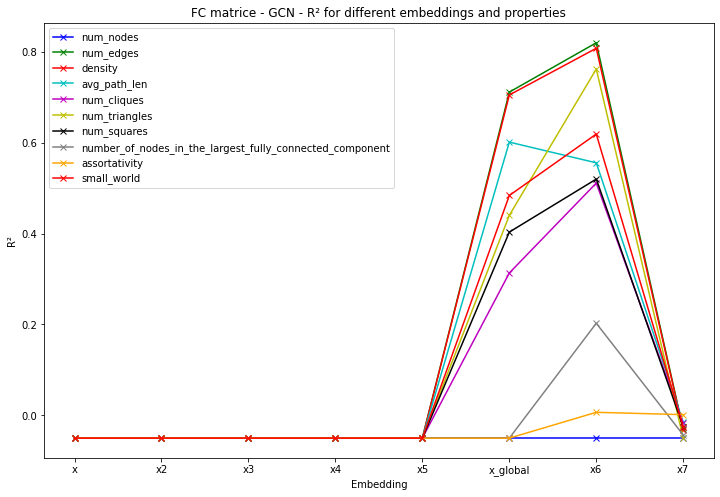

<Figure size 432x288 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt

# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component','assortativity', 'small_world']
embeddings_names = ['x', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'grey', 'orange', 'red']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_name)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save
plt.savefig("results/"+DATASET+"_"+MODEL+"test_R2.png")


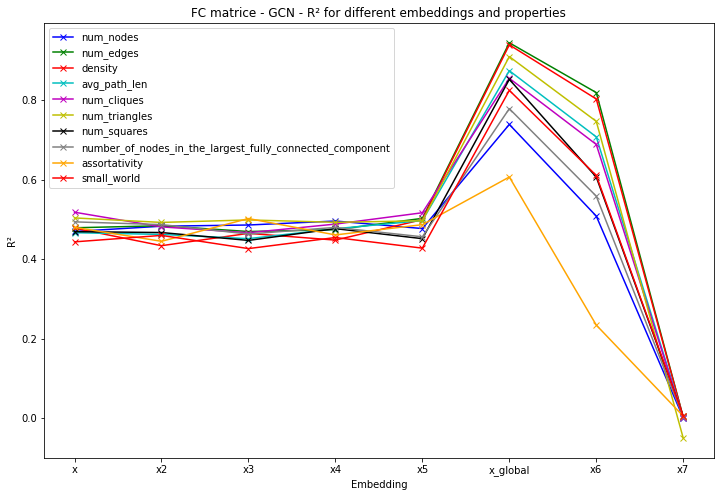

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt

# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component','assortativity', 'small_world']
embeddings_names = ['x', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'grey', 'orange', 'red']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        train_r2 = results[(name_of_embedding, property_name)][2]
        if train_r2 < -0.05:  # Handle negative R² values
            train_r2 = -0.05
        x_points.append(j)
        y_points.append(train_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+'_'+MODEL+'train_R2.png')


#### Test with more properties

In [24]:
import networkx as nx
import numpy as np

def calculate_avg_path_length(G):
    if nx.is_connected(G):
        return nx.average_shortest_path_length(G)
    else:
        # Use the average path length of the largest connected component for disconnected graphs
        components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
        largest_component = max(components, key=len)
        return nx.average_shortest_path_length(largest_component)
    
   
def compute_swi(graph):
    # Calculate clustering coefficient and average path length for the given graph
    clustering_coeff = nx.average_clustering(graph)
    avg_path_len = calculate_avg_path_length(graph)
    
    # Generate a random graph with the same number of nodes and edges
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    random_graph = nx.gnm_random_graph(num_nodes, num_edges)
    
    # Generate a lattice graph with the same number of nodes and edges
    lattice_graph = nx.watts_strogatz_graph(num_nodes, k=4, p=0)  # Adjust k as needed
    
    # Calculate clustering coefficient and average path length for the random graph
    random_clustering_coeff = nx.average_clustering(random_graph)
    random_avg_path_len = calculate_avg_path_length(random_graph)
    
    # Calculate clustering coefficient and average path length for the lattice graph
    lattice_clustering_coeff = nx.average_clustering(lattice_graph)
    lattice_avg_path_len = calculate_avg_path_length(lattice_graph)
    
    # Compute the Small-World Index (SWI)
    swi = ((avg_path_len - lattice_avg_path_len) / (random_avg_path_len - lattice_avg_path_len)) * \
          ((clustering_coeff - random_clustering_coeff) / (lattice_clustering_coeff - random_clustering_coeff))
    
    return swi


def betweenness_centralization(G):
    n = len(G)
    betweenness = nx.betweenness_centrality(G)
    max_betweenness = max(betweenness.values())
    centralization = sum(max_betweenness - bet for bet in betweenness.values())
    if n > 2:
        centralization /= (n - 1) * (n - 2) / 2
    return centralization

def pagerank_centralization(G, alpha=0.85):
    n = len(G)
    pagerank = nx.pagerank(G, alpha=alpha)
    max_pagerank = max(pagerank.values())
    centralization = sum(max_pagerank - pr for pr in pagerank.values())
    if n > 1:
        centralization /= (n - 1)
    return centralization

def clustering_properties(G):
    average_clustering = nx.average_clustering(G)
    transitivity = nx.transitivity(G)
    return average_clustering, transitivity

def compute_graph_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        
        # Number of nodes
        num_nodes = G.number_of_nodes()
        
        # Number of edges
        num_edges = G.number_of_edges()
        
        # Density
        density = nx.density(G)
        
        # Average Path Length
        avg_path_len = calculate_avg_path_length(G)
        
        # Diameter
        if nx.is_connected(G):
            diameter = nx.diameter(G)
        else:
            # Use the diameter of the largest connected component for disconnected graphs
            components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
            largest_component = max(components, key=len)
            diameter = nx.diameter(largest_component)
        
        # Radius
        if nx.is_connected(G):
            radius = nx.radius(G)
        else:
            radius = nx.radius(largest_component)
        
        # Clustering Coefficient
        clustering_coeff = nx.average_clustering(G)
        
        # Transitivity
        transitivity = nx.transitivity(G)
        
        # Assortativity
        assortativity = nx.degree_assortativity_coefficient(G)
        
        # Number of Cliques
        num_cliques = len(list(nx.find_cliques(G)))
        
        # Number of Triangles
        num_triangles = sum(nx.triangles(G).values()) / 3
        
        # Number of Squares (4-cycles)
        num_squares = sum(nx.square_clustering(G).values()) / 4
        
        # Size of the Largest Connected Component
        largest_component_size = len(max(nx.connected_components(G), key=len))
        
        # Average Degree
        degrees = [d for n, d in G.degree()]
        avg_degree = np.mean(degrees)
        
        # Betweenness Centrality
        betweenness_centrality = nx.betweenness_centrality(G)
        avg_betweenness_centrality = np.mean(list(betweenness_centrality.values()))
        
        # Eigenvalues of the Adjacency Matrix (for spectral properties)
        eigenvalues = np.linalg.eigvals(nx.adjacency_matrix(G).todense())
        spectral_radius = max(eigenvalues)
        algebraic_connectivity = sorted(eigenvalues)[1]  # second smallest eigenvalue
        
        # Graph Laplacian Eigenvalues
        laplacian_eigenvalues = np.linalg.eigvals(nx.laplacian_matrix(G).todense())
        graph_energy = sum(abs(laplacian_eigenvalues))
        
        # Small-World-ness
        # Compare clustering coefficient and average path length with those of a random graph
        random_graph = nx.gnm_random_graph(num_nodes, num_edges)
        random_clustering_coeff = nx.average_clustering(random_graph)
        random_avg_path_len = calculate_avg_path_length(random_graph)
        small_world_coefficient = (clustering_coeff / random_clustering_coeff) / (avg_path_len / random_avg_path_len)

        small_world_index = compute_swi(G)

        # Calculate Betweenness Centralization
        betweenness_cent = betweenness_centralization(G)
        print(f"Betweenness Centralization: {betweenness_cent}")

        # Calculate PageRank Centralization
        pagerank_cent = pagerank_centralization(G)
        print(f"PageRank Centralization: {pagerank_cent}")

        # Calculate Clustering properties
        avg_clustering, transitivity = clustering_properties(G)
        print(f"Average Clustering Coefficient: {avg_clustering}")
        print(f"Transitivity: {transitivity}")
        
        properties.append((
            num_nodes,
            num_edges,
            density,
            avg_path_len,
            diameter,
            radius,
            clustering_coeff,
            transitivity,
            assortativity,
            num_cliques,
            num_triangles,
            num_squares,
            largest_component_size,
            avg_degree,
            avg_betweenness_centrality,
            spectral_radius,
            algebraic_connectivity,
            graph_energy,
            small_world_coefficient, 
            betweenness_cent,
            pagerank_cent,
            avg_clustering,
            small_world_index           

        ))
    return properties


train_idx_list = gnn.train_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in train_idx_list]
train_properties_long = compute_graph_properties(selected_dataset)
test_idx_list = gnn.test_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in test_idx_list]
test_properties_long = compute_graph_properties(selected_dataset)

#save the properties in a file
with open("results/"+DATASET+"_"+MODEL+"_train_properties_long.pkl", "wb") as f:
    pkl.dump(train_properties_long, f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_long.pkl", "wb") as f:
    pkl.dump(test_properties_long, f)



Betweenness Centralization: 0.001086061741981193
PageRank Centralization: 0.009889108225082894
Average Clustering Coefficient: 0.5179222969842621
Transitivity: 0.5032389055399787
Betweenness Centralization: 0.0018289913557221417
PageRank Centralization: 0.006459017297712483
Average Clustering Coefficient: 0.5087813738549032
Transitivity: 0.5213549337260678
Betweenness Centralization: 0.00045402843483595716
PageRank Centralization: 0.005046367337979484
Average Clustering Coefficient: 0.5414121000696618
Transitivity: 0.5641200188511285
Betweenness Centralization: 0.0010550665108438862
PageRank Centralization: 0.006308393987013973
Average Clustering Coefficient: 0.6576803843183981
Transitivity: 0.6348624992240363
Betweenness Centralization: 0.001264968108251676
PageRank Centralization: 0.007700201326596413
Average Clustering Coefficient: 0.4949392448885353
Transitivity: 0.5178428227746592
Betweenness Centralization: 0.0018431551231994504
PageRank Centralization: 0.009662184686628855
Avera

Betweenness Centralization: 0.004258771004745923
PageRank Centralization: 0.009026828039776977
Average Clustering Coefficient: 0.5324696244214352
Transitivity: 0.5881116781747223
Betweenness Centralization: 0.002249934020676841
PageRank Centralization: 0.006958093193469958
Average Clustering Coefficient: 0.5176604904495603
Transitivity: 0.5891551584077985
Betweenness Centralization: 0.0038523338856805292
PageRank Centralization: 0.009673819947146852
Average Clustering Coefficient: 0.39826718735809646
Transitivity: 0.5340035481963336
Betweenness Centralization: 0.0009415571619398711
PageRank Centralization: 0.006841847000195802
Average Clustering Coefficient: 0.441488221549468
Transitivity: 0.4850266397207422
Betweenness Centralization: 0.001708176235729968
PageRank Centralization: 0.006499278216215807
Average Clustering Coefficient: 0.5792587107642506
Transitivity: 0.6022845275181724
Betweenness Centralization: 0.0013510997350773552
PageRank Centralization: 0.008786855049144855
Average

Betweenness Centralization: 0.0019646400406334924
PageRank Centralization: 0.009815187832223564
Average Clustering Coefficient: 0.44459521282175735
Transitivity: 0.4245038826574633
Betweenness Centralization: 0.0022671691216563806
PageRank Centralization: 0.007768459025854732
Average Clustering Coefficient: 0.577849554876937
Transitivity: 0.5667556742323098
Betweenness Centralization: 0.001454267042670509
PageRank Centralization: 0.006001335474472275
Average Clustering Coefficient: 0.5460483818540083
Transitivity: 0.5746121297602257
Betweenness Centralization: 0.0014496068652510448
PageRank Centralization: 0.008681186183223458
Average Clustering Coefficient: 0.5584861537502397
Transitivity: 0.5778382053025153
Betweenness Centralization: 0.002007966387081847
PageRank Centralization: 0.006671939099817724
Average Clustering Coefficient: 0.48545362139991277
Transitivity: 0.5018324607329843
Betweenness Centralization: 0.0017584473673798293
PageRank Centralization: 0.0073635679264833975
Aver

PageRank Centralization: 0.011004399543414627
Average Clustering Coefficient: 0.4854814340218046
Transitivity: 0.4893560404470463
Betweenness Centralization: 0.0027119481097196917
PageRank Centralization: 0.007852615374744727
Average Clustering Coefficient: 0.5428112510914471
Transitivity: 0.5493345571363011
Betweenness Centralization: 0.0009129282512773135
PageRank Centralization: 0.006697696068120426
Average Clustering Coefficient: 0.5043614512796099
Transitivity: 0.5077755240027045
Betweenness Centralization: 0.0017956453412381632
PageRank Centralization: 0.009108386013990149
Average Clustering Coefficient: 0.5332475819111081
Transitivity: 0.5324466865397844
Betweenness Centralization: 0.0014673091251938282
PageRank Centralization: 0.010418666312293743
Average Clustering Coefficient: 0.45601639118218884
Transitivity: 0.4508833922261484
Betweenness Centralization: 0.001344188359494869
PageRank Centralization: 0.009310369122357299
Average Clustering Coefficient: 0.5394155159259717
Tra

Betweenness Centralization: 0.0015358865503090416
PageRank Centralization: 0.008083734996704912
Average Clustering Coefficient: 0.49142522439197645
Transitivity: 0.4912559618441971
Betweenness Centralization: 0.0014614971031362304
PageRank Centralization: 0.006832784683340629
Average Clustering Coefficient: 0.5006335554710165
Transitivity: 0.4737650371128743
Betweenness Centralization: 0.0030607172896678944
PageRank Centralization: 0.00747488219880637
Average Clustering Coefficient: 0.551372570399119
Transitivity: 0.6035196687370601
Betweenness Centralization: 0.0018904785148743163
PageRank Centralization: 0.008244167735453955
Average Clustering Coefficient: 0.4937877510139175
Transitivity: 0.47336531178995206
Betweenness Centralization: 0.0005971837392109634
PageRank Centralization: 0.006703150237079214
Average Clustering Coefficient: 0.4771392380310655
Transitivity: 0.5351647396331392
Betweenness Centralization: 0.002080298906700507
PageRank Centralization: 0.008982191184123335
Avera

Betweenness Centralization: 0.0015200004379776683
PageRank Centralization: 0.006470081241039484
Average Clustering Coefficient: 0.6031669755427123
Transitivity: 0.6513464526152253
Betweenness Centralization: 0.0018130422210154533
PageRank Centralization: 0.005157848707737996
Average Clustering Coefficient: 0.5149069321483113
Transitivity: 0.5604558969276512
Betweenness Centralization: 0.0006455590906807535
PageRank Centralization: 0.00616522977321775
Average Clustering Coefficient: 0.4781515197997262
Transitivity: 0.5141950273320403
Betweenness Centralization: 0.0018203673654359255
PageRank Centralization: 0.007147031697340111
Average Clustering Coefficient: 0.4969713912411682
Transitivity: 0.4693569270608546
Betweenness Centralization: 0.0016494146200354827
PageRank Centralization: 0.007833006151079805
Average Clustering Coefficient: 0.5417520622019766
Transitivity: 0.5177895533686601
Betweenness Centralization: 0.0016024607162301034
PageRank Centralization: 0.008011892746391053
Avera

Betweenness Centralization: 0.0016727926006398239
PageRank Centralization: 0.007130051843017557
Average Clustering Coefficient: 0.5039580283314299
Transitivity: 0.46647074539139727
Betweenness Centralization: 0.001592633041423766
PageRank Centralization: 0.009374280747694832
Average Clustering Coefficient: 0.49013791250823097
Transitivity: 0.5039941902687001
Betweenness Centralization: 0.0019990607092797534
PageRank Centralization: 0.009086038752596925
Average Clustering Coefficient: 0.4834517458282435
Transitivity: 0.553635474404956
Betweenness Centralization: 0.0012574010986898252
PageRank Centralization: 0.0070333742764222065
Average Clustering Coefficient: 0.44748232018052975
Transitivity: 0.45867768595041325
Betweenness Centralization: 0.0019304196654361069
PageRank Centralization: 0.008855875161050865
Average Clustering Coefficient: 0.49138375288223146
Transitivity: 0.4895833333333333
Betweenness Centralization: 0.0017669554093425939
PageRank Centralization: 0.007219000002810857


Betweenness Centralization: 0.0018495345019569982
PageRank Centralization: 0.007231102554179702
Average Clustering Coefficient: 0.4830656598303658
Transitivity: 0.5034535686876439
Betweenness Centralization: 0.0015748727935459752
PageRank Centralization: 0.007981320925282734
Average Clustering Coefficient: 0.5212184008091936
Transitivity: 0.5882352941176471
Betweenness Centralization: 0.0016211757148801684
PageRank Centralization: 0.011867452767276
Average Clustering Coefficient: 0.41886804835721253
Transitivity: 0.46268163804491413
Betweenness Centralization: 0.0017726197089032534
PageRank Centralization: 0.0057720408657632935
Average Clustering Coefficient: 0.5476128676119623
Transitivity: 0.5542057308860425
Betweenness Centralization: 0.0017956013103569701
PageRank Centralization: 0.00992834227923277
Average Clustering Coefficient: 0.4978453976737729
Transitivity: 0.5060670949321913
Betweenness Centralization: 0.0029431207085140907
PageRank Centralization: 0.007500776793950888
Avera

Betweenness Centralization: 0.0015345612953758237
PageRank Centralization: 0.00640345146968126
Average Clustering Coefficient: 0.5095312733243768
Transitivity: 0.4897482481183493
Betweenness Centralization: 0.001936943554753576
PageRank Centralization: 0.008054075640284503
Average Clustering Coefficient: 0.5168454423505751
Transitivity: 0.555079559363525
Betweenness Centralization: 0.00103623867046775
PageRank Centralization: 0.00796726535299168
Average Clustering Coefficient: 0.4711529801467881
Transitivity: 0.5036107943747624
Betweenness Centralization: 0.0006421228714372103
PageRank Centralization: 0.006547220929718533
Average Clustering Coefficient: 0.5210329653446675
Transitivity: 0.5526440410418311
Betweenness Centralization: 0.0022303841592928694
PageRank Centralization: 0.009727279175440692
Average Clustering Coefficient: 0.6153324922737486
Transitivity: 0.6393103448275862
Betweenness Centralization: 0.0012331573811127647
PageRank Centralization: 0.009096088071027015
Average Cl

Betweenness Centralization: 0.0020047217453140484
PageRank Centralization: 0.006941542022416571
Average Clustering Coefficient: 0.5519625677734799
Transitivity: 0.5649628783552256
Betweenness Centralization: 0.0016618427655790786
PageRank Centralization: 0.011658944035218088
Average Clustering Coefficient: 0.46323255288772514
Transitivity: 0.4585430463576159
Betweenness Centralization: 0.0013568976497225782
PageRank Centralization: 0.007852949061876299
Average Clustering Coefficient: 0.5269722322740896
Transitivity: 0.48033946251768034
Betweenness Centralization: 0.0018043381772499792
PageRank Centralization: 0.006687627140011902
Average Clustering Coefficient: 0.6005786255445925
Transitivity: 0.6189836579359749
Betweenness Centralization: 0.0016874067762550347
PageRank Centralization: 0.00756481856398947
Average Clustering Coefficient: 0.4601165850151652
Transitivity: 0.5204013377926422
Betweenness Centralization: 0.0015758687388136778
PageRank Centralization: 0.008527095347658034
Ave

PageRank Centralization: 0.006512054056669915
Average Clustering Coefficient: 0.429871191610322
Transitivity: 0.44866920152091255
Betweenness Centralization: 0.002166448466977857
PageRank Centralization: 0.012363938786993142
Average Clustering Coefficient: 0.4499598841704104
Transitivity: 0.5199034981905911
Betweenness Centralization: 0.001476779209203863
PageRank Centralization: 0.009662409178433053
Average Clustering Coefficient: 0.5139705497320518
Transitivity: 0.5343243243243243
Betweenness Centralization: 0.0009467499795467532
PageRank Centralization: 0.007364803466579613
Average Clustering Coefficient: 0.4963897469415515
Transitivity: 0.490768094534712
Betweenness Centralization: 0.0035709011754109427
PageRank Centralization: 0.00891081020811883
Average Clustering Coefficient: 0.4804955622293085
Transitivity: 0.5050970075633016
Betweenness Centralization: 0.0018024012079577015
PageRank Centralization: 0.006656257847392205
Average Clustering Coefficient: 0.464207821164343
Transiti

Betweenness Centralization: 0.001018302963611375
PageRank Centralization: 0.007385028760633754
Average Clustering Coefficient: 0.5243987761881871
Transitivity: 0.5267039371951945
Betweenness Centralization: 0.002188966892401363
PageRank Centralization: 0.00802733408806463
Average Clustering Coefficient: 0.656045504344068
Transitivity: 0.7279994133176885
Betweenness Centralization: 0.0010670810856481037
PageRank Centralization: 0.005905916061330542
Average Clustering Coefficient: 0.5033906376738927
Transitivity: 0.5243520721171905
Betweenness Centralization: 0.0018235079791928334
PageRank Centralization: 0.005867179288039859
Average Clustering Coefficient: 0.5370765869244573
Transitivity: 0.6867549668874172
Betweenness Centralization: 0.0017345548870816641
PageRank Centralization: 0.008204686451480954
Average Clustering Coefficient: 0.47970082655681023
Transitivity: 0.4447646493756004
Betweenness Centralization: 0.00250580808197654
PageRank Centralization: 0.007212686835546926
Average C

Betweenness Centralization: 0.002448352948435025
PageRank Centralization: 0.006044007911669378
Average Clustering Coefficient: 0.44855068303344164
Transitivity: 0.4889240506329114
Betweenness Centralization: 0.0006602760967636381
PageRank Centralization: 0.006693242762558686
Average Clustering Coefficient: 0.48387928838860894
Transitivity: 0.47266187050359715
Betweenness Centralization: 0.0010782291100841493
PageRank Centralization: 0.005682465079451831
Average Clustering Coefficient: 0.464354553828238
Transitivity: 0.45079212674027846
Betweenness Centralization: 0.0012766992639819798
PageRank Centralization: 0.006087697078168115
Average Clustering Coefficient: 0.5834889804710776
Transitivity: 0.5533357117374242
Betweenness Centralization: 0.005368328038112794
PageRank Centralization: 0.00905071818722414
Average Clustering Coefficient: 0.46943647915870124
Transitivity: 0.5007407407407407
Betweenness Centralization: 0.0016796192371994472
PageRank Centralization: 0.008132492231621349
Ave

Betweenness Centralization: 0.0019008418774981368
PageRank Centralization: 0.010101013782394962
Average Clustering Coefficient: 0.4796746466285359
Transitivity: 0.548053024026512
Betweenness Centralization: 0.0009683602352623171
PageRank Centralization: 0.007370280011349335
Average Clustering Coefficient: 0.5537317091534062
Transitivity: 0.5552259776754351
Betweenness Centralization: 0.001535782080175506
PageRank Centralization: 0.007192898491409675
Average Clustering Coefficient: 0.4778548080272217
Transitivity: 0.49097938144329895
Betweenness Centralization: 0.0022431309544469875
PageRank Centralization: 0.006179704601955734
Average Clustering Coefficient: 0.45040954782642767
Transitivity: 0.5249758298420883
Betweenness Centralization: 0.0014274215640062023
PageRank Centralization: 0.007139357880555097
Average Clustering Coefficient: 0.5462399240918535
Transitivity: 0.5782921610581598
Betweenness Centralization: 0.0016129218128364741
PageRank Centralization: 0.005492282003335041
Aver

Betweenness Centralization: 0.0014140006276267057
PageRank Centralization: 0.00868253270244115
Average Clustering Coefficient: 0.514995008930019
Transitivity: 0.5471519415505345
Betweenness Centralization: 0.001303938696969281
PageRank Centralization: 0.009908694404709444
Average Clustering Coefficient: 0.5500077757679607
Transitivity: 0.5341294612566155
Betweenness Centralization: 0.0009136370130163846
PageRank Centralization: 0.00611774754127568
Average Clustering Coefficient: 0.4800014879015627
Transitivity: 0.44190871369294604
Betweenness Centralization: 0.0015030258061776403
PageRank Centralization: 0.007073253624292686
Average Clustering Coefficient: 0.5709282159345568
Transitivity: 0.5690107419435424
Betweenness Centralization: 0.0015750738938637061
PageRank Centralization: 0.007427084239773628
Average Clustering Coefficient: 0.4646922567120441
Transitivity: 0.4879182156133829
Betweenness Centralization: 0.0012033971813378128
PageRank Centralization: 0.0059348948190293405
Averag

Betweenness Centralization: 0.0014503909849991367
PageRank Centralization: 0.006312959260137094
Average Clustering Coefficient: 0.528352729645833
Transitivity: 0.561084707855745
Betweenness Centralization: 0.0017329313552089665
PageRank Centralization: 0.0076175490600685885
Average Clustering Coefficient: 0.5564679425587247
Transitivity: 0.5620879120879121
Betweenness Centralization: 0.0010140272116990153
PageRank Centralization: 0.0077963161632797874
Average Clustering Coefficient: 0.4481297213041633
Transitivity: 0.4511023176936122
Betweenness Centralization: 0.001517288134850202
PageRank Centralization: 0.007182109183010908
Average Clustering Coefficient: 0.49532595953742004
Transitivity: 0.5301724137931034
Betweenness Centralization: 0.001179786648461483
PageRank Centralization: 0.00924624445310264
Average Clustering Coefficient: 0.47670273243903616
Transitivity: 0.5226229508196721
Betweenness Centralization: 0.002184119259521994
PageRank Centralization: 0.006629867243140498
Averag

Betweenness Centralization: 0.0017662027517470738
PageRank Centralization: 0.006726704276475471
Average Clustering Coefficient: 0.506644267103192
Transitivity: 0.5674904942965779
Betweenness Centralization: 0.0025345060416363664
PageRank Centralization: 0.008565939945849413
Average Clustering Coefficient: 0.5536799761035307
Transitivity: 0.5409591897527555
Betweenness Centralization: 0.0015939182136400058
PageRank Centralization: 0.006434630666299032
Average Clustering Coefficient: 0.5121558919366863
Transitivity: 0.5201176313327095
Betweenness Centralization: 0.002117035054150758
PageRank Centralization: 0.007880180592535903
Average Clustering Coefficient: 0.5242397169927328
Transitivity: 0.5095647708306587
Betweenness Centralization: 0.0024555874603294945
PageRank Centralization: 0.008788503396979798
Average Clustering Coefficient: 0.4827920147485363
Transitivity: 0.5101342458541721
Betweenness Centralization: 0.0008740635230066906
PageRank Centralization: 0.006237101811494439
Averag

Betweenness Centralization: 0.0007496426462014463
PageRank Centralization: 0.004943008327951781
Average Clustering Coefficient: 0.5491542327193155
Transitivity: 0.5187891440501043
Betweenness Centralization: 0.0029526085050685554
PageRank Centralization: 0.007843636044936125
Average Clustering Coefficient: 0.4617532708837058
Transitivity: 0.4855555555555556
Betweenness Centralization: 0.0009769843605539534
PageRank Centralization: 0.008182056482163979
Average Clustering Coefficient: 0.5563079302965765
Transitivity: 0.5505062978513213
Betweenness Centralization: 0.0009910484466696867
PageRank Centralization: 0.007755677286721366
Average Clustering Coefficient: 0.47503387617151377
Transitivity: 0.4823232323232323
Betweenness Centralization: 0.0015186181872339469
PageRank Centralization: 0.008957104164054487
Average Clustering Coefficient: 0.4111342934351784
Transitivity: 0.4396436525612472
Betweenness Centralization: 0.000946904100364308
PageRank Centralization: 0.005965014541061421
Aver

Betweenness Centralization: 0.0009325307002592923
PageRank Centralization: 0.006712453568058718
Average Clustering Coefficient: 0.45526297076932565
Transitivity: 0.47695075331684283
Betweenness Centralization: 0.0024375034041026014
PageRank Centralization: 0.009986899313524077
Average Clustering Coefficient: 0.4999390540719143
Transitivity: 0.5071368597816961
Betweenness Centralization: 0.0017549663565480335
PageRank Centralization: 0.0073925039206302915
Average Clustering Coefficient: 0.523273777879041
Transitivity: 0.49780775716694775
Betweenness Centralization: 0.0007539887640119349
PageRank Centralization: 0.007503926147592013
Average Clustering Coefficient: 0.48482714499715657
Transitivity: 0.4911732541790345
Betweenness Centralization: 0.0008680242720428117
PageRank Centralization: 0.008025651765772275
Average Clustering Coefficient: 0.4645239217341789
Transitivity: 0.48102643856920685
Betweenness Centralization: 0.0015210866819177985
PageRank Centralization: 0.007171731470552725

Betweenness Centralization: 0.001167216676452378
PageRank Centralization: 0.008095152673285878
Average Clustering Coefficient: 0.5044882033636496
Transitivity: 0.549078947368421
Betweenness Centralization: 0.0007104806259602472
PageRank Centralization: 0.0065801044901698
Average Clustering Coefficient: 0.5179017175446766
Transitivity: 0.539419484624964
Betweenness Centralization: 0.0014667879290022657
PageRank Centralization: 0.00733369343176361
Average Clustering Coefficient: 0.4231840284471864
Transitivity: 0.4444444444444444
Betweenness Centralization: 0.0010563725268017924
PageRank Centralization: 0.005972016159085246
Average Clustering Coefficient: 0.39276554363510885
Transitivity: 0.4111066719936077
Betweenness Centralization: 0.001344379660673526
PageRank Centralization: 0.006430121618631281
Average Clustering Coefficient: 0.532396333277665
Transitivity: 0.6209009009009009
Betweenness Centralization: 0.0014063380167544308
PageRank Centralization: 0.007603666119484385
Average Clu

Betweenness Centralization: 0.0019827908448264596
PageRank Centralization: 0.00787793940419568
Average Clustering Coefficient: 0.5213484780277082
Transitivity: 0.5637853201805718
Betweenness Centralization: 0.0027637278098189264
PageRank Centralization: 0.008855345662956872
Average Clustering Coefficient: 0.5817621190299209
Transitivity: 0.6480901690670007
Betweenness Centralization: 0.002733060160500094
PageRank Centralization: 0.008170649537504883
Average Clustering Coefficient: 0.482852123587087
Transitivity: 0.5427423981640849
Betweenness Centralization: 0.0013959119193162341
PageRank Centralization: 0.005395707412499384
Average Clustering Coefficient: 0.504624688473573
Transitivity: 0.5092336103416436
Betweenness Centralization: 0.0026711976152805775
PageRank Centralization: 0.008107131712314844
Average Clustering Coefficient: 0.5103907194871484
Transitivity: 0.5218670327515199
Betweenness Centralization: 0.0019979433026104253
PageRank Centralization: 0.006515322950923503
Average 

Betweenness Centralization: 0.002039805687773911
PageRank Centralization: 0.009752356536237633
Average Clustering Coefficient: 0.5900031517552133
Transitivity: 0.6484804977267289
Betweenness Centralization: 0.0021213743229619242
PageRank Centralization: 0.007179925832024679
Average Clustering Coefficient: 0.5051052547709696
Transitivity: 0.6038543897216274
Betweenness Centralization: 0.0022190007242275504
PageRank Centralization: 0.006726658823897593
Average Clustering Coefficient: 0.5517742381072421
Transitivity: 0.6525180681427096
Betweenness Centralization: 0.002688597541798648
PageRank Centralization: 0.00942105812219985
Average Clustering Coefficient: 0.4659134447927553
Transitivity: 0.44532409698169223
Betweenness Centralization: 0.0008405565655393671
PageRank Centralization: 0.005618805458223556
Average Clustering Coefficient: 0.5091641303917225
Transitivity: 0.496783039763738
Betweenness Centralization: 0.0022042406006814387
PageRank Centralization: 0.0068138978147756326
Averag

Betweenness Centralization: 0.0043869326505629564
PageRank Centralization: 0.010001204782289113
Average Clustering Coefficient: 0.5832852071127747
Transitivity: 0.6353080102342059
Betweenness Centralization: 0.0011765906220133967
PageRank Centralization: 0.010977766138834798
Average Clustering Coefficient: 0.42001319271207554
Transitivity: 0.47163695299837927
Betweenness Centralization: 0.0005063694783259407
PageRank Centralization: 0.005676306330661271
Average Clustering Coefficient: 0.5310075845409725
Transitivity: 0.5486468351599195
Betweenness Centralization: 0.002022639899138072
PageRank Centralization: 0.006536693489958508
Average Clustering Coefficient: 0.5938452588412995
Transitivity: 0.6086800830767027
Betweenness Centralization: 0.0014380404454004349
PageRank Centralization: 0.006873260934648456
Average Clustering Coefficient: 0.43978027939664766
Transitivity: 0.5332518337408313
Betweenness Centralization: 0.0016356601709099923
PageRank Centralization: 0.008897534207293754
Av

Betweenness Centralization: 0.0012793608560862518
PageRank Centralization: 0.007388528275369631
Average Clustering Coefficient: 0.5004140392571854
Transitivity: 0.5232488525244462
Betweenness Centralization: 0.0015305239263019483
PageRank Centralization: 0.008856395193842024
Average Clustering Coefficient: 0.46981861417922804
Transitivity: 0.4643510054844607
Betweenness Centralization: 0.0012252567342990277
PageRank Centralization: 0.0067757939997324925
Average Clustering Coefficient: 0.4360655669990709
Transitivity: 0.471326552694222
Betweenness Centralization: 0.0015329826559174562
PageRank Centralization: 0.007640800295271964
Average Clustering Coefficient: 0.5185033574452543
Transitivity: 0.5070185289163391
Betweenness Centralization: 0.0018789686766659374
PageRank Centralization: 0.006120061804078178
Average Clustering Coefficient: 0.5355409907204286
Transitivity: 0.5905868680999419
Betweenness Centralization: 0.0022958861888146315
PageRank Centralization: 0.007041441613069971
Ave

In [25]:
#load the properties
with open("results/"+DATASET+"_"+MODEL+"_train_properties_long.pkl", "rb") as f:
    train_properties_long = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_long.pkl", "rb") as f:
    test_properties_long = pkl.load(f)

In [26]:
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
train_y_long = torch.tensor(train_properties_long, dtype=torch.float32)
test_y_long = torch.tensor(test_properties_long, dtype=torch.float32)
#create a dictionary where we will store the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    input_size = train_embedding.shape[1]

    for i, property_name in enumerate(property_names_long):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 800000  # Maximum number of epochs
        min_epochs = 1000  # Minimum number of epochs
        patience = 3000  # Number of epochs to wait for improvement
        tolerance = 1e-6  # Tolerance for considering the loss as stable

        best_loss = float('inf')
        no_improve_count = 0
        
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y_long[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Print every 1000 epochs
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

            # Check for early stopping, but only after minimum epochs
            if epoch >= min_epochs:
                if loss.item() < best_loss - tolerance:
                    best_loss = loss.item()
                    no_improve_count = 0
                else:
                    no_improve_count += 1

                if no_improve_count >= patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y_long[:, i].cpu().numpy()
            test_target = test_y_long[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embedding = embeddings_names[ii]
            results[(name_of_embedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1

#save results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_long.pkl", "wb") as f:
    pkl.dump(results, f)

/scratch-local/tpelletreaudur.7490421/ipykernel_3590901/3296541069.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  train_y_long = torch.tensor(train_properties_long, dtype=torch.float32)
/scratch-local/tpelletreaudur.7490421/ipykernel_3590901/3296541069.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  test_y_long = torch.tensor(test_properties_long, dtype=torch.float32)


Epoch [1000/800000], Property: num_nodes, Loss: 7559.9868
Epoch [2000/800000], Property: num_nodes, Loss: 4431.9951
Epoch [3000/800000], Property: num_nodes, Loss: 2585.8096
Epoch [4000/800000], Property: num_nodes, Loss: 1522.6223
Epoch [5000/800000], Property: num_nodes, Loss: 937.3320
Epoch [6000/800000], Property: num_nodes, Loss: 629.4507
Epoch [7000/800000], Property: num_nodes, Loss: 460.6313
Epoch [8000/800000], Property: num_nodes, Loss: 354.8752
Epoch [9000/800000], Property: num_nodes, Loss: 280.9077
Epoch [10000/800000], Property: num_nodes, Loss: 226.1115
Epoch [11000/800000], Property: num_nodes, Loss: 184.7984
Epoch [12000/800000], Property: num_nodes, Loss: 153.7234
Epoch [13000/800000], Property: num_nodes, Loss: 130.3057
Epoch [14000/800000], Property: num_nodes, Loss: 112.3682
Epoch [15000/800000], Property: num_nodes, Loss: 98.4020
Epoch [16000/800000], Property: num_nodes, Loss: 87.4714
Epoch [17000/800000], Property: num_nodes, Loss: 78.9658
Epoch [18000/800000], 

Epoch [6000/800000], Property: num_edges, Loss: 145247.9219
Epoch [7000/800000], Property: num_edges, Loss: 129454.4375
Epoch [8000/800000], Property: num_edges, Loss: 115329.8203
Epoch [9000/800000], Property: num_edges, Loss: 102731.5391
Epoch [10000/800000], Property: num_edges, Loss: 91524.2578
Epoch [11000/800000], Property: num_edges, Loss: 81588.7031
Epoch [12000/800000], Property: num_edges, Loss: 72803.5625
Epoch [13000/800000], Property: num_edges, Loss: 65059.9375
Epoch [14000/800000], Property: num_edges, Loss: 58280.2773
Epoch [15000/800000], Property: num_edges, Loss: 52397.6211
Epoch [16000/800000], Property: num_edges, Loss: 47338.1992
Epoch [17000/800000], Property: num_edges, Loss: 43023.0117
Epoch [18000/800000], Property: num_edges, Loss: 39376.7773
Epoch [19000/800000], Property: num_edges, Loss: 36319.4414
Epoch [20000/800000], Property: num_edges, Loss: 33768.7773
Epoch [21000/800000], Property: num_edges, Loss: 31644.0586
Epoch [22000/800000], Property: num_edge

Epoch [142000/800000], Property: num_edges, Loss: 12187.0430
Epoch [143000/800000], Property: num_edges, Loss: 12176.4355
Epoch [144000/800000], Property: num_edges, Loss: 12166.0518
Epoch [145000/800000], Property: num_edges, Loss: 12155.8887
Epoch [146000/800000], Property: num_edges, Loss: 12145.9414
Epoch [147000/800000], Property: num_edges, Loss: 12136.1973
Epoch [148000/800000], Property: num_edges, Loss: 12126.6504
Epoch [149000/800000], Property: num_edges, Loss: 12117.2910
Epoch [150000/800000], Property: num_edges, Loss: 12108.1182
Epoch [151000/800000], Property: num_edges, Loss: 12099.1211
Epoch [152000/800000], Property: num_edges, Loss: 12090.2891
Epoch [153000/800000], Property: num_edges, Loss: 12081.6191
Epoch [154000/800000], Property: num_edges, Loss: 12073.1045
Epoch [155000/800000], Property: num_edges, Loss: 12064.7402
Epoch [156000/800000], Property: num_edges, Loss: 12056.5166
Epoch [157000/800000], Property: num_edges, Loss: 12048.4277
Epoch [158000/800000], P

Epoch [277000/800000], Property: num_edges, Loss: 11504.3887
Epoch [278000/800000], Property: num_edges, Loss: 11501.2607
Epoch [279000/800000], Property: num_edges, Loss: 11498.1445
Epoch [280000/800000], Property: num_edges, Loss: 11495.0381
Epoch [281000/800000], Property: num_edges, Loss: 11491.9414
Epoch [282000/800000], Property: num_edges, Loss: 11488.8584
Epoch [283000/800000], Property: num_edges, Loss: 11485.7871
Epoch [284000/800000], Property: num_edges, Loss: 11482.7256
Epoch [285000/800000], Property: num_edges, Loss: 11479.6768
Epoch [286000/800000], Property: num_edges, Loss: 11476.6348
Epoch [287000/800000], Property: num_edges, Loss: 11473.6084
Epoch [288000/800000], Property: num_edges, Loss: 11470.5928
Epoch [289000/800000], Property: num_edges, Loss: 11467.5869
Epoch [290000/800000], Property: num_edges, Loss: 11464.5898
Epoch [291000/800000], Property: num_edges, Loss: 11461.6074
Epoch [292000/800000], Property: num_edges, Loss: 11458.6377
Epoch [293000/800000], P

Epoch [412000/800000], Property: num_edges, Loss: 11182.8926
Epoch [413000/800000], Property: num_edges, Loss: 11181.2695
Epoch [414000/800000], Property: num_edges, Loss: 11179.6582
Epoch [415000/800000], Property: num_edges, Loss: 11178.0557
Epoch [416000/800000], Property: num_edges, Loss: 11176.4658
Epoch [417000/800000], Property: num_edges, Loss: 11174.8857
Epoch [418000/800000], Property: num_edges, Loss: 11173.3203
Epoch [419000/800000], Property: num_edges, Loss: 11171.7617
Epoch [420000/800000], Property: num_edges, Loss: 11170.2158
Epoch [421000/800000], Property: num_edges, Loss: 11168.6816
Epoch [422000/800000], Property: num_edges, Loss: 11167.1592
Epoch [423000/800000], Property: num_edges, Loss: 11165.6465
Epoch [424000/800000], Property: num_edges, Loss: 11164.1465
Epoch [425000/800000], Property: num_edges, Loss: 11162.6553
Epoch [426000/800000], Property: num_edges, Loss: 11161.1758
Epoch [427000/800000], Property: num_edges, Loss: 11159.7109
Epoch [428000/800000], P

Epoch [547000/800000], Property: num_edges, Loss: 11065.0244
Epoch [548000/800000], Property: num_edges, Loss: 11064.8789
Epoch [549000/800000], Property: num_edges, Loss: 11064.7441
Epoch [550000/800000], Property: num_edges, Loss: 11064.6201
Epoch [551000/800000], Property: num_edges, Loss: 11064.5029
Epoch [552000/800000], Property: num_edges, Loss: 11064.3945
Epoch [553000/800000], Property: num_edges, Loss: 11064.2969
Epoch [554000/800000], Property: num_edges, Loss: 11064.2090
Epoch [555000/800000], Property: num_edges, Loss: 11064.1318
Epoch [556000/800000], Property: num_edges, Loss: 11064.0664
Epoch [557000/800000], Property: num_edges, Loss: 11064.0098
Epoch [558000/800000], Property: num_edges, Loss: 11063.9600
Epoch [559000/800000], Property: num_edges, Loss: 11063.9180
Epoch [560000/800000], Property: num_edges, Loss: 11063.8867
Epoch [561000/800000], Property: num_edges, Loss: 11063.8643
Epoch [562000/800000], Property: num_edges, Loss: 11063.8467
Epoch [563000/800000], P

Epoch [3000/800000], Property: assortativity, Loss: 0.0066
Epoch [4000/800000], Property: assortativity, Loss: 0.0065
Epoch [5000/800000], Property: assortativity, Loss: 0.0064
Epoch [6000/800000], Property: assortativity, Loss: 0.0064
Epoch [7000/800000], Property: assortativity, Loss: 0.0064
Epoch [8000/800000], Property: assortativity, Loss: 0.0064
Epoch [9000/800000], Property: assortativity, Loss: 0.0064
Epoch [10000/800000], Property: assortativity, Loss: 0.0064
Early stopping at epoch 10818
Embedding: torch.Size([1044, 512])
Property: assortativity
  Train MSE: 0.0064, Test MSE: 0.1286
  Train R²: 0.4802, Test R²: -11.6407
Epoch [1000/800000], Property: num_cliques, Loss: 16873.9805
Epoch [2000/800000], Property: num_cliques, Loss: 11647.1357
Epoch [3000/800000], Property: num_cliques, Loss: 8093.9619
Epoch [4000/800000], Property: num_cliques, Loss: 5679.1152
Epoch [5000/800000], Property: num_cliques, Loss: 4062.0562
Epoch [6000/800000], Property: num_cliques, Loss: 3010.5332


Epoch [127000/800000], Property: num_cliques, Loss: 524.9294
Epoch [128000/800000], Property: num_cliques, Loss: 524.4979
Epoch [129000/800000], Property: num_cliques, Loss: 524.0768
Epoch [130000/800000], Property: num_cliques, Loss: 523.6663
Epoch [131000/800000], Property: num_cliques, Loss: 523.2662
Epoch [132000/800000], Property: num_cliques, Loss: 522.8767
Epoch [133000/800000], Property: num_cliques, Loss: 522.4997
Epoch [134000/800000], Property: num_cliques, Loss: 522.1339
Epoch [135000/800000], Property: num_cliques, Loss: 521.7784
Epoch [136000/800000], Property: num_cliques, Loss: 521.4316
Epoch [137000/800000], Property: num_cliques, Loss: 521.0948
Epoch [138000/800000], Property: num_cliques, Loss: 520.7728
Epoch [139000/800000], Property: num_cliques, Loss: 520.4608
Epoch [140000/800000], Property: num_cliques, Loss: 520.1592
Epoch [141000/800000], Property: num_cliques, Loss: 519.8676
Epoch [142000/800000], Property: num_cliques, Loss: 519.5864
Epoch [143000/800000], P

Epoch [77000/800000], Property: num_triangles, Loss: 461036.4375
Epoch [78000/800000], Property: num_triangles, Loss: 459381.3750
Epoch [79000/800000], Property: num_triangles, Loss: 457756.8125
Epoch [80000/800000], Property: num_triangles, Loss: 456160.9688
Epoch [81000/800000], Property: num_triangles, Loss: 454592.2188
Epoch [82000/800000], Property: num_triangles, Loss: 453049.2500
Epoch [83000/800000], Property: num_triangles, Loss: 451531.4375
Epoch [84000/800000], Property: num_triangles, Loss: 450038.2500
Epoch [85000/800000], Property: num_triangles, Loss: 448568.8750
Epoch [86000/800000], Property: num_triangles, Loss: 447122.4062
Epoch [87000/800000], Property: num_triangles, Loss: 445698.1875
Epoch [88000/800000], Property: num_triangles, Loss: 444294.8438
Epoch [89000/800000], Property: num_triangles, Loss: 442911.6562
Epoch [90000/800000], Property: num_triangles, Loss: 441547.7188
Epoch [91000/800000], Property: num_triangles, Loss: 440202.4688
Epoch [92000/800000], Pro

Epoch [202000/800000], Property: num_triangles, Loss: 355140.9062
Epoch [203000/800000], Property: num_triangles, Loss: 354697.0625
Epoch [204000/800000], Property: num_triangles, Loss: 354256.4375
Epoch [205000/800000], Property: num_triangles, Loss: 353818.9688
Epoch [206000/800000], Property: num_triangles, Loss: 353384.7500
Epoch [207000/800000], Property: num_triangles, Loss: 352953.7188
Epoch [208000/800000], Property: num_triangles, Loss: 352526.0312
Epoch [209000/800000], Property: num_triangles, Loss: 352101.5312
Epoch [210000/800000], Property: num_triangles, Loss: 351680.1250
Epoch [211000/800000], Property: num_triangles, Loss: 351261.8438
Epoch [212000/800000], Property: num_triangles, Loss: 350846.6250
Epoch [213000/800000], Property: num_triangles, Loss: 350434.4062
Epoch [214000/800000], Property: num_triangles, Loss: 350025.1875
Epoch [215000/800000], Property: num_triangles, Loss: 349618.7812
Epoch [216000/800000], Property: num_triangles, Loss: 349215.2188
Epoch [217

Epoch [327000/800000], Property: num_triangles, Loss: 317958.9062
Epoch [328000/800000], Property: num_triangles, Loss: 317764.1250
Epoch [329000/800000], Property: num_triangles, Loss: 317570.5312
Epoch [330000/800000], Property: num_triangles, Loss: 317377.8750
Epoch [331000/800000], Property: num_triangles, Loss: 317186.2188
Epoch [332000/800000], Property: num_triangles, Loss: 316995.6875
Epoch [333000/800000], Property: num_triangles, Loss: 316806.1562
Epoch [334000/800000], Property: num_triangles, Loss: 316617.7188
Epoch [335000/800000], Property: num_triangles, Loss: 316430.3125
Epoch [336000/800000], Property: num_triangles, Loss: 316243.9062
Epoch [337000/800000], Property: num_triangles, Loss: 316058.6250
Epoch [338000/800000], Property: num_triangles, Loss: 315874.3438
Epoch [339000/800000], Property: num_triangles, Loss: 315691.0938
Epoch [340000/800000], Property: num_triangles, Loss: 315508.8750
Epoch [341000/800000], Property: num_triangles, Loss: 315327.5938
Epoch [342

Epoch [452000/800000], Property: num_triangles, Loss: 300546.4375
Epoch [453000/800000], Property: num_triangles, Loss: 300453.1562
Epoch [454000/800000], Property: num_triangles, Loss: 300360.4375
Epoch [455000/800000], Property: num_triangles, Loss: 300268.3125
Epoch [456000/800000], Property: num_triangles, Loss: 300176.8438
Epoch [457000/800000], Property: num_triangles, Loss: 300085.9375
Epoch [458000/800000], Property: num_triangles, Loss: 299995.6875
Epoch [459000/800000], Property: num_triangles, Loss: 299905.9688
Epoch [460000/800000], Property: num_triangles, Loss: 299816.9062
Epoch [461000/800000], Property: num_triangles, Loss: 299728.4062
Epoch [462000/800000], Property: num_triangles, Loss: 299640.4688
Epoch [463000/800000], Property: num_triangles, Loss: 299553.2500
Epoch [464000/800000], Property: num_triangles, Loss: 299466.4375
Epoch [465000/800000], Property: num_triangles, Loss: 299380.2812
Epoch [466000/800000], Property: num_triangles, Loss: 299294.7188
Epoch [467

Epoch [577000/800000], Property: num_triangles, Loss: 292695.6562
Epoch [578000/800000], Property: num_triangles, Loss: 292656.3750
Epoch [579000/800000], Property: num_triangles, Loss: 292617.4375
Epoch [580000/800000], Property: num_triangles, Loss: 292578.7500
Epoch [581000/800000], Property: num_triangles, Loss: 292540.4062
Epoch [582000/800000], Property: num_triangles, Loss: 292502.3125
Epoch [583000/800000], Property: num_triangles, Loss: 292464.5000
Epoch [584000/800000], Property: num_triangles, Loss: 292427.0312
Epoch [585000/800000], Property: num_triangles, Loss: 292389.8125
Epoch [586000/800000], Property: num_triangles, Loss: 292352.8125
Epoch [587000/800000], Property: num_triangles, Loss: 292316.1562
Epoch [588000/800000], Property: num_triangles, Loss: 292279.7188
Epoch [589000/800000], Property: num_triangles, Loss: 292243.5625
Epoch [590000/800000], Property: num_triangles, Loss: 292207.5625
Epoch [591000/800000], Property: num_triangles, Loss: 292171.9688
Epoch [592

Epoch [702000/800000], Property: num_triangles, Loss: 289297.5938
Epoch [703000/800000], Property: num_triangles, Loss: 289278.8750
Epoch [704000/800000], Property: num_triangles, Loss: 289260.1875
Epoch [705000/800000], Property: num_triangles, Loss: 289241.6250
Epoch [706000/800000], Property: num_triangles, Loss: 289223.1562
Epoch [707000/800000], Property: num_triangles, Loss: 289204.8438
Epoch [708000/800000], Property: num_triangles, Loss: 289186.5312
Epoch [709000/800000], Property: num_triangles, Loss: 289168.4688
Epoch [710000/800000], Property: num_triangles, Loss: 289150.4688
Epoch [711000/800000], Property: num_triangles, Loss: 289132.5312
Epoch [712000/800000], Property: num_triangles, Loss: 289114.7500
Epoch [713000/800000], Property: num_triangles, Loss: 289097.0625
Epoch [714000/800000], Property: num_triangles, Loss: 289079.5312
Epoch [715000/800000], Property: num_triangles, Loss: 289062.0000
Epoch [716000/800000], Property: num_triangles, Loss: 289044.6562
Epoch [717

Epoch [1000/800000], Property: largest_component_size, Loss: 7445.8296
Epoch [2000/800000], Property: largest_component_size, Loss: 4354.5298
Epoch [3000/800000], Property: largest_component_size, Loss: 2535.4563
Epoch [4000/800000], Property: largest_component_size, Loss: 1491.2833
Epoch [5000/800000], Property: largest_component_size, Loss: 919.1240
Epoch [6000/800000], Property: largest_component_size, Loss: 619.2403
Epoch [7000/800000], Property: largest_component_size, Loss: 454.4162
Epoch [8000/800000], Property: largest_component_size, Loss: 350.6512
Epoch [9000/800000], Property: largest_component_size, Loss: 277.8383
Epoch [10000/800000], Property: largest_component_size, Loss: 223.8184
Epoch [11000/800000], Property: largest_component_size, Loss: 183.1177
Epoch [12000/800000], Property: largest_component_size, Loss: 152.5912
Epoch [13000/800000], Property: largest_component_size, Loss: 129.6561
Epoch [14000/800000], Property: largest_component_size, Loss: 112.1221
Epoch [1500

Epoch [119000/800000], Property: largest_component_size, Loss: 3.6201
Epoch [120000/800000], Property: largest_component_size, Loss: 3.5914
Epoch [121000/800000], Property: largest_component_size, Loss: 3.5704
Epoch [122000/800000], Property: largest_component_size, Loss: 3.5562
Epoch [123000/800000], Property: largest_component_size, Loss: 3.5477
Epoch [124000/800000], Property: largest_component_size, Loss: 3.5434
Epoch [125000/800000], Property: largest_component_size, Loss: 3.5417
Epoch [126000/800000], Property: largest_component_size, Loss: 3.5412
Epoch [127000/800000], Property: largest_component_size, Loss: 3.5410
Epoch [128000/800000], Property: largest_component_size, Loss: 3.5409
Epoch [129000/800000], Property: largest_component_size, Loss: 3.5409
Epoch [130000/800000], Property: largest_component_size, Loss: 3.5409
Epoch [131000/800000], Property: largest_component_size, Loss: 3.5409
Epoch [132000/800000], Property: largest_component_size, Loss: 3.5409
Epoch [133000/800000

Epoch [11000/800000], Property: graph_energy, Loss: 604747.9375
Epoch [12000/800000], Property: graph_energy, Loss: 569666.9375
Epoch [13000/800000], Property: graph_energy, Loss: 536527.2500
Epoch [14000/800000], Property: graph_energy, Loss: 505254.5312
Epoch [15000/800000], Property: graph_energy, Loss: 475761.6562
Epoch [16000/800000], Property: graph_energy, Loss: 447943.5312
Epoch [17000/800000], Property: graph_energy, Loss: 421721.5000
Epoch [18000/800000], Property: graph_energy, Loss: 397042.3125
Epoch [19000/800000], Property: graph_energy, Loss: 373840.4375
Epoch [20000/800000], Property: graph_energy, Loss: 352032.0000
Epoch [21000/800000], Property: graph_energy, Loss: 331541.7188
Epoch [22000/800000], Property: graph_energy, Loss: 312290.5000
Epoch [23000/800000], Property: graph_energy, Loss: 294213.2812
Epoch [24000/800000], Property: graph_energy, Loss: 277270.8438
Epoch [25000/800000], Property: graph_energy, Loss: 261430.3750
Epoch [26000/800000], Property: graph_en

Epoch [140000/800000], Property: graph_energy, Loss: 56964.3789
Epoch [141000/800000], Property: graph_energy, Loss: 56828.6562
Epoch [142000/800000], Property: graph_energy, Loss: 56694.9531
Epoch [143000/800000], Property: graph_energy, Loss: 56563.2500
Epoch [144000/800000], Property: graph_energy, Loss: 56433.5000
Epoch [145000/800000], Property: graph_energy, Loss: 56305.7031
Epoch [146000/800000], Property: graph_energy, Loss: 56179.8164
Epoch [147000/800000], Property: graph_energy, Loss: 56055.7969
Epoch [148000/800000], Property: graph_energy, Loss: 55933.6094
Epoch [149000/800000], Property: graph_energy, Loss: 55813.2773
Epoch [150000/800000], Property: graph_energy, Loss: 55694.7227
Epoch [151000/800000], Property: graph_energy, Loss: 55577.9414
Epoch [152000/800000], Property: graph_energy, Loss: 55462.9102
Epoch [153000/800000], Property: graph_energy, Loss: 55349.6328
Epoch [154000/800000], Property: graph_energy, Loss: 55238.0352
Epoch [155000/800000], Property: graph_e

Epoch [269000/800000], Property: graph_energy, Loss: 48992.0156
Epoch [270000/800000], Property: graph_energy, Loss: 48967.8633
Epoch [271000/800000], Property: graph_energy, Loss: 48943.9648
Epoch [272000/800000], Property: graph_energy, Loss: 48920.3320
Epoch [273000/800000], Property: graph_energy, Loss: 48896.9727
Epoch [274000/800000], Property: graph_energy, Loss: 48873.8594
Epoch [275000/800000], Property: graph_energy, Loss: 48851.0000
Epoch [276000/800000], Property: graph_energy, Loss: 48828.4062
Epoch [277000/800000], Property: graph_energy, Loss: 48806.0547
Epoch [278000/800000], Property: graph_energy, Loss: 48783.9531
Epoch [279000/800000], Property: graph_energy, Loss: 48762.0977
Epoch [280000/800000], Property: graph_energy, Loss: 48740.4844
Epoch [281000/800000], Property: graph_energy, Loss: 48719.1133
Epoch [282000/800000], Property: graph_energy, Loss: 48697.9688
Epoch [283000/800000], Property: graph_energy, Loss: 48677.0469
Epoch [284000/800000], Property: graph_e

Epoch [398000/800000], Property: graph_energy, Loss: 47107.7031
Epoch [399000/800000], Property: graph_energy, Loss: 47098.1836
Epoch [400000/800000], Property: graph_energy, Loss: 47088.6914
Epoch [401000/800000], Property: graph_energy, Loss: 47079.2539
Epoch [402000/800000], Property: graph_energy, Loss: 47069.8594
Epoch [403000/800000], Property: graph_energy, Loss: 47060.5039
Epoch [404000/800000], Property: graph_energy, Loss: 47051.2031
Epoch [405000/800000], Property: graph_energy, Loss: 47041.9297
Epoch [406000/800000], Property: graph_energy, Loss: 47032.7148
Epoch [407000/800000], Property: graph_energy, Loss: 47023.5391
Epoch [408000/800000], Property: graph_energy, Loss: 47014.4062
Epoch [409000/800000], Property: graph_energy, Loss: 47005.3203
Epoch [410000/800000], Property: graph_energy, Loss: 46996.2734
Epoch [411000/800000], Property: graph_energy, Loss: 46987.2812
Epoch [412000/800000], Property: graph_energy, Loss: 46978.3203
Epoch [413000/800000], Property: graph_e

Epoch [527000/800000], Property: graph_energy, Loss: 46134.0820
Epoch [528000/800000], Property: graph_energy, Loss: 46127.8164
Epoch [529000/800000], Property: graph_energy, Loss: 46121.5547
Epoch [530000/800000], Property: graph_energy, Loss: 46115.3008
Epoch [531000/800000], Property: graph_energy, Loss: 46109.0625
Epoch [532000/800000], Property: graph_energy, Loss: 46102.8320
Epoch [533000/800000], Property: graph_energy, Loss: 46096.6250
Epoch [534000/800000], Property: graph_energy, Loss: 46090.4062
Epoch [535000/800000], Property: graph_energy, Loss: 46084.2070
Epoch [536000/800000], Property: graph_energy, Loss: 46078.0156
Epoch [537000/800000], Property: graph_energy, Loss: 46071.8516
Epoch [538000/800000], Property: graph_energy, Loss: 46065.6797
Epoch [539000/800000], Property: graph_energy, Loss: 46059.5234
Epoch [540000/800000], Property: graph_energy, Loss: 46053.3828
Epoch [541000/800000], Property: graph_energy, Loss: 46047.2539
Epoch [542000/800000], Property: graph_e

Epoch [656000/800000], Property: graph_energy, Loss: 45411.7539
Epoch [657000/800000], Property: graph_energy, Loss: 45406.8438
Epoch [658000/800000], Property: graph_energy, Loss: 45401.9375
Epoch [659000/800000], Property: graph_energy, Loss: 45397.0391
Epoch [660000/800000], Property: graph_energy, Loss: 45392.1484
Epoch [661000/800000], Property: graph_energy, Loss: 45387.2773
Epoch [662000/800000], Property: graph_energy, Loss: 45382.4102
Epoch [663000/800000], Property: graph_energy, Loss: 45377.5508
Epoch [664000/800000], Property: graph_energy, Loss: 45372.6992
Epoch [665000/800000], Property: graph_energy, Loss: 45367.8750
Epoch [666000/800000], Property: graph_energy, Loss: 45363.0508
Epoch [667000/800000], Property: graph_energy, Loss: 45358.2383
Epoch [668000/800000], Property: graph_energy, Loss: 45353.4336
Epoch [669000/800000], Property: graph_energy, Loss: 45348.6406
Epoch [670000/800000], Property: graph_energy, Loss: 45343.8555
Epoch [671000/800000], Property: graph_e

Epoch [785000/800000], Property: graph_energy, Loss: 44863.8398
Epoch [786000/800000], Property: graph_energy, Loss: 44860.2773
Epoch [787000/800000], Property: graph_energy, Loss: 44856.7109
Epoch [788000/800000], Property: graph_energy, Loss: 44853.1758
Epoch [789000/800000], Property: graph_energy, Loss: 44849.6406
Epoch [790000/800000], Property: graph_energy, Loss: 44846.1133
Epoch [791000/800000], Property: graph_energy, Loss: 44842.6055
Epoch [792000/800000], Property: graph_energy, Loss: 44839.0977
Epoch [793000/800000], Property: graph_energy, Loss: 44835.6094
Epoch [794000/800000], Property: graph_energy, Loss: 44832.1250
Epoch [795000/800000], Property: graph_energy, Loss: 44828.6523
Epoch [796000/800000], Property: graph_energy, Loss: 44825.1914
Epoch [797000/800000], Property: graph_energy, Loss: 44821.7383
Epoch [798000/800000], Property: graph_energy, Loss: 44818.3008
Epoch [799000/800000], Property: graph_energy, Loss: 44814.8672
Epoch [800000/800000], Property: graph_e

Epoch [42000/800000], Property: num_nodes, Loss: 30.8424
Epoch [43000/800000], Property: num_nodes, Loss: 30.1087
Epoch [44000/800000], Property: num_nodes, Loss: 29.3842
Epoch [45000/800000], Property: num_nodes, Loss: 28.6688
Epoch [46000/800000], Property: num_nodes, Loss: 27.9627
Epoch [47000/800000], Property: num_nodes, Loss: 27.2654
Epoch [48000/800000], Property: num_nodes, Loss: 26.5774
Epoch [49000/800000], Property: num_nodes, Loss: 25.8985
Epoch [50000/800000], Property: num_nodes, Loss: 25.2287
Epoch [51000/800000], Property: num_nodes, Loss: 24.5682
Epoch [52000/800000], Property: num_nodes, Loss: 23.9180
Epoch [53000/800000], Property: num_nodes, Loss: 23.2778
Epoch [54000/800000], Property: num_nodes, Loss: 22.6469
Epoch [55000/800000], Property: num_nodes, Loss: 22.0251
Epoch [56000/800000], Property: num_nodes, Loss: 21.4124
Epoch [57000/800000], Property: num_nodes, Loss: 20.8087
Epoch [58000/800000], Property: num_nodes, Loss: 20.2141
Epoch [59000/800000], Property:

Epoch [46000/800000], Property: num_edges, Loss: 16132.1152
Epoch [47000/800000], Property: num_edges, Loss: 15969.7148
Epoch [48000/800000], Property: num_edges, Loss: 15814.1934
Epoch [49000/800000], Property: num_edges, Loss: 15665.2168
Epoch [50000/800000], Property: num_edges, Loss: 15522.4258
Epoch [51000/800000], Property: num_edges, Loss: 15385.4238
Epoch [52000/800000], Property: num_edges, Loss: 15253.8359
Epoch [53000/800000], Property: num_edges, Loss: 15127.3506
Epoch [54000/800000], Property: num_edges, Loss: 15005.6250
Epoch [55000/800000], Property: num_edges, Loss: 14888.3076
Epoch [56000/800000], Property: num_edges, Loss: 14775.1777
Epoch [57000/800000], Property: num_edges, Loss: 14666.0938
Epoch [58000/800000], Property: num_edges, Loss: 14560.9277
Epoch [59000/800000], Property: num_edges, Loss: 14459.5439
Epoch [60000/800000], Property: num_edges, Loss: 14361.8398
Epoch [61000/800000], Property: num_edges, Loss: 14267.6943
Epoch [62000/800000], Property: num_edge

Epoch [182000/800000], Property: num_edges, Loss: 11428.4219
Epoch [183000/800000], Property: num_edges, Loss: 11424.4736
Epoch [184000/800000], Property: num_edges, Loss: 11420.5518
Epoch [185000/800000], Property: num_edges, Loss: 11416.6572
Epoch [186000/800000], Property: num_edges, Loss: 11412.7891
Epoch [187000/800000], Property: num_edges, Loss: 11408.9473
Epoch [188000/800000], Property: num_edges, Loss: 11405.1299
Epoch [189000/800000], Property: num_edges, Loss: 11401.3438
Epoch [190000/800000], Property: num_edges, Loss: 11397.5820
Epoch [191000/800000], Property: num_edges, Loss: 11393.8467
Epoch [192000/800000], Property: num_edges, Loss: 11390.1367
Epoch [193000/800000], Property: num_edges, Loss: 11386.4561
Epoch [194000/800000], Property: num_edges, Loss: 11382.7949
Epoch [195000/800000], Property: num_edges, Loss: 11379.1650
Epoch [196000/800000], Property: num_edges, Loss: 11375.5586
Epoch [197000/800000], Property: num_edges, Loss: 11371.9785
Epoch [198000/800000], P

Epoch [317000/800000], Property: num_edges, Loss: 11079.6396
Epoch [318000/800000], Property: num_edges, Loss: 11078.1104
Epoch [319000/800000], Property: num_edges, Loss: 11076.5918
Epoch [320000/800000], Property: num_edges, Loss: 11075.0801
Epoch [321000/800000], Property: num_edges, Loss: 11073.5811
Epoch [322000/800000], Property: num_edges, Loss: 11072.0898
Epoch [323000/800000], Property: num_edges, Loss: 11070.6074
Epoch [324000/800000], Property: num_edges, Loss: 11069.1357
Epoch [325000/800000], Property: num_edges, Loss: 11067.6758
Epoch [326000/800000], Property: num_edges, Loss: 11066.2207
Epoch [327000/800000], Property: num_edges, Loss: 11064.7764
Epoch [328000/800000], Property: num_edges, Loss: 11063.3447
Epoch [329000/800000], Property: num_edges, Loss: 11061.9199
Epoch [330000/800000], Property: num_edges, Loss: 11060.5049
Epoch [331000/800000], Property: num_edges, Loss: 11059.0996
Epoch [332000/800000], Property: num_edges, Loss: 11057.7012
Epoch [333000/800000], P

Epoch [452000/800000], Property: num_edges, Loss: 10959.7881
Epoch [453000/800000], Property: num_edges, Loss: 10959.5215
Epoch [454000/800000], Property: num_edges, Loss: 10959.2627
Epoch [455000/800000], Property: num_edges, Loss: 10959.0137
Epoch [456000/800000], Property: num_edges, Loss: 10958.7744
Epoch [457000/800000], Property: num_edges, Loss: 10958.5430
Epoch [458000/800000], Property: num_edges, Loss: 10958.3252
Epoch [459000/800000], Property: num_edges, Loss: 10958.1201
Epoch [460000/800000], Property: num_edges, Loss: 10957.9219
Epoch [461000/800000], Property: num_edges, Loss: 10957.7295
Epoch [462000/800000], Property: num_edges, Loss: 10957.5488
Epoch [463000/800000], Property: num_edges, Loss: 10957.3760
Epoch [464000/800000], Property: num_edges, Loss: 10957.2100
Epoch [465000/800000], Property: num_edges, Loss: 10957.0537
Epoch [466000/800000], Property: num_edges, Loss: 10956.9062
Epoch [467000/800000], Property: num_edges, Loss: 10956.7656
Epoch [468000/800000], P

Epoch [4000/800000], Property: transitivity, Loss: 0.0019
Epoch [5000/800000], Property: transitivity, Loss: 0.0018
Epoch [6000/800000], Property: transitivity, Loss: 0.0017
Epoch [7000/800000], Property: transitivity, Loss: 0.0017
Epoch [8000/800000], Property: transitivity, Loss: 0.0018
Epoch [9000/800000], Property: transitivity, Loss: 0.0017
Epoch [10000/800000], Property: transitivity, Loss: 0.0017
Epoch [11000/800000], Property: transitivity, Loss: 0.0017
Early stopping at epoch 11286
Embedding: torch.Size([1044, 512])
Property: transitivity
  Train MSE: 0.0017, Test MSE: 0.0502
  Train R²: 0.4659, Test R²: -16.7710
Epoch [1000/800000], Property: assortativity, Loss: 0.0079
Epoch [2000/800000], Property: assortativity, Loss: 0.0072
Epoch [3000/800000], Property: assortativity, Loss: 0.0070
Epoch [4000/800000], Property: assortativity, Loss: 0.0068
Epoch [5000/800000], Property: assortativity, Loss: 0.0068
Epoch [6000/800000], Property: assortativity, Loss: 0.0068
Epoch [7000/8000

Epoch [116000/800000], Property: num_cliques, Loss: 560.2180
Epoch [117000/800000], Property: num_cliques, Loss: 559.9270
Epoch [118000/800000], Property: num_cliques, Loss: 559.6449
Epoch [119000/800000], Property: num_cliques, Loss: 559.3714
Epoch [120000/800000], Property: num_cliques, Loss: 559.1071
Epoch [121000/800000], Property: num_cliques, Loss: 558.8510
Epoch [122000/800000], Property: num_cliques, Loss: 558.6055
Epoch [123000/800000], Property: num_cliques, Loss: 558.3691
Epoch [124000/800000], Property: num_cliques, Loss: 558.1412
Epoch [125000/800000], Property: num_cliques, Loss: 557.9221
Epoch [126000/800000], Property: num_cliques, Loss: 557.7114
Epoch [127000/800000], Property: num_cliques, Loss: 557.5103
Epoch [128000/800000], Property: num_cliques, Loss: 557.3184
Epoch [129000/800000], Property: num_cliques, Loss: 557.1351
Epoch [130000/800000], Property: num_cliques, Loss: 556.9604
Epoch [131000/800000], Property: num_cliques, Loss: 556.7950
Epoch [132000/800000], P

Epoch [83000/800000], Property: num_triangles, Loss: 434201.3125
Epoch [84000/800000], Property: num_triangles, Loss: 432850.7812
Epoch [85000/800000], Property: num_triangles, Loss: 431522.3438
Epoch [86000/800000], Property: num_triangles, Loss: 430215.1250
Epoch [87000/800000], Property: num_triangles, Loss: 428928.6250
Epoch [88000/800000], Property: num_triangles, Loss: 427662.0312
Epoch [89000/800000], Property: num_triangles, Loss: 426414.8438
Epoch [90000/800000], Property: num_triangles, Loss: 425186.4688
Epoch [91000/800000], Property: num_triangles, Loss: 423976.3125
Epoch [92000/800000], Property: num_triangles, Loss: 422783.6875
Epoch [93000/800000], Property: num_triangles, Loss: 421608.5938
Epoch [94000/800000], Property: num_triangles, Loss: 420450.2188
Epoch [95000/800000], Property: num_triangles, Loss: 419307.9062
Epoch [96000/800000], Property: num_triangles, Loss: 418181.2188
Epoch [97000/800000], Property: num_triangles, Loss: 417069.9375
Epoch [98000/800000], Pro

Epoch [208000/800000], Property: num_triangles, Loss: 346035.5625
Epoch [209000/800000], Property: num_triangles, Loss: 345675.6250
Epoch [210000/800000], Property: num_triangles, Loss: 345318.9375
Epoch [211000/800000], Property: num_triangles, Loss: 344965.5312
Epoch [212000/800000], Property: num_triangles, Loss: 344615.4062
Epoch [213000/800000], Property: num_triangles, Loss: 344268.5938
Epoch [214000/800000], Property: num_triangles, Loss: 343925.0000
Epoch [215000/800000], Property: num_triangles, Loss: 343584.5938
Epoch [216000/800000], Property: num_triangles, Loss: 343247.3750
Epoch [217000/800000], Property: num_triangles, Loss: 342913.2812
Epoch [218000/800000], Property: num_triangles, Loss: 342582.1562
Epoch [219000/800000], Property: num_triangles, Loss: 342253.9688
Epoch [220000/800000], Property: num_triangles, Loss: 341928.5312
Epoch [221000/800000], Property: num_triangles, Loss: 341605.8438
Epoch [222000/800000], Property: num_triangles, Loss: 341285.8438
Epoch [223

Epoch [333000/800000], Property: num_triangles, Loss: 317575.8438
Epoch [334000/800000], Property: num_triangles, Loss: 317431.2812
Epoch [335000/800000], Property: num_triangles, Loss: 317287.5312
Epoch [336000/800000], Property: num_triangles, Loss: 317144.7188
Epoch [337000/800000], Property: num_triangles, Loss: 317002.6562
Epoch [338000/800000], Property: num_triangles, Loss: 316861.4375
Epoch [339000/800000], Property: num_triangles, Loss: 316721.0625
Epoch [340000/800000], Property: num_triangles, Loss: 316581.5312
Epoch [341000/800000], Property: num_triangles, Loss: 316442.7500
Epoch [342000/800000], Property: num_triangles, Loss: 316304.7500
Epoch [343000/800000], Property: num_triangles, Loss: 316167.5312
Epoch [344000/800000], Property: num_triangles, Loss: 316031.2188
Epoch [345000/800000], Property: num_triangles, Loss: 315895.6875
Epoch [346000/800000], Property: num_triangles, Loss: 315760.8750
Epoch [347000/800000], Property: num_triangles, Loss: 315626.9062
Epoch [348

Epoch [458000/800000], Property: num_triangles, Loss: 304704.0938
Epoch [459000/800000], Property: num_triangles, Loss: 304634.3125
Epoch [460000/800000], Property: num_triangles, Loss: 304564.9062
Epoch [461000/800000], Property: num_triangles, Loss: 304495.9062
Epoch [462000/800000], Property: num_triangles, Loss: 304427.2500
Epoch [463000/800000], Property: num_triangles, Loss: 304359.0000
Epoch [464000/800000], Property: num_triangles, Loss: 304291.0625
Epoch [465000/800000], Property: num_triangles, Loss: 304223.5312
Epoch [466000/800000], Property: num_triangles, Loss: 304156.3750
Epoch [467000/800000], Property: num_triangles, Loss: 304089.5312
Epoch [468000/800000], Property: num_triangles, Loss: 304023.1562
Epoch [469000/800000], Property: num_triangles, Loss: 303957.0938
Epoch [470000/800000], Property: num_triangles, Loss: 303891.4688
Epoch [471000/800000], Property: num_triangles, Loss: 303826.1875
Epoch [472000/800000], Property: num_triangles, Loss: 303761.3125
Epoch [473

Epoch [583000/800000], Property: num_triangles, Loss: 298484.2812
Epoch [584000/800000], Property: num_triangles, Loss: 298451.6250
Epoch [585000/800000], Property: num_triangles, Loss: 298419.2500
Epoch [586000/800000], Property: num_triangles, Loss: 298387.0625
Epoch [587000/800000], Property: num_triangles, Loss: 298355.0312
Epoch [588000/800000], Property: num_triangles, Loss: 298323.2500
Epoch [589000/800000], Property: num_triangles, Loss: 298291.8750
Epoch [590000/800000], Property: num_triangles, Loss: 298260.6250
Epoch [591000/800000], Property: num_triangles, Loss: 298229.6250
Epoch [592000/800000], Property: num_triangles, Loss: 298198.7500
Epoch [593000/800000], Property: num_triangles, Loss: 298168.0625
Epoch [594000/800000], Property: num_triangles, Loss: 298137.5625
Epoch [595000/800000], Property: num_triangles, Loss: 298107.2188
Epoch [596000/800000], Property: num_triangles, Loss: 298077.0625
Epoch [597000/800000], Property: num_triangles, Loss: 298047.1562
Epoch [598

Epoch [708000/800000], Property: num_triangles, Loss: 295594.4062
Epoch [709000/800000], Property: num_triangles, Loss: 295578.5625
Epoch [710000/800000], Property: num_triangles, Loss: 295562.7812
Epoch [711000/800000], Property: num_triangles, Loss: 295547.1562
Epoch [712000/800000], Property: num_triangles, Loss: 295531.5938
Epoch [713000/800000], Property: num_triangles, Loss: 295516.0312
Epoch [714000/800000], Property: num_triangles, Loss: 295500.7500
Epoch [715000/800000], Property: num_triangles, Loss: 295485.4375
Epoch [716000/800000], Property: num_triangles, Loss: 295470.2500
Epoch [717000/800000], Property: num_triangles, Loss: 295455.2188
Epoch [718000/800000], Property: num_triangles, Loss: 295440.2812
Epoch [719000/800000], Property: num_triangles, Loss: 295425.3125
Epoch [720000/800000], Property: num_triangles, Loss: 295410.5625
Epoch [721000/800000], Property: num_triangles, Loss: 295395.9062
Epoch [722000/800000], Property: num_triangles, Loss: 295381.2812
Epoch [723

Epoch [7000/800000], Property: largest_component_size, Loss: 357.7366
Epoch [8000/800000], Property: largest_component_size, Loss: 275.2531
Epoch [9000/800000], Property: largest_component_size, Loss: 217.9740
Epoch [10000/800000], Property: largest_component_size, Loss: 177.0600
Epoch [11000/800000], Property: largest_component_size, Loss: 147.3015
Epoch [12000/800000], Property: largest_component_size, Loss: 125.0817
Epoch [13000/800000], Property: largest_component_size, Loss: 107.8520
Epoch [14000/800000], Property: largest_component_size, Loss: 94.1866
Epoch [15000/800000], Property: largest_component_size, Loss: 83.3399
Epoch [16000/800000], Property: largest_component_size, Loss: 74.7827
Epoch [17000/800000], Property: largest_component_size, Loss: 68.0651
Epoch [18000/800000], Property: largest_component_size, Loss: 62.8080
Epoch [19000/800000], Property: largest_component_size, Loss: 58.7087
Epoch [20000/800000], Property: largest_component_size, Loss: 55.5216
Epoch [21000/800

Epoch [125000/800000], Property: largest_component_size, Loss: 3.5916
Epoch [126000/800000], Property: largest_component_size, Loss: 3.5897
Epoch [127000/800000], Property: largest_component_size, Loss: 3.5891
Epoch [128000/800000], Property: largest_component_size, Loss: 3.5889
Epoch [129000/800000], Property: largest_component_size, Loss: 3.5889
Epoch [130000/800000], Property: largest_component_size, Loss: 3.5889
Epoch [131000/800000], Property: largest_component_size, Loss: 3.5889
Epoch [132000/800000], Property: largest_component_size, Loss: 3.5891
Epoch [133000/800000], Property: largest_component_size, Loss: 3.5889
Early stopping at epoch 133756
Embedding: torch.Size([1044, 512])
Property: largest_component_size
  Train MSE: 3.5889, Test MSE: 63.3115
  Train R²: 0.4868, Test R²: -20.0135
Epoch [1000/800000], Property: avg_degree, Loss: 6.9295
Epoch [2000/800000], Property: avg_degree, Loss: 5.5258
Epoch [3000/800000], Property: avg_degree, Loss: 4.8833
Epoch [4000/800000], Prope

Epoch [25000/800000], Property: graph_energy, Loss: 191566.2188
Epoch [26000/800000], Property: graph_energy, Loss: 181027.1719
Epoch [27000/800000], Property: graph_energy, Loss: 171567.2812
Epoch [28000/800000], Property: graph_energy, Loss: 163079.2969
Epoch [29000/800000], Property: graph_energy, Loss: 155464.5469
Epoch [30000/800000], Property: graph_energy, Loss: 148644.9375
Epoch [31000/800000], Property: graph_energy, Loss: 142526.2812
Epoch [32000/800000], Property: graph_energy, Loss: 137004.3906
Epoch [33000/800000], Property: graph_energy, Loss: 131993.4844
Epoch [34000/800000], Property: graph_energy, Loss: 127434.1406
Epoch [35000/800000], Property: graph_energy, Loss: 123280.8750
Epoch [36000/800000], Property: graph_energy, Loss: 119494.7266
Epoch [37000/800000], Property: graph_energy, Loss: 116039.7734
Epoch [38000/800000], Property: graph_energy, Loss: 112875.6172
Epoch [39000/800000], Property: graph_energy, Loss: 109964.7266
Epoch [40000/800000], Property: graph_en

Epoch [154000/800000], Property: graph_energy, Loss: 52096.0859
Epoch [155000/800000], Property: graph_energy, Loss: 51998.2734
Epoch [156000/800000], Property: graph_energy, Loss: 51902.1016
Epoch [157000/800000], Property: graph_energy, Loss: 51807.5312
Epoch [158000/800000], Property: graph_energy, Loss: 51714.5352
Epoch [159000/800000], Property: graph_energy, Loss: 51623.1289
Epoch [160000/800000], Property: graph_energy, Loss: 51533.3008
Epoch [161000/800000], Property: graph_energy, Loss: 51445.0078
Epoch [162000/800000], Property: graph_energy, Loss: 51358.2266
Epoch [163000/800000], Property: graph_energy, Loss: 51272.9023
Epoch [164000/800000], Property: graph_energy, Loss: 51188.9961
Epoch [165000/800000], Property: graph_energy, Loss: 51106.4883
Epoch [166000/800000], Property: graph_energy, Loss: 51025.3477
Epoch [167000/800000], Property: graph_energy, Loss: 50945.5234
Epoch [168000/800000], Property: graph_energy, Loss: 50866.9766
Epoch [169000/800000], Property: graph_e

Epoch [283000/800000], Property: graph_energy, Loss: 46555.6523
Epoch [284000/800000], Property: graph_energy, Loss: 46539.1172
Epoch [285000/800000], Property: graph_energy, Loss: 46522.7930
Epoch [286000/800000], Property: graph_energy, Loss: 46506.6562
Epoch [287000/800000], Property: graph_energy, Loss: 46490.7266
Epoch [288000/800000], Property: graph_energy, Loss: 46474.9766
Epoch [289000/800000], Property: graph_energy, Loss: 46459.4297
Epoch [290000/800000], Property: graph_energy, Loss: 46444.0703
Epoch [291000/800000], Property: graph_energy, Loss: 46428.9023
Epoch [292000/800000], Property: graph_energy, Loss: 46413.9219
Epoch [293000/800000], Property: graph_energy, Loss: 46399.1406
Epoch [294000/800000], Property: graph_energy, Loss: 46384.5273
Epoch [295000/800000], Property: graph_energy, Loss: 46370.0938
Epoch [296000/800000], Property: graph_energy, Loss: 46355.8398
Epoch [297000/800000], Property: graph_energy, Loss: 46341.7383
Epoch [298000/800000], Property: graph_e

Epoch [412000/800000], Property: graph_energy, Loss: 45315.3320
Epoch [413000/800000], Property: graph_energy, Loss: 45308.6406
Epoch [414000/800000], Property: graph_energy, Loss: 45301.9688
Epoch [415000/800000], Property: graph_energy, Loss: 45295.3125
Epoch [416000/800000], Property: graph_energy, Loss: 45288.6797
Epoch [417000/800000], Property: graph_energy, Loss: 45282.0703
Epoch [418000/800000], Property: graph_energy, Loss: 45275.4766
Epoch [419000/800000], Property: graph_energy, Loss: 45268.8984
Epoch [420000/800000], Property: graph_energy, Loss: 45262.3359
Epoch [421000/800000], Property: graph_energy, Loss: 45255.8047
Epoch [422000/800000], Property: graph_energy, Loss: 45249.2852
Epoch [423000/800000], Property: graph_energy, Loss: 45242.7891
Epoch [424000/800000], Property: graph_energy, Loss: 45236.3047
Epoch [425000/800000], Property: graph_energy, Loss: 45229.8516
Epoch [426000/800000], Property: graph_energy, Loss: 45223.4141
Epoch [427000/800000], Property: graph_e

Epoch [541000/800000], Property: graph_energy, Loss: 44616.3945
Epoch [542000/800000], Property: graph_energy, Loss: 44612.3047
Epoch [543000/800000], Property: graph_energy, Loss: 44608.2344
Epoch [544000/800000], Property: graph_energy, Loss: 44604.1797
Epoch [545000/800000], Property: graph_energy, Loss: 44600.1523
Epoch [546000/800000], Property: graph_energy, Loss: 44596.1367
Epoch [547000/800000], Property: graph_energy, Loss: 44592.1445
Epoch [548000/800000], Property: graph_energy, Loss: 44588.1680
Epoch [549000/800000], Property: graph_energy, Loss: 44584.2148
Epoch [550000/800000], Property: graph_energy, Loss: 44580.2773
Epoch [551000/800000], Property: graph_energy, Loss: 44576.3516
Epoch [552000/800000], Property: graph_energy, Loss: 44572.4531
Epoch [553000/800000], Property: graph_energy, Loss: 44568.5586
Epoch [554000/800000], Property: graph_energy, Loss: 44564.7031
Epoch [555000/800000], Property: graph_energy, Loss: 44560.8633
Epoch [556000/800000], Property: graph_e

Epoch [670000/800000], Property: graph_energy, Loss: 44200.7070
Epoch [671000/800000], Property: graph_energy, Loss: 44198.1133
Epoch [672000/800000], Property: graph_energy, Loss: 44195.5234
Epoch [673000/800000], Property: graph_energy, Loss: 44192.9570
Epoch [674000/800000], Property: graph_energy, Loss: 44190.3867
Epoch [675000/800000], Property: graph_energy, Loss: 44187.8320
Epoch [676000/800000], Property: graph_energy, Loss: 44185.2930
Epoch [677000/800000], Property: graph_energy, Loss: 44182.7500
Epoch [678000/800000], Property: graph_energy, Loss: 44180.2188
Epoch [679000/800000], Property: graph_energy, Loss: 44177.6992
Epoch [680000/800000], Property: graph_energy, Loss: 44175.1836
Epoch [681000/800000], Property: graph_energy, Loss: 44172.6719
Epoch [682000/800000], Property: graph_energy, Loss: 44170.1875
Epoch [683000/800000], Property: graph_energy, Loss: 44167.6992
Epoch [684000/800000], Property: graph_energy, Loss: 44165.2188
Epoch [685000/800000], Property: graph_e

Epoch [799000/800000], Property: graph_energy, Loss: 43939.9062
Epoch [800000/800000], Property: graph_energy, Loss: 43938.4648
Embedding: torch.Size([1044, 512])
Property: graph_energy
  Train MSE: 43938.4648, Test MSE: 845545.3750
  Train R²: 0.4826, Test R²: -10.7935
Epoch [1000/800000], Property: small_world_coefficient, Loss: 1.1895
Epoch [2000/800000], Property: small_world_coefficient, Loss: 0.9673
Epoch [3000/800000], Property: small_world_coefficient, Loss: 0.8649
Epoch [4000/800000], Property: small_world_coefficient, Loss: 0.8001
Epoch [5000/800000], Property: small_world_coefficient, Loss: 0.7556
Epoch [6000/800000], Property: small_world_coefficient, Loss: 0.7230
Epoch [7000/800000], Property: small_world_coefficient, Loss: 0.6982
Epoch [8000/800000], Property: small_world_coefficient, Loss: 0.6790
Epoch [9000/800000], Property: small_world_coefficient, Loss: 0.6635
Epoch [10000/800000], Property: small_world_coefficient, Loss: 0.6509
Epoch [11000/800000], Property: small_

Epoch [57000/800000], Property: num_nodes, Loss: 12.8820
Epoch [58000/800000], Property: num_nodes, Loss: 12.5255
Epoch [59000/800000], Property: num_nodes, Loss: 12.1746
Epoch [60000/800000], Property: num_nodes, Loss: 11.8288
Epoch [61000/800000], Property: num_nodes, Loss: 11.4887
Epoch [62000/800000], Property: num_nodes, Loss: 11.1538
Epoch [63000/800000], Property: num_nodes, Loss: 10.8245
Epoch [64000/800000], Property: num_nodes, Loss: 10.5007
Epoch [65000/800000], Property: num_nodes, Loss: 10.1822
Epoch [66000/800000], Property: num_nodes, Loss: 9.8690
Epoch [67000/800000], Property: num_nodes, Loss: 9.5616
Epoch [68000/800000], Property: num_nodes, Loss: 9.2602
Epoch [69000/800000], Property: num_nodes, Loss: 8.9644
Epoch [70000/800000], Property: num_nodes, Loss: 8.6741
Epoch [71000/800000], Property: num_nodes, Loss: 8.3892
Epoch [72000/800000], Property: num_nodes, Loss: 8.1096
Epoch [73000/800000], Property: num_nodes, Loss: 7.8352
Epoch [74000/800000], Property: num_nod

Epoch [59000/800000], Property: num_edges, Loss: 13781.1621
Epoch [60000/800000], Property: num_edges, Loss: 13709.4385
Epoch [61000/800000], Property: num_edges, Loss: 13640.3184
Epoch [62000/800000], Property: num_edges, Loss: 13573.6514
Epoch [63000/800000], Property: num_edges, Loss: 13509.3457
Epoch [64000/800000], Property: num_edges, Loss: 13447.3164
Epoch [65000/800000], Property: num_edges, Loss: 13387.4688
Epoch [66000/800000], Property: num_edges, Loss: 13329.6709
Epoch [67000/800000], Property: num_edges, Loss: 13273.8232
Epoch [68000/800000], Property: num_edges, Loss: 13219.8359
Epoch [69000/800000], Property: num_edges, Loss: 13167.6152
Epoch [70000/800000], Property: num_edges, Loss: 13117.0957
Epoch [71000/800000], Property: num_edges, Loss: 13068.2148
Epoch [72000/800000], Property: num_edges, Loss: 13020.9102
Epoch [73000/800000], Property: num_edges, Loss: 12975.1123
Epoch [74000/800000], Property: num_edges, Loss: 12930.7490
Epoch [75000/800000], Property: num_edge

Epoch [194000/800000], Property: num_edges, Loss: 11486.0332
Epoch [195000/800000], Property: num_edges, Loss: 11484.3936
Epoch [196000/800000], Property: num_edges, Loss: 11482.7773
Epoch [197000/800000], Property: num_edges, Loss: 11481.1816
Epoch [198000/800000], Property: num_edges, Loss: 11479.6094
Epoch [199000/800000], Property: num_edges, Loss: 11478.0479
Epoch [200000/800000], Property: num_edges, Loss: 11476.5039
Epoch [201000/800000], Property: num_edges, Loss: 11474.9717
Epoch [202000/800000], Property: num_edges, Loss: 11473.4473
Epoch [203000/800000], Property: num_edges, Loss: 11471.9307
Epoch [204000/800000], Property: num_edges, Loss: 11470.4219
Epoch [205000/800000], Property: num_edges, Loss: 11468.9180
Epoch [206000/800000], Property: num_edges, Loss: 11467.4160
Epoch [207000/800000], Property: num_edges, Loss: 11465.9238
Epoch [208000/800000], Property: num_edges, Loss: 11464.4336
Epoch [209000/800000], Property: num_edges, Loss: 11462.9512
Epoch [210000/800000], P

Epoch [329000/800000], Property: num_edges, Loss: 11324.1914
Epoch [330000/800000], Property: num_edges, Loss: 11323.3701
Epoch [331000/800000], Property: num_edges, Loss: 11322.5518
Epoch [332000/800000], Property: num_edges, Loss: 11321.7412
Epoch [333000/800000], Property: num_edges, Loss: 11320.9355
Epoch [334000/800000], Property: num_edges, Loss: 11320.1348
Epoch [335000/800000], Property: num_edges, Loss: 11319.3408
Epoch [336000/800000], Property: num_edges, Loss: 11318.5508
Epoch [337000/800000], Property: num_edges, Loss: 11317.7686
Epoch [338000/800000], Property: num_edges, Loss: 11316.9912
Epoch [339000/800000], Property: num_edges, Loss: 11316.2188
Epoch [340000/800000], Property: num_edges, Loss: 11315.4541
Epoch [341000/800000], Property: num_edges, Loss: 11314.6934
Epoch [342000/800000], Property: num_edges, Loss: 11313.9365
Epoch [343000/800000], Property: num_edges, Loss: 11313.1875
Epoch [344000/800000], Property: num_edges, Loss: 11312.4443
Epoch [345000/800000], P

Epoch [464000/800000], Property: num_edges, Loss: 11264.7344
Epoch [465000/800000], Property: num_edges, Loss: 11264.6621
Epoch [466000/800000], Property: num_edges, Loss: 11264.5977
Epoch [467000/800000], Property: num_edges, Loss: 11264.5371
Epoch [468000/800000], Property: num_edges, Loss: 11264.4824
Epoch [469000/800000], Property: num_edges, Loss: 11264.4297
Epoch [470000/800000], Property: num_edges, Loss: 11264.3857
Epoch [471000/800000], Property: num_edges, Loss: 11264.3447
Epoch [472000/800000], Property: num_edges, Loss: 11264.3076
Epoch [473000/800000], Property: num_edges, Loss: 11264.2773
Epoch [474000/800000], Property: num_edges, Loss: 11264.2500
Epoch [475000/800000], Property: num_edges, Loss: 11264.2305
Epoch [476000/800000], Property: num_edges, Loss: 11264.2139
Epoch [477000/800000], Property: num_edges, Loss: 11264.1982
Epoch [478000/800000], Property: num_edges, Loss: 11264.1885
Epoch [479000/800000], Property: num_edges, Loss: 11264.1807
Epoch [480000/800000], P

Epoch [1000/800000], Property: assortativity, Loss: 0.0077
Epoch [2000/800000], Property: assortativity, Loss: 0.0067
Epoch [3000/800000], Property: assortativity, Loss: 0.0063
Epoch [4000/800000], Property: assortativity, Loss: 0.0062
Epoch [5000/800000], Property: assortativity, Loss: 0.0061
Epoch [6000/800000], Property: assortativity, Loss: 0.0063
Epoch [7000/800000], Property: assortativity, Loss: 0.0061
Epoch [8000/800000], Property: assortativity, Loss: 0.0061
Epoch [9000/800000], Property: assortativity, Loss: 0.0061
Epoch [10000/800000], Property: assortativity, Loss: 0.0061
Epoch [11000/800000], Property: assortativity, Loss: 0.0061
Epoch [12000/800000], Property: assortativity, Loss: 0.0061
Early stopping at epoch 12492
Embedding: torch.Size([1044, 512])
Property: assortativity
  Train MSE: 0.0061, Test MSE: 0.1336
  Train R²: 0.5016, Test R²: -12.1367
Epoch [1000/800000], Property: num_cliques, Loss: 14191.5781
Epoch [2000/800000], Property: num_cliques, Loss: 8634.0410
Epo

Epoch [123000/800000], Property: num_cliques, Loss: 578.7317
Epoch [124000/800000], Property: num_cliques, Loss: 578.4452
Epoch [125000/800000], Property: num_cliques, Loss: 578.1641
Epoch [126000/800000], Property: num_cliques, Loss: 577.8889
Epoch [127000/800000], Property: num_cliques, Loss: 577.6205
Epoch [128000/800000], Property: num_cliques, Loss: 577.3576
Epoch [129000/800000], Property: num_cliques, Loss: 577.0999
Epoch [130000/800000], Property: num_cliques, Loss: 576.8477
Epoch [131000/800000], Property: num_cliques, Loss: 576.6008
Epoch [132000/800000], Property: num_cliques, Loss: 576.3593
Epoch [133000/800000], Property: num_cliques, Loss: 576.1230
Epoch [134000/800000], Property: num_cliques, Loss: 575.8922
Epoch [135000/800000], Property: num_cliques, Loss: 575.6667
Epoch [136000/800000], Property: num_cliques, Loss: 575.4466
Epoch [137000/800000], Property: num_cliques, Loss: 575.2317
Epoch [138000/800000], Property: num_cliques, Loss: 575.0222
Epoch [139000/800000], P

Epoch [65000/800000], Property: num_triangles, Loss: 454340.1875
Epoch [66000/800000], Property: num_triangles, Loss: 452568.3750
Epoch [67000/800000], Property: num_triangles, Loss: 450835.4375
Epoch [68000/800000], Property: num_triangles, Loss: 449139.6250
Epoch [69000/800000], Property: num_triangles, Loss: 447479.8438
Epoch [70000/800000], Property: num_triangles, Loss: 445854.3750
Epoch [71000/800000], Property: num_triangles, Loss: 444261.3750
Epoch [72000/800000], Property: num_triangles, Loss: 442698.6562
Epoch [73000/800000], Property: num_triangles, Loss: 441164.6250
Epoch [74000/800000], Property: num_triangles, Loss: 439658.1250
Epoch [75000/800000], Property: num_triangles, Loss: 438178.3125
Epoch [76000/800000], Property: num_triangles, Loss: 436724.0938
Epoch [77000/800000], Property: num_triangles, Loss: 435294.9062
Epoch [78000/800000], Property: num_triangles, Loss: 433889.7812
Epoch [79000/800000], Property: num_triangles, Loss: 432507.9688
Epoch [80000/800000], Pro

Epoch [190000/800000], Property: num_triangles, Loss: 351447.6250
Epoch [191000/800000], Property: num_triangles, Loss: 351045.5938
Epoch [192000/800000], Property: num_triangles, Loss: 350646.5625
Epoch [193000/800000], Property: num_triangles, Loss: 350250.5938
Epoch [194000/800000], Property: num_triangles, Loss: 349857.6875
Epoch [195000/800000], Property: num_triangles, Loss: 349467.8125
Epoch [196000/800000], Property: num_triangles, Loss: 349080.9375
Epoch [197000/800000], Property: num_triangles, Loss: 348697.1250
Epoch [198000/800000], Property: num_triangles, Loss: 348316.3125
Epoch [199000/800000], Property: num_triangles, Loss: 347938.4062
Epoch [200000/800000], Property: num_triangles, Loss: 347563.4062
Epoch [201000/800000], Property: num_triangles, Loss: 347191.2188
Epoch [202000/800000], Property: num_triangles, Loss: 346821.9062
Epoch [203000/800000], Property: num_triangles, Loss: 346455.4375
Epoch [204000/800000], Property: num_triangles, Loss: 346091.8125
Epoch [205

Epoch [315000/800000], Property: num_triangles, Loss: 318467.7188
Epoch [316000/800000], Property: num_triangles, Loss: 318298.1250
Epoch [317000/800000], Property: num_triangles, Loss: 318129.5000
Epoch [318000/800000], Property: num_triangles, Loss: 317961.8750
Epoch [319000/800000], Property: num_triangles, Loss: 317795.2500
Epoch [320000/800000], Property: num_triangles, Loss: 317629.6250
Epoch [321000/800000], Property: num_triangles, Loss: 317464.9688
Epoch [322000/800000], Property: num_triangles, Loss: 317301.3125
Epoch [323000/800000], Property: num_triangles, Loss: 317138.5625
Epoch [324000/800000], Property: num_triangles, Loss: 316976.7188
Epoch [325000/800000], Property: num_triangles, Loss: 316815.8125
Epoch [326000/800000], Property: num_triangles, Loss: 316655.7812
Epoch [327000/800000], Property: num_triangles, Loss: 316496.6875
Epoch [328000/800000], Property: num_triangles, Loss: 316338.4688
Epoch [329000/800000], Property: num_triangles, Loss: 316181.1562
Epoch [330

Epoch [440000/800000], Property: num_triangles, Loss: 303198.3438
Epoch [441000/800000], Property: num_triangles, Loss: 303113.1250
Epoch [442000/800000], Property: num_triangles, Loss: 303028.3438
Epoch [443000/800000], Property: num_triangles, Loss: 302944.0625
Epoch [444000/800000], Property: num_triangles, Loss: 302860.2500
Epoch [445000/800000], Property: num_triangles, Loss: 302776.8750
Epoch [446000/800000], Property: num_triangles, Loss: 302693.8750
Epoch [447000/800000], Property: num_triangles, Loss: 302611.4062
Epoch [448000/800000], Property: num_triangles, Loss: 302529.2812
Epoch [449000/800000], Property: num_triangles, Loss: 302447.6875
Epoch [450000/800000], Property: num_triangles, Loss: 302366.4375
Epoch [451000/800000], Property: num_triangles, Loss: 302285.6562
Epoch [452000/800000], Property: num_triangles, Loss: 302205.3438
Epoch [453000/800000], Property: num_triangles, Loss: 302125.3750
Epoch [454000/800000], Property: num_triangles, Loss: 302045.8438
Epoch [455

Epoch [565000/800000], Property: num_triangles, Loss: 295473.4688
Epoch [566000/800000], Property: num_triangles, Loss: 295431.6250
Epoch [567000/800000], Property: num_triangles, Loss: 295390.0312
Epoch [568000/800000], Property: num_triangles, Loss: 295348.7188
Epoch [569000/800000], Property: num_triangles, Loss: 295307.6250
Epoch [570000/800000], Property: num_triangles, Loss: 295266.7812
Epoch [571000/800000], Property: num_triangles, Loss: 295226.2188
Epoch [572000/800000], Property: num_triangles, Loss: 295185.8125
Epoch [573000/800000], Property: num_triangles, Loss: 295145.8125
Epoch [574000/800000], Property: num_triangles, Loss: 295106.0312
Epoch [575000/800000], Property: num_triangles, Loss: 295066.4688
Epoch [576000/800000], Property: num_triangles, Loss: 295027.2188
Epoch [577000/800000], Property: num_triangles, Loss: 294988.1250
Epoch [578000/800000], Property: num_triangles, Loss: 294949.3125
Epoch [579000/800000], Property: num_triangles, Loss: 294910.8438
Epoch [580

Epoch [690000/800000], Property: num_triangles, Loss: 291969.0938
Epoch [691000/800000], Property: num_triangles, Loss: 291953.0312
Epoch [692000/800000], Property: num_triangles, Loss: 291937.0938
Epoch [693000/800000], Property: num_triangles, Loss: 291921.2500
Epoch [694000/800000], Property: num_triangles, Loss: 291905.5625
Epoch [695000/800000], Property: num_triangles, Loss: 291890.0625
Epoch [696000/800000], Property: num_triangles, Loss: 291874.6875
Epoch [697000/800000], Property: num_triangles, Loss: 291859.5000
Epoch [698000/800000], Property: num_triangles, Loss: 291844.4062
Epoch [699000/800000], Property: num_triangles, Loss: 291829.4688
Epoch [700000/800000], Property: num_triangles, Loss: 291814.5938
Epoch [701000/800000], Property: num_triangles, Loss: 291799.9062
Epoch [702000/800000], Property: num_triangles, Loss: 291785.3438
Epoch [703000/800000], Property: num_triangles, Loss: 291770.8750
Epoch [704000/800000], Property: num_triangles, Loss: 291756.5312
Epoch [705

Epoch [14000/800000], Property: num_squares, Loss: 0.9606
Epoch [15000/800000], Property: num_squares, Loss: 0.9594
Epoch [16000/800000], Property: num_squares, Loss: 0.9587
Epoch [17000/800000], Property: num_squares, Loss: 0.9586
Epoch [18000/800000], Property: num_squares, Loss: 0.9588
Epoch [19000/800000], Property: num_squares, Loss: 0.9584
Epoch [20000/800000], Property: num_squares, Loss: 0.9584
Epoch [21000/800000], Property: num_squares, Loss: 0.9584
Epoch [22000/800000], Property: num_squares, Loss: 0.9584
Epoch [23000/800000], Property: num_squares, Loss: 0.9584
Epoch [24000/800000], Property: num_squares, Loss: 0.9584
Epoch [25000/800000], Property: num_squares, Loss: 0.9584
Early stopping at epoch 25864
Embedding: torch.Size([1044, 512])
Property: num_squares
  Train MSE: 0.9584, Test MSE: 48.5055
  Train R²: 0.4471, Test R²: -31.8527
Epoch [1000/800000], Property: largest_component_size, Loss: 5884.3462
Epoch [2000/800000], Property: largest_component_size, Loss: 2918.372

Epoch [107000/800000], Property: largest_component_size, Loss: 4.4607
Epoch [108000/800000], Property: largest_component_size, Loss: 4.3797
Epoch [109000/800000], Property: largest_component_size, Loss: 4.3040
Epoch [110000/800000], Property: largest_component_size, Loss: 4.2335
Epoch [111000/800000], Property: largest_component_size, Loss: 4.1682
Epoch [112000/800000], Property: largest_component_size, Loss: 4.1080
Epoch [113000/800000], Property: largest_component_size, Loss: 4.0529
Epoch [114000/800000], Property: largest_component_size, Loss: 4.0029
Epoch [115000/800000], Property: largest_component_size, Loss: 3.9579
Epoch [116000/800000], Property: largest_component_size, Loss: 3.9179
Epoch [117000/800000], Property: largest_component_size, Loss: 3.8827
Epoch [118000/800000], Property: largest_component_size, Loss: 3.8523
Epoch [119000/800000], Property: largest_component_size, Loss: 3.8266
Epoch [120000/800000], Property: largest_component_size, Loss: 3.8054
Epoch [121000/800000

Epoch [20000/800000], Property: algebraic_connectivity, Loss: 0.0901
Epoch [21000/800000], Property: algebraic_connectivity, Loss: 0.0898
Epoch [22000/800000], Property: algebraic_connectivity, Loss: 0.0898
Early stopping at epoch 22837
Embedding: torch.Size([1044, 512])
Property: algebraic_connectivity
  Train MSE: 0.0898, Test MSE: 3.3806
  Train R²: 0.4756, Test R²: -25.8857
Epoch [1000/800000], Property: graph_energy, Loss: 1058930.5000
Epoch [2000/800000], Property: graph_energy, Loss: 970438.8125
Epoch [3000/800000], Property: graph_energy, Loss: 891538.0625
Epoch [4000/800000], Property: graph_energy, Loss: 819932.4375
Epoch [5000/800000], Property: graph_energy, Loss: 754530.4375
Epoch [6000/800000], Property: graph_energy, Loss: 694488.6875
Epoch [7000/800000], Property: graph_energy, Loss: 639200.3125
Epoch [8000/800000], Property: graph_energy, Loss: 588241.0000
Epoch [9000/800000], Property: graph_energy, Loss: 541385.3125
Epoch [10000/800000], Property: graph_energy, Loss:

Epoch [125000/800000], Property: graph_energy, Loss: 53636.6875
Epoch [126000/800000], Property: graph_energy, Loss: 53518.5781
Epoch [127000/800000], Property: graph_energy, Loss: 53402.5156
Epoch [128000/800000], Property: graph_energy, Loss: 53288.4219
Epoch [129000/800000], Property: graph_energy, Loss: 53176.2578
Epoch [130000/800000], Property: graph_energy, Loss: 53065.9492
Epoch [131000/800000], Property: graph_energy, Loss: 52957.4727
Epoch [132000/800000], Property: graph_energy, Loss: 52850.7969
Epoch [133000/800000], Property: graph_energy, Loss: 52745.8789
Epoch [134000/800000], Property: graph_energy, Loss: 52642.6992
Epoch [135000/800000], Property: graph_energy, Loss: 52541.2500
Epoch [136000/800000], Property: graph_energy, Loss: 52441.4336
Epoch [137000/800000], Property: graph_energy, Loss: 52343.2188
Epoch [138000/800000], Property: graph_energy, Loss: 52246.6055
Epoch [139000/800000], Property: graph_energy, Loss: 52151.5078
Epoch [140000/800000], Property: graph_e

Epoch [254000/800000], Property: graph_energy, Loss: 46974.9258
Epoch [255000/800000], Property: graph_energy, Loss: 46957.8203
Epoch [256000/800000], Property: graph_energy, Loss: 46940.9688
Epoch [257000/800000], Property: graph_energy, Loss: 46924.3320
Epoch [258000/800000], Property: graph_energy, Loss: 46907.9258
Epoch [259000/800000], Property: graph_energy, Loss: 46891.7539
Epoch [260000/800000], Property: graph_energy, Loss: 46875.8125
Epoch [261000/800000], Property: graph_energy, Loss: 46860.0898
Epoch [262000/800000], Property: graph_energy, Loss: 46844.5742
Epoch [263000/800000], Property: graph_energy, Loss: 46829.2773
Epoch [264000/800000], Property: graph_energy, Loss: 46814.1406
Epoch [265000/800000], Property: graph_energy, Loss: 46799.2422
Epoch [266000/800000], Property: graph_energy, Loss: 46784.5391
Epoch [267000/800000], Property: graph_energy, Loss: 46770.0625
Epoch [268000/800000], Property: graph_energy, Loss: 46755.7734
Epoch [269000/800000], Property: graph_e

Epoch [383000/800000], Property: graph_energy, Loss: 45934.8906
Epoch [384000/800000], Property: graph_energy, Loss: 45931.5664
Epoch [385000/800000], Property: graph_energy, Loss: 45928.2617
Epoch [386000/800000], Property: graph_energy, Loss: 45924.9883
Epoch [387000/800000], Property: graph_energy, Loss: 45921.7266
Epoch [388000/800000], Property: graph_energy, Loss: 45918.4844
Epoch [389000/800000], Property: graph_energy, Loss: 45915.2734
Epoch [390000/800000], Property: graph_energy, Loss: 45912.0859
Epoch [391000/800000], Property: graph_energy, Loss: 45908.8984
Epoch [392000/800000], Property: graph_energy, Loss: 45905.7383
Epoch [393000/800000], Property: graph_energy, Loss: 45902.5977
Epoch [394000/800000], Property: graph_energy, Loss: 45899.4727
Epoch [395000/800000], Property: graph_energy, Loss: 45896.3516
Epoch [396000/800000], Property: graph_energy, Loss: 45893.2617
Epoch [397000/800000], Property: graph_energy, Loss: 45890.1758
Epoch [398000/800000], Property: graph_e

Epoch [512000/800000], Property: graph_energy, Loss: 45573.8398
Epoch [513000/800000], Property: graph_energy, Loss: 45571.4180
Epoch [514000/800000], Property: graph_energy, Loss: 45568.9961
Epoch [515000/800000], Property: graph_energy, Loss: 45566.5938
Epoch [516000/800000], Property: graph_energy, Loss: 45564.1875
Epoch [517000/800000], Property: graph_energy, Loss: 45561.7969
Epoch [518000/800000], Property: graph_energy, Loss: 45559.4727
Epoch [519000/800000], Property: graph_energy, Loss: 45557.1562
Epoch [520000/800000], Property: graph_energy, Loss: 45554.8477
Epoch [521000/800000], Property: graph_energy, Loss: 45552.5391
Epoch [522000/800000], Property: graph_energy, Loss: 45550.2383
Epoch [523000/800000], Property: graph_energy, Loss: 45547.9531
Epoch [524000/800000], Property: graph_energy, Loss: 45545.6562
Epoch [525000/800000], Property: graph_energy, Loss: 45543.3789
Epoch [526000/800000], Property: graph_energy, Loss: 45541.1016
Epoch [527000/800000], Property: graph_e

Epoch [641000/800000], Property: graph_energy, Loss: 45314.7969
Epoch [642000/800000], Property: graph_energy, Loss: 45313.1406
Epoch [643000/800000], Property: graph_energy, Loss: 45311.4961
Epoch [644000/800000], Property: graph_energy, Loss: 45309.8398
Epoch [645000/800000], Property: graph_energy, Loss: 45308.2070
Epoch [646000/800000], Property: graph_energy, Loss: 45306.5664
Epoch [647000/800000], Property: graph_energy, Loss: 45304.9336
Epoch [648000/800000], Property: graph_energy, Loss: 45303.3047
Epoch [649000/800000], Property: graph_energy, Loss: 45301.6875
Epoch [650000/800000], Property: graph_energy, Loss: 45300.0703
Epoch [651000/800000], Property: graph_energy, Loss: 45298.4648
Epoch [652000/800000], Property: graph_energy, Loss: 45296.8594
Epoch [653000/800000], Property: graph_energy, Loss: 45295.2539
Epoch [654000/800000], Property: graph_energy, Loss: 45293.6602
Epoch [655000/800000], Property: graph_energy, Loss: 45292.0781
Epoch [656000/800000], Property: graph_e

Epoch [770000/800000], Property: graph_energy, Loss: 45145.0273
Epoch [771000/800000], Property: graph_energy, Loss: 45144.0664
Epoch [772000/800000], Property: graph_energy, Loss: 45143.1016
Epoch [773000/800000], Property: graph_energy, Loss: 45142.1367
Epoch [774000/800000], Property: graph_energy, Loss: 45141.1836
Epoch [775000/800000], Property: graph_energy, Loss: 45140.2461
Epoch [776000/800000], Property: graph_energy, Loss: 45139.2930
Epoch [777000/800000], Property: graph_energy, Loss: 45138.3594
Epoch [778000/800000], Property: graph_energy, Loss: 45137.4297
Epoch [779000/800000], Property: graph_energy, Loss: 45136.5039
Epoch [780000/800000], Property: graph_energy, Loss: 45135.5898
Epoch [781000/800000], Property: graph_energy, Loss: 45134.6680
Epoch [782000/800000], Property: graph_energy, Loss: 45133.7539
Epoch [783000/800000], Property: graph_energy, Loss: 45132.8555
Epoch [784000/800000], Property: graph_energy, Loss: 45131.9531
Epoch [785000/800000], Property: graph_e

Epoch [17000/800000], Property: num_nodes, Loss: 32.4356
Epoch [18000/800000], Property: num_nodes, Loss: 28.9439
Epoch [19000/800000], Property: num_nodes, Loss: 26.3473
Epoch [20000/800000], Property: num_nodes, Loss: 24.4106
Epoch [21000/800000], Property: num_nodes, Loss: 22.9676
Epoch [22000/800000], Property: num_nodes, Loss: 21.8848
Epoch [23000/800000], Property: num_nodes, Loss: 21.0492
Epoch [24000/800000], Property: num_nodes, Loss: 20.3819
Epoch [25000/800000], Property: num_nodes, Loss: 19.8294
Epoch [26000/800000], Property: num_nodes, Loss: 19.3532
Epoch [27000/800000], Property: num_nodes, Loss: 18.9257
Epoch [28000/800000], Property: num_nodes, Loss: 18.5295
Epoch [29000/800000], Property: num_nodes, Loss: 18.1535
Epoch [30000/800000], Property: num_nodes, Loss: 17.7903
Epoch [31000/800000], Property: num_nodes, Loss: 17.4349
Epoch [32000/800000], Property: num_nodes, Loss: 17.0845
Epoch [33000/800000], Property: num_nodes, Loss: 16.7381
Epoch [34000/800000], Property:

Epoch [15000/800000], Property: num_edges, Loss: 34627.4570
Epoch [16000/800000], Property: num_edges, Loss: 31843.4746
Epoch [17000/800000], Property: num_edges, Loss: 29563.7441
Epoch [18000/800000], Property: num_edges, Loss: 27682.6016
Epoch [19000/800000], Property: num_edges, Loss: 26122.1992
Epoch [20000/800000], Property: num_edges, Loss: 24822.0430
Epoch [21000/800000], Property: num_edges, Loss: 23735.3066
Epoch [22000/800000], Property: num_edges, Loss: 22819.6250
Epoch [23000/800000], Property: num_edges, Loss: 22035.2441
Epoch [24000/800000], Property: num_edges, Loss: 21354.0352
Epoch [25000/800000], Property: num_edges, Loss: 20755.9160
Epoch [26000/800000], Property: num_edges, Loss: 20224.1953
Epoch [27000/800000], Property: num_edges, Loss: 19744.8320
Epoch [28000/800000], Property: num_edges, Loss: 19308.1152
Epoch [29000/800000], Property: num_edges, Loss: 18907.8164
Epoch [30000/800000], Property: num_edges, Loss: 18539.8691
Epoch [31000/800000], Property: num_edge

Epoch [151000/800000], Property: num_edges, Loss: 11679.2822
Epoch [152000/800000], Property: num_edges, Loss: 11673.4512
Epoch [153000/800000], Property: num_edges, Loss: 11667.7412
Epoch [154000/800000], Property: num_edges, Loss: 11662.1543
Epoch [155000/800000], Property: num_edges, Loss: 11656.6816
Epoch [156000/800000], Property: num_edges, Loss: 11651.3232
Epoch [157000/800000], Property: num_edges, Loss: 11646.0752
Epoch [158000/800000], Property: num_edges, Loss: 11640.9346
Epoch [159000/800000], Property: num_edges, Loss: 11635.9102
Epoch [160000/800000], Property: num_edges, Loss: 11630.9863
Epoch [161000/800000], Property: num_edges, Loss: 11626.1709
Epoch [162000/800000], Property: num_edges, Loss: 11621.4580
Epoch [163000/800000], Property: num_edges, Loss: 11616.8486
Epoch [164000/800000], Property: num_edges, Loss: 11612.3389
Epoch [165000/800000], Property: num_edges, Loss: 11607.9248
Epoch [166000/800000], Property: num_edges, Loss: 11603.6094
Epoch [167000/800000], P

Epoch [286000/800000], Property: num_edges, Loss: 11362.9795
Epoch [287000/800000], Property: num_edges, Loss: 11361.7451
Epoch [288000/800000], Property: num_edges, Loss: 11360.5146
Epoch [289000/800000], Property: num_edges, Loss: 11359.2852
Epoch [290000/800000], Property: num_edges, Loss: 11358.0635
Epoch [291000/800000], Property: num_edges, Loss: 11356.8408
Epoch [292000/800000], Property: num_edges, Loss: 11355.6250
Epoch [293000/800000], Property: num_edges, Loss: 11354.4150
Epoch [294000/800000], Property: num_edges, Loss: 11353.2070
Epoch [295000/800000], Property: num_edges, Loss: 11352.0020
Epoch [296000/800000], Property: num_edges, Loss: 11350.7988
Epoch [297000/800000], Property: num_edges, Loss: 11349.6035
Epoch [298000/800000], Property: num_edges, Loss: 11348.4102
Epoch [299000/800000], Property: num_edges, Loss: 11347.2227
Epoch [300000/800000], Property: num_edges, Loss: 11346.0381
Epoch [301000/800000], Property: num_edges, Loss: 11344.8574
Epoch [302000/800000], P

Epoch [421000/800000], Property: num_edges, Loss: 11231.5820
Epoch [422000/800000], Property: num_edges, Loss: 11230.8740
Epoch [423000/800000], Property: num_edges, Loss: 11230.1699
Epoch [424000/800000], Property: num_edges, Loss: 11229.4727
Epoch [425000/800000], Property: num_edges, Loss: 11228.7754
Epoch [426000/800000], Property: num_edges, Loss: 11228.0840
Epoch [427000/800000], Property: num_edges, Loss: 11227.3965
Epoch [428000/800000], Property: num_edges, Loss: 11226.7129
Epoch [429000/800000], Property: num_edges, Loss: 11226.0332
Epoch [430000/800000], Property: num_edges, Loss: 11225.3574
Epoch [431000/800000], Property: num_edges, Loss: 11224.6865
Epoch [432000/800000], Property: num_edges, Loss: 11224.0176
Epoch [433000/800000], Property: num_edges, Loss: 11223.3545
Epoch [434000/800000], Property: num_edges, Loss: 11222.6934
Epoch [435000/800000], Property: num_edges, Loss: 11222.0381
Epoch [436000/800000], Property: num_edges, Loss: 11221.3838
Epoch [437000/800000], P

Epoch [556000/800000], Property: num_edges, Loss: 11171.9434
Epoch [557000/800000], Property: num_edges, Loss: 11171.7627
Epoch [558000/800000], Property: num_edges, Loss: 11171.5830
Epoch [559000/800000], Property: num_edges, Loss: 11171.4121
Epoch [560000/800000], Property: num_edges, Loss: 11171.2402
Epoch [561000/800000], Property: num_edges, Loss: 11171.0723
Epoch [562000/800000], Property: num_edges, Loss: 11170.9082
Epoch [563000/800000], Property: num_edges, Loss: 11170.7490
Epoch [564000/800000], Property: num_edges, Loss: 11170.5928
Epoch [565000/800000], Property: num_edges, Loss: 11170.4424
Epoch [566000/800000], Property: num_edges, Loss: 11170.2930
Epoch [567000/800000], Property: num_edges, Loss: 11170.1455
Epoch [568000/800000], Property: num_edges, Loss: 11170.0078
Epoch [569000/800000], Property: num_edges, Loss: 11169.8701
Epoch [570000/800000], Property: num_edges, Loss: 11169.7334
Epoch [571000/800000], Property: num_edges, Loss: 11169.6045
Epoch [572000/800000], P

Epoch [7000/800000], Property: radius, Loss: 0.4035
Epoch [8000/800000], Property: radius, Loss: 0.3910
Epoch [9000/800000], Property: radius, Loss: 0.3824
Epoch [10000/800000], Property: radius, Loss: 0.3761
Epoch [11000/800000], Property: radius, Loss: 0.3715
Epoch [12000/800000], Property: radius, Loss: 0.3681
Epoch [13000/800000], Property: radius, Loss: 0.3659
Epoch [14000/800000], Property: radius, Loss: 0.3646
Epoch [15000/800000], Property: radius, Loss: 0.3640
Epoch [16000/800000], Property: radius, Loss: 0.3637
Epoch [17000/800000], Property: radius, Loss: 0.3636
Epoch [18000/800000], Property: radius, Loss: 0.3635
Epoch [19000/800000], Property: radius, Loss: 0.3635
Epoch [20000/800000], Property: radius, Loss: 0.3634
Epoch [21000/800000], Property: radius, Loss: 0.3634
Epoch [22000/800000], Property: radius, Loss: 0.3634
Epoch [23000/800000], Property: radius, Loss: 0.3637
Epoch [24000/800000], Property: radius, Loss: 0.3634
Epoch [25000/800000], Property: radius, Loss: 0.3

Epoch [63000/800000], Property: num_cliques, Loss: 567.2764
Epoch [64000/800000], Property: num_cliques, Loss: 566.8911
Epoch [65000/800000], Property: num_cliques, Loss: 566.5107
Epoch [66000/800000], Property: num_cliques, Loss: 566.1349
Epoch [67000/800000], Property: num_cliques, Loss: 565.7635
Epoch [68000/800000], Property: num_cliques, Loss: 565.3967
Epoch [69000/800000], Property: num_cliques, Loss: 565.0337
Epoch [70000/800000], Property: num_cliques, Loss: 564.6741
Epoch [71000/800000], Property: num_cliques, Loss: 564.3187
Epoch [72000/800000], Property: num_cliques, Loss: 563.9667
Epoch [73000/800000], Property: num_cliques, Loss: 563.6176
Epoch [74000/800000], Property: num_cliques, Loss: 563.2722
Epoch [75000/800000], Property: num_cliques, Loss: 562.9306
Epoch [76000/800000], Property: num_cliques, Loss: 562.5929
Epoch [77000/800000], Property: num_cliques, Loss: 562.2590
Epoch [78000/800000], Property: num_cliques, Loss: 561.9291
Epoch [79000/800000], Property: num_cliq

Epoch [16000/800000], Property: num_triangles, Loss: 783310.4375
Epoch [17000/800000], Property: num_triangles, Loss: 759089.6250
Epoch [18000/800000], Property: num_triangles, Loss: 736884.8125
Epoch [19000/800000], Property: num_triangles, Loss: 716519.8750
Epoch [20000/800000], Property: num_triangles, Loss: 697831.6875
Epoch [21000/800000], Property: num_triangles, Loss: 680698.6875
Epoch [22000/800000], Property: num_triangles, Loss: 665008.6875
Epoch [23000/800000], Property: num_triangles, Loss: 650647.0625
Epoch [24000/800000], Property: num_triangles, Loss: 637493.1875
Epoch [25000/800000], Property: num_triangles, Loss: 625425.0625
Epoch [26000/800000], Property: num_triangles, Loss: 614344.3125
Epoch [27000/800000], Property: num_triangles, Loss: 604166.0625
Epoch [28000/800000], Property: num_triangles, Loss: 594815.1250
Epoch [29000/800000], Property: num_triangles, Loss: 586225.9375
Epoch [30000/800000], Property: num_triangles, Loss: 578321.9375
Epoch [31000/800000], Pro

Epoch [142000/800000], Property: num_triangles, Loss: 379669.2500
Epoch [143000/800000], Property: num_triangles, Loss: 379035.9062
Epoch [144000/800000], Property: num_triangles, Loss: 378408.7812
Epoch [145000/800000], Property: num_triangles, Loss: 377787.9375
Epoch [146000/800000], Property: num_triangles, Loss: 377173.2812
Epoch [147000/800000], Property: num_triangles, Loss: 376564.5938
Epoch [148000/800000], Property: num_triangles, Loss: 375961.8750
Epoch [149000/800000], Property: num_triangles, Loss: 375365.0938
Epoch [150000/800000], Property: num_triangles, Loss: 374774.1562
Epoch [151000/800000], Property: num_triangles, Loss: 374188.8438
Epoch [152000/800000], Property: num_triangles, Loss: 373608.8438
Epoch [153000/800000], Property: num_triangles, Loss: 373034.1250
Epoch [154000/800000], Property: num_triangles, Loss: 372464.5625
Epoch [155000/800000], Property: num_triangles, Loss: 371900.1875
Epoch [156000/800000], Property: num_triangles, Loss: 371340.8438
Epoch [157

Epoch [267000/800000], Property: num_triangles, Loss: 330967.5938
Epoch [268000/800000], Property: num_triangles, Loss: 330734.2500
Epoch [269000/800000], Property: num_triangles, Loss: 330502.4688
Epoch [270000/800000], Property: num_triangles, Loss: 330272.1875
Epoch [271000/800000], Property: num_triangles, Loss: 330043.5312
Epoch [272000/800000], Property: num_triangles, Loss: 329816.3125
Epoch [273000/800000], Property: num_triangles, Loss: 329590.5625
Epoch [274000/800000], Property: num_triangles, Loss: 329366.3125
Epoch [275000/800000], Property: num_triangles, Loss: 329143.5000
Epoch [276000/800000], Property: num_triangles, Loss: 328922.1562
Epoch [277000/800000], Property: num_triangles, Loss: 328702.1875
Epoch [278000/800000], Property: num_triangles, Loss: 328483.6562
Epoch [279000/800000], Property: num_triangles, Loss: 328266.4062
Epoch [280000/800000], Property: num_triangles, Loss: 328050.5625
Epoch [281000/800000], Property: num_triangles, Loss: 327836.0938
Epoch [282

Epoch [392000/800000], Property: num_triangles, Loss: 310687.1250
Epoch [393000/800000], Property: num_triangles, Loss: 310581.0312
Epoch [394000/800000], Property: num_triangles, Loss: 310475.6562
Epoch [395000/800000], Property: num_triangles, Loss: 310370.8125
Epoch [396000/800000], Property: num_triangles, Loss: 310266.6875
Epoch [397000/800000], Property: num_triangles, Loss: 310163.2500
Epoch [398000/800000], Property: num_triangles, Loss: 310060.5312
Epoch [399000/800000], Property: num_triangles, Loss: 309958.3438
Epoch [400000/800000], Property: num_triangles, Loss: 309856.8125
Epoch [401000/800000], Property: num_triangles, Loss: 309756.0000
Epoch [402000/800000], Property: num_triangles, Loss: 309655.6562
Epoch [403000/800000], Property: num_triangles, Loss: 309556.0000
Epoch [404000/800000], Property: num_triangles, Loss: 309456.9062
Epoch [405000/800000], Property: num_triangles, Loss: 309358.4062
Epoch [406000/800000], Property: num_triangles, Loss: 309260.5938
Epoch [407

Epoch [517000/800000], Property: num_triangles, Loss: 301315.7188
Epoch [518000/800000], Property: num_triangles, Loss: 301265.4688
Epoch [519000/800000], Property: num_triangles, Loss: 301215.4375
Epoch [520000/800000], Property: num_triangles, Loss: 301165.7812
Epoch [521000/800000], Property: num_triangles, Loss: 301116.4062
Epoch [522000/800000], Property: num_triangles, Loss: 301067.3438
Epoch [523000/800000], Property: num_triangles, Loss: 301018.5625
Epoch [524000/800000], Property: num_triangles, Loss: 300970.0625
Epoch [525000/800000], Property: num_triangles, Loss: 300921.8125
Epoch [526000/800000], Property: num_triangles, Loss: 300873.9375
Epoch [527000/800000], Property: num_triangles, Loss: 300826.2500
Epoch [528000/800000], Property: num_triangles, Loss: 300778.8750
Epoch [529000/800000], Property: num_triangles, Loss: 300731.8125
Epoch [530000/800000], Property: num_triangles, Loss: 300684.9688
Epoch [531000/800000], Property: num_triangles, Loss: 300638.4688
Epoch [532

Epoch [642000/800000], Property: num_triangles, Loss: 296858.7188
Epoch [643000/800000], Property: num_triangles, Loss: 296834.2812
Epoch [644000/800000], Property: num_triangles, Loss: 296809.8438
Epoch [645000/800000], Property: num_triangles, Loss: 296785.6875
Epoch [646000/800000], Property: num_triangles, Loss: 296761.5625
Epoch [647000/800000], Property: num_triangles, Loss: 296737.5625
Epoch [648000/800000], Property: num_triangles, Loss: 296713.7500
Epoch [649000/800000], Property: num_triangles, Loss: 296690.0625
Epoch [650000/800000], Property: num_triangles, Loss: 296666.4375
Epoch [651000/800000], Property: num_triangles, Loss: 296643.0312
Epoch [652000/800000], Property: num_triangles, Loss: 296619.6562
Epoch [653000/800000], Property: num_triangles, Loss: 296596.4688
Epoch [654000/800000], Property: num_triangles, Loss: 296573.3438
Epoch [655000/800000], Property: num_triangles, Loss: 296550.4375
Epoch [656000/800000], Property: num_triangles, Loss: 296527.5312
Epoch [657

Epoch [767000/800000], Property: num_triangles, Loss: 294642.9062
Epoch [768000/800000], Property: num_triangles, Loss: 294630.8125
Epoch [769000/800000], Property: num_triangles, Loss: 294618.7188
Epoch [770000/800000], Property: num_triangles, Loss: 294606.7500
Epoch [771000/800000], Property: num_triangles, Loss: 294594.8125
Epoch [772000/800000], Property: num_triangles, Loss: 294582.9375
Epoch [773000/800000], Property: num_triangles, Loss: 294571.1562
Epoch [774000/800000], Property: num_triangles, Loss: 294559.4062
Epoch [775000/800000], Property: num_triangles, Loss: 294547.7500
Epoch [776000/800000], Property: num_triangles, Loss: 294536.1562
Epoch [777000/800000], Property: num_triangles, Loss: 294524.6250
Epoch [778000/800000], Property: num_triangles, Loss: 294513.1250
Epoch [779000/800000], Property: num_triangles, Loss: 294501.6875
Epoch [780000/800000], Property: num_triangles, Loss: 294490.3750
Epoch [781000/800000], Property: num_triangles, Loss: 294479.1562
Epoch [782

Epoch [23000/800000], Property: algebraic_connectivity, Loss: 0.0869
Epoch [24000/800000], Property: algebraic_connectivity, Loss: 0.0869
Epoch [25000/800000], Property: algebraic_connectivity, Loss: 0.0869
Epoch [26000/800000], Property: algebraic_connectivity, Loss: 0.0869
Epoch [27000/800000], Property: algebraic_connectivity, Loss: 0.0869
Early stopping at epoch 27442
Embedding: torch.Size([1044, 512])
Property: algebraic_connectivity
  Train MSE: 0.0869, Test MSE: 2.7096
  Train R²: 0.4928, Test R²: -20.5494
Epoch [1000/800000], Property: graph_energy, Loss: 1050271.1250
Epoch [2000/800000], Property: graph_energy, Loss: 956289.3125
Epoch [3000/800000], Property: graph_energy, Loss: 874998.8125
Epoch [4000/800000], Property: graph_energy, Loss: 802501.3750
Epoch [5000/800000], Property: graph_energy, Loss: 736692.7500
Epoch [6000/800000], Property: graph_energy, Loss: 676496.9375
Epoch [7000/800000], Property: graph_energy, Loss: 621393.5000
Epoch [8000/800000], Property: graph_en

Epoch [122000/800000], Property: graph_energy, Loss: 54395.3906
Epoch [123000/800000], Property: graph_energy, Loss: 54274.7188
Epoch [124000/800000], Property: graph_energy, Loss: 54156.1484
Epoch [125000/800000], Property: graph_energy, Loss: 54039.5781
Epoch [126000/800000], Property: graph_energy, Loss: 53924.9453
Epoch [127000/800000], Property: graph_energy, Loss: 53812.1836
Epoch [128000/800000], Property: graph_energy, Loss: 53701.2383
Epoch [129000/800000], Property: graph_energy, Loss: 53592.0234
Epoch [130000/800000], Property: graph_energy, Loss: 53484.5391
Epoch [131000/800000], Property: graph_energy, Loss: 53378.7109
Epoch [132000/800000], Property: graph_energy, Loss: 53274.4883
Epoch [133000/800000], Property: graph_energy, Loss: 53171.8203
Epoch [134000/800000], Property: graph_energy, Loss: 53070.6914
Epoch [135000/800000], Property: graph_energy, Loss: 52971.0820
Epoch [136000/800000], Property: graph_energy, Loss: 52872.9727
Epoch [137000/800000], Property: graph_e

Epoch [251000/800000], Property: graph_energy, Loss: 47433.7734
Epoch [252000/800000], Property: graph_energy, Loss: 47413.9961
Epoch [253000/800000], Property: graph_energy, Loss: 47394.4453
Epoch [254000/800000], Property: graph_energy, Loss: 47375.1055
Epoch [255000/800000], Property: graph_energy, Loss: 47355.9961
Epoch [256000/800000], Property: graph_energy, Loss: 47337.0820
Epoch [257000/800000], Property: graph_energy, Loss: 47318.3828
Epoch [258000/800000], Property: graph_energy, Loss: 47299.8906
Epoch [259000/800000], Property: graph_energy, Loss: 47281.6016
Epoch [260000/800000], Property: graph_energy, Loss: 47263.5273
Epoch [261000/800000], Property: graph_energy, Loss: 47245.6523
Epoch [262000/800000], Property: graph_energy, Loss: 47227.9883
Epoch [263000/800000], Property: graph_energy, Loss: 47210.5000
Epoch [264000/800000], Property: graph_energy, Loss: 47193.1797
Epoch [265000/800000], Property: graph_energy, Loss: 47176.0391
Epoch [266000/800000], Property: graph_e

Epoch [380000/800000], Property: graph_energy, Loss: 46048.3125
Epoch [381000/800000], Property: graph_energy, Loss: 46042.8398
Epoch [382000/800000], Property: graph_energy, Loss: 46037.4023
Epoch [383000/800000], Property: graph_energy, Loss: 46032.0195
Epoch [384000/800000], Property: graph_energy, Loss: 46026.6680
Epoch [385000/800000], Property: graph_energy, Loss: 46021.3633
Epoch [386000/800000], Property: graph_energy, Loss: 46016.1016
Epoch [387000/800000], Property: graph_energy, Loss: 46010.8867
Epoch [388000/800000], Property: graph_energy, Loss: 46005.7070
Epoch [389000/800000], Property: graph_energy, Loss: 46000.5664
Epoch [390000/800000], Property: graph_energy, Loss: 45995.4805
Epoch [391000/800000], Property: graph_energy, Loss: 45990.4297
Epoch [392000/800000], Property: graph_energy, Loss: 45985.4062
Epoch [393000/800000], Property: graph_energy, Loss: 45980.4297
Epoch [394000/800000], Property: graph_energy, Loss: 45975.5000
Epoch [395000/800000], Property: graph_e

Epoch [509000/800000], Property: graph_energy, Loss: 45588.1523
Epoch [510000/800000], Property: graph_energy, Loss: 45585.4766
Epoch [511000/800000], Property: graph_energy, Loss: 45582.8047
Epoch [512000/800000], Property: graph_energy, Loss: 45580.1250
Epoch [513000/800000], Property: graph_energy, Loss: 45577.4492
Epoch [514000/800000], Property: graph_energy, Loss: 45574.7852
Epoch [515000/800000], Property: graph_energy, Loss: 45572.1289
Epoch [516000/800000], Property: graph_energy, Loss: 45569.4766
Epoch [517000/800000], Property: graph_energy, Loss: 45566.8125
Epoch [518000/800000], Property: graph_energy, Loss: 45564.2656
Epoch [519000/800000], Property: graph_energy, Loss: 45561.6953
Epoch [520000/800000], Property: graph_energy, Loss: 45559.1328
Epoch [521000/800000], Property: graph_energy, Loss: 45556.5742
Epoch [522000/800000], Property: graph_energy, Loss: 45554.0156
Epoch [523000/800000], Property: graph_energy, Loss: 45551.4766
Epoch [524000/800000], Property: graph_e

Epoch [638000/800000], Property: graph_energy, Loss: 45282.7617
Epoch [639000/800000], Property: graph_energy, Loss: 45280.6289
Epoch [640000/800000], Property: graph_energy, Loss: 45278.5195
Epoch [641000/800000], Property: graph_energy, Loss: 45276.3984
Epoch [642000/800000], Property: graph_energy, Loss: 45274.2891
Epoch [643000/800000], Property: graph_energy, Loss: 45272.1719
Epoch [644000/800000], Property: graph_energy, Loss: 45270.0742
Epoch [645000/800000], Property: graph_energy, Loss: 45267.9805
Epoch [646000/800000], Property: graph_energy, Loss: 45265.8750
Epoch [647000/800000], Property: graph_energy, Loss: 45263.7812
Epoch [648000/800000], Property: graph_energy, Loss: 45261.6953
Epoch [649000/800000], Property: graph_energy, Loss: 45259.6055
Epoch [650000/800000], Property: graph_energy, Loss: 45257.5156
Epoch [651000/800000], Property: graph_energy, Loss: 45255.4570
Epoch [652000/800000], Property: graph_energy, Loss: 45253.3711
Epoch [653000/800000], Property: graph_e

Epoch [767000/800000], Property: graph_energy, Loss: 45039.2695
Epoch [768000/800000], Property: graph_energy, Loss: 45037.6289
Epoch [769000/800000], Property: graph_energy, Loss: 45035.9805
Epoch [770000/800000], Property: graph_energy, Loss: 45034.3398
Epoch [771000/800000], Property: graph_energy, Loss: 45032.6992
Epoch [772000/800000], Property: graph_energy, Loss: 45031.0664
Epoch [773000/800000], Property: graph_energy, Loss: 45029.4375
Epoch [774000/800000], Property: graph_energy, Loss: 45027.8164
Epoch [775000/800000], Property: graph_energy, Loss: 45026.1914
Epoch [776000/800000], Property: graph_energy, Loss: 45024.5703
Epoch [777000/800000], Property: graph_energy, Loss: 45022.9531
Epoch [778000/800000], Property: graph_energy, Loss: 45021.3438
Epoch [779000/800000], Property: graph_energy, Loss: 45019.7305
Epoch [780000/800000], Property: graph_energy, Loss: 45018.1211
Epoch [781000/800000], Property: graph_energy, Loss: 45016.5234
Epoch [782000/800000], Property: graph_e

Epoch [3000/800000], Property: num_nodes, Loss: 1996.5272
Epoch [4000/800000], Property: num_nodes, Loss: 1257.7107
Epoch [5000/800000], Property: num_nodes, Loss: 803.6100
Epoch [6000/800000], Property: num_nodes, Loss: 520.2982
Epoch [7000/800000], Property: num_nodes, Loss: 344.0536
Epoch [8000/800000], Property: num_nodes, Loss: 234.9709
Epoch [9000/800000], Property: num_nodes, Loss: 167.2580
Epoch [10000/800000], Property: num_nodes, Loss: 124.1060
Epoch [11000/800000], Property: num_nodes, Loss: 94.9982
Epoch [12000/800000], Property: num_nodes, Loss: 74.0862
Epoch [13000/800000], Property: num_nodes, Loss: 58.5972
Epoch [14000/800000], Property: num_nodes, Loss: 47.0873
Epoch [15000/800000], Property: num_nodes, Loss: 38.5765
Epoch [16000/800000], Property: num_nodes, Loss: 32.2575
Epoch [17000/800000], Property: num_nodes, Loss: 27.5135
Epoch [18000/800000], Property: num_nodes, Loss: 23.8979
Epoch [19000/800000], Property: num_nodes, Loss: 21.0856
Epoch [20000/800000], Proper

Epoch [148000/800000], Property: num_nodes, Loss: 1.0086
Epoch [149000/800000], Property: num_nodes, Loss: 1.0085
Epoch [150000/800000], Property: num_nodes, Loss: 1.0085
Epoch [151000/800000], Property: num_nodes, Loss: 1.0085
Epoch [152000/800000], Property: num_nodes, Loss: 1.0085
Epoch [153000/800000], Property: num_nodes, Loss: 1.0085
Epoch [154000/800000], Property: num_nodes, Loss: 1.0085
Epoch [155000/800000], Property: num_nodes, Loss: 1.0085
Epoch [156000/800000], Property: num_nodes, Loss: 1.0085
Epoch [157000/800000], Property: num_nodes, Loss: 1.0085
Epoch [158000/800000], Property: num_nodes, Loss: 1.0086
Epoch [159000/800000], Property: num_nodes, Loss: 1.0086
Epoch [160000/800000], Property: num_nodes, Loss: 1.0086
Epoch [161000/800000], Property: num_nodes, Loss: 1.0085
Epoch [162000/800000], Property: num_nodes, Loss: 1.0085
Early stopping at epoch 162741
Embedding: torch.Size([1044, 512])
Property: num_nodes
  Train MSE: 1.0085, Test MSE: 43.2141
  Train R²: 0.4769, 

Epoch [121000/800000], Property: num_edges, Loss: 12501.3496
Epoch [122000/800000], Property: num_edges, Loss: 12475.0195
Epoch [123000/800000], Property: num_edges, Loss: 12449.0908
Epoch [124000/800000], Property: num_edges, Loss: 12423.5576
Epoch [125000/800000], Property: num_edges, Loss: 12398.4082
Epoch [126000/800000], Property: num_edges, Loss: 12373.6396
Epoch [127000/800000], Property: num_edges, Loss: 12349.2441
Epoch [128000/800000], Property: num_edges, Loss: 12325.2148
Epoch [129000/800000], Property: num_edges, Loss: 12301.5420
Epoch [130000/800000], Property: num_edges, Loss: 12278.2227
Epoch [131000/800000], Property: num_edges, Loss: 12255.2529
Epoch [132000/800000], Property: num_edges, Loss: 12232.6260
Epoch [133000/800000], Property: num_edges, Loss: 12210.3252
Epoch [134000/800000], Property: num_edges, Loss: 12188.3564
Epoch [135000/800000], Property: num_edges, Loss: 12166.7080
Epoch [136000/800000], Property: num_edges, Loss: 12145.3750
Epoch [137000/800000], P

Epoch [256000/800000], Property: num_edges, Loss: 10912.4170
Epoch [257000/800000], Property: num_edges, Loss: 10907.8828
Epoch [258000/800000], Property: num_edges, Loss: 10903.4062
Epoch [259000/800000], Property: num_edges, Loss: 10898.9844
Epoch [260000/800000], Property: num_edges, Loss: 10894.6211
Epoch [261000/800000], Property: num_edges, Loss: 10890.3135
Epoch [262000/800000], Property: num_edges, Loss: 10886.0625
Epoch [263000/800000], Property: num_edges, Loss: 10881.8691
Epoch [264000/800000], Property: num_edges, Loss: 10877.7275
Epoch [265000/800000], Property: num_edges, Loss: 10873.6338
Epoch [266000/800000], Property: num_edges, Loss: 10869.5947
Epoch [267000/800000], Property: num_edges, Loss: 10865.6113
Epoch [268000/800000], Property: num_edges, Loss: 10861.6768
Epoch [269000/800000], Property: num_edges, Loss: 10857.7979
Epoch [270000/800000], Property: num_edges, Loss: 10853.9736
Epoch [271000/800000], Property: num_edges, Loss: 10850.1943
Epoch [272000/800000], P

Epoch [391000/800000], Property: num_edges, Loss: 10628.7783
Epoch [392000/800000], Property: num_edges, Loss: 10628.0234
Epoch [393000/800000], Property: num_edges, Loss: 10627.2773
Epoch [394000/800000], Property: num_edges, Loss: 10626.5361
Epoch [395000/800000], Property: num_edges, Loss: 10625.8027
Epoch [396000/800000], Property: num_edges, Loss: 10625.0752
Epoch [397000/800000], Property: num_edges, Loss: 10624.3555
Epoch [398000/800000], Property: num_edges, Loss: 10623.6387
Epoch [399000/800000], Property: num_edges, Loss: 10622.9307
Epoch [400000/800000], Property: num_edges, Loss: 10622.2275
Epoch [401000/800000], Property: num_edges, Loss: 10621.5342
Epoch [402000/800000], Property: num_edges, Loss: 10620.8428
Epoch [403000/800000], Property: num_edges, Loss: 10620.1602
Epoch [404000/800000], Property: num_edges, Loss: 10619.4814
Epoch [405000/800000], Property: num_edges, Loss: 10618.8145
Epoch [406000/800000], Property: num_edges, Loss: 10618.1465
Epoch [407000/800000], P

Epoch [526000/800000], Property: num_edges, Loss: 10571.6719
Epoch [527000/800000], Property: num_edges, Loss: 10571.4629
Epoch [528000/800000], Property: num_edges, Loss: 10571.2520
Epoch [529000/800000], Property: num_edges, Loss: 10571.0459
Epoch [530000/800000], Property: num_edges, Loss: 10570.8389
Epoch [531000/800000], Property: num_edges, Loss: 10570.6377
Epoch [532000/800000], Property: num_edges, Loss: 10570.4336
Epoch [533000/800000], Property: num_edges, Loss: 10570.2344
Epoch [534000/800000], Property: num_edges, Loss: 10570.0391
Epoch [535000/800000], Property: num_edges, Loss: 10569.8438
Epoch [536000/800000], Property: num_edges, Loss: 10569.6543
Epoch [537000/800000], Property: num_edges, Loss: 10569.4639
Epoch [538000/800000], Property: num_edges, Loss: 10569.2764
Epoch [539000/800000], Property: num_edges, Loss: 10569.0898
Epoch [540000/800000], Property: num_edges, Loss: 10568.9072
Epoch [541000/800000], Property: num_edges, Loss: 10568.7266
Epoch [542000/800000], P

Epoch [14000/800000], Property: avg_path_len, Loss: 0.1368
Epoch [15000/800000], Property: avg_path_len, Loss: 0.1364
Epoch [16000/800000], Property: avg_path_len, Loss: 0.1361
Epoch [17000/800000], Property: avg_path_len, Loss: 0.1359
Epoch [18000/800000], Property: avg_path_len, Loss: 0.1358
Epoch [19000/800000], Property: avg_path_len, Loss: 0.1358
Epoch [20000/800000], Property: avg_path_len, Loss: 0.1357
Epoch [21000/800000], Property: avg_path_len, Loss: 0.1357
Epoch [22000/800000], Property: avg_path_len, Loss: 0.1356
Epoch [23000/800000], Property: avg_path_len, Loss: 0.1356
Epoch [24000/800000], Property: avg_path_len, Loss: 0.1356
Epoch [25000/800000], Property: avg_path_len, Loss: 0.1356
Epoch [26000/800000], Property: avg_path_len, Loss: 0.1356
Epoch [27000/800000], Property: avg_path_len, Loss: 0.1356
Epoch [28000/800000], Property: avg_path_len, Loss: 0.1356
Epoch [29000/800000], Property: avg_path_len, Loss: 0.1356
Epoch [30000/800000], Property: avg_path_len, Loss: 0.13

Epoch [12000/800000], Property: clustering_coeff, Loss: 0.0015
Epoch [13000/800000], Property: clustering_coeff, Loss: 0.0015
Epoch [14000/800000], Property: clustering_coeff, Loss: 0.0018
Epoch [15000/800000], Property: clustering_coeff, Loss: 0.0017
Epoch [16000/800000], Property: clustering_coeff, Loss: 0.0016
Epoch [17000/800000], Property: clustering_coeff, Loss: 0.0015
Epoch [18000/800000], Property: clustering_coeff, Loss: 0.0015
Epoch [19000/800000], Property: clustering_coeff, Loss: 0.0015
Epoch [20000/800000], Property: clustering_coeff, Loss: 0.0015
Early stopping at epoch 20093
Embedding: torch.Size([1044, 512])
Property: clustering_coeff
  Train MSE: 0.0015, Test MSE: 0.0533
  Train R²: 0.4230, Test R²: -20.3736
Epoch [1000/800000], Property: transitivity, Loss: 0.0027
Epoch [2000/800000], Property: transitivity, Loss: 0.0022
Epoch [3000/800000], Property: transitivity, Loss: 0.0020
Epoch [4000/800000], Property: transitivity, Loss: 0.0019
Epoch [5000/800000], Property: tr

Epoch [74000/800000], Property: num_cliques, Loss: 527.8879
Epoch [75000/800000], Property: num_cliques, Loss: 527.3810
Epoch [76000/800000], Property: num_cliques, Loss: 526.9050
Epoch [77000/800000], Property: num_cliques, Loss: 526.4584
Epoch [78000/800000], Property: num_cliques, Loss: 526.0392
Epoch [79000/800000], Property: num_cliques, Loss: 525.6465
Epoch [80000/800000], Property: num_cliques, Loss: 525.2781
Epoch [81000/800000], Property: num_cliques, Loss: 524.9332
Epoch [82000/800000], Property: num_cliques, Loss: 524.6087
Epoch [83000/800000], Property: num_cliques, Loss: 524.3038
Epoch [84000/800000], Property: num_cliques, Loss: 524.0159
Epoch [85000/800000], Property: num_cliques, Loss: 523.7433
Epoch [86000/800000], Property: num_cliques, Loss: 523.4841
Epoch [87000/800000], Property: num_cliques, Loss: 523.2369
Epoch [88000/800000], Property: num_cliques, Loss: 523.0000
Epoch [89000/800000], Property: num_cliques, Loss: 522.7723
Epoch [90000/800000], Property: num_cliq

Epoch [31000/800000], Property: num_triangles, Loss: 621850.1250
Epoch [32000/800000], Property: num_triangles, Loss: 613988.6875
Epoch [33000/800000], Property: num_triangles, Loss: 606597.7500
Epoch [34000/800000], Property: num_triangles, Loss: 599651.4375
Epoch [35000/800000], Property: num_triangles, Loss: 593124.3750
Epoch [36000/800000], Property: num_triangles, Loss: 586992.8750
Epoch [37000/800000], Property: num_triangles, Loss: 581236.8125
Epoch [38000/800000], Property: num_triangles, Loss: 575836.6250
Epoch [39000/800000], Property: num_triangles, Loss: 570773.6875
Epoch [40000/800000], Property: num_triangles, Loss: 566022.6250
Epoch [41000/800000], Property: num_triangles, Loss: 561554.3750
Epoch [42000/800000], Property: num_triangles, Loss: 557344.5000
Epoch [43000/800000], Property: num_triangles, Loss: 553373.5000
Epoch [44000/800000], Property: num_triangles, Loss: 549626.0625
Epoch [45000/800000], Property: num_triangles, Loss: 546083.1875
Epoch [46000/800000], Pro

Epoch [157000/800000], Property: num_triangles, Loss: 415904.0938
Epoch [158000/800000], Property: num_triangles, Loss: 415334.0938
Epoch [159000/800000], Property: num_triangles, Loss: 414768.3438
Epoch [160000/800000], Property: num_triangles, Loss: 414206.7188
Epoch [161000/800000], Property: num_triangles, Loss: 413649.0938
Epoch [162000/800000], Property: num_triangles, Loss: 413095.4062
Epoch [163000/800000], Property: num_triangles, Loss: 412545.6250
Epoch [164000/800000], Property: num_triangles, Loss: 411999.8125
Epoch [165000/800000], Property: num_triangles, Loss: 411457.7812
Epoch [166000/800000], Property: num_triangles, Loss: 410919.5312
Epoch [167000/800000], Property: num_triangles, Loss: 410385.0625
Epoch [168000/800000], Property: num_triangles, Loss: 409854.2188
Epoch [169000/800000], Property: num_triangles, Loss: 409327.0625
Epoch [170000/800000], Property: num_triangles, Loss: 408803.3438
Epoch [171000/800000], Property: num_triangles, Loss: 408283.2188
Epoch [172

Epoch [282000/800000], Property: num_triangles, Loss: 365739.0000
Epoch [283000/800000], Property: num_triangles, Loss: 365449.9375
Epoch [284000/800000], Property: num_triangles, Loss: 365162.1250
Epoch [285000/800000], Property: num_triangles, Loss: 364875.3438
Epoch [286000/800000], Property: num_triangles, Loss: 364589.7500
Epoch [287000/800000], Property: num_triangles, Loss: 364305.3125
Epoch [288000/800000], Property: num_triangles, Loss: 364021.8125
Epoch [289000/800000], Property: num_triangles, Loss: 363739.5312
Epoch [290000/800000], Property: num_triangles, Loss: 363458.3438
Epoch [291000/800000], Property: num_triangles, Loss: 363178.1875
Epoch [292000/800000], Property: num_triangles, Loss: 362899.1875
Epoch [293000/800000], Property: num_triangles, Loss: 362621.1875
Epoch [294000/800000], Property: num_triangles, Loss: 362344.2812
Epoch [295000/800000], Property: num_triangles, Loss: 362068.5312
Epoch [296000/800000], Property: num_triangles, Loss: 361793.7188
Epoch [297

Epoch [407000/800000], Property: num_triangles, Loss: 336498.7500
Epoch [408000/800000], Property: num_triangles, Loss: 336308.4062
Epoch [409000/800000], Property: num_triangles, Loss: 336118.5625
Epoch [410000/800000], Property: num_triangles, Loss: 335929.2812
Epoch [411000/800000], Property: num_triangles, Loss: 335740.5312
Epoch [412000/800000], Property: num_triangles, Loss: 335552.3750
Epoch [413000/800000], Property: num_triangles, Loss: 335364.6562
Epoch [414000/800000], Property: num_triangles, Loss: 335177.5000
Epoch [415000/800000], Property: num_triangles, Loss: 334990.8438
Epoch [416000/800000], Property: num_triangles, Loss: 334804.7812
Epoch [417000/800000], Property: num_triangles, Loss: 334619.1875
Epoch [418000/800000], Property: num_triangles, Loss: 334434.0938
Epoch [419000/800000], Property: num_triangles, Loss: 334249.5312
Epoch [420000/800000], Property: num_triangles, Loss: 334065.3750
Epoch [421000/800000], Property: num_triangles, Loss: 333881.8438
Epoch [422

Epoch [532000/800000], Property: num_triangles, Loss: 316426.5312
Epoch [533000/800000], Property: num_triangles, Loss: 316294.0625
Epoch [534000/800000], Property: num_triangles, Loss: 316161.8750
Epoch [535000/800000], Property: num_triangles, Loss: 316030.1875
Epoch [536000/800000], Property: num_triangles, Loss: 315898.9375
Epoch [537000/800000], Property: num_triangles, Loss: 315768.0000
Epoch [538000/800000], Property: num_triangles, Loss: 315637.4688
Epoch [539000/800000], Property: num_triangles, Loss: 315507.3125
Epoch [540000/800000], Property: num_triangles, Loss: 315377.5938
Epoch [541000/800000], Property: num_triangles, Loss: 315248.1250
Epoch [542000/800000], Property: num_triangles, Loss: 315119.1875
Epoch [543000/800000], Property: num_triangles, Loss: 314990.6250
Epoch [544000/800000], Property: num_triangles, Loss: 314862.5000
Epoch [545000/800000], Property: num_triangles, Loss: 314734.6250
Epoch [546000/800000], Property: num_triangles, Loss: 314607.1875
Epoch [547

Epoch [657000/800000], Property: num_triangles, Loss: 302614.6875
Epoch [658000/800000], Property: num_triangles, Loss: 302524.0625
Epoch [659000/800000], Property: num_triangles, Loss: 302433.6562
Epoch [660000/800000], Property: num_triangles, Loss: 302343.5000
Epoch [661000/800000], Property: num_triangles, Loss: 302253.6875
Epoch [662000/800000], Property: num_triangles, Loss: 302164.0625
Epoch [663000/800000], Property: num_triangles, Loss: 302074.7500
Epoch [664000/800000], Property: num_triangles, Loss: 301985.6562
Epoch [665000/800000], Property: num_triangles, Loss: 301896.8438
Epoch [666000/800000], Property: num_triangles, Loss: 301808.2500
Epoch [667000/800000], Property: num_triangles, Loss: 301719.8438
Epoch [668000/800000], Property: num_triangles, Loss: 301631.8438
Epoch [669000/800000], Property: num_triangles, Loss: 301544.0625
Epoch [670000/800000], Property: num_triangles, Loss: 301456.5625
Epoch [671000/800000], Property: num_triangles, Loss: 301369.2188
Epoch [672

Epoch [782000/800000], Property: num_triangles, Loss: 293190.2500
Epoch [783000/800000], Property: num_triangles, Loss: 293128.4062
Epoch [784000/800000], Property: num_triangles, Loss: 293066.6250
Epoch [785000/800000], Property: num_triangles, Loss: 293005.0938
Epoch [786000/800000], Property: num_triangles, Loss: 292943.6562
Epoch [787000/800000], Property: num_triangles, Loss: 292882.4688
Epoch [788000/800000], Property: num_triangles, Loss: 292821.3750
Epoch [789000/800000], Property: num_triangles, Loss: 292760.5000
Epoch [790000/800000], Property: num_triangles, Loss: 292699.7812
Epoch [791000/800000], Property: num_triangles, Loss: 292639.2500
Epoch [792000/800000], Property: num_triangles, Loss: 292578.9062
Epoch [793000/800000], Property: num_triangles, Loss: 292518.6875
Epoch [794000/800000], Property: num_triangles, Loss: 292458.6562
Epoch [795000/800000], Property: num_triangles, Loss: 292398.8438
Epoch [796000/800000], Property: num_triangles, Loss: 292339.0625
Epoch [797

Epoch [53000/800000], Property: largest_component_size, Loss: 9.1984
Epoch [54000/800000], Property: largest_component_size, Loss: 9.0450
Epoch [55000/800000], Property: largest_component_size, Loss: 8.8938
Epoch [56000/800000], Property: largest_component_size, Loss: 8.7449
Epoch [57000/800000], Property: largest_component_size, Loss: 8.5983
Epoch [58000/800000], Property: largest_component_size, Loss: 8.4536
Epoch [59000/800000], Property: largest_component_size, Loss: 8.3113
Epoch [60000/800000], Property: largest_component_size, Loss: 8.1713
Epoch [61000/800000], Property: largest_component_size, Loss: 8.0334
Epoch [62000/800000], Property: largest_component_size, Loss: 7.8978
Epoch [63000/800000], Property: largest_component_size, Loss: 7.7644
Epoch [64000/800000], Property: largest_component_size, Loss: 7.6332
Epoch [65000/800000], Property: largest_component_size, Loss: 7.5043
Epoch [66000/800000], Property: largest_component_size, Loss: 7.3779
Epoch [67000/800000], Property: la

Epoch [9000/800000], Property: avg_degree, Loss: 3.6092
Epoch [10000/800000], Property: avg_degree, Loss: 3.4504
Epoch [11000/800000], Property: avg_degree, Loss: 3.3338
Epoch [12000/800000], Property: avg_degree, Loss: 3.2542
Epoch [13000/800000], Property: avg_degree, Loss: 3.2017
Epoch [14000/800000], Property: avg_degree, Loss: 3.1668
Epoch [15000/800000], Property: avg_degree, Loss: 3.1425
Epoch [16000/800000], Property: avg_degree, Loss: 3.1250
Epoch [17000/800000], Property: avg_degree, Loss: 3.1121
Epoch [18000/800000], Property: avg_degree, Loss: 3.1026
Epoch [19000/800000], Property: avg_degree, Loss: 3.0957
Epoch [20000/800000], Property: avg_degree, Loss: 3.0909
Epoch [21000/800000], Property: avg_degree, Loss: 3.0872
Epoch [22000/800000], Property: avg_degree, Loss: 3.0847
Epoch [23000/800000], Property: avg_degree, Loss: 3.0830
Epoch [24000/800000], Property: avg_degree, Loss: 3.0817
Epoch [25000/800000], Property: avg_degree, Loss: 3.0808
Epoch [26000/800000], Property: 

Epoch [1000/800000], Property: algebraic_connectivity, Loss: 0.2698
Epoch [2000/800000], Property: algebraic_connectivity, Loss: 0.1900
Epoch [3000/800000], Property: algebraic_connectivity, Loss: 0.1600
Epoch [4000/800000], Property: algebraic_connectivity, Loss: 0.1425
Epoch [5000/800000], Property: algebraic_connectivity, Loss: 0.1292
Epoch [6000/800000], Property: algebraic_connectivity, Loss: 0.1182
Epoch [7000/800000], Property: algebraic_connectivity, Loss: 0.1092
Epoch [8000/800000], Property: algebraic_connectivity, Loss: 0.1025
Epoch [9000/800000], Property: algebraic_connectivity, Loss: 0.0976
Epoch [10000/800000], Property: algebraic_connectivity, Loss: 0.0939
Epoch [11000/800000], Property: algebraic_connectivity, Loss: 0.0910
Epoch [12000/800000], Property: algebraic_connectivity, Loss: 0.0887
Epoch [13000/800000], Property: algebraic_connectivity, Loss: 0.0870
Epoch [14000/800000], Property: algebraic_connectivity, Loss: 0.0859
Epoch [15000/800000], Property: algebraic_c

Epoch [81000/800000], Property: graph_energy, Loss: 70092.0938
Epoch [82000/800000], Property: graph_energy, Loss: 69745.2188
Epoch [83000/800000], Property: graph_energy, Loss: 69407.9844
Epoch [84000/800000], Property: graph_energy, Loss: 69079.8125
Epoch [85000/800000], Property: graph_energy, Loss: 68760.0156
Epoch [86000/800000], Property: graph_energy, Loss: 68448.2266
Epoch [87000/800000], Property: graph_energy, Loss: 68144.3047
Epoch [88000/800000], Property: graph_energy, Loss: 67848.0781
Epoch [89000/800000], Property: graph_energy, Loss: 67559.1484
Epoch [90000/800000], Property: graph_energy, Loss: 67277.2656
Epoch [91000/800000], Property: graph_energy, Loss: 67002.1172
Epoch [92000/800000], Property: graph_energy, Loss: 66733.4141
Epoch [93000/800000], Property: graph_energy, Loss: 66470.8594
Epoch [94000/800000], Property: graph_energy, Loss: 66214.2031
Epoch [95000/800000], Property: graph_energy, Loss: 65963.1562
Epoch [96000/800000], Property: graph_energy, Loss: 657

Epoch [210000/800000], Property: graph_energy, Loss: 51629.5078
Epoch [211000/800000], Property: graph_energy, Loss: 51563.8398
Epoch [212000/800000], Property: graph_energy, Loss: 51498.7266
Epoch [213000/800000], Property: graph_energy, Loss: 51434.1367
Epoch [214000/800000], Property: graph_energy, Loss: 51370.0820
Epoch [215000/800000], Property: graph_energy, Loss: 51306.5352
Epoch [216000/800000], Property: graph_energy, Loss: 51243.5039
Epoch [217000/800000], Property: graph_energy, Loss: 51181.0000
Epoch [218000/800000], Property: graph_energy, Loss: 51118.9922
Epoch [219000/800000], Property: graph_energy, Loss: 51057.4805
Epoch [220000/800000], Property: graph_energy, Loss: 50996.4609
Epoch [221000/800000], Property: graph_energy, Loss: 50935.9297
Epoch [222000/800000], Property: graph_energy, Loss: 50875.8789
Epoch [223000/800000], Property: graph_energy, Loss: 50816.3008
Epoch [224000/800000], Property: graph_energy, Loss: 50757.1953
Epoch [225000/800000], Property: graph_e

Epoch [339000/800000], Property: graph_energy, Loss: 46244.8477
Epoch [340000/800000], Property: graph_energy, Loss: 46220.2070
Epoch [341000/800000], Property: graph_energy, Loss: 46195.7539
Epoch [342000/800000], Property: graph_energy, Loss: 46171.4727
Epoch [343000/800000], Property: graph_energy, Loss: 46147.3594
Epoch [344000/800000], Property: graph_energy, Loss: 46123.4297
Epoch [345000/800000], Property: graph_energy, Loss: 46099.6680
Epoch [346000/800000], Property: graph_energy, Loss: 46076.0625
Epoch [347000/800000], Property: graph_energy, Loss: 46052.6250
Epoch [348000/800000], Property: graph_energy, Loss: 46029.3633
Epoch [349000/800000], Property: graph_energy, Loss: 46006.2578
Epoch [350000/800000], Property: graph_energy, Loss: 45983.3164
Epoch [351000/800000], Property: graph_energy, Loss: 45960.5156
Epoch [352000/800000], Property: graph_energy, Loss: 45937.8867
Epoch [353000/800000], Property: graph_energy, Loss: 45915.3828
Epoch [354000/800000], Property: graph_e

Epoch [468000/800000], Property: graph_energy, Loss: 44041.4570
Epoch [469000/800000], Property: graph_energy, Loss: 44029.8906
Epoch [470000/800000], Property: graph_energy, Loss: 44018.3750
Epoch [471000/800000], Property: graph_energy, Loss: 44006.9453
Epoch [472000/800000], Property: graph_energy, Loss: 43995.5586
Epoch [473000/800000], Property: graph_energy, Loss: 43984.2500
Epoch [474000/800000], Property: graph_energy, Loss: 43972.9844
Epoch [475000/800000], Property: graph_energy, Loss: 43961.8086
Epoch [476000/800000], Property: graph_energy, Loss: 43950.6836
Epoch [477000/800000], Property: graph_energy, Loss: 43939.6172
Epoch [478000/800000], Property: graph_energy, Loss: 43928.6133
Epoch [479000/800000], Property: graph_energy, Loss: 43917.6758
Epoch [480000/800000], Property: graph_energy, Loss: 43906.7891
Epoch [481000/800000], Property: graph_energy, Loss: 43895.9805
Epoch [482000/800000], Property: graph_energy, Loss: 43885.2344
Epoch [483000/800000], Property: graph_e

Epoch [597000/800000], Property: graph_energy, Loss: 43016.3047
Epoch [598000/800000], Property: graph_energy, Loss: 43011.2344
Epoch [599000/800000], Property: graph_energy, Loss: 43006.1914
Epoch [600000/800000], Property: graph_energy, Loss: 43001.1953
Epoch [601000/800000], Property: graph_energy, Loss: 42996.2344
Epoch [602000/800000], Property: graph_energy, Loss: 42991.2891
Epoch [603000/800000], Property: graph_energy, Loss: 42986.3711
Epoch [604000/800000], Property: graph_energy, Loss: 42981.5117
Epoch [605000/800000], Property: graph_energy, Loss: 42976.6836
Epoch [606000/800000], Property: graph_energy, Loss: 42971.8633
Epoch [607000/800000], Property: graph_energy, Loss: 42967.0859
Epoch [608000/800000], Property: graph_energy, Loss: 42962.3281
Epoch [609000/800000], Property: graph_energy, Loss: 42957.6250
Epoch [610000/800000], Property: graph_energy, Loss: 42952.9492
Epoch [611000/800000], Property: graph_energy, Loss: 42948.3008
Epoch [612000/800000], Property: graph_e

Epoch [726000/800000], Property: graph_energy, Loss: 42601.5430
Epoch [727000/800000], Property: graph_energy, Loss: 42599.7383
Epoch [728000/800000], Property: graph_energy, Loss: 42597.9336
Epoch [729000/800000], Property: graph_energy, Loss: 42596.1445
Epoch [730000/800000], Property: graph_energy, Loss: 42594.3672
Epoch [731000/800000], Property: graph_energy, Loss: 42592.5742
Epoch [732000/800000], Property: graph_energy, Loss: 42590.8086
Epoch [733000/800000], Property: graph_energy, Loss: 42589.0625
Epoch [734000/800000], Property: graph_energy, Loss: 42587.3008
Epoch [735000/800000], Property: graph_energy, Loss: 42585.5547
Epoch [736000/800000], Property: graph_energy, Loss: 42583.8203
Epoch [737000/800000], Property: graph_energy, Loss: 42582.0781
Epoch [738000/800000], Property: graph_energy, Loss: 42580.3477
Epoch [739000/800000], Property: graph_energy, Loss: 42578.6289
Epoch [740000/800000], Property: graph_energy, Loss: 42576.9102
Epoch [741000/800000], Property: graph_e

Epoch [48000/800000], Property: small_world_coefficient, Loss: 0.6245
Early stopping at epoch 48644
Embedding: torch.Size([1044, 512])
Property: small_world_coefficient
  Train MSE: 0.6245, Test MSE: 45.8259
  Train R²: 0.4936, Test R²: -43.9304
Epoch [1000/800000], Property: betweenness_cent, Loss: 0.0002
Epoch [2000/800000], Property: betweenness_cent, Loss: 0.0000
Epoch [3000/800000], Property: betweenness_cent, Loss: 0.0000
Epoch [4000/800000], Property: betweenness_cent, Loss: 0.0000
Epoch [5000/800000], Property: betweenness_cent, Loss: 0.0000
Epoch [6000/800000], Property: betweenness_cent, Loss: 0.0000
Epoch [7000/800000], Property: betweenness_cent, Loss: 0.0000
Epoch [8000/800000], Property: betweenness_cent, Loss: 0.0000
Epoch [9000/800000], Property: betweenness_cent, Loss: 0.0000
Early stopping at epoch 9819
Embedding: torch.Size([1044, 512])
Property: betweenness_cent
  Train MSE: 0.0000, Test MSE: 0.0001
  Train R²: -0.0559, Test R²: -73.0256
Epoch [1000/800000], Propert

Epoch [62000/800000], Property: num_nodes, Loss: 17.4358
Epoch [63000/800000], Property: num_nodes, Loss: 16.9176
Epoch [64000/800000], Property: num_nodes, Loss: 16.4076
Epoch [65000/800000], Property: num_nodes, Loss: 15.9065
Epoch [66000/800000], Property: num_nodes, Loss: 15.4117
Epoch [67000/800000], Property: num_nodes, Loss: 14.9260
Epoch [68000/800000], Property: num_nodes, Loss: 14.4484
Epoch [69000/800000], Property: num_nodes, Loss: 13.9792
Epoch [70000/800000], Property: num_nodes, Loss: 13.5184
Epoch [71000/800000], Property: num_nodes, Loss: 13.0662
Epoch [72000/800000], Property: num_nodes, Loss: 12.6222
Epoch [73000/800000], Property: num_nodes, Loss: 12.1861
Epoch [74000/800000], Property: num_nodes, Loss: 11.7582
Epoch [75000/800000], Property: num_nodes, Loss: 11.3383
Epoch [76000/800000], Property: num_nodes, Loss: 10.9277
Epoch [77000/800000], Property: num_nodes, Loss: 10.5226
Epoch [78000/800000], Property: num_nodes, Loss: 10.1269
Epoch [79000/800000], Property:

Epoch [41000/800000], Property: num_edges, Loss: 4182.8208
Epoch [42000/800000], Property: num_edges, Loss: 4175.4150
Epoch [43000/800000], Property: num_edges, Loss: 4168.1763
Epoch [44000/800000], Property: num_edges, Loss: 4161.0342
Epoch [45000/800000], Property: num_edges, Loss: 4153.9312
Epoch [46000/800000], Property: num_edges, Loss: 4146.8447
Epoch [47000/800000], Property: num_edges, Loss: 4139.7681
Epoch [48000/800000], Property: num_edges, Loss: 4132.6997
Epoch [49000/800000], Property: num_edges, Loss: 4125.6426
Epoch [50000/800000], Property: num_edges, Loss: 4118.5879
Epoch [51000/800000], Property: num_edges, Loss: 4111.5488
Epoch [52000/800000], Property: num_edges, Loss: 4104.5112
Epoch [53000/800000], Property: num_edges, Loss: 4097.4849
Epoch [54000/800000], Property: num_edges, Loss: 4090.4670
Epoch [55000/800000], Property: num_edges, Loss: 4083.4573
Epoch [56000/800000], Property: num_edges, Loss: 4076.4556
Epoch [57000/800000], Property: num_edges, Loss: 4069.46

Epoch [179000/800000], Property: num_edges, Loss: 3281.0413
Epoch [180000/800000], Property: num_edges, Loss: 3275.1165
Epoch [181000/800000], Property: num_edges, Loss: 3269.2004
Epoch [182000/800000], Property: num_edges, Loss: 3263.2935
Epoch [183000/800000], Property: num_edges, Loss: 3257.3989
Epoch [184000/800000], Property: num_edges, Loss: 3251.5029
Epoch [185000/800000], Property: num_edges, Loss: 3245.6204
Epoch [186000/800000], Property: num_edges, Loss: 3239.7456
Epoch [187000/800000], Property: num_edges, Loss: 3233.8789
Epoch [188000/800000], Property: num_edges, Loss: 3228.0203
Epoch [189000/800000], Property: num_edges, Loss: 3222.1707
Epoch [190000/800000], Property: num_edges, Loss: 3216.3296
Epoch [191000/800000], Property: num_edges, Loss: 3210.4971
Epoch [192000/800000], Property: num_edges, Loss: 3204.6829
Epoch [193000/800000], Property: num_edges, Loss: 3198.8545
Epoch [194000/800000], Property: num_edges, Loss: 3193.0461
Epoch [195000/800000], Property: num_edg

Epoch [316000/800000], Property: num_edges, Loss: 2542.4595
Epoch [317000/800000], Property: num_edges, Loss: 2537.6006
Epoch [318000/800000], Property: num_edges, Loss: 2532.7507
Epoch [319000/800000], Property: num_edges, Loss: 2527.9089
Epoch [320000/800000], Property: num_edges, Loss: 2523.0757
Epoch [321000/800000], Property: num_edges, Loss: 2518.2512
Epoch [322000/800000], Property: num_edges, Loss: 2513.4348
Epoch [323000/800000], Property: num_edges, Loss: 2508.6272
Epoch [324000/800000], Property: num_edges, Loss: 2503.8279
Epoch [325000/800000], Property: num_edges, Loss: 2499.0376
Epoch [326000/800000], Property: num_edges, Loss: 2494.2593
Epoch [327000/800000], Property: num_edges, Loss: 2489.4812
Epoch [328000/800000], Property: num_edges, Loss: 2484.7163
Epoch [329000/800000], Property: num_edges, Loss: 2479.9636
Epoch [330000/800000], Property: num_edges, Loss: 2475.2112
Epoch [331000/800000], Property: num_edges, Loss: 2470.4719
Epoch [332000/800000], Property: num_edg

Epoch [453000/800000], Property: num_edges, Loss: 1955.9631
Epoch [454000/800000], Property: num_edges, Loss: 1952.2683
Epoch [455000/800000], Property: num_edges, Loss: 1948.5831
Epoch [456000/800000], Property: num_edges, Loss: 1944.9104
Epoch [457000/800000], Property: num_edges, Loss: 1941.2349
Epoch [458000/800000], Property: num_edges, Loss: 1937.5740
Epoch [459000/800000], Property: num_edges, Loss: 1933.9218
Epoch [460000/800000], Property: num_edges, Loss: 1930.2777
Epoch [461000/800000], Property: num_edges, Loss: 1926.6425
Epoch [462000/800000], Property: num_edges, Loss: 1923.0157
Epoch [463000/800000], Property: num_edges, Loss: 1919.3971
Epoch [464000/800000], Property: num_edges, Loss: 1915.7875
Epoch [465000/800000], Property: num_edges, Loss: 1912.1860
Epoch [466000/800000], Property: num_edges, Loss: 1908.5929
Epoch [467000/800000], Property: num_edges, Loss: 1905.0089
Epoch [468000/800000], Property: num_edges, Loss: 1901.4329
Epoch [469000/800000], Property: num_edg

Epoch [590000/800000], Property: num_edges, Loss: 1534.5874
Epoch [591000/800000], Property: num_edges, Loss: 1532.1150
Epoch [592000/800000], Property: num_edges, Loss: 1529.6498
Epoch [593000/800000], Property: num_edges, Loss: 1527.1931
Epoch [594000/800000], Property: num_edges, Loss: 1524.7443
Epoch [595000/800000], Property: num_edges, Loss: 1522.3032
Epoch [596000/800000], Property: num_edges, Loss: 1519.8706
Epoch [597000/800000], Property: num_edges, Loss: 1517.4458
Epoch [598000/800000], Property: num_edges, Loss: 1515.0289
Epoch [599000/800000], Property: num_edges, Loss: 1512.6200
Epoch [600000/800000], Property: num_edges, Loss: 1510.2191
Epoch [601000/800000], Property: num_edges, Loss: 1507.8264
Epoch [602000/800000], Property: num_edges, Loss: 1505.4413
Epoch [603000/800000], Property: num_edges, Loss: 1503.0713
Epoch [604000/800000], Property: num_edges, Loss: 1500.6957
Epoch [605000/800000], Property: num_edges, Loss: 1498.3347
Epoch [606000/800000], Property: num_edg

Epoch [727000/800000], Property: num_edges, Loss: 1270.2366
Epoch [728000/800000], Property: num_edges, Loss: 1268.8583
Epoch [729000/800000], Property: num_edges, Loss: 1267.4880
Epoch [730000/800000], Property: num_edges, Loss: 1266.1255
Epoch [731000/800000], Property: num_edges, Loss: 1264.7711
Epoch [732000/800000], Property: num_edges, Loss: 1263.4247
Epoch [733000/800000], Property: num_edges, Loss: 1262.0867
Epoch [734000/800000], Property: num_edges, Loss: 1260.7562
Epoch [735000/800000], Property: num_edges, Loss: 1259.4460
Epoch [736000/800000], Property: num_edges, Loss: 1258.1190
Epoch [737000/800000], Property: num_edges, Loss: 1256.8131
Epoch [738000/800000], Property: num_edges, Loss: 1255.5139
Epoch [739000/800000], Property: num_edges, Loss: 1254.2234
Epoch [740000/800000], Property: num_edges, Loss: 1252.9408
Epoch [741000/800000], Property: num_edges, Loss: 1251.6663
Epoch [742000/800000], Property: num_edges, Loss: 1250.3997
Epoch [743000/800000], Property: num_edg

Epoch [13000/800000], Property: diameter, Loss: 0.6073
Epoch [14000/800000], Property: diameter, Loss: 0.6069
Epoch [15000/800000], Property: diameter, Loss: 0.6066
Epoch [16000/800000], Property: diameter, Loss: 0.6064
Epoch [17000/800000], Property: diameter, Loss: 0.6251
Epoch [18000/800000], Property: diameter, Loss: 0.6062
Epoch [19000/800000], Property: diameter, Loss: 0.6061
Epoch [20000/800000], Property: diameter, Loss: 0.6060
Epoch [21000/800000], Property: diameter, Loss: 0.6062
Epoch [22000/800000], Property: diameter, Loss: 0.6060
Epoch [23000/800000], Property: diameter, Loss: 0.6084
Epoch [24000/800000], Property: diameter, Loss: 0.6059
Epoch [25000/800000], Property: diameter, Loss: 0.6059
Epoch [26000/800000], Property: diameter, Loss: 0.6059
Epoch [27000/800000], Property: diameter, Loss: 0.6059
Epoch [28000/800000], Property: diameter, Loss: 0.6059
Epoch [29000/800000], Property: diameter, Loss: 0.6059
Epoch [30000/800000], Property: diameter, Loss: 0.6059
Epoch [310

Epoch [7000/800000], Property: num_cliques, Loss: 950.4905
Epoch [8000/800000], Property: num_cliques, Loss: 834.7433
Epoch [9000/800000], Property: num_cliques, Loss: 742.2298
Epoch [10000/800000], Property: num_cliques, Loss: 670.0565
Epoch [11000/800000], Property: num_cliques, Loss: 615.3127
Epoch [12000/800000], Property: num_cliques, Loss: 575.4478
Epoch [13000/800000], Property: num_cliques, Loss: 547.6136
Epoch [14000/800000], Property: num_cliques, Loss: 529.0237
Epoch [15000/800000], Property: num_cliques, Loss: 517.2676
Epoch [16000/800000], Property: num_cliques, Loss: 510.2065
Epoch [17000/800000], Property: num_cliques, Loss: 506.0061
Epoch [18000/800000], Property: num_cliques, Loss: 503.0210
Epoch [19000/800000], Property: num_cliques, Loss: 500.4706
Epoch [20000/800000], Property: num_cliques, Loss: 498.0415
Epoch [21000/800000], Property: num_cliques, Loss: 495.6572
Epoch [22000/800000], Property: num_cliques, Loss: 493.2844
Epoch [23000/800000], Property: num_cliques

Epoch [143000/800000], Property: num_cliques, Loss: 267.8155
Epoch [144000/800000], Property: num_cliques, Loss: 266.4591
Epoch [145000/800000], Property: num_cliques, Loss: 265.1110
Epoch [146000/800000], Property: num_cliques, Loss: 263.7709
Epoch [147000/800000], Property: num_cliques, Loss: 262.4392
Epoch [148000/800000], Property: num_cliques, Loss: 261.1158
Epoch [149000/800000], Property: num_cliques, Loss: 259.8055
Epoch [150000/800000], Property: num_cliques, Loss: 258.4938
Epoch [151000/800000], Property: num_cliques, Loss: 257.1950
Epoch [152000/800000], Property: num_cliques, Loss: 255.9045
Epoch [153000/800000], Property: num_cliques, Loss: 254.6223
Epoch [154000/800000], Property: num_cliques, Loss: 253.3484
Epoch [155000/800000], Property: num_cliques, Loss: 252.0826
Epoch [156000/800000], Property: num_cliques, Loss: 250.8252
Epoch [157000/800000], Property: num_cliques, Loss: 249.5760
Epoch [158000/800000], Property: num_cliques, Loss: 248.3350
Epoch [159000/800000], P

Epoch [278000/800000], Property: num_cliques, Loss: 159.4677
Epoch [279000/800000], Property: num_cliques, Loss: 159.2299
Epoch [280000/800000], Property: num_cliques, Loss: 158.9960
Epoch [281000/800000], Property: num_cliques, Loss: 158.7735
Epoch [282000/800000], Property: num_cliques, Loss: 158.5605
Epoch [283000/800000], Property: num_cliques, Loss: 158.3467
Epoch [284000/800000], Property: num_cliques, Loss: 158.1441
Epoch [285000/800000], Property: num_cliques, Loss: 157.9500
Epoch [286000/800000], Property: num_cliques, Loss: 157.7636
Epoch [287000/800000], Property: num_cliques, Loss: 157.5853
Epoch [288000/800000], Property: num_cliques, Loss: 157.4160
Epoch [289000/800000], Property: num_cliques, Loss: 157.2561
Epoch [290000/800000], Property: num_cliques, Loss: 157.1049
Epoch [291000/800000], Property: num_cliques, Loss: 156.9584
Epoch [292000/800000], Property: num_cliques, Loss: 156.8235
Epoch [293000/800000], Property: num_cliques, Loss: 156.6992
Epoch [294000/800000], P

Epoch [70000/800000], Property: num_triangles, Loss: 67477.8516
Epoch [71000/800000], Property: num_triangles, Loss: 67238.4766
Epoch [72000/800000], Property: num_triangles, Loss: 67010.7734
Epoch [73000/800000], Property: num_triangles, Loss: 66794.0312
Epoch [74000/800000], Property: num_triangles, Loss: 66587.7422
Epoch [75000/800000], Property: num_triangles, Loss: 66391.1875
Epoch [76000/800000], Property: num_triangles, Loss: 66203.8203
Epoch [77000/800000], Property: num_triangles, Loss: 66025.2031
Epoch [78000/800000], Property: num_triangles, Loss: 65855.0078
Epoch [79000/800000], Property: num_triangles, Loss: 65693.0938
Epoch [80000/800000], Property: num_triangles, Loss: 65539.1797
Epoch [81000/800000], Property: num_triangles, Loss: 65393.1875
Epoch [82000/800000], Property: num_triangles, Loss: 65254.8203
Epoch [83000/800000], Property: num_triangles, Loss: 65123.9141
Epoch [84000/800000], Property: num_triangles, Loss: 65000.1211
Epoch [85000/800000], Property: num_tria

Epoch [197000/800000], Property: num_triangles, Loss: 61442.9375
Epoch [198000/800000], Property: num_triangles, Loss: 61425.7031
Epoch [199000/800000], Property: num_triangles, Loss: 61408.5000
Epoch [200000/800000], Property: num_triangles, Loss: 61391.2930
Epoch [201000/800000], Property: num_triangles, Loss: 61374.0859
Epoch [202000/800000], Property: num_triangles, Loss: 61356.9023
Epoch [203000/800000], Property: num_triangles, Loss: 61339.7227
Epoch [204000/800000], Property: num_triangles, Loss: 61322.5352
Epoch [205000/800000], Property: num_triangles, Loss: 61305.3789
Epoch [206000/800000], Property: num_triangles, Loss: 61288.2148
Epoch [207000/800000], Property: num_triangles, Loss: 61271.0664
Epoch [208000/800000], Property: num_triangles, Loss: 61253.9336
Epoch [209000/800000], Property: num_triangles, Loss: 61236.7930
Epoch [210000/800000], Property: num_triangles, Loss: 61219.6797
Epoch [211000/800000], Property: num_triangles, Loss: 61202.5664
Epoch [212000/800000], Pr

Epoch [324000/800000], Property: num_triangles, Loss: 59320.8516
Epoch [325000/800000], Property: num_triangles, Loss: 59304.6602
Epoch [326000/800000], Property: num_triangles, Loss: 59288.4922
Epoch [327000/800000], Property: num_triangles, Loss: 59272.3086
Epoch [328000/800000], Property: num_triangles, Loss: 59256.1484
Epoch [329000/800000], Property: num_triangles, Loss: 59239.9961
Epoch [330000/800000], Property: num_triangles, Loss: 59223.8555
Epoch [331000/800000], Property: num_triangles, Loss: 59207.7109
Epoch [332000/800000], Property: num_triangles, Loss: 59191.5820
Epoch [333000/800000], Property: num_triangles, Loss: 59175.4805
Epoch [334000/800000], Property: num_triangles, Loss: 59159.3516
Epoch [335000/800000], Property: num_triangles, Loss: 59143.2500
Epoch [336000/800000], Property: num_triangles, Loss: 59127.1562
Epoch [337000/800000], Property: num_triangles, Loss: 59111.0664
Epoch [338000/800000], Property: num_triangles, Loss: 59094.9961
Epoch [339000/800000], Pr

Epoch [451000/800000], Property: num_triangles, Loss: 57332.9219
Epoch [452000/800000], Property: num_triangles, Loss: 57317.8164
Epoch [453000/800000], Property: num_triangles, Loss: 57302.7070
Epoch [454000/800000], Property: num_triangles, Loss: 57287.6250
Epoch [455000/800000], Property: num_triangles, Loss: 57272.5391
Epoch [456000/800000], Property: num_triangles, Loss: 57257.4648
Epoch [457000/800000], Property: num_triangles, Loss: 57242.3906
Epoch [458000/800000], Property: num_triangles, Loss: 57227.3398
Epoch [459000/800000], Property: num_triangles, Loss: 57212.2812
Epoch [460000/800000], Property: num_triangles, Loss: 57197.2461
Epoch [461000/800000], Property: num_triangles, Loss: 57182.2109
Epoch [462000/800000], Property: num_triangles, Loss: 57167.1875
Epoch [463000/800000], Property: num_triangles, Loss: 57152.1602
Epoch [464000/800000], Property: num_triangles, Loss: 57137.1602
Epoch [465000/800000], Property: num_triangles, Loss: 57122.1641
Epoch [466000/800000], Pr

Epoch [578000/800000], Property: num_triangles, Loss: 55508.8359
Epoch [579000/800000], Property: num_triangles, Loss: 55495.2070
Epoch [580000/800000], Property: num_triangles, Loss: 55481.5977
Epoch [581000/800000], Property: num_triangles, Loss: 55467.9844
Epoch [582000/800000], Property: num_triangles, Loss: 55454.3906
Epoch [583000/800000], Property: num_triangles, Loss: 55440.8047
Epoch [584000/800000], Property: num_triangles, Loss: 55427.2188
Epoch [585000/800000], Property: num_triangles, Loss: 55413.6523
Epoch [586000/800000], Property: num_triangles, Loss: 55400.0898
Epoch [587000/800000], Property: num_triangles, Loss: 55386.5273
Epoch [588000/800000], Property: num_triangles, Loss: 55372.9766
Epoch [589000/800000], Property: num_triangles, Loss: 55359.4414
Epoch [590000/800000], Property: num_triangles, Loss: 55345.8984
Epoch [591000/800000], Property: num_triangles, Loss: 55332.3789
Epoch [592000/800000], Property: num_triangles, Loss: 55318.8633
Epoch [593000/800000], Pr

Epoch [705000/800000], Property: num_triangles, Loss: 53842.8633
Epoch [706000/800000], Property: num_triangles, Loss: 53830.2578
Epoch [707000/800000], Property: num_triangles, Loss: 53817.6602
Epoch [708000/800000], Property: num_triangles, Loss: 53805.0664
Epoch [709000/800000], Property: num_triangles, Loss: 53792.4883
Epoch [710000/800000], Property: num_triangles, Loss: 53779.9102
Epoch [711000/800000], Property: num_triangles, Loss: 53767.3477
Epoch [712000/800000], Property: num_triangles, Loss: 53754.7891
Epoch [713000/800000], Property: num_triangles, Loss: 53742.2344
Epoch [714000/800000], Property: num_triangles, Loss: 53729.6992
Epoch [715000/800000], Property: num_triangles, Loss: 53717.1562
Epoch [716000/800000], Property: num_triangles, Loss: 53704.6367
Epoch [717000/800000], Property: num_triangles, Loss: 53692.1094
Epoch [718000/800000], Property: num_triangles, Loss: 53679.6016
Epoch [719000/800000], Property: num_triangles, Loss: 53667.1016
Epoch [720000/800000], Pr

Epoch [33000/800000], Property: num_squares, Loss: 0.2578
Epoch [34000/800000], Property: num_squares, Loss: 0.2568
Epoch [35000/800000], Property: num_squares, Loss: 0.2567
Epoch [36000/800000], Property: num_squares, Loss: 0.2567
Epoch [37000/800000], Property: num_squares, Loss: 0.2567
Epoch [38000/800000], Property: num_squares, Loss: 0.2568
Epoch [39000/800000], Property: num_squares, Loss: 0.2568
Epoch [40000/800000], Property: num_squares, Loss: 0.2568
Epoch [41000/800000], Property: num_squares, Loss: 0.2567
Epoch [42000/800000], Property: num_squares, Loss: 0.2567
Early stopping at epoch 42200
Embedding: torch.Size([1044, 512])
Property: num_squares
  Train MSE: 0.2567, Test MSE: 0.8846
  Train R²: 0.8519, Test R²: 0.4009
Epoch [1000/800000], Property: largest_component_size, Loss: 467.8077
Epoch [2000/800000], Property: largest_component_size, Loss: 329.7538
Epoch [3000/800000], Property: largest_component_size, Loss: 239.0950
Epoch [4000/800000], Property: largest_component_

Epoch [108000/800000], Property: largest_component_size, Loss: 3.4356
Epoch [109000/800000], Property: largest_component_size, Loss: 3.2748
Epoch [110000/800000], Property: largest_component_size, Loss: 3.1273
Epoch [111000/800000], Property: largest_component_size, Loss: 2.9766
Epoch [112000/800000], Property: largest_component_size, Loss: 2.8392
Epoch [113000/800000], Property: largest_component_size, Loss: 2.7098
Epoch [114000/800000], Property: largest_component_size, Loss: 2.5880
Epoch [115000/800000], Property: largest_component_size, Loss: 2.4786
Epoch [116000/800000], Property: largest_component_size, Loss: 2.3675
Epoch [117000/800000], Property: largest_component_size, Loss: 2.2693
Epoch [118000/800000], Property: largest_component_size, Loss: 2.1772
Epoch [119000/800000], Property: largest_component_size, Loss: 2.0933
Epoch [120000/800000], Property: largest_component_size, Loss: 2.0166
Epoch [121000/800000], Property: largest_component_size, Loss: 1.9471
Epoch [122000/800000

Epoch [1000/800000], Property: spectral_radius, Loss: 6.4242
Epoch [2000/800000], Property: spectral_radius, Loss: 4.4559
Epoch [3000/800000], Property: spectral_radius, Loss: 3.5835
Epoch [4000/800000], Property: spectral_radius, Loss: 3.0802
Epoch [5000/800000], Property: spectral_radius, Loss: 2.7497
Epoch [6000/800000], Property: spectral_radius, Loss: 2.5220
Epoch [7000/800000], Property: spectral_radius, Loss: 2.3583
Epoch [8000/800000], Property: spectral_radius, Loss: 2.2337
Epoch [9000/800000], Property: spectral_radius, Loss: 2.1303
Epoch [10000/800000], Property: spectral_radius, Loss: 2.0356
Epoch [11000/800000], Property: spectral_radius, Loss: 1.9477
Epoch [12000/800000], Property: spectral_radius, Loss: 1.8668
Epoch [13000/800000], Property: spectral_radius, Loss: 1.7928
Epoch [14000/800000], Property: spectral_radius, Loss: 1.7259
Epoch [15000/800000], Property: spectral_radius, Loss: 1.6659
Epoch [16000/800000], Property: spectral_radius, Loss: 1.6125
Epoch [17000/8000

Epoch [26000/800000], Property: graph_energy, Loss: 23531.8848
Epoch [27000/800000], Property: graph_energy, Loss: 22841.0371
Epoch [28000/800000], Property: graph_energy, Loss: 22223.4902
Epoch [29000/800000], Property: graph_energy, Loss: 21670.8672
Epoch [30000/800000], Property: graph_energy, Loss: 21175.7793
Epoch [31000/800000], Property: graph_energy, Loss: 20731.8555
Epoch [32000/800000], Property: graph_energy, Loss: 20333.8594
Epoch [33000/800000], Property: graph_energy, Loss: 19977.5137
Epoch [34000/800000], Property: graph_energy, Loss: 19658.8574
Epoch [35000/800000], Property: graph_energy, Loss: 19373.6543
Epoch [36000/800000], Property: graph_energy, Loss: 19117.6602
Epoch [37000/800000], Property: graph_energy, Loss: 18887.3164
Epoch [38000/800000], Property: graph_energy, Loss: 18679.7500
Epoch [39000/800000], Property: graph_energy, Loss: 18492.3613
Epoch [40000/800000], Property: graph_energy, Loss: 18323.1152
Epoch [41000/800000], Property: graph_energy, Loss: 181

Epoch [156000/800000], Property: graph_energy, Loss: 15631.7432
Epoch [157000/800000], Property: graph_energy, Loss: 15618.2373
Epoch [158000/800000], Property: graph_energy, Loss: 15604.7451
Epoch [159000/800000], Property: graph_energy, Loss: 15591.2568
Epoch [160000/800000], Property: graph_energy, Loss: 15577.7812
Epoch [161000/800000], Property: graph_energy, Loss: 15564.3096
Epoch [162000/800000], Property: graph_energy, Loss: 15550.8506
Epoch [163000/800000], Property: graph_energy, Loss: 15537.3926
Epoch [164000/800000], Property: graph_energy, Loss: 15523.9482
Epoch [165000/800000], Property: graph_energy, Loss: 15510.5137
Epoch [166000/800000], Property: graph_energy, Loss: 15497.0781
Epoch [167000/800000], Property: graph_energy, Loss: 15483.6650
Epoch [168000/800000], Property: graph_energy, Loss: 15470.2471
Epoch [169000/800000], Property: graph_energy, Loss: 15456.8438
Epoch [170000/800000], Property: graph_energy, Loss: 15443.4502
Epoch [171000/800000], Property: graph_e

Epoch [285000/800000], Property: graph_energy, Loss: 13954.4375
Epoch [286000/800000], Property: graph_energy, Loss: 13941.8359
Epoch [287000/800000], Property: graph_energy, Loss: 13929.2432
Epoch [288000/800000], Property: graph_energy, Loss: 13916.6592
Epoch [289000/800000], Property: graph_energy, Loss: 13904.0840
Epoch [290000/800000], Property: graph_energy, Loss: 13891.5205
Epoch [291000/800000], Property: graph_energy, Loss: 13878.9619
Epoch [292000/800000], Property: graph_energy, Loss: 13866.4092
Epoch [293000/800000], Property: graph_energy, Loss: 13853.8672
Epoch [294000/800000], Property: graph_energy, Loss: 13841.3340
Epoch [295000/800000], Property: graph_energy, Loss: 13828.8145
Epoch [296000/800000], Property: graph_energy, Loss: 13816.2949
Epoch [297000/800000], Property: graph_energy, Loss: 13803.7861
Epoch [298000/800000], Property: graph_energy, Loss: 13791.2861
Epoch [299000/800000], Property: graph_energy, Loss: 13778.7969
Epoch [300000/800000], Property: graph_e

Epoch [414000/800000], Property: graph_energy, Loss: 12399.0352
Epoch [415000/800000], Property: graph_energy, Loss: 12387.5293
Epoch [416000/800000], Property: graph_energy, Loss: 12376.0332
Epoch [417000/800000], Property: graph_energy, Loss: 12364.5459
Epoch [418000/800000], Property: graph_energy, Loss: 12353.0703
Epoch [419000/800000], Property: graph_energy, Loss: 12341.5947
Epoch [420000/800000], Property: graph_energy, Loss: 12330.1299
Epoch [421000/800000], Property: graph_energy, Loss: 12318.6748
Epoch [422000/800000], Property: graph_energy, Loss: 12307.2314
Epoch [423000/800000], Property: graph_energy, Loss: 12295.7939
Epoch [424000/800000], Property: graph_energy, Loss: 12284.3652
Epoch [425000/800000], Property: graph_energy, Loss: 12272.9463
Epoch [426000/800000], Property: graph_energy, Loss: 12261.5342
Epoch [427000/800000], Property: graph_energy, Loss: 12250.1279
Epoch [428000/800000], Property: graph_energy, Loss: 12238.7334
Epoch [429000/800000], Property: graph_e

Epoch [543000/800000], Property: graph_energy, Loss: 10993.3926
Epoch [544000/800000], Property: graph_energy, Loss: 10983.2910
Epoch [545000/800000], Property: graph_energy, Loss: 10973.2002
Epoch [546000/800000], Property: graph_energy, Loss: 10963.1152
Epoch [547000/800000], Property: graph_energy, Loss: 10953.0420
Epoch [548000/800000], Property: graph_energy, Loss: 10942.9707
Epoch [549000/800000], Property: graph_energy, Loss: 10932.9102
Epoch [550000/800000], Property: graph_energy, Loss: 10922.8555
Epoch [551000/800000], Property: graph_energy, Loss: 10912.8115
Epoch [552000/800000], Property: graph_energy, Loss: 10902.7764
Epoch [553000/800000], Property: graph_energy, Loss: 10892.7471
Epoch [554000/800000], Property: graph_energy, Loss: 10882.7256
Epoch [555000/800000], Property: graph_energy, Loss: 10872.7129
Epoch [556000/800000], Property: graph_energy, Loss: 10862.7100
Epoch [557000/800000], Property: graph_energy, Loss: 10852.7197
Epoch [558000/800000], Property: graph_e

Epoch [672000/800000], Property: graph_energy, Loss: 9756.3623
Epoch [673000/800000], Property: graph_energy, Loss: 9747.2920
Epoch [674000/800000], Property: graph_energy, Loss: 9738.2295
Epoch [675000/800000], Property: graph_energy, Loss: 9729.1748
Epoch [676000/800000], Property: graph_energy, Loss: 9720.1299
Epoch [677000/800000], Property: graph_energy, Loss: 9711.0908
Epoch [678000/800000], Property: graph_energy, Loss: 9702.0625
Epoch [679000/800000], Property: graph_energy, Loss: 9693.0391
Epoch [680000/800000], Property: graph_energy, Loss: 9684.0234
Epoch [681000/800000], Property: graph_energy, Loss: 9675.0176
Epoch [682000/800000], Property: graph_energy, Loss: 9666.0205
Epoch [683000/800000], Property: graph_energy, Loss: 9657.0283
Epoch [684000/800000], Property: graph_energy, Loss: 9648.0479
Epoch [685000/800000], Property: graph_energy, Loss: 9639.0713
Epoch [686000/800000], Property: graph_energy, Loss: 9630.1074
Epoch [687000/800000], Property: graph_energy, Loss: 96

Epoch [1000/800000], Property: small_world_coefficient, Loss: 0.5825
Epoch [2000/800000], Property: small_world_coefficient, Loss: 0.4474
Epoch [3000/800000], Property: small_world_coefficient, Loss: 0.3939
Epoch [4000/800000], Property: small_world_coefficient, Loss: 0.3691
Epoch [5000/800000], Property: small_world_coefficient, Loss: 0.3563
Epoch [6000/800000], Property: small_world_coefficient, Loss: 0.3497
Epoch [7000/800000], Property: small_world_coefficient, Loss: 0.3442
Epoch [8000/800000], Property: small_world_coefficient, Loss: 0.3410
Epoch [9000/800000], Property: small_world_coefficient, Loss: 0.3387
Epoch [10000/800000], Property: small_world_coefficient, Loss: 0.3370
Epoch [11000/800000], Property: small_world_coefficient, Loss: 0.3357
Epoch [12000/800000], Property: small_world_coefficient, Loss: 0.3360
Epoch [13000/800000], Property: small_world_coefficient, Loss: 0.3342
Epoch [14000/800000], Property: small_world_coefficient, Loss: 0.3343
Epoch [15000/800000], Propert

Epoch [11000/800000], Property: num_nodes, Loss: 243.0309
Epoch [12000/800000], Property: num_nodes, Loss: 225.3100
Epoch [13000/800000], Property: num_nodes, Loss: 211.0178
Epoch [14000/800000], Property: num_nodes, Loss: 199.4546
Epoch [15000/800000], Property: num_nodes, Loss: 189.7361
Epoch [16000/800000], Property: num_nodes, Loss: 181.3293
Epoch [17000/800000], Property: num_nodes, Loss: 174.0592
Epoch [18000/800000], Property: num_nodes, Loss: 167.8479
Epoch [19000/800000], Property: num_nodes, Loss: 162.5251
Epoch [20000/800000], Property: num_nodes, Loss: 157.8673
Epoch [21000/800000], Property: num_nodes, Loss: 153.6808
Epoch [22000/800000], Property: num_nodes, Loss: 149.8294
Epoch [23000/800000], Property: num_nodes, Loss: 146.2263
Epoch [24000/800000], Property: num_nodes, Loss: 142.8205
Epoch [25000/800000], Property: num_nodes, Loss: 139.5777
Epoch [26000/800000], Property: num_nodes, Loss: 136.4734
Epoch [27000/800000], Property: num_nodes, Loss: 133.4816
Epoch [28000/8

Epoch [20000/800000], Property: num_edges, Loss: 14801.7021
Epoch [21000/800000], Property: num_edges, Loss: 14014.8994
Epoch [22000/800000], Property: num_edges, Loss: 13329.0586
Epoch [23000/800000], Property: num_edges, Loss: 12727.7930
Epoch [24000/800000], Property: num_edges, Loss: 12196.7939
Epoch [25000/800000], Property: num_edges, Loss: 11726.3184
Epoch [26000/800000], Property: num_edges, Loss: 11307.6611
Epoch [27000/800000], Property: num_edges, Loss: 10931.6865
Epoch [28000/800000], Property: num_edges, Loss: 10590.6426
Epoch [29000/800000], Property: num_edges, Loss: 10279.4004
Epoch [30000/800000], Property: num_edges, Loss: 9994.5488
Epoch [31000/800000], Property: num_edges, Loss: 9733.1182
Epoch [32000/800000], Property: num_edges, Loss: 9492.4883
Epoch [33000/800000], Property: num_edges, Loss: 9270.6602
Epoch [34000/800000], Property: num_edges, Loss: 9065.8975
Epoch [35000/800000], Property: num_edges, Loss: 8877.0879
Epoch [36000/800000], Property: num_edges, Los

Epoch [158000/800000], Property: num_edges, Loss: 5429.5439
Epoch [159000/800000], Property: num_edges, Loss: 5419.8887
Epoch [160000/800000], Property: num_edges, Loss: 5410.2622
Epoch [161000/800000], Property: num_edges, Loss: 5400.6646
Epoch [162000/800000], Property: num_edges, Loss: 5391.0981
Epoch [163000/800000], Property: num_edges, Loss: 5381.5601
Epoch [164000/800000], Property: num_edges, Loss: 5372.0518
Epoch [165000/800000], Property: num_edges, Loss: 5362.5732
Epoch [166000/800000], Property: num_edges, Loss: 5353.1235
Epoch [167000/800000], Property: num_edges, Loss: 5343.7051
Epoch [168000/800000], Property: num_edges, Loss: 5334.3140
Epoch [169000/800000], Property: num_edges, Loss: 5324.9551
Epoch [170000/800000], Property: num_edges, Loss: 5315.6240
Epoch [171000/800000], Property: num_edges, Loss: 5306.3228
Epoch [172000/800000], Property: num_edges, Loss: 5297.0518
Epoch [173000/800000], Property: num_edges, Loss: 5287.8101
Epoch [174000/800000], Property: num_edg

Epoch [295000/800000], Property: num_edges, Loss: 4379.4355
Epoch [296000/800000], Property: num_edges, Loss: 4373.7627
Epoch [297000/800000], Property: num_edges, Loss: 4368.1196
Epoch [298000/800000], Property: num_edges, Loss: 4362.5073
Epoch [299000/800000], Property: num_edges, Loss: 4356.9258
Epoch [300000/800000], Property: num_edges, Loss: 4351.3750
Epoch [301000/800000], Property: num_edges, Loss: 4345.8540
Epoch [302000/800000], Property: num_edges, Loss: 4340.3643
Epoch [303000/800000], Property: num_edges, Loss: 4334.9048
Epoch [304000/800000], Property: num_edges, Loss: 4329.4756
Epoch [305000/800000], Property: num_edges, Loss: 4324.0767
Epoch [306000/800000], Property: num_edges, Loss: 4318.7090
Epoch [307000/800000], Property: num_edges, Loss: 4313.3716
Epoch [308000/800000], Property: num_edges, Loss: 4308.0645
Epoch [309000/800000], Property: num_edges, Loss: 4302.7881
Epoch [310000/800000], Property: num_edges, Loss: 4297.5420
Epoch [311000/800000], Property: num_edg

Epoch [432000/800000], Property: num_edges, Loss: 3889.6819
Epoch [433000/800000], Property: num_edges, Loss: 3888.1699
Epoch [434000/800000], Property: num_edges, Loss: 3886.6870
Epoch [435000/800000], Property: num_edges, Loss: 3885.2322
Epoch [436000/800000], Property: num_edges, Loss: 3883.8069
Epoch [437000/800000], Property: num_edges, Loss: 3882.4099
Epoch [438000/800000], Property: num_edges, Loss: 3881.0422
Epoch [439000/800000], Property: num_edges, Loss: 3879.7024
Epoch [440000/800000], Property: num_edges, Loss: 3878.3911
Epoch [441000/800000], Property: num_edges, Loss: 3877.1086
Epoch [442000/800000], Property: num_edges, Loss: 3875.8555
Epoch [443000/800000], Property: num_edges, Loss: 3874.6309
Epoch [444000/800000], Property: num_edges, Loss: 3873.4341
Epoch [445000/800000], Property: num_edges, Loss: 3872.2668
Epoch [446000/800000], Property: num_edges, Loss: 3871.1282
Epoch [447000/800000], Property: num_edges, Loss: 3870.0183
Epoch [448000/800000], Property: num_edg

Epoch [6000/800000], Property: transitivity, Loss: 0.0016
Early stopping at epoch 6344
Embedding: torch.Size([1044, 128])
Property: transitivity
  Train MSE: 0.0016, Test MSE: 0.0015
  Train R²: 0.4886, Test R²: 0.4864
Epoch [1000/800000], Property: assortativity, Loss: 0.0099
Epoch [2000/800000], Property: assortativity, Loss: 0.0094
Epoch [3000/800000], Property: assortativity, Loss: 0.0094
Epoch [4000/800000], Property: assortativity, Loss: 0.0094
Epoch [5000/800000], Property: assortativity, Loss: 0.0094
Early stopping at epoch 5333
Embedding: torch.Size([1044, 128])
Property: assortativity
  Train MSE: 0.0094, Test MSE: 0.0101
  Train R²: 0.2343, Test R²: 0.0068
Epoch [1000/800000], Property: num_cliques, Loss: 13579.7217
Epoch [2000/800000], Property: num_cliques, Loss: 6831.6108
Epoch [3000/800000], Property: num_cliques, Loss: 3400.4995
Epoch [4000/800000], Property: num_cliques, Loss: 2015.1262
Epoch [5000/800000], Property: num_cliques, Loss: 1569.8099
Epoch [6000/800000], Pr

Epoch [126000/800000], Property: num_cliques, Loss: 345.0876
Epoch [127000/800000], Property: num_cliques, Loss: 344.2950
Epoch [128000/800000], Property: num_cliques, Loss: 343.5347
Epoch [129000/800000], Property: num_cliques, Loss: 342.8023
Epoch [130000/800000], Property: num_cliques, Loss: 342.0977
Epoch [131000/800000], Property: num_cliques, Loss: 341.4210
Epoch [132000/800000], Property: num_cliques, Loss: 340.7719
Epoch [133000/800000], Property: num_cliques, Loss: 340.1553
Epoch [134000/800000], Property: num_cliques, Loss: 339.5662
Epoch [135000/800000], Property: num_cliques, Loss: 339.0045
Epoch [136000/800000], Property: num_cliques, Loss: 338.4732
Epoch [137000/800000], Property: num_cliques, Loss: 337.9701
Epoch [138000/800000], Property: num_cliques, Loss: 337.4938
Epoch [139000/800000], Property: num_cliques, Loss: 337.0445
Epoch [140000/800000], Property: num_cliques, Loss: 336.6243
Epoch [141000/800000], Property: num_cliques, Loss: 336.2348
Epoch [142000/800000], P

Epoch [90000/800000], Property: num_triangles, Loss: 217706.3906
Epoch [91000/800000], Property: num_triangles, Loss: 216475.8594
Epoch [92000/800000], Property: num_triangles, Loss: 215275.2031
Epoch [93000/800000], Property: num_triangles, Loss: 214101.5781
Epoch [94000/800000], Property: num_triangles, Loss: 212953.4531
Epoch [95000/800000], Property: num_triangles, Loss: 211830.2031
Epoch [96000/800000], Property: num_triangles, Loss: 210730.4531
Epoch [97000/800000], Property: num_triangles, Loss: 209651.8750
Epoch [98000/800000], Property: num_triangles, Loss: 208592.6094
Epoch [99000/800000], Property: num_triangles, Loss: 207552.2656
Epoch [100000/800000], Property: num_triangles, Loss: 206531.0000
Epoch [101000/800000], Property: num_triangles, Loss: 205528.9219
Epoch [102000/800000], Property: num_triangles, Loss: 204545.9688
Epoch [103000/800000], Property: num_triangles, Loss: 203581.8438
Epoch [104000/800000], Property: num_triangles, Loss: 202636.1406
Epoch [105000/800000

Epoch [215000/800000], Property: num_triangles, Loss: 157405.4688
Epoch [216000/800000], Property: num_triangles, Loss: 157287.5781
Epoch [217000/800000], Property: num_triangles, Loss: 157171.5000
Epoch [218000/800000], Property: num_triangles, Loss: 157057.1562
Epoch [219000/800000], Property: num_triangles, Loss: 156944.6094
Epoch [220000/800000], Property: num_triangles, Loss: 156833.8125
Epoch [221000/800000], Property: num_triangles, Loss: 156724.7188
Epoch [222000/800000], Property: num_triangles, Loss: 156617.3438
Epoch [223000/800000], Property: num_triangles, Loss: 156511.6875
Epoch [224000/800000], Property: num_triangles, Loss: 156407.7031
Epoch [225000/800000], Property: num_triangles, Loss: 156305.3438
Epoch [226000/800000], Property: num_triangles, Loss: 156204.4844
Epoch [227000/800000], Property: num_triangles, Loss: 156105.1719
Epoch [228000/800000], Property: num_triangles, Loss: 156007.2969
Epoch [229000/800000], Property: num_triangles, Loss: 155910.8594
Epoch [230

Epoch [340000/800000], Property: num_triangles, Loss: 150643.8281
Epoch [341000/800000], Property: num_triangles, Loss: 150625.0156
Epoch [342000/800000], Property: num_triangles, Loss: 150606.4375
Epoch [343000/800000], Property: num_triangles, Loss: 150588.0000
Epoch [344000/800000], Property: num_triangles, Loss: 150569.7656
Epoch [345000/800000], Property: num_triangles, Loss: 150551.6562
Epoch [346000/800000], Property: num_triangles, Loss: 150533.7031
Epoch [347000/800000], Property: num_triangles, Loss: 150515.8594
Epoch [348000/800000], Property: num_triangles, Loss: 150498.1406
Epoch [349000/800000], Property: num_triangles, Loss: 150480.5781
Epoch [350000/800000], Property: num_triangles, Loss: 150463.1250
Epoch [351000/800000], Property: num_triangles, Loss: 150445.7969
Epoch [352000/800000], Property: num_triangles, Loss: 150428.5625
Epoch [353000/800000], Property: num_triangles, Loss: 150411.4688
Epoch [354000/800000], Property: num_triangles, Loss: 150394.4844
Epoch [355

Epoch [465000/800000], Property: num_triangles, Loss: 148868.6875
Epoch [466000/800000], Property: num_triangles, Loss: 148857.3125
Epoch [467000/800000], Property: num_triangles, Loss: 148845.9688
Epoch [468000/800000], Property: num_triangles, Loss: 148834.6562
Epoch [469000/800000], Property: num_triangles, Loss: 148823.4062
Epoch [470000/800000], Property: num_triangles, Loss: 148812.1719
Epoch [471000/800000], Property: num_triangles, Loss: 148800.9844
Epoch [472000/800000], Property: num_triangles, Loss: 148789.8594
Epoch [473000/800000], Property: num_triangles, Loss: 148778.7656
Epoch [474000/800000], Property: num_triangles, Loss: 148767.6875
Epoch [475000/800000], Property: num_triangles, Loss: 148756.6719
Epoch [476000/800000], Property: num_triangles, Loss: 148745.6875
Epoch [477000/800000], Property: num_triangles, Loss: 148734.7500
Epoch [478000/800000], Property: num_triangles, Loss: 148723.8281
Epoch [479000/800000], Property: num_triangles, Loss: 148712.9844
Epoch [480

Epoch [590000/800000], Property: num_triangles, Loss: 147770.2188
Epoch [591000/800000], Property: num_triangles, Loss: 147763.9219
Epoch [592000/800000], Property: num_triangles, Loss: 147757.6719
Epoch [593000/800000], Property: num_triangles, Loss: 147751.4844
Epoch [594000/800000], Property: num_triangles, Loss: 147745.2812
Epoch [595000/800000], Property: num_triangles, Loss: 147739.1562
Epoch [596000/800000], Property: num_triangles, Loss: 147733.0469
Epoch [597000/800000], Property: num_triangles, Loss: 147726.9531
Epoch [598000/800000], Property: num_triangles, Loss: 147720.9531
Epoch [599000/800000], Property: num_triangles, Loss: 147714.9375
Epoch [600000/800000], Property: num_triangles, Loss: 147709.0000
Epoch [601000/800000], Property: num_triangles, Loss: 147703.0781
Epoch [602000/800000], Property: num_triangles, Loss: 147697.1875
Epoch [603000/800000], Property: num_triangles, Loss: 147691.3438
Epoch [604000/800000], Property: num_triangles, Loss: 147685.5156
Epoch [605

Epoch [715000/800000], Property: num_triangles, Loss: 147221.8594
Epoch [716000/800000], Property: num_triangles, Loss: 147219.2812
Epoch [717000/800000], Property: num_triangles, Loss: 147216.7344
Epoch [718000/800000], Property: num_triangles, Loss: 147214.2188
Epoch [719000/800000], Property: num_triangles, Loss: 147211.7188
Epoch [720000/800000], Property: num_triangles, Loss: 147209.2812
Epoch [721000/800000], Property: num_triangles, Loss: 147206.8594
Epoch [722000/800000], Property: num_triangles, Loss: 147204.4375
Epoch [723000/800000], Property: num_triangles, Loss: 147202.0781
Epoch [724000/800000], Property: num_triangles, Loss: 147199.7500
Epoch [725000/800000], Property: num_triangles, Loss: 147197.4375
Epoch [726000/800000], Property: num_triangles, Loss: 147195.1406
Epoch [727000/800000], Property: num_triangles, Loss: 147192.8906
Epoch [728000/800000], Property: num_triangles, Loss: 147190.6875
Epoch [729000/800000], Property: num_triangles, Loss: 147188.4688
Epoch [730

Epoch [18000/800000], Property: largest_component_size, Loss: 169.6006
Epoch [19000/800000], Property: largest_component_size, Loss: 164.3344
Epoch [20000/800000], Property: largest_component_size, Loss: 159.7158
Epoch [21000/800000], Property: largest_component_size, Loss: 155.5603
Epoch [22000/800000], Property: largest_component_size, Loss: 151.7379
Epoch [23000/800000], Property: largest_component_size, Loss: 148.1639
Epoch [24000/800000], Property: largest_component_size, Loss: 144.7860
Epoch [25000/800000], Property: largest_component_size, Loss: 141.5695
Epoch [26000/800000], Property: largest_component_size, Loss: 138.4895
Epoch [27000/800000], Property: largest_component_size, Loss: 135.5206
Epoch [28000/800000], Property: largest_component_size, Loss: 132.6385
Epoch [29000/800000], Property: largest_component_size, Loss: 129.8152
Epoch [30000/800000], Property: largest_component_size, Loss: 127.0358
Epoch [31000/800000], Property: largest_component_size, Loss: 124.2939
Epoch 

Epoch [3000/800000], Property: avg_degree, Loss: 2.6576
Epoch [4000/800000], Property: avg_degree, Loss: 2.3004
Epoch [5000/800000], Property: avg_degree, Loss: 2.0443
Epoch [6000/800000], Property: avg_degree, Loss: 1.8451
Epoch [7000/800000], Property: avg_degree, Loss: 1.6834
Epoch [8000/800000], Property: avg_degree, Loss: 1.5506
Epoch [9000/800000], Property: avg_degree, Loss: 1.4407
Epoch [10000/800000], Property: avg_degree, Loss: 1.3503
Epoch [11000/800000], Property: avg_degree, Loss: 1.2789
Epoch [12000/800000], Property: avg_degree, Loss: 1.2270
Epoch [13000/800000], Property: avg_degree, Loss: 1.1935
Epoch [14000/800000], Property: avg_degree, Loss: 1.1754
Epoch [15000/800000], Property: avg_degree, Loss: 1.1682
Epoch [16000/800000], Property: avg_degree, Loss: 1.1665
Epoch [17000/800000], Property: avg_degree, Loss: 1.1664
Epoch [18000/800000], Property: avg_degree, Loss: 1.1664
Epoch [19000/800000], Property: avg_degree, Loss: 1.1664
Epoch [20000/800000], Property: avg_de

Epoch [59000/800000], Property: graph_energy, Loss: 38252.0938
Epoch [60000/800000], Property: graph_energy, Loss: 37775.9922
Epoch [61000/800000], Property: graph_energy, Loss: 37318.9062
Epoch [62000/800000], Property: graph_energy, Loss: 36880.2070
Epoch [63000/800000], Property: graph_energy, Loss: 36459.4648
Epoch [64000/800000], Property: graph_energy, Loss: 36056.4961
Epoch [65000/800000], Property: graph_energy, Loss: 35670.8398
Epoch [66000/800000], Property: graph_energy, Loss: 35302.0039
Epoch [67000/800000], Property: graph_energy, Loss: 34949.5352
Epoch [68000/800000], Property: graph_energy, Loss: 34612.8477
Epoch [69000/800000], Property: graph_energy, Loss: 34290.9961
Epoch [70000/800000], Property: graph_energy, Loss: 33982.5742
Epoch [71000/800000], Property: graph_energy, Loss: 33685.4648
Epoch [72000/800000], Property: graph_energy, Loss: 33398.1172
Epoch [73000/800000], Property: graph_energy, Loss: 33120.0195
Epoch [74000/800000], Property: graph_energy, Loss: 328

Epoch [188000/800000], Property: graph_energy, Loss: 24447.1992
Epoch [189000/800000], Property: graph_energy, Loss: 24421.2441
Epoch [190000/800000], Property: graph_energy, Loss: 24395.4297
Epoch [191000/800000], Property: graph_energy, Loss: 24369.7637
Epoch [192000/800000], Property: graph_energy, Loss: 24344.2383
Epoch [193000/800000], Property: graph_energy, Loss: 24318.8477
Epoch [194000/800000], Property: graph_energy, Loss: 24293.5801
Epoch [195000/800000], Property: graph_energy, Loss: 24268.4414
Epoch [196000/800000], Property: graph_energy, Loss: 24243.3965
Epoch [197000/800000], Property: graph_energy, Loss: 24218.4375
Epoch [198000/800000], Property: graph_energy, Loss: 24193.5508
Epoch [199000/800000], Property: graph_energy, Loss: 24168.7363
Epoch [200000/800000], Property: graph_energy, Loss: 24143.9922
Epoch [201000/800000], Property: graph_energy, Loss: 24119.3145
Epoch [202000/800000], Property: graph_energy, Loss: 24094.6992
Epoch [203000/800000], Property: graph_e

Epoch [317000/800000], Property: graph_energy, Loss: 21607.5098
Epoch [318000/800000], Property: graph_energy, Loss: 21588.0566
Epoch [319000/800000], Property: graph_energy, Loss: 21568.6367
Epoch [320000/800000], Property: graph_energy, Loss: 21549.2441
Epoch [321000/800000], Property: graph_energy, Loss: 21529.8848
Epoch [322000/800000], Property: graph_energy, Loss: 21510.5547
Epoch [323000/800000], Property: graph_energy, Loss: 21491.2559
Epoch [324000/800000], Property: graph_energy, Loss: 21471.9902
Epoch [325000/800000], Property: graph_energy, Loss: 21452.7500
Epoch [326000/800000], Property: graph_energy, Loss: 21433.5430
Epoch [327000/800000], Property: graph_energy, Loss: 21414.3672
Epoch [328000/800000], Property: graph_energy, Loss: 21395.2207
Epoch [329000/800000], Property: graph_energy, Loss: 21376.1035
Epoch [330000/800000], Property: graph_energy, Loss: 21357.0195
Epoch [331000/800000], Property: graph_energy, Loss: 21337.9609
Epoch [332000/800000], Property: graph_e

Epoch [446000/800000], Property: graph_energy, Loss: 19350.1230
Epoch [447000/800000], Property: graph_energy, Loss: 19334.6094
Epoch [448000/800000], Property: graph_energy, Loss: 19319.1230
Epoch [449000/800000], Property: graph_energy, Loss: 19303.6660
Epoch [450000/800000], Property: graph_energy, Loss: 19288.2422
Epoch [451000/800000], Property: graph_energy, Loss: 19272.8496
Epoch [452000/800000], Property: graph_energy, Loss: 19257.4844
Epoch [453000/800000], Property: graph_energy, Loss: 19242.1504
Epoch [454000/800000], Property: graph_energy, Loss: 19226.8496
Epoch [455000/800000], Property: graph_energy, Loss: 19211.5742
Epoch [456000/800000], Property: graph_energy, Loss: 19196.3359
Epoch [457000/800000], Property: graph_energy, Loss: 19181.1230
Epoch [458000/800000], Property: graph_energy, Loss: 19165.9434
Epoch [459000/800000], Property: graph_energy, Loss: 19150.7930
Epoch [460000/800000], Property: graph_energy, Loss: 19135.6738
Epoch [461000/800000], Property: graph_e

Epoch [575000/800000], Property: graph_energy, Loss: 17621.2539
Epoch [576000/800000], Property: graph_energy, Loss: 17609.9707
Epoch [577000/800000], Property: graph_energy, Loss: 17598.7168
Epoch [578000/800000], Property: graph_energy, Loss: 17587.4902
Epoch [579000/800000], Property: graph_energy, Loss: 17576.2910
Epoch [580000/800000], Property: graph_energy, Loss: 17565.1230
Epoch [581000/800000], Property: graph_energy, Loss: 17553.9824
Epoch [582000/800000], Property: graph_energy, Loss: 17542.8730
Epoch [583000/800000], Property: graph_energy, Loss: 17531.7891
Epoch [584000/800000], Property: graph_energy, Loss: 17520.7344
Epoch [585000/800000], Property: graph_energy, Loss: 17509.7090
Epoch [586000/800000], Property: graph_energy, Loss: 17498.7129
Epoch [587000/800000], Property: graph_energy, Loss: 17487.7461
Epoch [588000/800000], Property: graph_energy, Loss: 17476.8066
Epoch [589000/800000], Property: graph_energy, Loss: 17465.8945
Epoch [590000/800000], Property: graph_e

Epoch [704000/800000], Property: graph_energy, Loss: 16402.4980
Epoch [705000/800000], Property: graph_energy, Loss: 16394.9141
Epoch [706000/800000], Property: graph_energy, Loss: 16387.3594
Epoch [707000/800000], Property: graph_energy, Loss: 16379.8350
Epoch [708000/800000], Property: graph_energy, Loss: 16372.3350
Epoch [709000/800000], Property: graph_energy, Loss: 16364.8682
Epoch [710000/800000], Property: graph_energy, Loss: 16357.4268
Epoch [711000/800000], Property: graph_energy, Loss: 16350.0195
Epoch [712000/800000], Property: graph_energy, Loss: 16342.6357
Epoch [713000/800000], Property: graph_energy, Loss: 16335.2793
Epoch [714000/800000], Property: graph_energy, Loss: 16327.9561
Epoch [715000/800000], Property: graph_energy, Loss: 16320.6592
Epoch [716000/800000], Property: graph_energy, Loss: 16313.3906
Epoch [717000/800000], Property: graph_energy, Loss: 16306.1514
Epoch [718000/800000], Property: graph_energy, Loss: 16298.9424
Epoch [719000/800000], Property: graph_e

Epoch [3000/800000], Property: pagerank_cent, Loss: 0.0000
Epoch [4000/800000], Property: pagerank_cent, Loss: 0.0000
Epoch [5000/800000], Property: pagerank_cent, Loss: 0.0000
Early stopping at epoch 5348
Embedding: torch.Size([1044, 128])
Property: pagerank_cent
  Train MSE: 0.0000, Test MSE: 0.0000
  Train R²: 0.2555, Test R²: 0.0814
Epoch [1000/800000], Property: avg_clustering, Loss: 0.0028
Epoch [2000/800000], Property: avg_clustering, Loss: 0.0014
Epoch [3000/800000], Property: avg_clustering, Loss: 0.0012
Epoch [4000/800000], Property: avg_clustering, Loss: 0.0012
Epoch [5000/800000], Property: avg_clustering, Loss: 0.0012
Epoch [6000/800000], Property: avg_clustering, Loss: 0.0012
Early stopping at epoch 6530
Embedding: torch.Size([1044, 128])
Property: avg_clustering
  Train MSE: 0.0012, Test MSE: 0.0012
  Train R²: 0.5261, Test R²: 0.5344
Epoch [1000/800000], Property: small_world_index, Loss: 0.0202
Epoch [2000/800000], Property: small_world_index, Loss: 0.0125
Epoch [3000/

Epoch [114000/800000], Property: num_nodes, Loss: 48.3756
Epoch [115000/800000], Property: num_nodes, Loss: 43.5803
Epoch [116000/800000], Property: num_nodes, Loss: 39.9732
Epoch [117000/800000], Property: num_nodes, Loss: 37.3735
Epoch [118000/800000], Property: num_nodes, Loss: 35.5328
Epoch [119000/800000], Property: num_nodes, Loss: 34.1463
Epoch [120000/800000], Property: num_nodes, Loss: 32.9459
Epoch [121000/800000], Property: num_nodes, Loss: 31.8028
Epoch [122000/800000], Property: num_nodes, Loss: 30.6891
Epoch [123000/800000], Property: num_nodes, Loss: 29.5990
Epoch [124000/800000], Property: num_nodes, Loss: 28.5318
Epoch [125000/800000], Property: num_nodes, Loss: 27.4873
Epoch [126000/800000], Property: num_nodes, Loss: 26.4637
Epoch [127000/800000], Property: num_nodes, Loss: 25.4611
Epoch [128000/800000], Property: num_nodes, Loss: 24.4794
Epoch [129000/800000], Property: num_nodes, Loss: 23.5186
Epoch [130000/800000], Property: num_nodes, Loss: 22.5807
Epoch [131000/

Epoch [68000/800000], Property: num_edges, Loss: 221985.6406
Epoch [69000/800000], Property: num_edges, Loss: 221058.3750
Epoch [70000/800000], Property: num_edges, Loss: 220133.2812
Epoch [71000/800000], Property: num_edges, Loss: 219210.3906
Epoch [72000/800000], Property: num_edges, Loss: 218289.6875
Epoch [73000/800000], Property: num_edges, Loss: 217371.1250
Epoch [74000/800000], Property: num_edges, Loss: 216454.7812
Epoch [75000/800000], Property: num_edges, Loss: 215540.6094
Epoch [76000/800000], Property: num_edges, Loss: 214628.6250
Epoch [77000/800000], Property: num_edges, Loss: 213718.8125
Epoch [78000/800000], Property: num_edges, Loss: 212811.2188
Epoch [79000/800000], Property: num_edges, Loss: 211905.7500
Epoch [80000/800000], Property: num_edges, Loss: 211002.4844
Epoch [81000/800000], Property: num_edges, Loss: 210101.3906
Epoch [82000/800000], Property: num_edges, Loss: 209202.5000
Epoch [83000/800000], Property: num_edges, Loss: 208305.7812
Epoch [84000/800000], Pr

Epoch [201000/800000], Property: num_edges, Loss: 118157.8828
Epoch [202000/800000], Property: num_edges, Loss: 117524.4141
Epoch [203000/800000], Property: num_edges, Loss: 116893.0781
Epoch [204000/800000], Property: num_edges, Loss: 116263.9141
Epoch [205000/800000], Property: num_edges, Loss: 115636.8828
Epoch [206000/800000], Property: num_edges, Loss: 115011.9844
Epoch [207000/800000], Property: num_edges, Loss: 114389.2500
Epoch [208000/800000], Property: num_edges, Loss: 113768.6641
Epoch [209000/800000], Property: num_edges, Loss: 113150.2031
Epoch [210000/800000], Property: num_edges, Loss: 112533.9141
Epoch [211000/800000], Property: num_edges, Loss: 111919.7656
Epoch [212000/800000], Property: num_edges, Loss: 111307.7578
Epoch [213000/800000], Property: num_edges, Loss: 110697.8984
Epoch [214000/800000], Property: num_edges, Loss: 110090.1797
Epoch [215000/800000], Property: num_edges, Loss: 109484.6172
Epoch [216000/800000], Property: num_edges, Loss: 108881.1953
Epoch [2

Epoch [335000/800000], Property: num_edges, Loss: 51997.9727
Epoch [336000/800000], Property: num_edges, Loss: 51649.1602
Epoch [337000/800000], Property: num_edges, Loss: 51302.5547
Epoch [338000/800000], Property: num_edges, Loss: 50958.1484
Epoch [339000/800000], Property: num_edges, Loss: 50615.9492
Epoch [340000/800000], Property: num_edges, Loss: 50275.9531
Epoch [341000/800000], Property: num_edges, Loss: 49938.1523
Epoch [342000/800000], Property: num_edges, Loss: 49602.5508
Epoch [343000/800000], Property: num_edges, Loss: 49269.1562
Epoch [344000/800000], Property: num_edges, Loss: 48937.9648
Epoch [345000/800000], Property: num_edges, Loss: 48608.9727
Epoch [346000/800000], Property: num_edges, Loss: 48282.1875
Epoch [347000/800000], Property: num_edges, Loss: 47957.5938
Epoch [348000/800000], Property: num_edges, Loss: 47635.2109
Epoch [349000/800000], Property: num_edges, Loss: 47315.0234
Epoch [350000/800000], Property: num_edges, Loss: 46997.0430
Epoch [351000/800000], P

Epoch [470000/800000], Property: num_edges, Loss: 23995.4629
Epoch [471000/800000], Property: num_edges, Loss: 23914.9375
Epoch [472000/800000], Property: num_edges, Loss: 23836.1738
Epoch [473000/800000], Property: num_edges, Loss: 23759.1758
Epoch [474000/800000], Property: num_edges, Loss: 23683.9473
Epoch [475000/800000], Property: num_edges, Loss: 23610.4785
Epoch [476000/800000], Property: num_edges, Loss: 23538.7793
Epoch [477000/800000], Property: num_edges, Loss: 23468.8418
Epoch [478000/800000], Property: num_edges, Loss: 23400.6699
Epoch [479000/800000], Property: num_edges, Loss: 23334.2617
Epoch [480000/800000], Property: num_edges, Loss: 23269.6211
Epoch [481000/800000], Property: num_edges, Loss: 23206.7441
Epoch [482000/800000], Property: num_edges, Loss: 23145.6309
Epoch [483000/800000], Property: num_edges, Loss: 23086.2832
Epoch [484000/800000], Property: num_edges, Loss: 23028.7012
Epoch [485000/800000], Property: num_edges, Loss: 22972.8809
Epoch [486000/800000], P

Epoch [605000/800000], Property: num_edges, Loss: 21628.0840
Epoch [606000/800000], Property: num_edges, Loss: 21623.6660
Epoch [607000/800000], Property: num_edges, Loss: 21619.2676
Epoch [608000/800000], Property: num_edges, Loss: 21614.8965
Epoch [609000/800000], Property: num_edges, Loss: 21610.5449
Epoch [610000/800000], Property: num_edges, Loss: 21606.2109
Epoch [611000/800000], Property: num_edges, Loss: 21601.9023
Epoch [612000/800000], Property: num_edges, Loss: 21597.6113
Epoch [613000/800000], Property: num_edges, Loss: 21593.3457
Epoch [614000/800000], Property: num_edges, Loss: 21589.0996
Epoch [615000/800000], Property: num_edges, Loss: 21584.8750
Epoch [616000/800000], Property: num_edges, Loss: 21580.6699
Epoch [617000/800000], Property: num_edges, Loss: 21576.4883
Epoch [618000/800000], Property: num_edges, Loss: 21572.3281
Epoch [619000/800000], Property: num_edges, Loss: 21568.1914
Epoch [620000/800000], Property: num_edges, Loss: 21564.0723
Epoch [621000/800000], P

Epoch [740000/800000], Property: num_edges, Loss: 21225.4883
Epoch [741000/800000], Property: num_edges, Loss: 21223.9668
Epoch [742000/800000], Property: num_edges, Loss: 21222.4668
Epoch [743000/800000], Property: num_edges, Loss: 21220.9863
Epoch [744000/800000], Property: num_edges, Loss: 21219.5312
Epoch [745000/800000], Property: num_edges, Loss: 21218.0957
Epoch [746000/800000], Property: num_edges, Loss: 21216.6777
Epoch [747000/800000], Property: num_edges, Loss: 21215.2832
Epoch [748000/800000], Property: num_edges, Loss: 21213.9121
Epoch [749000/800000], Property: num_edges, Loss: 21212.5625
Epoch [750000/800000], Property: num_edges, Loss: 21211.2363
Epoch [751000/800000], Property: num_edges, Loss: 21209.9258
Epoch [752000/800000], Property: num_edges, Loss: 21208.6406
Epoch [753000/800000], Property: num_edges, Loss: 21207.3711
Epoch [754000/800000], Property: num_edges, Loss: 21206.1309
Epoch [755000/800000], Property: num_edges, Loss: 21204.9082
Epoch [756000/800000], P

Epoch [9000/800000], Property: clustering_coeff, Loss: 0.0026
Early stopping at epoch 9358
Embedding: torch.Size([1044, 2])
Property: clustering_coeff
  Train MSE: 0.0026, Test MSE: 0.0025
  Train R²: 0.0061, Test R²: -0.0168
Epoch [1000/800000], Property: transitivity, Loss: 0.1495
Epoch [2000/800000], Property: transitivity, Loss: 0.0063
Epoch [3000/800000], Property: transitivity, Loss: 0.0034
Epoch [4000/800000], Property: transitivity, Loss: 0.0033
Epoch [5000/800000], Property: transitivity, Loss: 0.0032
Epoch [6000/800000], Property: transitivity, Loss: 0.0032
Epoch [7000/800000], Property: transitivity, Loss: 0.0032
Epoch [8000/800000], Property: transitivity, Loss: 0.0032
Epoch [9000/800000], Property: transitivity, Loss: 0.0032
Early stopping at epoch 9323
Embedding: torch.Size([1044, 2])
Property: transitivity
  Train MSE: 0.0032, Test MSE: 0.0029
  Train R²: 0.0032, Test R²: -0.0122
Epoch [1000/800000], Property: assortativity, Loss: 0.0130
Epoch [2000/800000], Property: as

Epoch [104000/800000], Property: num_cliques, Loss: 3471.6191
Epoch [105000/800000], Property: num_cliques, Loss: 3377.7100
Epoch [106000/800000], Property: num_cliques, Loss: 3285.8760
Epoch [107000/800000], Property: num_cliques, Loss: 3196.1174
Epoch [108000/800000], Property: num_cliques, Loss: 3108.4353
Epoch [109000/800000], Property: num_cliques, Loss: 3022.8264
Epoch [110000/800000], Property: num_cliques, Loss: 2939.2913
Epoch [111000/800000], Property: num_cliques, Loss: 2857.8293
Epoch [112000/800000], Property: num_cliques, Loss: 2778.4387
Epoch [113000/800000], Property: num_cliques, Loss: 2701.1184
Epoch [114000/800000], Property: num_cliques, Loss: 2625.8672
Epoch [115000/800000], Property: num_cliques, Loss: 2552.6826
Epoch [116000/800000], Property: num_cliques, Loss: 2481.7722
Epoch [117000/800000], Property: num_cliques, Loss: 2413.2356
Epoch [118000/800000], Property: num_cliques, Loss: 2346.7241
Epoch [119000/800000], Property: num_cliques, Loss: 2282.2285
Epoch [1

Epoch [237000/800000], Property: num_cliques, Loss: 1069.3408
Epoch [238000/800000], Property: num_cliques, Loss: 1069.3379
Epoch [239000/800000], Property: num_cliques, Loss: 1069.3374
Epoch [240000/800000], Property: num_cliques, Loss: 1069.3374
Epoch [241000/800000], Property: num_cliques, Loss: 1069.3374
Epoch [242000/800000], Property: num_cliques, Loss: 1069.3374
Early stopping at epoch 242382
Embedding: torch.Size([1044, 2])
Property: num_cliques
  Train MSE: 1069.3374, Test MSE: 780.0337
  Train R²: 0.0007, Test R²: -0.0166
Epoch [1000/800000], Property: num_triangles, Loss: 1691133.3750
Epoch [2000/800000], Property: num_triangles, Loss: 1688527.7500
Epoch [3000/800000], Property: num_triangles, Loss: 1685950.5000
Epoch [4000/800000], Property: num_triangles, Loss: 1683399.1250
Epoch [5000/800000], Property: num_triangles, Loss: 1680872.2500
Epoch [6000/800000], Property: num_triangles, Loss: 1678369.1250
Epoch [7000/800000], Property: num_triangles, Loss: 1675889.5000
Epoch [

Epoch [117000/800000], Property: num_triangles, Loss: 1448365.7500
Epoch [118000/800000], Property: num_triangles, Loss: 1446438.5000
Epoch [119000/800000], Property: num_triangles, Loss: 1444513.6250
Epoch [120000/800000], Property: num_triangles, Loss: 1442590.8750
Epoch [121000/800000], Property: num_triangles, Loss: 1440670.2500
Epoch [122000/800000], Property: num_triangles, Loss: 1438751.7500
Epoch [123000/800000], Property: num_triangles, Loss: 1436835.3750
Epoch [124000/800000], Property: num_triangles, Loss: 1434921.5000
Epoch [125000/800000], Property: num_triangles, Loss: 1433009.7500
Epoch [126000/800000], Property: num_triangles, Loss: 1431100.0000
Epoch [127000/800000], Property: num_triangles, Loss: 1429192.6250
Epoch [128000/800000], Property: num_triangles, Loss: 1427287.1250
Epoch [129000/800000], Property: num_triangles, Loss: 1425396.5000
Epoch [130000/800000], Property: num_triangles, Loss: 1423509.6250
Epoch [131000/800000], Property: num_triangles, Loss: 1421625.

Epoch [240000/800000], Property: num_triangles, Loss: 1229115.6250
Epoch [241000/800000], Property: num_triangles, Loss: 1227467.6250
Epoch [242000/800000], Property: num_triangles, Loss: 1225821.8750
Epoch [243000/800000], Property: num_triangles, Loss: 1224178.3750
Epoch [244000/800000], Property: num_triangles, Loss: 1222537.1250
Epoch [245000/800000], Property: num_triangles, Loss: 1220897.6250
Epoch [246000/800000], Property: num_triangles, Loss: 1219260.6250
Epoch [247000/800000], Property: num_triangles, Loss: 1217625.6250
Epoch [248000/800000], Property: num_triangles, Loss: 1215992.7500
Epoch [249000/800000], Property: num_triangles, Loss: 1214362.1250
Epoch [250000/800000], Property: num_triangles, Loss: 1212733.5000
Epoch [251000/800000], Property: num_triangles, Loss: 1211107.1250
Epoch [252000/800000], Property: num_triangles, Loss: 1209482.8750
Epoch [253000/800000], Property: num_triangles, Loss: 1207860.8750
Epoch [254000/800000], Property: num_triangles, Loss: 1206240.

Epoch [363000/800000], Property: num_triangles, Loss: 1040376.2500
Epoch [364000/800000], Property: num_triangles, Loss: 1038975.7500
Epoch [365000/800000], Property: num_triangles, Loss: 1037577.4375
Epoch [366000/800000], Property: num_triangles, Loss: 1036181.3125
Epoch [367000/800000], Property: num_triangles, Loss: 1034787.5625
Epoch [368000/800000], Property: num_triangles, Loss: 1033395.8750
Epoch [369000/800000], Property: num_triangles, Loss: 1032006.3750
Epoch [370000/800000], Property: num_triangles, Loss: 1030619.1250
Epoch [371000/800000], Property: num_triangles, Loss: 1029234.1250
Epoch [372000/800000], Property: num_triangles, Loss: 1027851.3125
Epoch [373000/800000], Property: num_triangles, Loss: 1026470.8125
Epoch [374000/800000], Property: num_triangles, Loss: 1025092.5000
Epoch [375000/800000], Property: num_triangles, Loss: 1023716.3750
Epoch [376000/800000], Property: num_triangles, Loss: 1022342.3125
Epoch [377000/800000], Property: num_triangles, Loss: 1020970.

Epoch [487000/800000], Property: num_triangles, Loss: 883571.0625
Epoch [488000/800000], Property: num_triangles, Loss: 882444.5625
Epoch [489000/800000], Property: num_triangles, Loss: 881320.3750
Epoch [490000/800000], Property: num_triangles, Loss: 880198.3125
Epoch [491000/800000], Property: num_triangles, Loss: 879078.5000
Epoch [492000/800000], Property: num_triangles, Loss: 877960.8750
Epoch [493000/800000], Property: num_triangles, Loss: 876845.5000
Epoch [494000/800000], Property: num_triangles, Loss: 875732.3750
Epoch [495000/800000], Property: num_triangles, Loss: 874621.3125
Epoch [496000/800000], Property: num_triangles, Loss: 873512.5625
Epoch [497000/800000], Property: num_triangles, Loss: 872406.0000
Epoch [498000/800000], Property: num_triangles, Loss: 871301.6875
Epoch [499000/800000], Property: num_triangles, Loss: 870199.5625
Epoch [500000/800000], Property: num_triangles, Loss: 869099.6250
Epoch [501000/800000], Property: num_triangles, Loss: 868001.8125
Epoch [502

Epoch [612000/800000], Property: num_triangles, Loss: 762468.8125
Epoch [613000/800000], Property: num_triangles, Loss: 761637.8125
Epoch [614000/800000], Property: num_triangles, Loss: 760808.8750
Epoch [615000/800000], Property: num_triangles, Loss: 759981.9375
Epoch [616000/800000], Property: num_triangles, Loss: 759157.1250
Epoch [617000/800000], Property: num_triangles, Loss: 758334.3750
Epoch [618000/800000], Property: num_triangles, Loss: 757513.6875
Epoch [619000/800000], Property: num_triangles, Loss: 756695.0625
Epoch [620000/800000], Property: num_triangles, Loss: 755878.5000
Epoch [621000/800000], Property: num_triangles, Loss: 755064.1250
Epoch [622000/800000], Property: num_triangles, Loss: 754251.6875
Epoch [623000/800000], Property: num_triangles, Loss: 753441.5000
Epoch [624000/800000], Property: num_triangles, Loss: 752633.1875
Epoch [625000/800000], Property: num_triangles, Loss: 751827.0000
Epoch [626000/800000], Property: num_triangles, Loss: 751023.0625
Epoch [627

Epoch [737000/800000], Property: num_triangles, Loss: 674678.8125
Epoch [738000/800000], Property: num_triangles, Loss: 674107.3125
Epoch [739000/800000], Property: num_triangles, Loss: 673537.8125
Epoch [740000/800000], Property: num_triangles, Loss: 672970.5000
Epoch [741000/800000], Property: num_triangles, Loss: 672405.2500
Epoch [742000/800000], Property: num_triangles, Loss: 671842.0000
Epoch [743000/800000], Property: num_triangles, Loss: 671281.0000
Epoch [744000/800000], Property: num_triangles, Loss: 670721.9375
Epoch [745000/800000], Property: num_triangles, Loss: 670165.0625
Epoch [746000/800000], Property: num_triangles, Loss: 669610.3125
Epoch [747000/800000], Property: num_triangles, Loss: 669057.6250
Epoch [748000/800000], Property: num_triangles, Loss: 668506.8750
Epoch [749000/800000], Property: num_triangles, Loss: 667958.1875
Epoch [750000/800000], Property: num_triangles, Loss: 667411.6250
Epoch [751000/800000], Property: num_triangles, Loss: 666867.1250
Epoch [752

Epoch [39000/800000], Property: largest_component_size, Loss: 5441.2324
Epoch [40000/800000], Property: largest_component_size, Loss: 5291.9673
Epoch [41000/800000], Property: largest_component_size, Loss: 5145.3408
Epoch [42000/800000], Property: largest_component_size, Loss: 5000.8301
Epoch [43000/800000], Property: largest_component_size, Loss: 4858.4316
Epoch [44000/800000], Property: largest_component_size, Loss: 4718.1514
Epoch [45000/800000], Property: largest_component_size, Loss: 4579.9922
Epoch [46000/800000], Property: largest_component_size, Loss: 4443.9453
Epoch [47000/800000], Property: largest_component_size, Loss: 4310.0103
Epoch [48000/800000], Property: largest_component_size, Loss: 4178.1870
Epoch [49000/800000], Property: largest_component_size, Loss: 4048.4817
Epoch [50000/800000], Property: largest_component_size, Loss: 3920.8970
Epoch [51000/800000], Property: largest_component_size, Loss: 3795.4246
Epoch [52000/800000], Property: largest_component_size, Loss: 36

Epoch [154000/800000], Property: largest_component_size, Loss: 10.3234
Epoch [155000/800000], Property: largest_component_size, Loss: 9.9714
Epoch [156000/800000], Property: largest_component_size, Loss: 9.6400
Epoch [157000/800000], Property: largest_component_size, Loss: 9.3290
Epoch [158000/800000], Property: largest_component_size, Loss: 9.0383
Epoch [159000/800000], Property: largest_component_size, Loss: 8.7678
Epoch [160000/800000], Property: largest_component_size, Loss: 8.5175
Epoch [161000/800000], Property: largest_component_size, Loss: 8.2872
Epoch [162000/800000], Property: largest_component_size, Loss: 8.0768
Epoch [163000/800000], Property: largest_component_size, Loss: 7.8861
Epoch [164000/800000], Property: largest_component_size, Loss: 7.7149
Epoch [165000/800000], Property: largest_component_size, Loss: 7.5629
Epoch [166000/800000], Property: largest_component_size, Loss: 7.4299
Epoch [167000/800000], Property: largest_component_size, Loss: 7.3156
Epoch [168000/80000

Epoch [18000/800000], Property: graph_energy, Loss: 1120916.6250
Epoch [19000/800000], Property: graph_energy, Loss: 1118805.2500
Epoch [20000/800000], Property: graph_energy, Loss: 1116701.8750
Epoch [21000/800000], Property: graph_energy, Loss: 1114599.2500
Epoch [22000/800000], Property: graph_energy, Loss: 1112495.8750
Epoch [23000/800000], Property: graph_energy, Loss: 1110393.2500
Epoch [24000/800000], Property: graph_energy, Loss: 1108292.3750
Epoch [25000/800000], Property: graph_energy, Loss: 1106193.2500
Epoch [26000/800000], Property: graph_energy, Loss: 1104096.2500
Epoch [27000/800000], Property: graph_energy, Loss: 1102001.5000
Epoch [28000/800000], Property: graph_energy, Loss: 1099908.8750
Epoch [29000/800000], Property: graph_energy, Loss: 1097818.5000
Epoch [30000/800000], Property: graph_energy, Loss: 1095730.1250
Epoch [31000/800000], Property: graph_energy, Loss: 1093644.1250
Epoch [32000/800000], Property: graph_energy, Loss: 1091560.3750
Epoch [33000/800000], Pro

Epoch [145000/800000], Property: graph_energy, Loss: 870385.4375
Epoch [146000/800000], Property: graph_energy, Loss: 868564.0000
Epoch [147000/800000], Property: graph_energy, Loss: 866744.8125
Epoch [148000/800000], Property: graph_energy, Loss: 864927.7500
Epoch [149000/800000], Property: graph_energy, Loss: 863112.8125
Epoch [150000/800000], Property: graph_energy, Loss: 861300.0000
Epoch [151000/800000], Property: graph_energy, Loss: 859489.3125
Epoch [152000/800000], Property: graph_energy, Loss: 857680.8750
Epoch [153000/800000], Property: graph_energy, Loss: 855874.5625
Epoch [154000/800000], Property: graph_energy, Loss: 854070.3750
Epoch [155000/800000], Property: graph_energy, Loss: 852268.3125
Epoch [156000/800000], Property: graph_energy, Loss: 850468.4375
Epoch [157000/800000], Property: graph_energy, Loss: 848670.6250
Epoch [158000/800000], Property: graph_energy, Loss: 846875.1250
Epoch [159000/800000], Property: graph_energy, Loss: 845081.6875
Epoch [160000/800000], Pr

Epoch [272000/800000], Property: graph_energy, Loss: 655912.7500
Epoch [273000/800000], Property: graph_energy, Loss: 654341.6250
Epoch [274000/800000], Property: graph_energy, Loss: 652772.7500
Epoch [275000/800000], Property: graph_energy, Loss: 651206.0000
Epoch [276000/800000], Property: graph_energy, Loss: 649641.5000
Epoch [277000/800000], Property: graph_energy, Loss: 648079.3125
Epoch [278000/800000], Property: graph_energy, Loss: 646519.3750
Epoch [279000/800000], Property: graph_energy, Loss: 644961.6250
Epoch [280000/800000], Property: graph_energy, Loss: 643406.0625
Epoch [281000/800000], Property: graph_energy, Loss: 641852.7500
Epoch [282000/800000], Property: graph_energy, Loss: 640301.6250
Epoch [283000/800000], Property: graph_energy, Loss: 638752.8125
Epoch [284000/800000], Property: graph_energy, Loss: 637206.1875
Epoch [285000/800000], Property: graph_energy, Loss: 635661.8125
Epoch [286000/800000], Property: graph_energy, Loss: 634119.5625
Epoch [287000/800000], Pr

Epoch [730000/800000], Property: graph_energy, Loss: 171706.2969
Epoch [731000/800000], Property: graph_energy, Loss: 171150.6094
Epoch [732000/800000], Property: graph_energy, Loss: 170596.9844
Epoch [733000/800000], Property: graph_energy, Loss: 170045.4219
Epoch [734000/800000], Property: graph_energy, Loss: 169495.9531
Epoch [735000/800000], Property: graph_energy, Loss: 168948.5625
Epoch [736000/800000], Property: graph_energy, Loss: 168403.2500
Epoch [737000/800000], Property: graph_energy, Loss: 167860.0000
Epoch [738000/800000], Property: graph_energy, Loss: 167318.8281
Epoch [739000/800000], Property: graph_energy, Loss: 166779.7500
Epoch [740000/800000], Property: graph_energy, Loss: 166242.7344
Epoch [741000/800000], Property: graph_energy, Loss: 165707.8125
Epoch [742000/800000], Property: graph_energy, Loss: 165174.9531
Epoch [743000/800000], Property: graph_energy, Loss: 164644.1562
Epoch [744000/800000], Property: graph_energy, Loss: 164115.4375
Epoch [745000/800000], Pr

Epoch [9000/800000], Property: avg_clustering, Loss: 0.0026
Epoch [10000/800000], Property: avg_clustering, Loss: 0.0026
Epoch [11000/800000], Property: avg_clustering, Loss: 0.0026
Epoch [12000/800000], Property: avg_clustering, Loss: 0.0026
Early stopping at epoch 12245
Embedding: torch.Size([1044, 2])
Property: avg_clustering
  Train MSE: 0.0026, Test MSE: 0.0025
  Train R²: 0.0061, Test R²: -0.0168
Epoch [1000/800000], Property: small_world_index, Loss: 0.0142
Epoch [2000/800000], Property: small_world_index, Loss: 0.0141
Epoch [3000/800000], Property: small_world_index, Loss: 0.0141
Epoch [4000/800000], Property: small_world_index, Loss: 0.0141
Epoch [5000/800000], Property: small_world_index, Loss: 0.0141
Early stopping at epoch 5536
Embedding: torch.Size([1044, 2])
Property: small_world_index
  Train MSE: 0.0141, Test MSE: 0.0134
  Train R²: 0.0053, Test R²: -0.0260


In [27]:
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_long.pkl", "rb") as f:
    results = pkl.load(f)

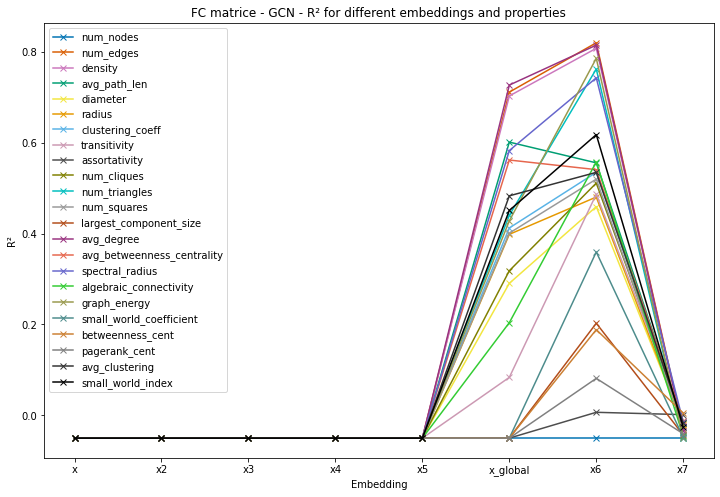

<Figure size 432x288 with 0 Axes>

In [29]:
import matplotlib.pyplot as plt
colors_long = [
    (0.0, 0.45, 0.70),  # Blue
    (0.85, 0.37, 0.01),  # Orange
    (0.8, 0.47, 0.74),   # Magenta
    (0.0, 0.62, 0.45),   # Green
    (0.95, 0.90, 0.25),  # Yellow
    (0.9, 0.6, 0.0),     # Brown
    (0.35, 0.7, 0.9),    # Sky Blue
    (0.8, 0.6, 0.7),     # Light Pink
    (0.3, 0.3, 0.3),     # Dark Gray
    (0.5, 0.5, 0.0),     # Olive
    (0.0, 0.75, 0.75),   # Cyan
    (0.6, 0.6, 0.6),     # Light Gray
    (0.7, 0.3, 0.1),     # Dark Orange
    (0.6, 0.2, 0.5),     # Purple
    (0.9, 0.4, 0.3),     # Salmon
    (0.4, 0.4, 0.8),     # Light Blue
    (0.2, 0.8, 0.2),     # Light Green
    (0.6, 0.6, 0.3),     # Mustard
    (0.3, 0.55, 0.55),    # Teal
    (0.8, 0.5, 0.2),     # Dark Salmon
    (0.5, 0.5, 0.5),     # Gray
    (0.2, 0.2, 0.2),      # Black-Gray
    (0.0, 0.0, 0.0)      # Black
]

property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']

plt.figure(figsize=(12, 8))

for i, property_names_long in enumerate(property_names_long):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_names_long)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_names_long, color=colors_long[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/"+DATASET+"_"+MODEL+"_test_R2_plot_long.png', dpi=300, bbox_inches='tight')

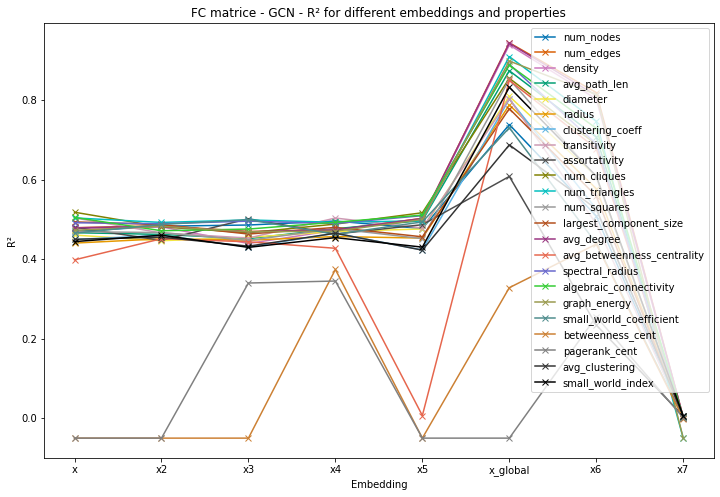

<Figure size 432x288 with 0 Axes>

In [30]:
plt.figure(figsize=(12, 8))
import matplotlib.pyplot as plt
colors_long = [
    (0.0, 0.45, 0.70),  # Blue
    (0.85, 0.37, 0.01),  # Orange
    (0.8, 0.47, 0.74),   # Magenta
    (0.0, 0.62, 0.45),   # Green
    (0.95, 0.90, 0.25),  # Yellow
    (0.9, 0.6, 0.0),     # Brown
    (0.35, 0.7, 0.9),    # Sky Blue
    (0.8, 0.6, 0.7),     # Light Pink
    (0.3, 0.3, 0.3),     # Dark Gray
    (0.5, 0.5, 0.0),     # Olive
    (0.0, 0.75, 0.75),   # Cyan
    (0.6, 0.6, 0.6),     # Light Gray
    (0.7, 0.3, 0.1),     # Dark Orange
    (0.6, 0.2, 0.5),     # Purple
    (0.9, 0.4, 0.3),     # Salmon
    (0.4, 0.4, 0.8),     # Light Blue
    (0.2, 0.8, 0.2),     # Light Green
    (0.6, 0.6, 0.3),     # Mustard
    (0.3, 0.55, 0.55),    # Teal
    (0.8, 0.5, 0.2),     # Dark Salmon
    (0.5, 0.5, 0.5),     # Gray
    (0.2, 0.2, 0.2),      # Black-Gray
    (0.0, 0.0, 0.0)      # Black
]

property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']

for i, property_names_long in enumerate(property_names_long):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        train_r2 = results[(name_of_embedding, property_names_long)][2]
        if train_r2 < -0.05:  # Handle negative R² values
            train_r2 = -0.05
        x_points.append(j)
        y_points.append(train_r2)

    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_names_long, color=colors_long[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/"+DATASET+"_"+MODEL+"_train_R2_plot_long.png', dpi=300, bbox_inches='tight')

### comparison with a gnn train on random (the y are shuffled)

In [ ]:
### comparison with a gnn train on random (the y are shuffled)
from Datasets.FC.create_dataset import read_dataset
dataset = read_dataset()
MODEL = "GAT"
DATASET = "FC_suffled"


from models.models_FC import GAT_framework as framework # import the model
gnn = framework(dataset)

print(gnn.model)
print(gnn.train_idx)
#shuffle the y values of the dataset
import numpy as np
import torch

y = np.array([data.y for data in dataset])
y = np.array(y, dtype=np.int64)  # Ensure y is a numeric array of type int64

np.random.shuffle(y)

#make y torch.int64, tensor([0]) instead of [0]
y = torch.tensor(y, dtype=torch.int64)

for i in range(len(dataset)):
    dataset[i].y = y[i]


In [ ]:
gnn.iterate()

In [ ]:
#save the model 
gnn.save_model(path="models/"+DATASET+"_"+MODEL+".pt")
#load the model
gnn.load_model(path="models/"+DATASET+"_"+MODEL+".pt")
gnn.evaluate()

In [ ]:
train_features, test_features = gnn.evaluate_with_features2()

In [ ]:
train_idx_list = gnn.train_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in train_idx_list]
train_properties_long = compute_graph_properties(selected_dataset)
test_idx_list = gnn.test_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in test_idx_list]
test_properties_long = compute_graph_properties(selected_dataset)

#save the properties in a file
with open("results/"+DATASET+"_"+MODEL+"_train_properties_long.pkl", "wb") as f:
    pkl.dump(train_properties_long, f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_long.pkl", "wb") as f:
    pkl.dump(test_properties_long, f)
import pickle as pkl
#save the properties in a file
# with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "wb") as f:
#     pkl.dump(train_properties, f)

# with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "wb") as f:
#     pkl.dump(test_properties, f)

#load the properties
with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "rb") as f:
    train_properties = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "rb") as f:
    test_properties = pkl.load(f)
"""
The embeddings of GIN are like this:
return F.log_softmax(x7, dim=-1), (x1, x2, x3, x4, x5, x_global, x6, x7, x8)
"""


import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
output_size = 1  # Predicting one property at a time
# Define the linear model
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Assume we have already evaluated to get features
# train_features, test_features = gnn.evaluate_with_features2()

# Extract x embeddings
train_x = np.array([feat[0] for feat in train_features])
test_x = np.array([feat[0] for feat in test_features])

# Extract 2, 3, 4, global, 5, 6, 7 embeddings
train_x2 = np.array([feat[1] for feat in train_features])
test_x2 = np.array([feat[1] for feat in test_features])

train_x3 = np.array([feat[2] for feat in train_features])
test_x3 = np.array([feat[2] for feat in test_features])

train_x4 = np.array([feat[3] for feat in train_features])
test_x4 = np.array([feat[3] for feat in test_features])

train_x5 = np.array([feat[4] for feat in train_features])
test_x5 = np.array([feat[4] for feat in test_features])

train_x_global = np.array([feat[5] for feat in train_features])
test_x_global = np.array([feat[5] for feat in test_features])

train_x6 = np.array([feat[6] for feat in train_features])
test_x6 = np.array([feat[6] for feat in test_features])

train_x7 = np.array([feat[7] for feat in train_features])
test_x7 = np.array([feat[7] for feat in test_features])

# Compute graph properties
# train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
# test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

# Convert to PyTorch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_x2 = torch.tensor(train_x2, dtype=torch.float32)
train_x3 = torch.tensor(train_x3, dtype=torch.float32)
train_x4 = torch.tensor(train_x4, dtype=torch.float32)
train_x5 = torch.tensor(train_x5, dtype=torch.float32)
train_x_global = torch.tensor(train_x_global, dtype=torch.float32)
train_x6 = torch.tensor(train_x6, dtype=torch.float32)
train_x7 = torch.tensor(train_x7, dtype=torch.float32)

test_x = torch.tensor(test_x, dtype=torch.float32)
test_x2 = torch.tensor(test_x2, dtype=torch.float32)
test_x3 = torch.tensor(test_x3, dtype=torch.float32)
test_x4 = torch.tensor(test_x4, dtype=torch.float32)
test_x5 = torch.tensor(test_x5, dtype=torch.float32)
test_x_global = torch.tensor(test_x_global, dtype=torch.float32)
test_x6 = torch.tensor(test_x6, dtype=torch.float32)
test_x7 = torch.tensor(test_x7, dtype=torch.float32)

train_y = torch.tensor(train_properties, dtype=torch.float32)
test_y = torch.tensor(test_properties, dtype=torch.float32)

# Train and evaluate a model for each graph property and each embedding
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component']
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4), (train_x5, test_x5), (train_x_global, test_x_global), (train_x6, test_x6), (train_x7, test_x7)]
embeddings_names = ['x', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']


property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
train_y_long = torch.tensor(train_properties_long, dtype=torch.float32)
test_y_long = torch.tensor(test_properties_long, dtype=torch.float32)
#create a dictionary where we will store the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    input_size = train_embedding.shape[1]

    for i, property_name in enumerate(property_names_long):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 800000  # Maximum number of epochs
        min_epochs = 1000  # Minimum number of epochs
        patience = 3000  # Number of epochs to wait for improvement
        tolerance = 1e-6  # Tolerance for considering the loss as stable

        best_loss = float('inf')
        no_improve_count = 0
        
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y_long[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Print every 1000 epochs
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

            # Check for early stopping, but only after minimum epochs
            if epoch >= min_epochs:
                if loss.item() < best_loss - tolerance:
                    best_loss = loss.item()
                    no_improve_count = 0
                else:
                    no_improve_count += 1

                if no_improve_count >= patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y_long[:, i].cpu().numpy()
            test_target = test_y_long[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embedding = embeddings_names[ii]
            results[(name_of_embedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1

#save results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_long.pkl", "wb") as f:
    pkl.dump(results, f)
#load results 
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_long.pkl", "rb") as f:
    results = pkl.load(f)
import matplotlib.pyplot as plt
colors_long = [
    (0.0, 0.45, 0.70),  # Blue
    (0.85, 0.37, 0.01),  # Orange
    (0.8, 0.47, 0.74),   # Magenta
    (0.0, 0.62, 0.45),   # Green
    (0.95, 0.90, 0.25),  # Yellow
    (0.9, 0.6, 0.0),     # Brown
    (0.35, 0.7, 0.9),    # Sky Blue
    (0.8, 0.6, 0.7),     # Light Pink
    (0.3, 0.3, 0.3),     # Dark Gray
    (0.5, 0.5, 0.0),     # Olive
    (0.0, 0.75, 0.75),   # Cyan
    (0.6, 0.6, 0.6),     # Light Gray
    (0.7, 0.3, 0.1),     # Dark Orange
    (0.6, 0.2, 0.5),     # Purple
    (0.9, 0.4, 0.3),     # Salmon
    (0.4, 0.4, 0.8),     # Light Blue
    (0.2, 0.8, 0.2),     # Light Green
    (0.6, 0.6, 0.3),     # Mustard
    (0.3, 0.55, 0.55)    # Teal
    (0.8, 0.5, 0.2),     # Dark Salmon
    (0.5, 0.5, 0.5),     # Gray
    (0.2, 0.2, 0.2)      # Black-Gray
    (0.0, 0.0, 0.0)      # Black
]

property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
embeddings_names = ['x', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']

plt.figure(figsize=(12, 8))

for i, property_names_long in enumerate(property_names_long):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_names_long)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_names_long, color=colors_long[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+'_'+MODEL+'test_R2_plot_long.png')

### Node embedding probing

/!\ Try to not forget that we need to change the batch_size to 1 if we want to probe for node properties as we need the forward pass to be made 1 graph by 1 graph at a time. 

In [ ]:
import networkx as nx
# Define function to compute node-level properties
def compute_node_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        node_degrees = list(dict(G.degree()).values())
        clustering_coeffs = list(nx.clustering(G).values())
        betweenness_centralities = list(nx.betweenness_centrality(G).values())
        eigenvector_centralities = list(nx.eigenvector_centrality(G, max_iter=10000).values())
        Local_clustering_coefficients = list(nx.clustering(G).values())

        properties.append((node_degrees, clustering_coeffs, betweenness_centralities, eigenvector_centralities, Local_clustering_coefficients))
    return properties

# Compute node-level properties for train and test sets
# Ensure gnn.train_idx and gnn.test_idx are lists of integers
train_idx = gnn.train_idx.tolist() if isinstance(gnn.train_idx, torch.Tensor) else gnn.train_idx
test_idx = gnn.test_idx.tolist() if isinstance(gnn.test_idx, torch.Tensor) else gnn.test_idx

# Compute node-level properties for train and test sets
train_node_properties = compute_node_properties([gnn.dataset[i] for i in train_idx])
test_node_properties = compute_node_properties([gnn.dataset[i] for i in test_idx])

#train_node_properties is a list of tuples, where each tuple contains 5 lists, each list contains the node-level property for each node in the graph

In [ ]:
len(train_node_properties), len(test_node_properties)

In [ ]:
# Check the length of the first three betweenness centralities of the three first graphs in the train set
[len(train_node_properties[i][2]) for i in range(3)]

We see that for each graph, the length of the betweenness centralities, and in general the length of properties, are equal to the number of nodes in the graph and thus
is equal to the length of the x matrix in the features. 

##### Node embeddings

In [ ]:
train_features, test_features = gnn.evaluate_with_features2(return_node_embeddings=True)

In [ ]:
len(train_features), len(test_features)

In [ ]:
# Check the shape of the first graph's features
first_graph_features = train_features[1]
for i, feature in enumerate(first_graph_features):
    print(f"Feature {i+1} shape:", feature.shape)

In [ ]:
train_features[1][0][26]

#### Embedding probing

##### Probing for the top 3 nodes on train_features only and averaging the results of the different diagnostif classifiers

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Function to get the top 3 nodes based on a specific property
def get_top_nodes(property_list, top_n=3):
    sorted_indices = sorted(range(len(property_list)), key=lambda k: property_list[k], reverse=True)
    return sorted_indices[:top_n]

In [ ]:

# Get the top 3 nodes for local clustering coefficient and eigenvector centrality
top_nodes_local_clustering = [get_top_nodes(graph_props[3], 3) for graph_props in train_node_properties]  # Assuming 3rd index is for local clustering coefficient
top_nodes_eigenvector = [get_top_nodes(graph_props[4], 3) for graph_props in train_node_properties]  # Assuming 4th index is for eigenvector centrality


In [ ]:
# Prepare the data for linear regression model training
def prepare_regression_data(features, properties, top_nodes_indices):
    X = []
    y = []
    for i, graph_features in enumerate(features):
        for layer in range(len(graph_features)):
            for node_index in top_nodes_indices[i]:
                X.append(graph_features[layer][node_index])
                y.append(properties[i][node_index])
    return torch.tensor(X), torch.tensor(y)

# Training and evaluating linear regression models
def train_and_evaluate_regression(X, y):
    model = LinearModel(X.shape[1], 1)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    # Train the model
    model.train()
    for epoch in range(1000):
        optimizer.zero_grad()
        outputs = model(X.float())
        loss = criterion(outputs, y.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        predictions = model(X.float()).view(-1)
        r2 = r2_score(y.float(), predictions)
    return r2

In [ ]:

# Prepare data for local clustering coefficient regression
X_local_clustering, y_local_clustering = prepare_regression_data(train_features, [props[3] for props in train_node_properties], top_nodes_local_clustering)

# Train and evaluate model for local clustering coefficient
r2_local_clustering = train_and_evaluate_regression(X_local_clustering, y_local_clustering)
print(f'R² for local clustering coefficient prediction: {r2_local_clustering}')

# Prepare data for eigenvector centrality regression
X_eigenvector, y_eigenvector = prepare_regression_data(train_features, [props[4] for props in train_node_properties], top_nodes_eigenvector)

# Train and evaluate model for eigenvector centrality
r2_eigenvector = train_and_evaluate_regression(X_eigenvector, y_eigenvector)
print(f'R² for eigenvector centrality prediction: {r2_eigenvector}')

# Prepare data for node degree regression
X_node_degree, y_node_degree = prepare_regression_data(train_features, [props[0] for props in train_node_properties], top_nodes_local_clustering)

# Train and evaluate model for node degree
r2_node_degree = train_and_evaluate_regression(X_node_degree, y_node_degree)
print(f'R² for node degree prediction: {r2_node_degree}')

# Prepare data for betweenness centrality regression
X_betweenness, y_betweenness = prepare_regression_data(train_features, [props[2] for props in train_node_properties], top_nodes_local_clustering)

# Train and evaluate model for betweenness centrality
r2_betweenness = train_and_evaluate_regression(X_betweenness, y_betweenness)
print(f'R² for betweenness centrality prediction: {r2_betweenness}')


##### Probing for the top 1 nodes with diagnostic classifier trained on the train set and test on the test set

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np

# Define Linear Model for probing (diagnostic classifier)
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Prepare the data for probing classifier
def prepare_regression_data(features, properties, property_index, top_n_nodes=1):
    X_layers = [[] for _ in range(len(features[0]))]
    y_layers = [[] for _ in range(len(features[0]))]

    for i, graph_features in enumerate(features):
        top_nodes_indices = get_top_nodes(properties[i][property_index], top_n=top_n_nodes)
        for layer in range(len(graph_features)):
            for node_index in top_nodes_indices:
                X_layers[layer].append(graph_features[layer][node_index])
                y_layers[layer].append(properties[i][property_index][node_index])

    X_layers = [torch.tensor(X) for X in X_layers]
    y_layers = [torch.tensor(y) for y in y_layers]
    
    return X_layers, y_layers

# Train and evaluate the probing classifier for each layer
def train_and_evaluate_regression(X_train_layers, y_train_layers, X_test_layers, y_test_layers):
    r2_scores_train = []
    r2_scores_test = []
    
    for layer in range(len(X_train_layers)):
        X_train = X_train_layers[layer]
        y_train = y_train_layers[layer]
        X_test = X_test_layers[layer]
        y_test = y_test_layers[layer]
        
        model = LinearModel(X_train.shape[1], 1)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        
        # Train the model
        model.train()
        for epoch in range(10000):
            optimizer.zero_grad()
            outputs = model(X_train.float())
            loss = criterion(outputs, y_train.float().view(-1, 1))
            loss.backward()
            optimizer.step()
        
        # Evaluate the model
        model.eval()
        with torch.no_grad():
            predictions_train = model(X_train.float()).view(-1)
            predictions_test = model(X_test.float()).view(-1)
            r2_train = r2_score(y_train.float(), predictions_train)
            r2_test = r2_score(y_test.float(), predictions_test)
        r2_scores_train.append(r2_train)
        r2_scores_test.append(r2_test)
    
    return r2_scores_train, r2_scores_test

# Aggregate R² scores across all graphs
def aggregate_r2_scores(features_train, properties_train, features_test, properties_test, property_index):
    X_train_layers, y_train_layers = prepare_regression_data(features_train, properties_train, property_index)
    X_test_layers, y_test_layers = prepare_regression_data(features_test, properties_test, property_index)
    
    r2_scores_train, r2_scores_test = train_and_evaluate_regression(X_train_layers, y_train_layers, X_test_layers, y_test_layers)
    
    return r2_scores_train, r2_scores_test

# Properties indices: 0 - node_degrees, 1 - clustering_coeffs, 2 - betweenness_centralities, 3 - eigenvector_centralities, 4 - Local_clustering_coefficients
properties_indices = [0, 1, 2, 3, 4]
property_names = ['Node Degrees', 'Clustering Coefficients', 'Betweenness Centralities', 'Eigenvector Centralities', 'Local Clustering Coefficients']

# Initialize dictionaries to store average R² scores across all layers
avg_r2_train_dict = {name: [] for name in property_names}
avg_r2_test_dict = {name: [] for name in property_names}

# Train and evaluate the probing classifier for each property
for prop_idx, prop_name in zip(properties_indices, property_names):
    print(f"Processing property: {prop_name}")
    avg_r2_train_dict[prop_name], avg_r2_test_dict[prop_name] = aggregate_r2_scores(train_features, train_node_properties, test_features, test_node_properties, prop_idx)

# Plotting the average R² scores across layers for each property
layers = np.arange(len(avg_r2_train_dict[property_names[0]]))

plt.figure(figsize=(12, 6))

# Plot for average R² scores
for prop_name in property_names:
    plt.plot(layers, avg_r2_train_dict[prop_name], label=f'{prop_name} (Train)', marker='o')
    plt.plot(layers, avg_r2_test_dict[prop_name], label=f'{prop_name} (Test)', linestyle='--', marker='x')

plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction Across Layers')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
#plot only test results
plt.figure(figsize=(12, 6))

# Plot for average R² scores
for prop_name in property_names:
    plt.plot(layers, avg_r2_test_dict[prop_name], label=f'{prop_name} (Test)', linestyle='--', marker='x')

plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction Across Layers')
plt.legend()
#x axis called layer 1, layer 2, etc
plt.xticks(range(len(layers)), [f'Layer {i+1}' for i in layers])           
plt.grid(True)

In [ ]:
# Extract labels from the dataset using train_idx_list and test_idx_list
train_idx_list = gnn.train_idx.tolist()
test_idx_list = gnn.test_idx.tolist()

train_labels = [gnn.dataset[i].y.item() for i in train_idx_list]
test_labels = [gnn.dataset[i].y.item() for i in test_idx_list]

# Split the dataset by label y=0 and y=1
def split_by_label(features, properties, labels):
    features_0, properties_0, features_1, properties_1 = [], [], [], []
    
    for i, label in enumerate(labels):
        if label == 0:
            features_0.append(features[i])
            properties_0.append(properties[i])
        else:
            features_1.append(features[i])
            properties_1.append(properties[i])
    
    return features_0, properties_0, features_1, properties_1

# Assuming you have train_features, train_node_properties, test_features, test_node_properties from your GNN
train_features_0, train_node_properties_0, train_features_1, train_node_properties_1 = split_by_label(train_features, train_node_properties, train_labels)
test_features_0, test_node_properties_0, test_features_1, test_node_properties_1 = split_by_label(test_features, test_node_properties, test_labels)

# Properties indices: 0 - node_degrees, 1 - clustering_coeffs, 2 - betweenness_centralities, 3 - eigenvector_centralities, 4 - Local_clustering_coefficients
properties_indices = [0, 1, 2, 3, 4]
property_names = ['Node Degrees', 'Clustering Coefficients', 'Betweenness Centralities', 'Eigenvector Centralities', 'Local Clustering Coefficients']

# Initialize dictionaries to store average R² scores across all layers for y=0 and y=1
avg_r2_train_dict_0 = {name: [] for name in property_names}
avg_r2_test_dict_0 = {name: [] for name in property_names}
avg_r2_train_dict_1 = {name: [] for name in property_names}
avg_r2_test_dict_1 = {name: [] for name in property_names}

# Train and evaluate the probing classifier for each property for y=0
for prop_idx, prop_name in zip(properties_indices, property_names):
    print(f"Processing property for y=0: {prop_name}")
    avg_r2_train_dict_0[prop_name], avg_r2_test_dict_0[prop_name] = aggregate_r2_scores(train_features_0, train_node_properties_0, test_features_0, test_node_properties_0, prop_idx)

# Train and evaluate the probing classifier for each property for y=1
for prop_idx, prop_name in zip(properties_indices, property_names):
    print(f"Processing property for y=1: {prop_name}")
    avg_r2_train_dict_1[prop_name], avg_r2_test_dict_1[prop_name] = aggregate_r2_scores(train_features_1, train_node_properties_1, test_features_1, test_node_properties_1, prop_idx)

# Plotting the average R² scores across layers for each property, separately for y=0 and y=1
layers = np.arange(len(avg_r2_train_dict_0[property_names[0]]))

plt.figure(figsize=(12, 12))

# Plot for y=0
plt.subplot(2, 1, 1)
for prop_name in property_names:
    plt.plot(layers, avg_r2_train_dict_0[prop_name], label=f'{prop_name} (Train)', marker='o')
    plt.plot(layers, avg_r2_test_dict_0[prop_name], label=f'{prop_name} (Test)', linestyle='--', marker='x')
plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction Across Layers (y=0)')
plt.legend()
plt.grid(True)

# Plot for y=1
plt.subplot(2, 1, 2)
for prop_name in property_names:
    plt.plot(layers, avg_r2_train_dict_1[prop_name], label=f'{prop_name} (Train)', marker='o')
    plt.plot(layers, avg_r2_test_dict_1[prop_name], label=f'{prop_name} (Test)', linestyle='--', marker='x')
plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction Across Layers (y=1)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
